In [73]:
%run '../dynamo_helper_functions.ipynb'

['/net/capricorn/home/xing/soh29/.conda/envs/dynamo_06_2024/lib/python3.8/site-packages/dynamo']


package umap-learn trimap    tqdm statsmodels setuptools seaborn   scipy  \
version      0.5.6  1.1.4  4.66.4      0.14.1     70.1.0  0.13.2  1.10.1   

package scikit-learn python-igraph pynndescent pre-commit pandas   numpy  \
version        1.3.2        0.11.5       0.5.8      3.5.0  1.2.0  1.23.0   

package numdifftools   numba networkx matplotlib loompy hdbscan  \
version       0.9.41  0.51.2      3.1      3.7.5  3.0.7  0.8.37   

package dynamo-release cvxopt colorcet  
version          1.0.0  1.3.2    3.1.0

In [261]:
doses = [0,12,25,50,100,200,400,800]
phases = ['G1.S', 'S', 'G2', 'G2.M', 'M.G1']
colors = {'G1.S':'firebrick', 'S':'orange', 'G2':'yellowgreen', 'G2.M':'teal', 'M.G1':'royalblue'} #Revelio
colors2 = {'G1-S':'firebrick', 'S':'orange', 'G2-M':'yellowgreen', 'M':'teal', 'M-G1':'royalblue'} #Dynamo
colors3 = {'G1.S':'#b22222', 'S':'#ffd700', 'G2':'#9acd32', 'G2.M':'#008080', 'M.G1':'#4b0082'}

In [4]:
import matplotlib
from gseapy import enrichr
import copy
from scipy import interpolate
from tslearn.clustering import TimeSeriesKMeans
from sklearn import preprocessing
from fastdtw import fastdtw
from scipy.spatial import Voronoi, voronoi_plot_2d
import scipy
from collections import defaultdict
import mygene
from scipy.cluster.vq import kmeans2
from dynamo.tools.utils import nearest_neighbors
from scipy.spatial.distance import cdist

In [215]:
from scipy.sparse.csgraph import dijkstra
import random
from sklearn.manifold import MDS
from tslearn.clustering import TimeSeriesKMeans
from sklearn.manifold import TSNE
from tslearn.utils import to_time_series_dataset
from scipy.interpolate import interp1d
import copy
from scipy.spatial import distance
from scipy.interpolate import make_smoothing_spline
from scipy.interpolate import UnivariateSpline

# Functions


In [182]:
def pca_to_expr(X, PCs, mean=0, func=None):
    # reverse project from PCA back to raw expression space
    #print("In pca_to_expr")
    #print(X.shape, PCs.T.shape)
    if PCs.shape[0] == X.shape[1]:
        exprs = X @ PCs + mean
        if func is not None:
            exprs = func(exprs)
    else:
        raise Exception("PCs dim 1 (%d) does not match X dim 1 (%d)." % (PCs.shape[0], X.shape[1]))
    return exprs

In [183]:
# new_data = [# of genes, # of new data points (cells)]
# rotation_mat = [# of genes, # of genes]
# pcs = [# of PCs, # of genes]
# gene_means = [# of genes, 1]
def dc_to_exp(new_data, rotation_mat, pcs, gene_means):
    #print(rotation_mat.shape[1])
    #print(new_data.shape[0])
    if rotation_mat.shape[1] == new_data.shape[0]:
        rotation_mat.columns = new_data.index #for matrix multiplication with pandas dataframes
        #print(rotation_mat.shape, new_data.shape)
        pc_mat = rotation_mat @ new_data #[,# of cells]
        pc_mat.index = pcs.index
        #print(pcs.shape, pc_mat.shape, gene_means.shape)
        toReturn = pca_to_expr(pcs.T, pc_mat, np.array(gene_means))
        
        for col in toReturn.columns:
            min_num = abs(np.min(toReturn[col]))
            #print(min_num)
            toReturn[col] = toReturn[col] + min_num
        print(toReturn.shape)
        return toReturn

In [181]:
def new_pt_to_ge(points, adata, pc_dc_rot, pcs, filtered_gene_means):
    gene_exp = pd.DataFrame()
    for i in range(points.shape[0]):
        # Find the indices of the 10 nearest neighbors of the current point in the reduced dimension
        n_neighs = getNNeighbors(points.iloc[i], adata.obsm['X_RC'][:,:2], k=10)[0]
        
        # Calculate the new point in the high-dimensional space by averaging the nearest neighbors
        new_point_high_dim = np.mean(adata.obsm['X_DC'][n_neighs,:], axis=0)
        
        # Convert the new point from the high-dimensional space to gene expression space
        #print(pd.DataFrame(new_point_high_dim, columns=['new point']).shape)
        new_point_gene_exp = dc_to_exp(pd.DataFrame(new_point_high_dim, columns=['new point']), pc_dc_rot, pcs, filtered_gene_means)
        
        # Rename the columns of the new point gene expression DataFrame
        new_point_gene_exp.columns = ['point '+str(i)]
        
        # Concatenate the gene expression values of the new point to the gene_exp DataFrame
        gene_exp = pd.concat([gene_exp, new_point_gene_exp], axis=1)
    return gene_exp

In [8]:
def plot_all(gene, adata):
    plt.figure(figsize=(17,4))
    cmap = matplotlib.cm.get_cmap("seismic")
    #gene = 'E2F1'
    gene_index = adata.var.index.get_loc(gene)
    gene_exp = adata.X.toarray()[:,gene_index]
    temp = gene_exp != 0
    plt.subplot(1,3,1)
    plt.scatter(adata.obsm['X_RC'][:,0],
                adata.obsm['X_RC'][:,1],
                color='midnightblue')
    plt.scatter(adata.obsm['X_RC'][temp,0],
                adata.obsm['X_RC'][temp,1],
                c=gene_exp[temp])
    plt.clim(0, np.max(gene_exp))
    plt.colorbar()
    dyn.pl.zstreamline(adata, basis='RC', density=0.75)
    plt.xticks([])
    plt.yticks([])
    plt.title(gene + " expression", fontsize=12)
    plt.xlabel("Cell Cycle Coordinate", fontsize=10)
    plt.ylabel("EMT", fontsize=10)

    gene_velo = adata.layers['velocity_S'].toarray()[:,gene_index]
    plt.subplot(1,3,2)
    plt.scatter(adata.obsm['X_RC'][:,0],
                adata.obsm['X_RC'][:,1],
                c=gene_velo,
                norm=matplotlib.colors.TwoSlopeNorm(vcenter=0))
    plt.colorbar()
    dyn.pl.zstreamline(adata, basis='RC', density=0.75)
    plt.xticks([])
    plt.yticks([])
    plt.title(gene + " velocity", fontsize=12)
    plt.xlabel("Cell Cycle Coordinate", fontsize=10)
    plt.ylabel("EMT", fontsize=10)

    gene_acc = np.nan_to_num(adata.layers['acceleration'])[:,gene_index]
    plt.subplot(1,3,3)
    plt.scatter(adata.obsm['X_RC'][:,0],
                adata.obsm['X_RC'][:,1],
                c=gene_acc,
                norm=matplotlib.colors.TwoSlopeNorm(vcenter=0))
    plt.colorbar()
    dyn.pl.zstreamline(adata, basis='RC', density=0.75)
    plt.xticks([])
    plt.yticks([])
    plt.title(gene + " acceleration", fontsize=12)
    plt.xlabel("Cell Cycle Coordinate", fontsize=10)
    plt.ylabel("EMT", fontsize=10)
    plt.tight_layout()

In [9]:
def plot_jacobian(reg, eff):
    reg_index = dose12.uns['jacobian_pca']['regulators'].index(reg)
    eff_index = dose12.uns['jacobian_pca']['effectors'].index(eff)
    plt.scatter(dose12.obsm['X_RC'][:,0],
                dose12.obsm['X_RC'][:,1],
                c=dose12.uns['jacobian_pca']['jacobian_gene'][reg_index, eff_index],
                norm=matplotlib.colors.TwoSlopeNorm(vcenter=0),
                cmap='seismic')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Cell cycle coordinate", fontsize=10, fontweight='bold')
    plt.ylabel("DC3", fontsize=10, fontweight='bold')
    plt.title("reg: " + reg + "\neff: " + eff, fontsize=12, fontweight='bold')
    plt.show()

In [10]:
def comp_paths_jacobian(gene, path1_df, path2_df):
    temp_path1 = full_reg_rank_groups['path 1'][[gene, gene+'_values']]
    temp_path1.columns = [gene+'_path1',gene+'_path1_values']
    temp_path1['path 1 rank'] = temp_path1.index
    temp_path1.index = temp_path1[gene+'_path1']
    
    temp_path2 = full_reg_rank_groups['path 2'][[gene, gene+'_values']]
    temp_path2.columns = [gene+'_path2',gene+'_path2_values']
    temp_path2['path 2 rank'] = temp_path2.index
    temp_path2.index = temp_path2[gene + '_path2']
    
    temp_paths = pd.concat([temp_path1, temp_path2], axis=1)
    
    temp_paths['path 1 sign'] = np.sign(temp_paths[gene+'_path1_values'])
    temp_paths['path 2 sign'] = np.sign(temp_paths[gene+'_path2_values'])
    temp_paths = temp_paths.drop([gene+'_path1', gene+'_path2'], axis=1)                      
    return temp_paths

In [11]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [12]:
class Clusters(dict):
    def _repr_html_(self):
        cluster = {}
        for c in self:
            cluster[c] = repr(self[c])
        return cluster

In [13]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [14]:
def printDict(dict_name, key):
    for i in range(len(dict_name[key])):
        print(dict_name[key][i])

In [15]:
def sample_by_kmeans(X: np.ndarray, n: int, return_index: bool = False):
    """Sample method based on kmeans.

    Args:
        X: Coordinates associated to each element in `arr`.
        n: The number of samples.
        return_index: Whether to return the sample indices. Defaults to False.

    Returns:
        The sample index array if `return_index` is True. Else return the array after sampling.
    """
    C, _ = kmeans2(X, n)
    nbrs = nearest_neighbors(C, X, k=1).flatten()

    if return_index:
        return nbrs
    else:
        return X[nbrs]

# Load data

In [16]:
adata = dyn.read_loom("../../data/processed_possorted_genome_bam_RIG79.loom")
temp = np.empty((len(adata.obs),1), dtype=object)
temp.shape
for i in range(len(adata.obs)):
    temp[i] = str(int(float(adata.obs['dosage'][i])))
adata.obs['dosage'] = temp
#adata.obs.index = adata.obs['obs_names']

# Load gene lists

In [16]:
#EM_genes = pd.read_excel("/net/capricorn/home/xing/soh29/Research/gene_lists/Epithelial_mesenchymal_marker_genes.xlsx")

In [17]:
# E_genes = list(EM_genes[EM_genes['Signature'] == 'Epi']['Gene Name'])
# M_genes = list(EM_genes[EM_genes['Signature'] == 'Mes']['Gene Name'])

In [18]:
#EMT_genes = E_genes + M_genes

In [185]:
emt_genes = pd.read_csv("../../../gene_lists/emt_genes_weikang.txt", header=None)[0].tolist()
tf_emt_genes = pd.read_csv("../../../gene_lists/TF_EMT_genes.txt", header=None)[0].tolist()

# DC space --> gene expression space

In [153]:
pcaGenes = pd.read_csv("../generated_data/Revelio_test2/pcaGenes.txt", index_col=0)
dc_mat = pd.read_csv("../generated_data/Revelio_test2/dc_mat.csv", index_col=0)
pc_mat = pd.read_csv("../generated_data/Revelio_test2/pc_mat.csv", index_col=0)
pcs = pd.read_csv("../generated_data/Revelio_test2/pcs.csv", index_col=0)
pc_dc_rot = pd.read_csv("../generated_data/Revelio_test2/pc_dc_rot.csv", index_col=0)
filtered_gene_scaled_counts = pd.read_csv("../generated_data/Revelio_test2/filtered_gene_scaled_counts.csv", index_col=0)
filtered_gene_means = pd.read_csv("../generated_data/Revelio_test2/filtered_gene_means.csv", index_col=0)

In [156]:
dose12_df.T

obs_names       AAACCTGAGAAAGTGG AAACGGGCACGGACAA AAACGGGCATAGTAAG  \
DC1                     3.328267         5.749374        -6.070759   
DC2                    -0.580111         2.495106        -2.676672   
DC3                    -2.870593         0.963153        16.896213   
DC4                    -3.227180        -0.678216        -3.134003   
DC5                     1.584401        -0.450852        -3.986431   
...                          ...              ...              ...   
KS EMT score            0.104299         0.120507         0.160817   
EMT score               4.213381         6.025264         1.481682   
final EMT score                E                E                E   
RC region                      1               19                9   
RC nneighbor                   7              195               89   

obs_names       AAACGGGGTTGATTGC AAACGGGTCCTAGGGC AAACGGGTCCTGTAGA  \
DC1                    -4.397481        -2.794379         4.966238   
DC2                    -3.723461         6.530357        -1.817188   
DC3                    13.407422         9.949433        -3.454590   
DC4                     9.099758       -12.745499        -2.686801   
DC5                    -3.626430        -0.393873         1.027818   
...                          ...              ...              ...   
KS EMT score            0.079915         0.337844         0.095278   
EMT score               1.455306         5.365075         1.542534   
final EMT score                E                E                E   
RC region                      8               14                1   
RC nneighbor                  80              143               10   

obs_names       AAAGATGCAGACGTAG AAAGATGTCCAAGCCG AAAGCAACATCACGAT  \
DC1                     5.659205         4.833765         2.809990   
DC2                    -1.990059        -0.744279         3.886262   
DC3                    -2.365003        -3.968071        -4.202737   
DC4                    -0.735647        -4.409118         0.745164   
DC5                     0.595533        -2.968836        -1.317545   
...                          ...              ...              ...   
KS EMT score            0.103312         0.096124         0.064975   
EMT score               8.160017         1.375613         8.091417   
final EMT score                E                E                E   
RC region                      1                0               17   
RC nneighbor                   9                5              179   

obs_names       AAAGCAACATGCGCAC AAAGCAAGTCGACTAT AAAGCAATCCGTTGTC  \
DC1                     1.221573         0.528134        -4.332269   
DC2                     5.126515         2.211877        -5.288117   
DC3                    -3.464413        -4.895231         2.094441   
DC4                     1.399246         1.289333        10.889397   
DC5                    -3.272709        -2.623708        -0.130443   
...                          ...              ...              ...   
KS EMT score            0.117548         0.045525         0.067794   
EMT score              11.421330        12.589371        10.284875   
final EMT score                E                E                E   
RC region                     16               16                7   
RC nneighbor                 165              162               73   

obs_names       AAAGTAGAGTAGCGGT AAAGTAGGTTCAGCGC AAATGCCAGAGTAAGG  \
DC1                    -7.922557        -6.053143         4.391684   
DC2                    -1.208737        -3.664688        -0.180599   
DC3                    11.667858         0.168159        -5.146900   
DC4                    -4.794058         1.567042        -0.480183   
DC5                     3.181657         0.756770        -0.218818   
...                          ...              ...              ...   
KS EMT score            0.303453         0.157858        -0.040310   
EMT score               2.605620        10.057046        12.086858   
final 

In [165]:
dc_mat.T.columns

Index(['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10',
       ...
       'DC724', 'DC725', 'DC726', 'DC727', 'DC728', 'DC729', 'DC730', 'DC731',
       'DC732', 'DC733'],
      dtype='object', length=733)

# Processing data

In [246]:
dose12_df = pd.read_csv("../plots/new_CCC/dose12/" + "DC_dose_12.csv", index_col=0)

In [251]:
dc_mat_df = dc_mat.T[['DC1','DC2','DC3','DC4','DC5','DC6','DC7','DC8','DC9','DC10']].reindex(dose12_df.index)

In [253]:
dc_mat_df['RC'] = dose12_df['RC nneighbor ']

In [18]:
additional_boundary_range = 0
i=1
dose = str(doses[i])
dose_adata = adata[(dose == adata.obs['dosage'])]

In [19]:
dose_adata.obs.index = dose_adata.obs['obs_names']

In [20]:
# Finding intersecting indexes between revelio and dataset
dose_index = dose_adata.obs.index
cc_index = dose12_df.index
cells_intersect = np.intersect1d(dose_index, cc_index)

In [21]:
new_adata = dose_adata[cells_intersect,:]
new_adata.obs.index = new_adata.obs['obs_names']
dose12_df = dose12_df.reindex(new_adata.obs.index)

cols = dose12_df.columns[2:9].tolist()
cols.insert(0, 'RC nneighbor ')

coords = np.array(dose12_df[cols])

dose12 = dose_adata[dose12_df.index,:]

In [22]:
dose12

View of AnnData object with n_obs × n_vars = 1228 × 60668
    obs: 'dosage', 'obs_names'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [23]:
# Process the original data 
dyn.pp.recipe_monocle(dose12, n_top_genes=2000, keep_filtered_genes=True)
dyn.tl.dynamics(dose12, model='deterministic', cores=3)
dyn.tl.reduceDimension(dose12)

|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> filtering genes...


{'filter_bool': None, 'layer': 'all', 'min_cell_s': 12.280000000000001, 'min_cell_u': 6.140000000000001, 'min_cell_p': 6.140000000000001, 'min_avg_exp_s': 0, 'min_avg_exp_u': 0, 'min_avg_exp_p': 0, 'max_avg_exp': inf, 'min_count_s': 0, 'min_count_u': 0, 'min_count_p': 0, 'shared_count': 30}


|-----> calculating size factor...


                      Accession  Chromosome       End     Start Strand  \
0             ENSG00000278704.1  GL000009.2     58376     56140      -   
1             ENSG00000277400.1  GL000194.1    115018     53590      -   
2             ENSG00000274847.1  GL000194.1    115055     53594      -   
3             ENSG00000277428.1  GL000195.1     37534     37434      -   
4             ENSG00000276256.1  GL000195.1     49164     42939      -   
...                         ...         ...       ...       ...    ...   
60663   ENSG00000237040.6_PAR_Y           Y  57062405  57062156      +   
60664  ENSG00000124333.16_PAR_Y           Y  57130289  57067865      +   
60665  ENSG00000124334.17_PAR_Y           Y  57197337  57184101      +   
60666   ENSG00000270726.6_PAR_Y           Y  57208756  57190738      +   
60667  ENSG00000182484.15_PAR_Y           Y  57212230  57207346      +   

          var_names  nCells  nCounts  pass_basic_filter  
0        BX004987.1       0      0.0              Fal

|-----> selecting genes...


None
{'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
sort by:  SVR
adata shape:  (1228, 60668)
adata shape:  (1228, 6121)
layer:  X
CM:  (1228, 6121)
CM:  (1228, 6121)
detected_bool:  [ True  True  True ...  True  True  True]
valid CM:  (1228, 6121)
mu:  [0.10658254 1.3973233  0.8497787  ... 0.26154426 0.58743745 0.20244311]
mu shape:  (6121,)
log_m:  [-3.2299569   0.4826658  -0.2348409  ... -1.934873   -0.76749283
 -2.3044116 ]


|-----> <insert> frac to var in AnnData Object.


sort by:  SVR
adata shape:  (1228, 60668)
adata shape:  (1228, 2000)
layer:  X
CM:  (1228, 2000)
CM:  (1228, 2000)
detected_bool:  [ True  True  True ...  True  True  True]
valid CM:  (1228, 2000)
mu:  [ 0.01251926 10.571889    0.14298573 ...  0.7367362   1.3405329
  0.12091074]
mu shape:  (2000,)
log_m:  [-6.3197064   3.4021614  -2.806057   ... -0.44078     0.42280662
 -3.0479858 ]


|-----> size factor normalizing the data, followed by log1p transformation.
|-----> applying PCA ...
|-----> <insert> pca_fit to uns in AnnData Object.
|-----> <insert> ntr to obs in AnnData Object.
|-----> <insert> ntr to var in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|
|-----> [recipe_monocle preprocess] finished [3.7920s]
|-----> calculating first/second moments begins...


X shape:  (1228, 30)
neighbors:  30
random_state:  RandomState(MT19937)
min_dist:  0.1
n_components:  2


|
|-----> [moments calculation] finished [14.5668s]
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


KeyError: 'kwargs'

In [24]:
dyn.tl.neighbors(dose12)

AnnData object with n_obs × n_vars = 1228 × 60668
    obs: 'dosage', 'obs_names', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'var_names', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors'
    obsm: 'X_pca', 'X'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'X_spliced', 'X_unspliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con', 'connectivities', 'distances'

In [256]:
dyn.tl.cell_wise_confidence(dose12)
dose12.obs.index = dose12.obs['obs_names']
dose12.obsm['X_RC'] = np.array(dc_mat_df[['RC', 'DC3']])

In [257]:
dyn.tl.cell_velocities(dose12, basis = 'RC', enforce = True, method='pearson', other_kernels_dict={'transform': 'sqrt'}, correct_density = True)
dyn.vf.VectorField(dose12, basis='RC', M=1000)
dyn.vf.topography(dose12, basis='RC')

|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [1.8741s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5959s]
|-----> vectorfield calculation begins...
|-----> Retrieve X and V based on basis: RC. 
        Vector field will be learned in the RC space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.


V_emb:  (1228, 2)
neighs:  [[ 563  980  846 ...  771 1215  880]
 [ 563  634   14 ...  262  898  771]
 [ 634  131  719 ... 1215 1085   76]
 ...
 [ 394  366 1167 ...  485  693  972]
 [ 366  394 1167 ...  265   24  298]
 [ 366  394  508 ... 1115 1002  644]]
X_grid:  (2500, 2)
V_grid:  (2500, 2)
mass:  [[1.70372489e-04 3.01063118e-03 8.07743630e-03 ... 2.85363659e-01
  7.21419342e-02 1.34922470e-03]
 [1.12609333e-03 1.98285262e-02 4.66454637e-02 ... 1.77012891e+00
  4.90415682e-01 1.05767962e-02]
 [5.74038345e-03 1.00460916e-01 2.10244554e-01 ... 8.33797184e+00
  2.58355906e+00 6.40673633e-02]
 ...
 [7.38243298e-41 3.71812110e-36 1.17889533e-36 ... 1.30885655e-46
  5.23500805e-44 3.93437364e-45]
 [6.55191926e-44 3.29983750e-39 1.04627120e-39 ... 3.95406752e-50
  1.93832226e-47 1.45687304e-48]
 [4.34684089e-47 2.18926211e-42 6.94143849e-43 ... 8.94536391e-54
  5.36510140e-51 4.03277501e-52]]
min_mass:  1e-05
cutoff:  (50, 50)
V_grid: (2, 50, 50)
cutoff:  [[ True  True False ... False False 

|-----> <insert> velocity_RC_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_RC_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_RC to uns in AnnData Object.
|-----> <insert> control_point_RC to obs in AnnData Object.
|-----> <insert> inlier_prob_RC to obs in AnnData Object.
|-----> <insert> obs_vf_angle_RC to obs in AnnData Object.
|
|-----> [VectorField] finished [8.2315s]


AnnData object with n_obs × n_vars = 1228 × 60668
    obs: 'dosage', 'obs_names', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'jaccard_velocity_confidence', 'control_point_RC', 'inlier_prob_RC', 'obs_vf_angle_RC', 'CC'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'var_names', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'grid_velocity_RC', 'VecFld_RC'
    obsm: 'X_pca', 'X', 'X_RC', 'velocity_RC', 'velocity_RC_SparseVFC

In [27]:
i=1
additional_boundary_range = 0
CC = dose12_df['CC']
CC.index = dose12.obs.index
dose12.obs['CC'] = CC

In [80]:
dose12_df

DC1       DC2        DC3        DC4       DC5  \
obs_names                                                              
AAACCTGAGAAAGTGG  3.328267 -0.580111  -2.870593  -3.227180  1.584401   
AAACGGGCACGGACAA  5.749374  2.495106   0.963153  -0.678216 -0.450852   
AAACGGGCATAGTAAG -6.070759 -2.676672  16.896213  -3.134003 -3.986431   
AAACGGGGTTGATTGC -4.397481 -3.723461  13.407422   9.099758 -3.626430   
AAACGGGTCCTAGGGC -2.794379  6.530357   9.949433 -12.745499 -0.393873   
...                    ...       ...        ...        ...       ...   
TTTGCGCCAGGATTGG -0.899582  0.621932  -5.574849   0.155623 -2.360002   
TTTGGTTAGTCCCACG -6.001499  2.754050   7.271523 -12.517321 -0.927974   
TTTGGTTCACATTAGC -4.927627 -1.606818   5.598033  -0.909065  2.029538   
TTTGGTTTCACTTCAT -4.800800 -2.813347  17.985844   5.092195 -6.032511   
TTTGTCAGTCTCAACA  2.892557 -2.985366  -5.471975  -5.196030  1.046791   

                       DC6       DC7       DC8       DC9      DC10    CC  \
obs_names                                                                  
AAACCTGAGAAAGTGG  2.888582 -0.560005 -0.338281  1.222762 -0.844174  G1.S   
AAACGGGCACGGACAA  2.234840  2.176439 -1.575641 -1.086445  0.712917  G2.M   
AAACGGGCATAGTAAG -6.879346 -3.697993  0.120933  4.298743  1.074398     S   
AAACGGGGTTGATTGC  0.273914  1.407202 -3.546946 -0.500804 -1.517245  G1.S   
AAACGGGTCCTAGGGC  0.008835 -5.612960  2.279869  2.197355  2.320965     S   
...                    ...       ...       ...       ...       ...   ...   
TTTGCGCCAGGATTGG  3.161324 -3.008522 -2.697411  2.027258  0.171038     S   
TTTGGTTAGTCCCACG -4.407124 -6.916194  0.745238  0.497784 -7.582375  G1.S   
TTTGGTTCACATTAGC -7.481083  2.238801  1.210514 -5.026830 -1.648404  G1.S   
TTTGGTTTCACTTCAT -1.432948 -0.437797  1.342174  3.803175 -2.502634  G1.S   
TTTGTCAGTCTCAACA -0.436566 -0.604296  1.432413  0.131992 -1.917657  G1.S   

                  group  CDH1  AGR2  EPCAM  KRT19     RAB25   TACSTD2  S100P  \
obs_names                                                                      
AAACCTGAGAAAGTGG      0   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
AAACGGGCACGGACAA      2   0.0   0.0    0.0    0.0  0.000000  0.991271    0.0   
AAACGGGCATAGTAAG      4   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
AAACGGGGTTGATTGC      0   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
AAACGGGTCCTAGGGC      4   0.0   0.0    0.0    0.0  0.000000  0.665098    0.0   
...                 ...   ...   ...    ...    ...       ...       ...    ...   
TTTGCGCCAGGATTGG      4   0.0   0.0    0.0    0.0  0.679902  0.679902    0.0   
TTTGGTTAGTCCCACG      0   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
TTTGGTTCACATTAGC      0   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
TTTGGTTTCACTTCAT      0   0.0   0.0    0.0    0.0  0.000000  0.000000    0.0   
TTTGTCAGTCTCAACA      0   0.0   0.0    0.0    0.0  0.684258  0.000000    0.0   

                  CEACAM6    GALNT3  FXYD3  SPINT2  TMEM30B    SCNN1A  \
obs_names                                                               
AAACCTGAGAAAGTGG      0.0  0.000000    0.0     0.0      0.0  0.000000   
AAACGGGCACGGACAA      0.0  0.991271    0.0     0.0      0.0  0.000000   
AAACGGGCATAGTAAG      0.0  0.000000    0.0     0.0      0.0  0.000000   
AAACGGGGTTGATTGC      0.0  0.000000    0.0     0.0      0.0  0.000000   
AAACGGGTCCTAGGGC      0.0  0.000000    0.0     0.0      0.0  0.000000   
...                   ...       ...    ...     ...      ...       ...   
TTTGCGCCAGGATTGG      0.0  0.000000    0.0     0.0      0.0  0.000000   
TTTGGTTAGTCCCACG      0.0  0.000000    0.0     0.0      0.0  0.000000   
TTTGGTTCACATTAGC      0.0  0.000000    0.0     0.0      0.0  1.098612   
TTTGGTTTCACTTCAT      0.0  0.000000    0.0     0.0      0.0  0.000000   
TTTGTCAGTCTCAACA      0.0  0.684258    0.0     0.0      0.0  0.000000   

                      ST14  ESRP1   S100A14  CLDN7  ERBB3  RBM47    SPINT1  \
obs_names                   

In [166]:
dose12.obsm['X_DC'] = np.array(dc_mat.T.reindex(dose12.obs.index))

In [167]:
dose12.obsm['X_DC'].shape

(1228, 733)

In [32]:
dose12_df = dose12_df.reindex(dose12.obs.index)

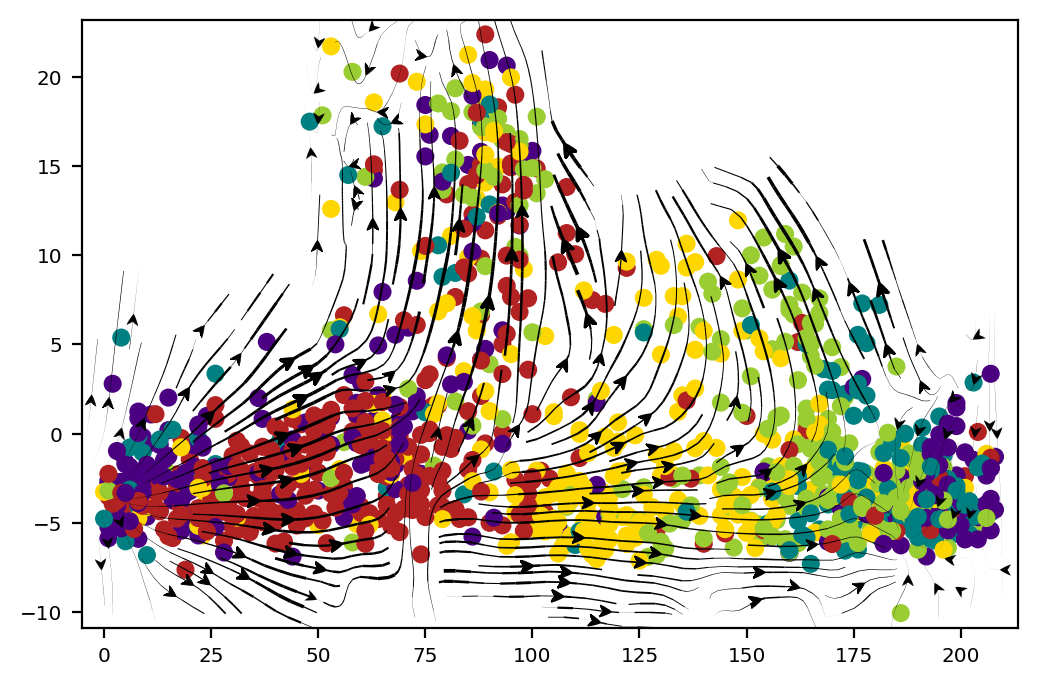

In [262]:
plt.scatter(dose12.obsm['X_RC'][:,0],
            dose12.obsm['X_RC'][:,1],
            c=dose12.obs['CC'].map(colors3))
dyn.pl.zstreamline(dose12, basis='RC')

# Loading and obtaining mean trajectories 

In [263]:
with open('rerun_traj_simulations_final/dose12/k10_100_trajs_test.pkl', 'rb') as f:
    traj_list = pickle.load(f)

In [264]:
# obtain trajectories in DC space
coords_DC_list = []
for j in range(len(traj_list)):
    coords_DC = []
    for i in range(len(traj_list[j])):
        coords_DC.append(dose12.obsm['X_DC'][traj_list[j][i],:10])
    coords_DC_list.append(coords_DC)

In [265]:
# cluster trajectories into two clusters
model_list = []
for i in range(len(coords_DC_list)):
    data = to_time_series_dataset(coords_DC_list[i])
    model = TimeSeriesKMeans(n_clusters=2, metric="softdtw", max_iter=10, random_state=0, init='k-means++')
    model.fit(data)
    model.cluster_centers_.shape
    model_list.append(model)

X0: 87


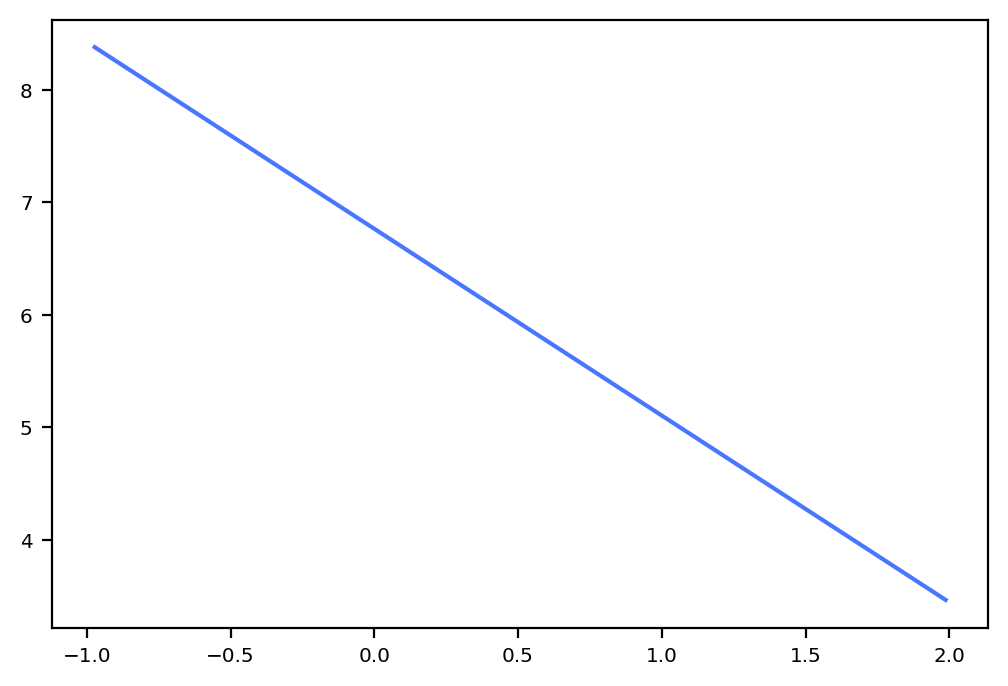

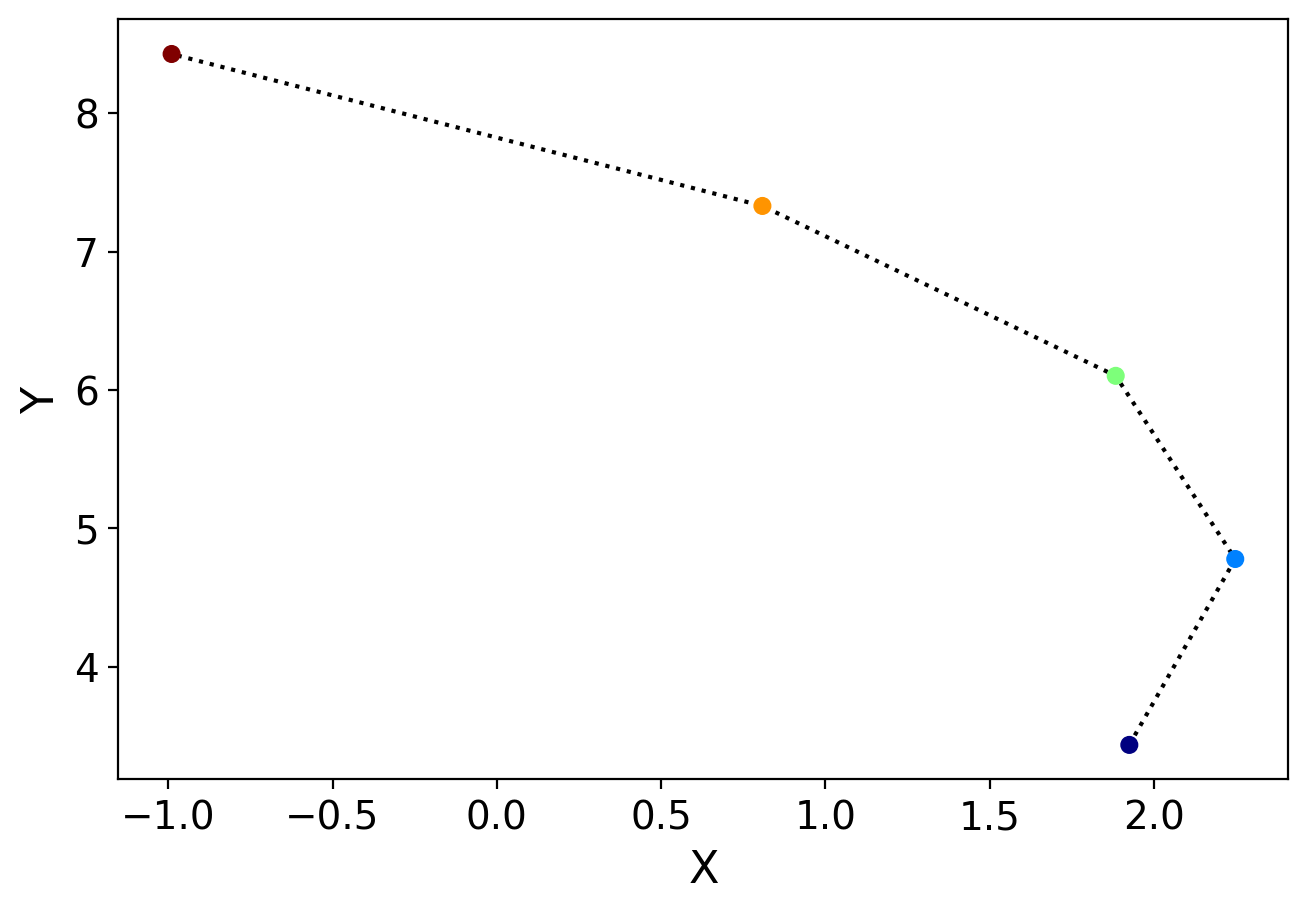

True


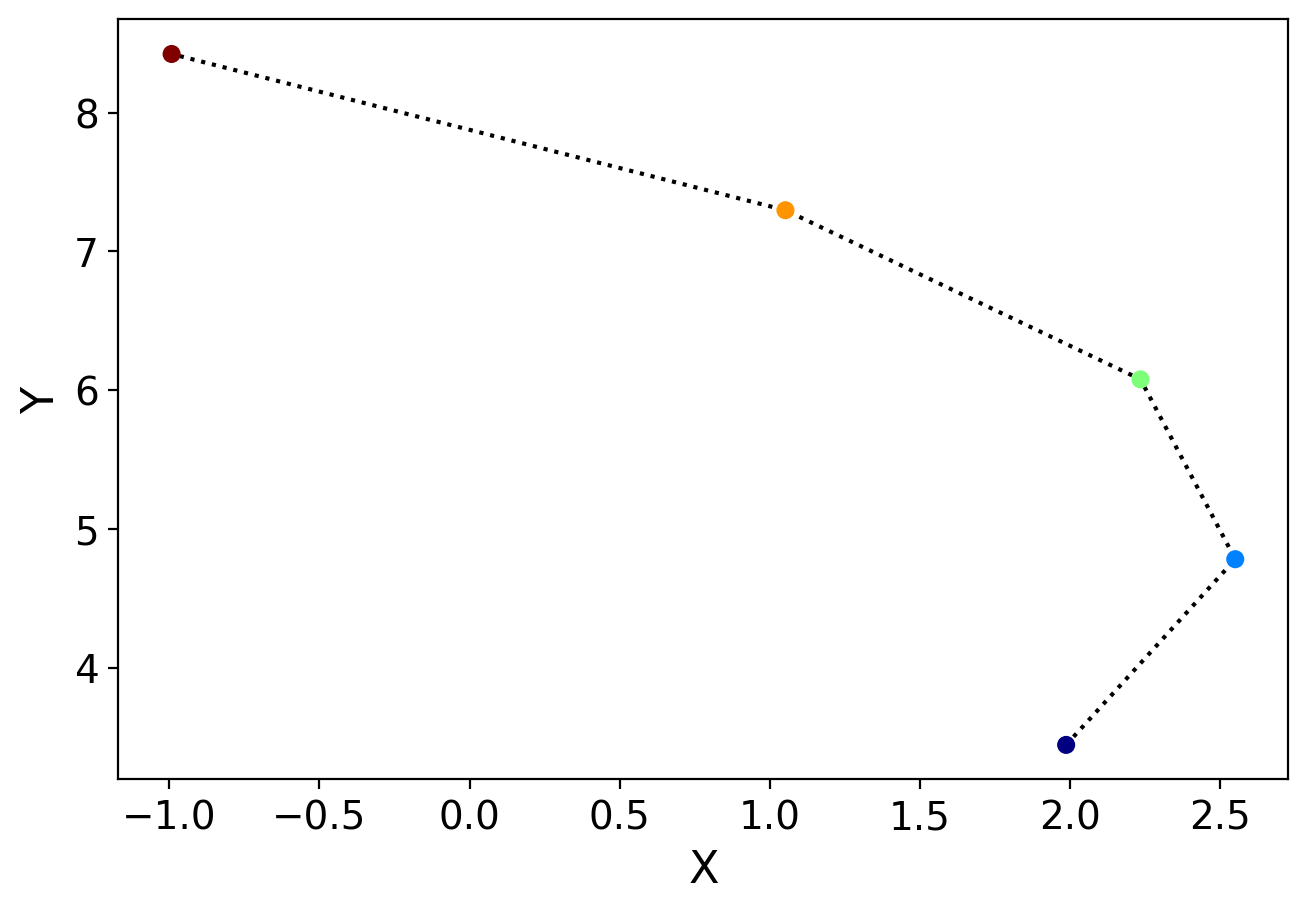

True


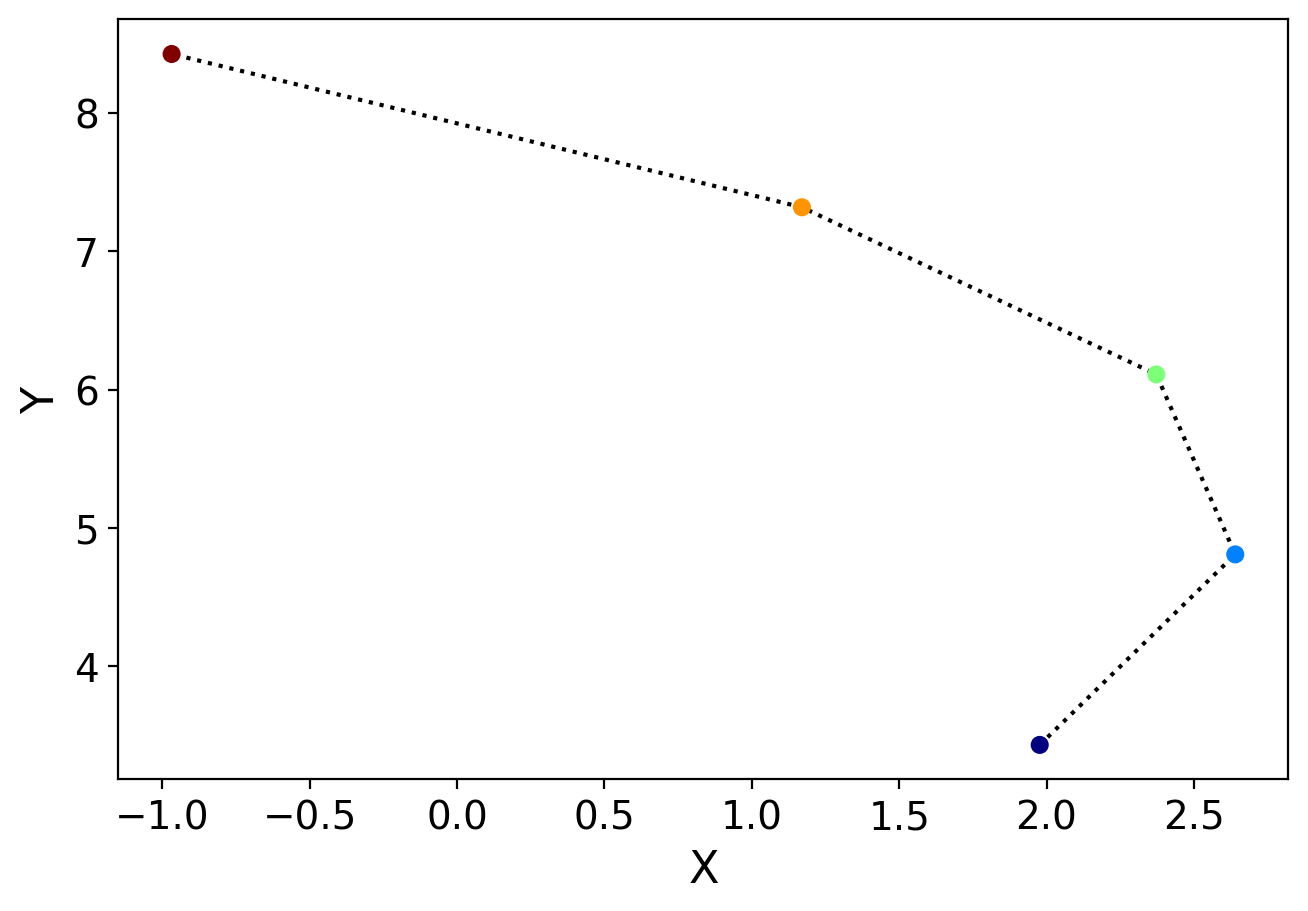

True


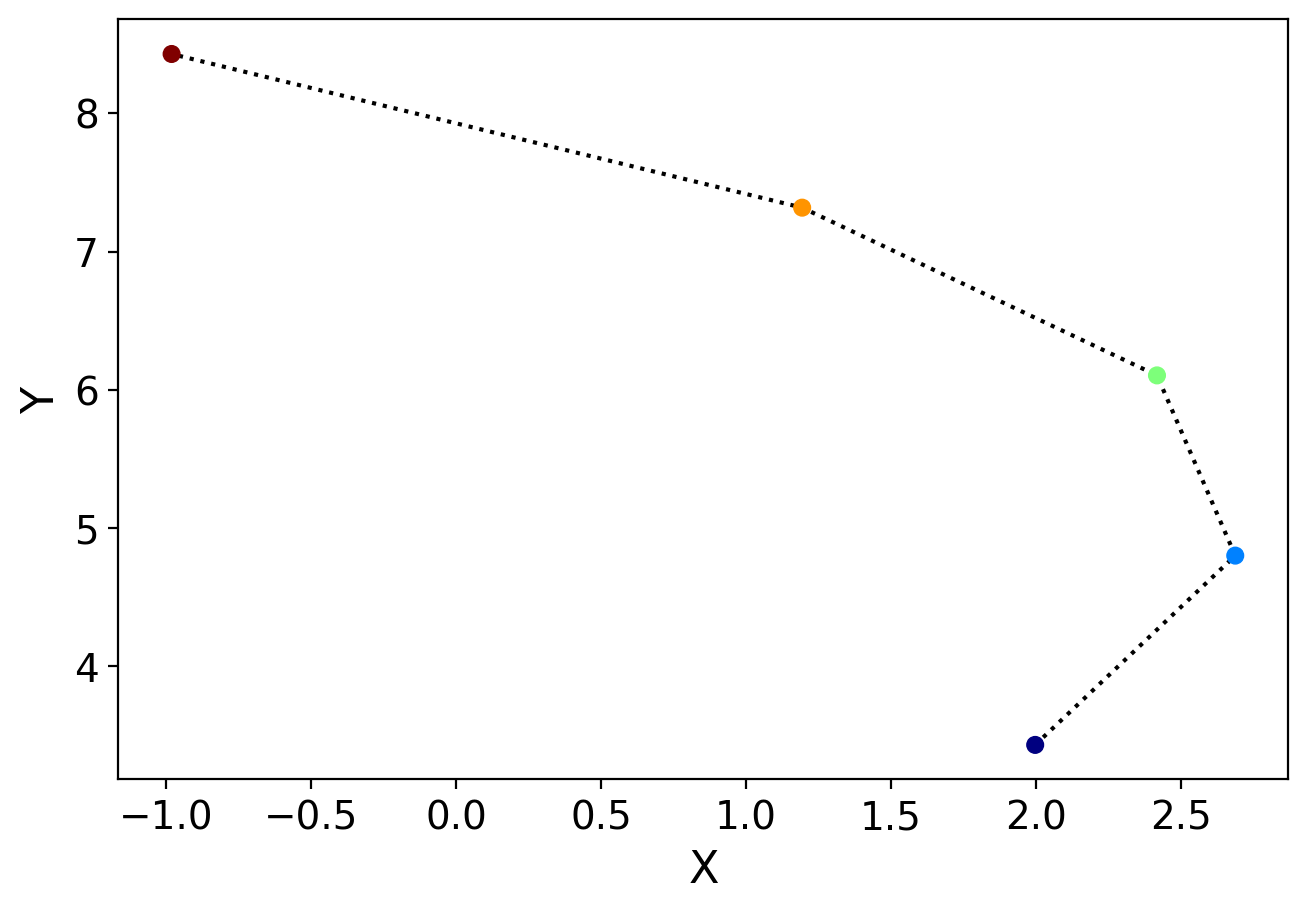

True


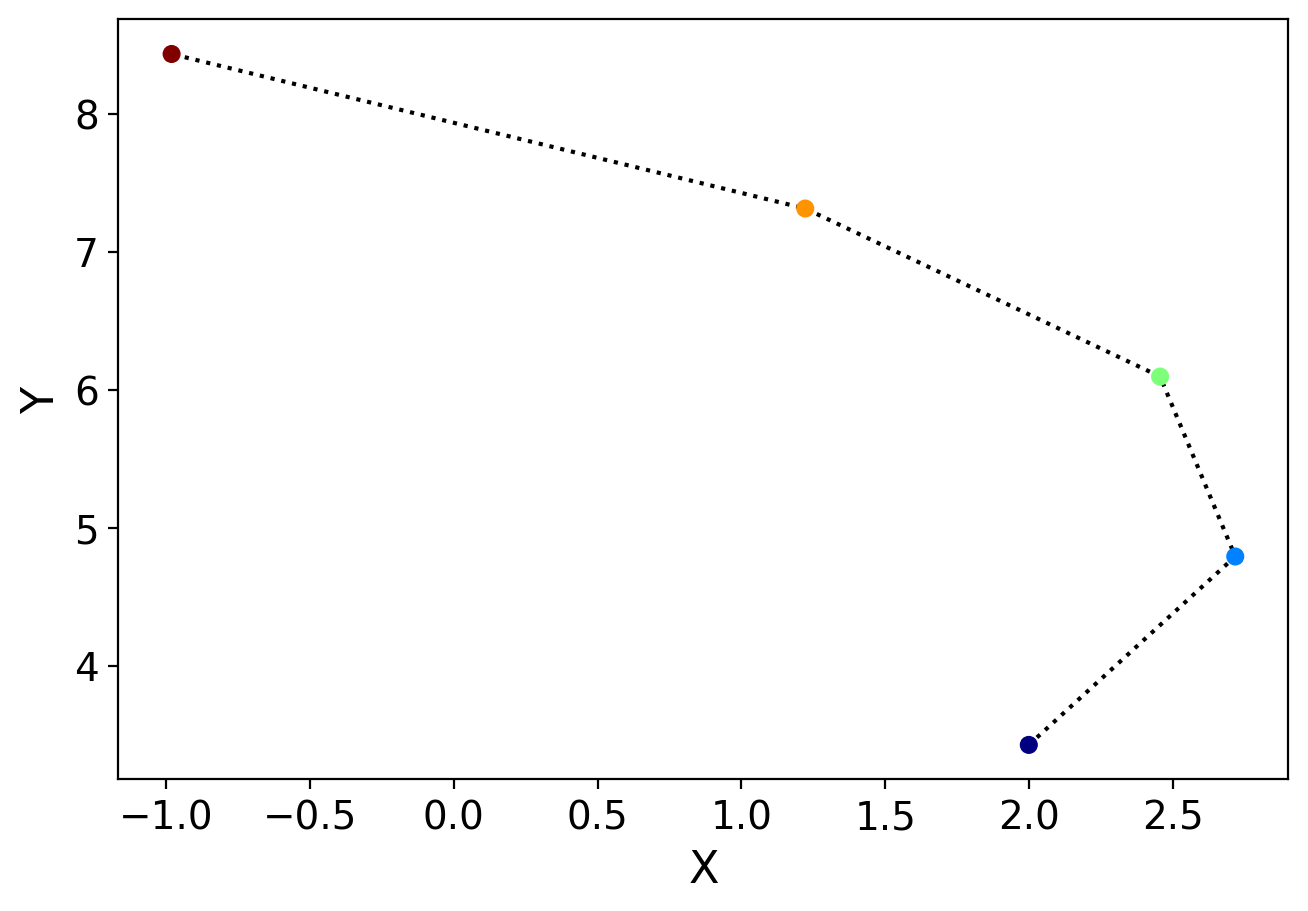

True


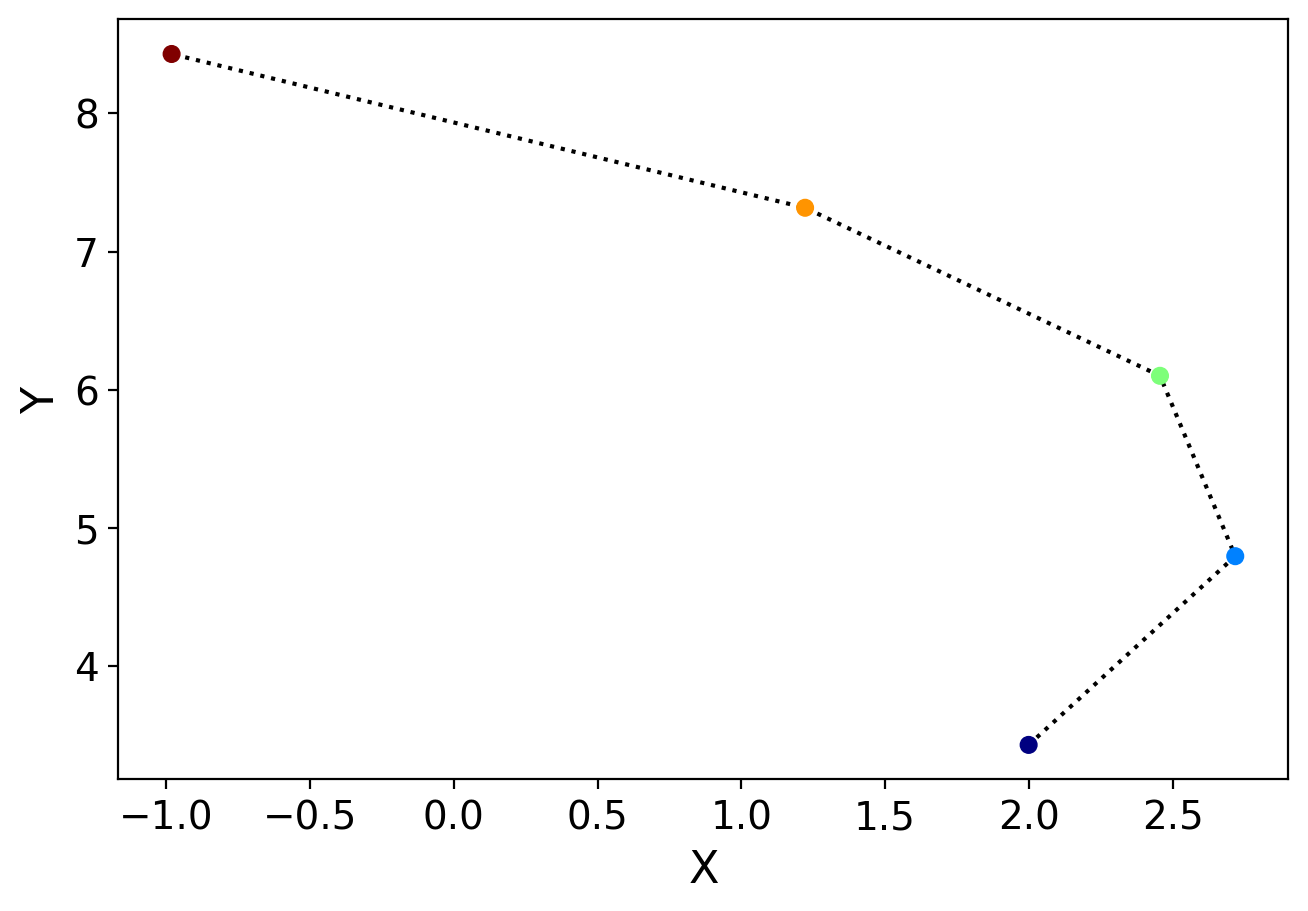

True


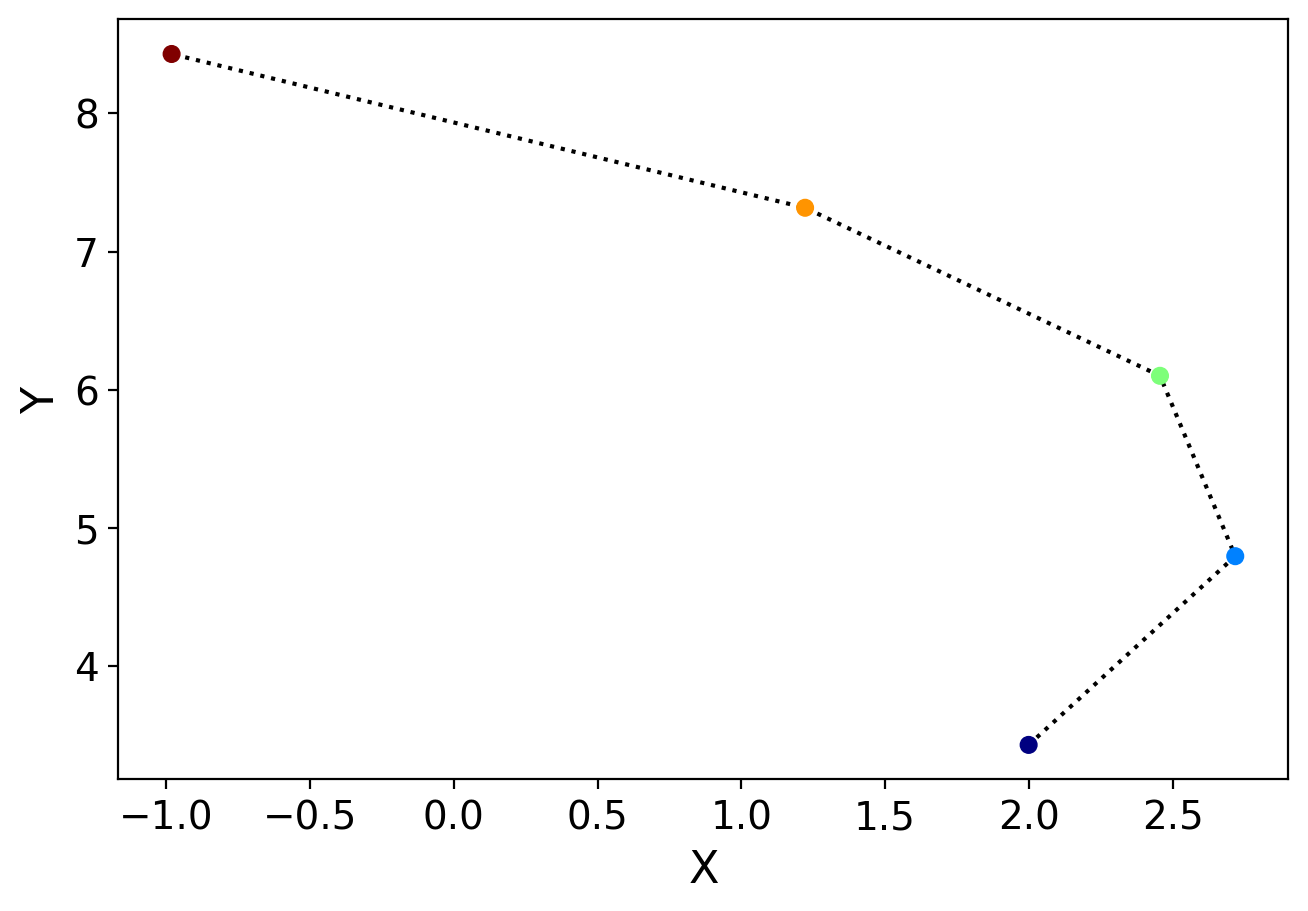

False
X0: 13


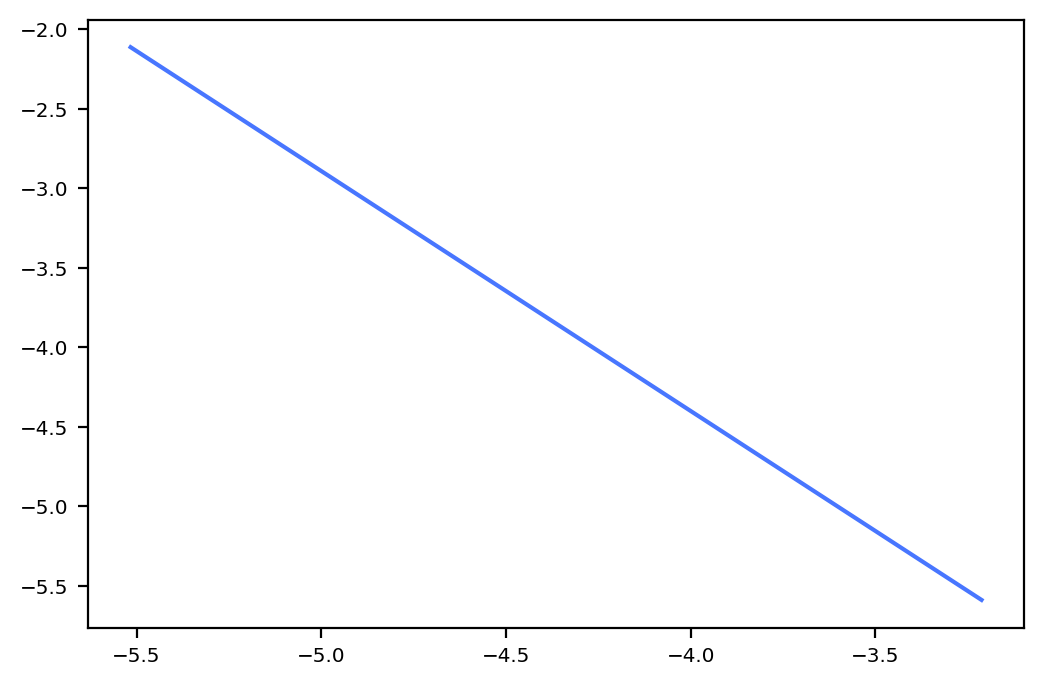

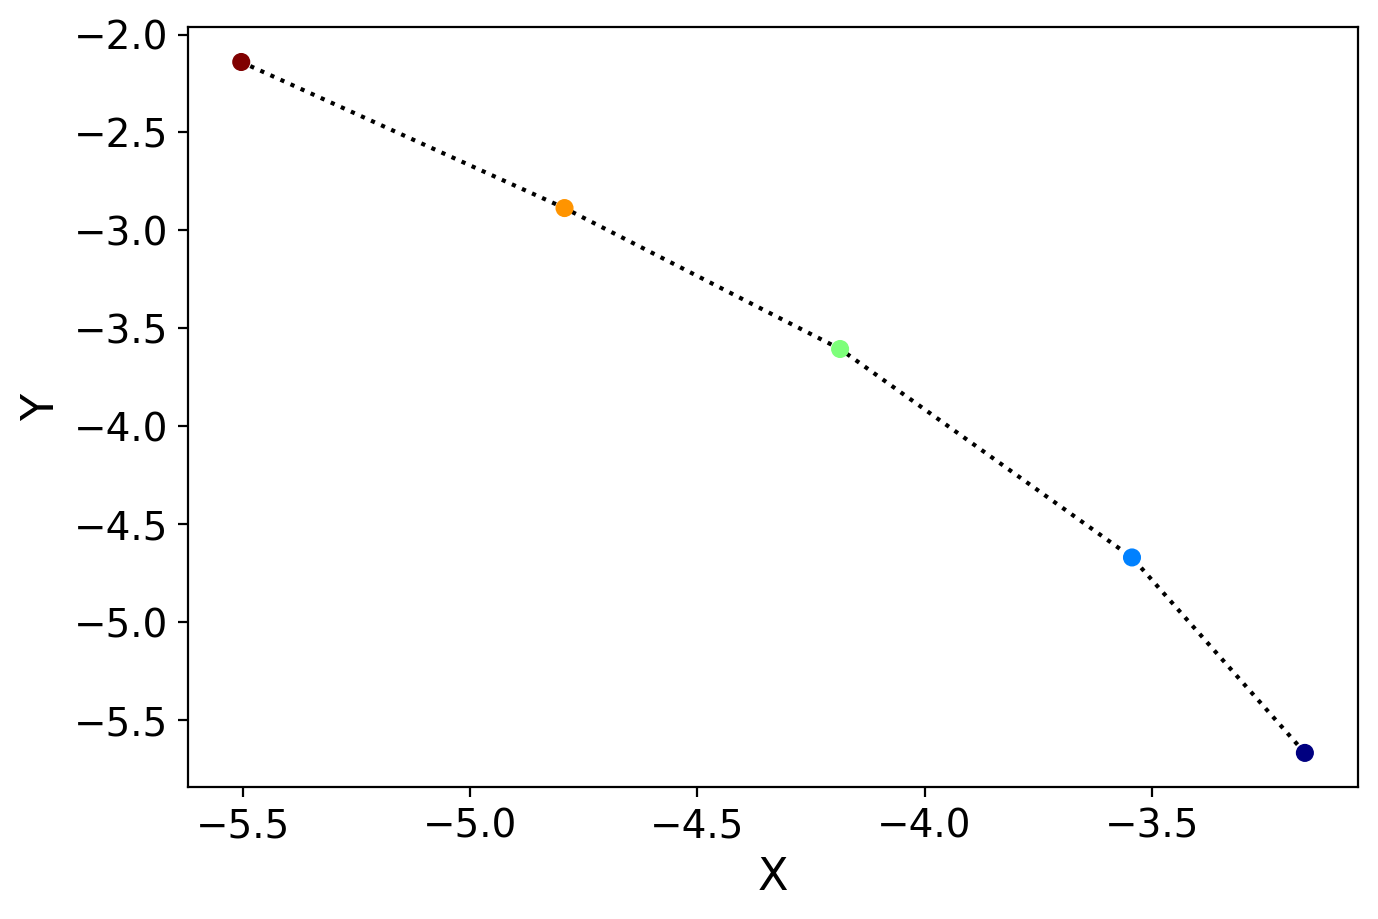

True


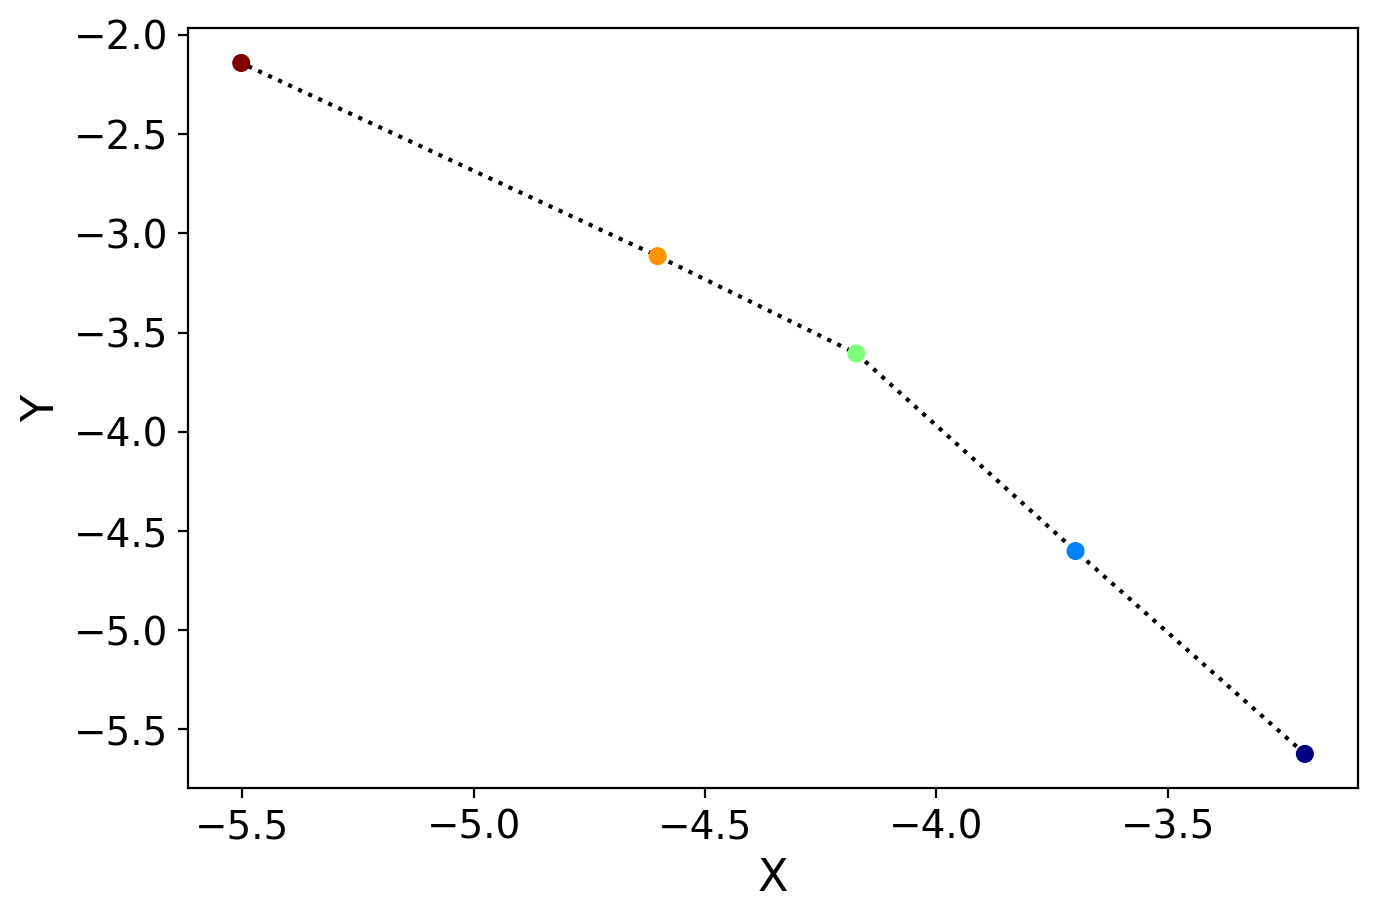

True


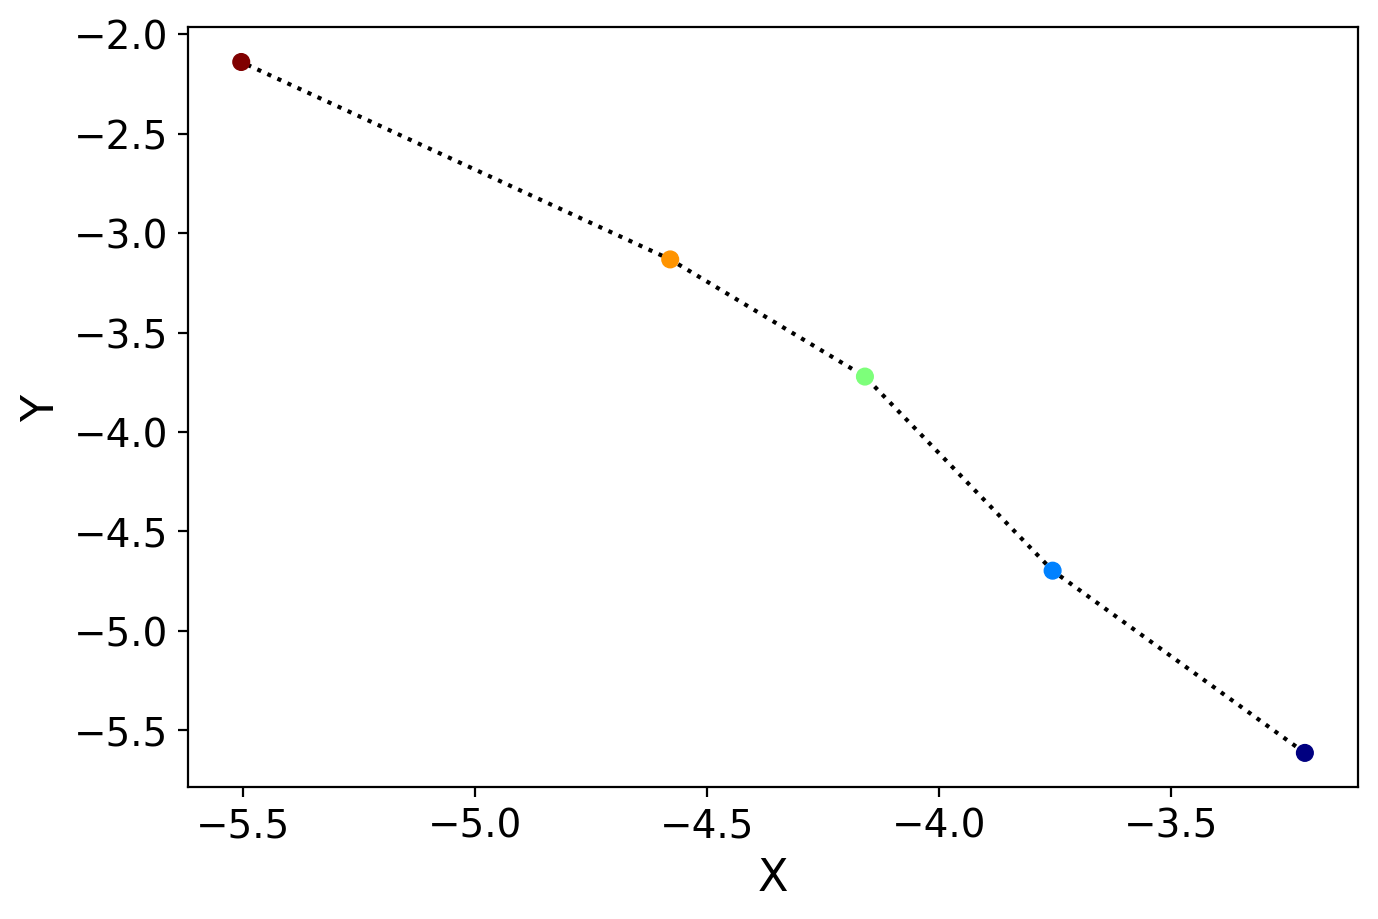

True


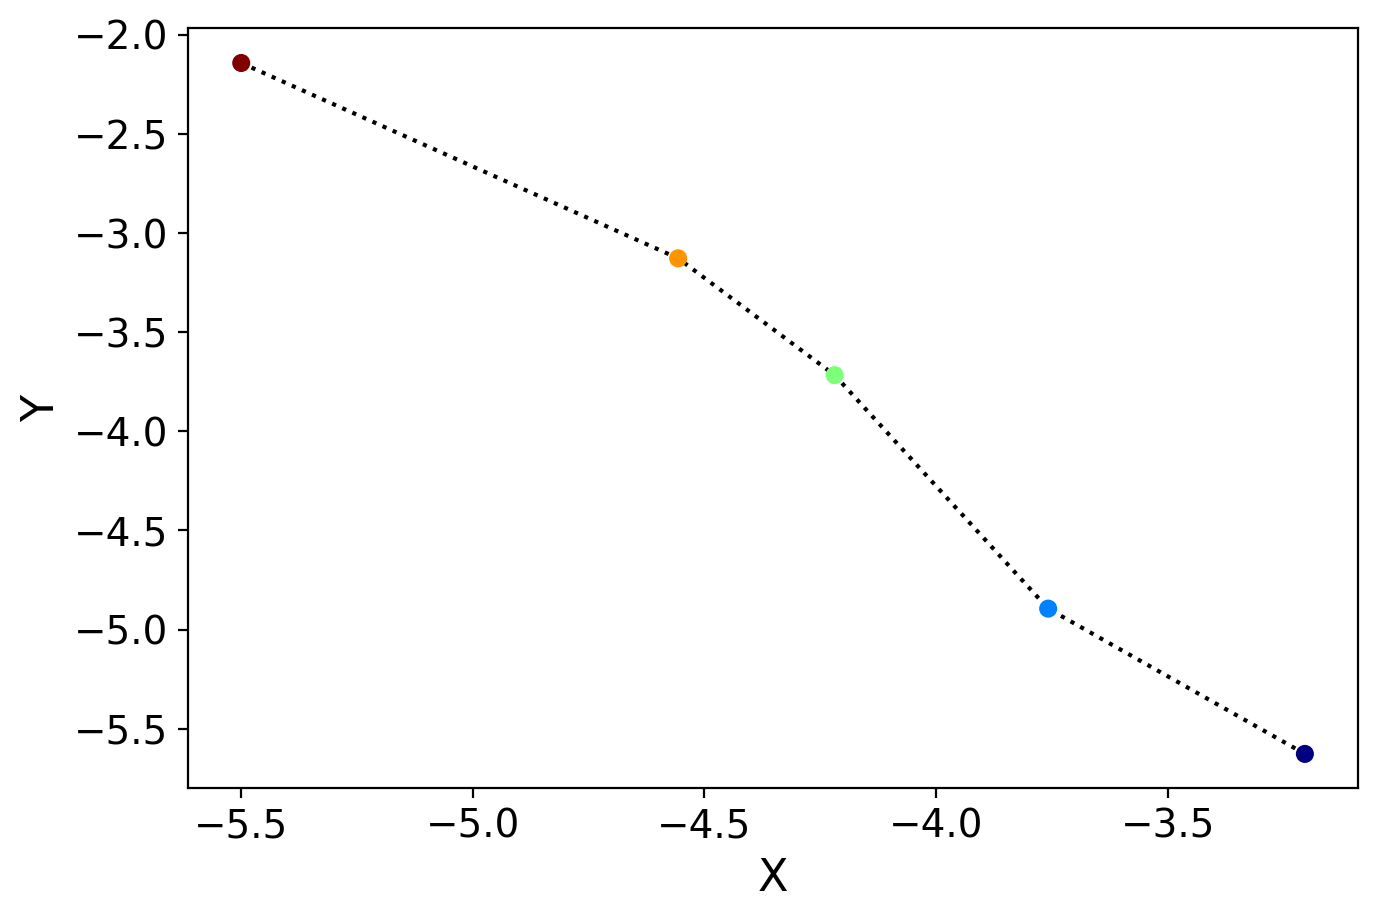

True


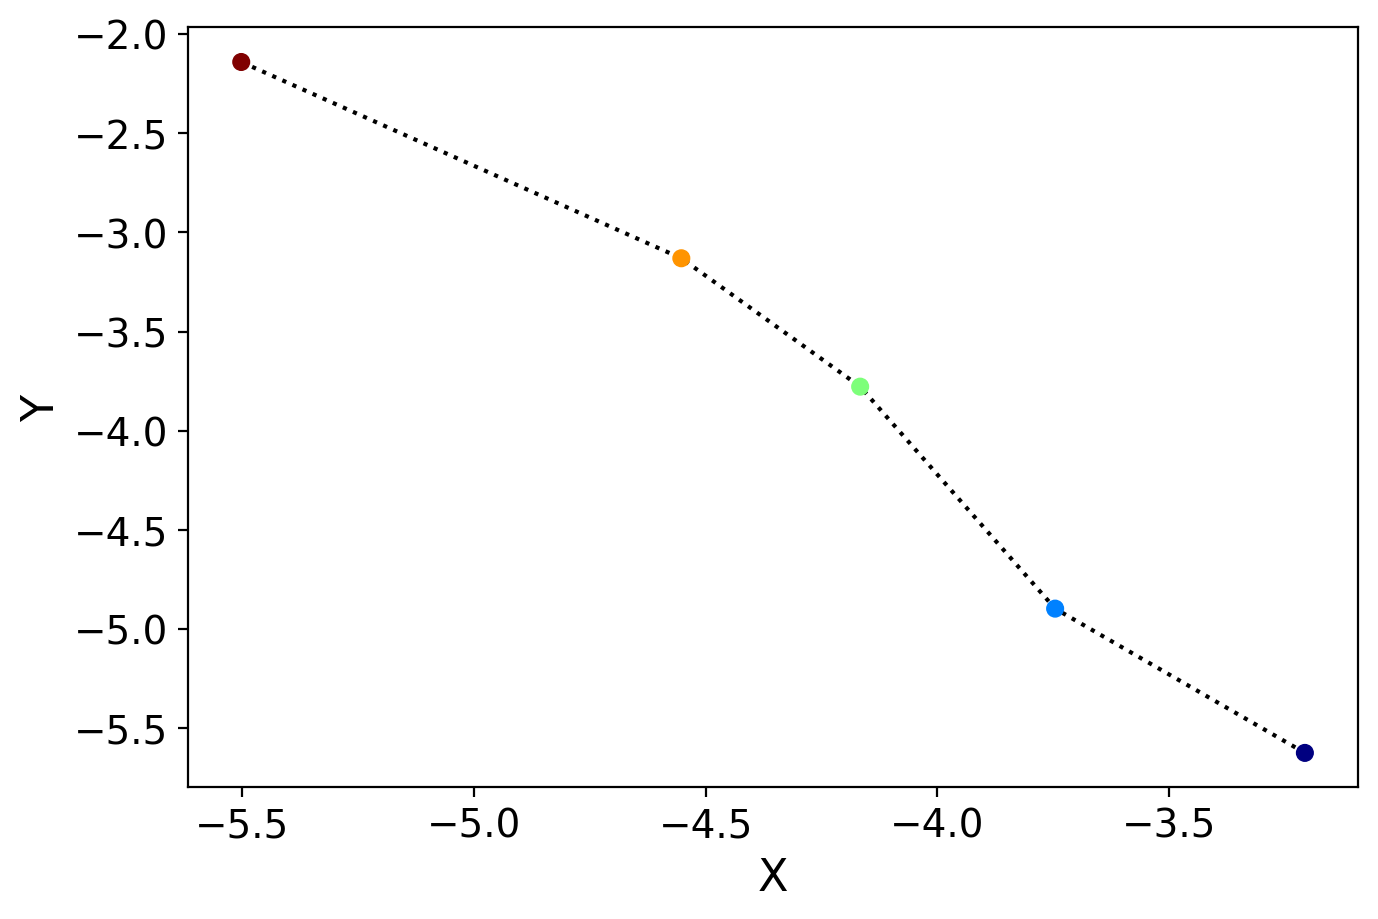

False
X0: 86


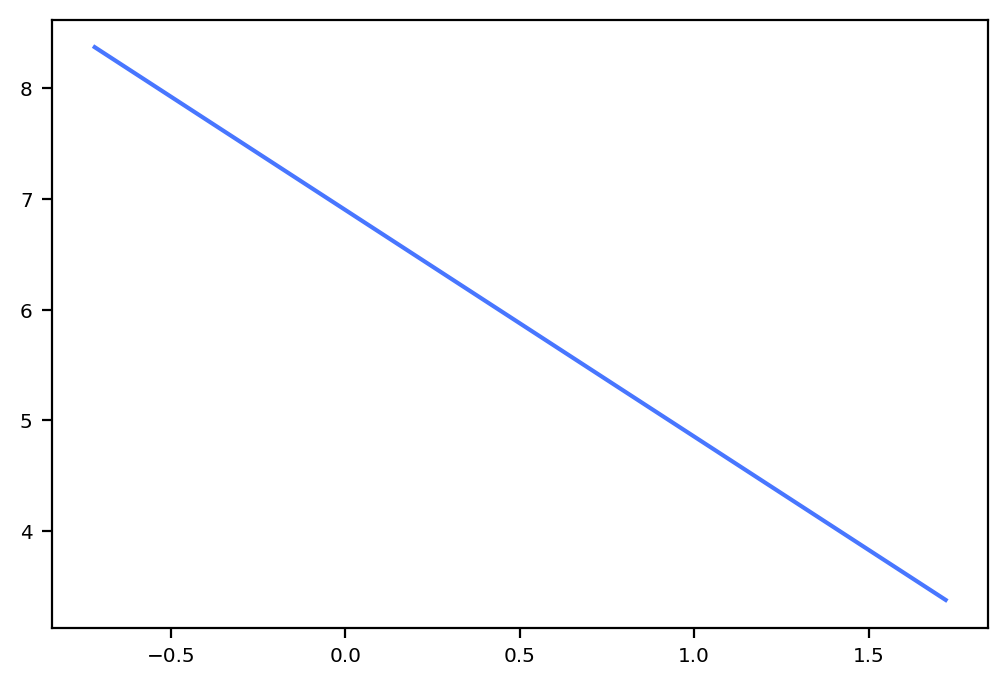

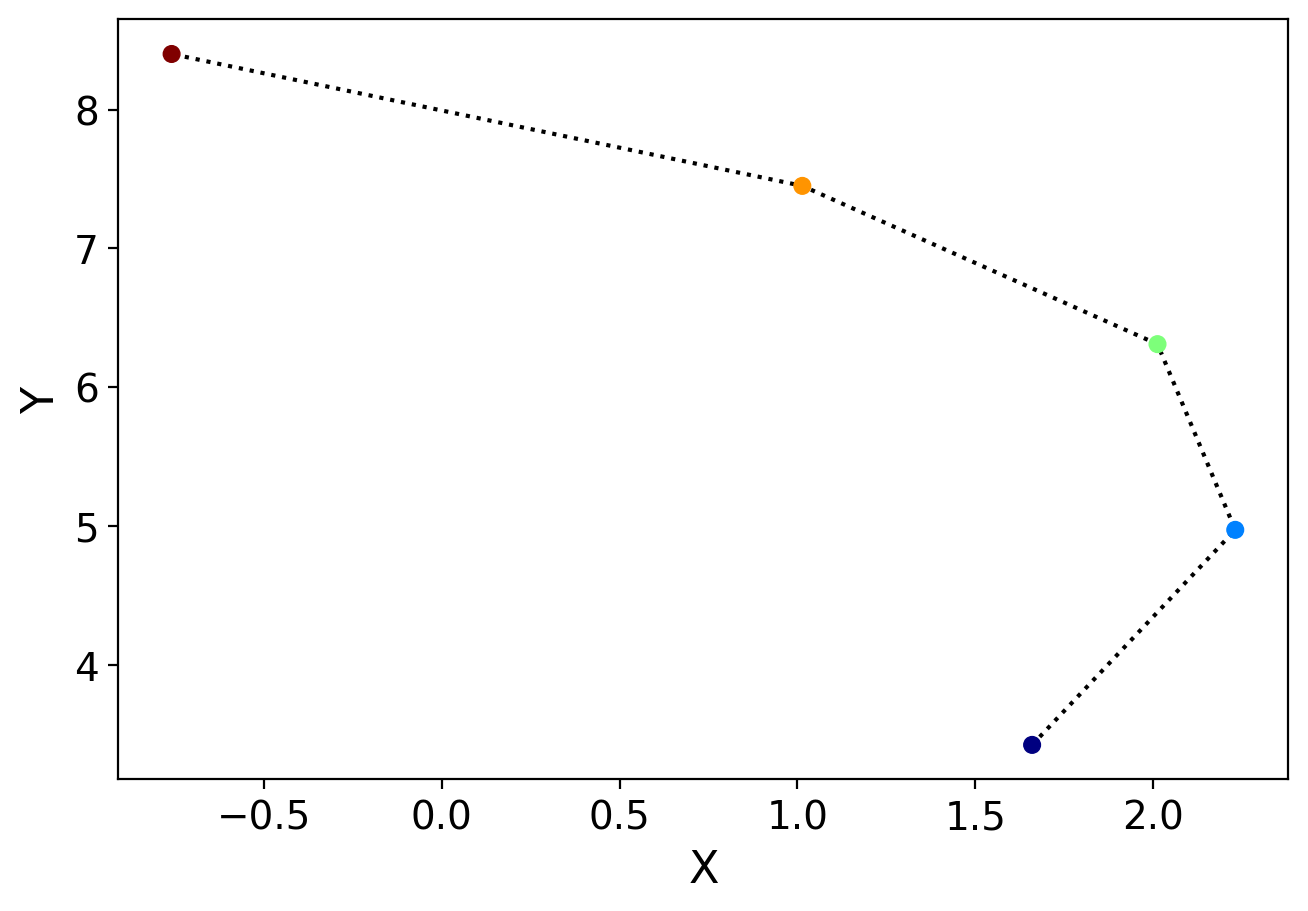

True


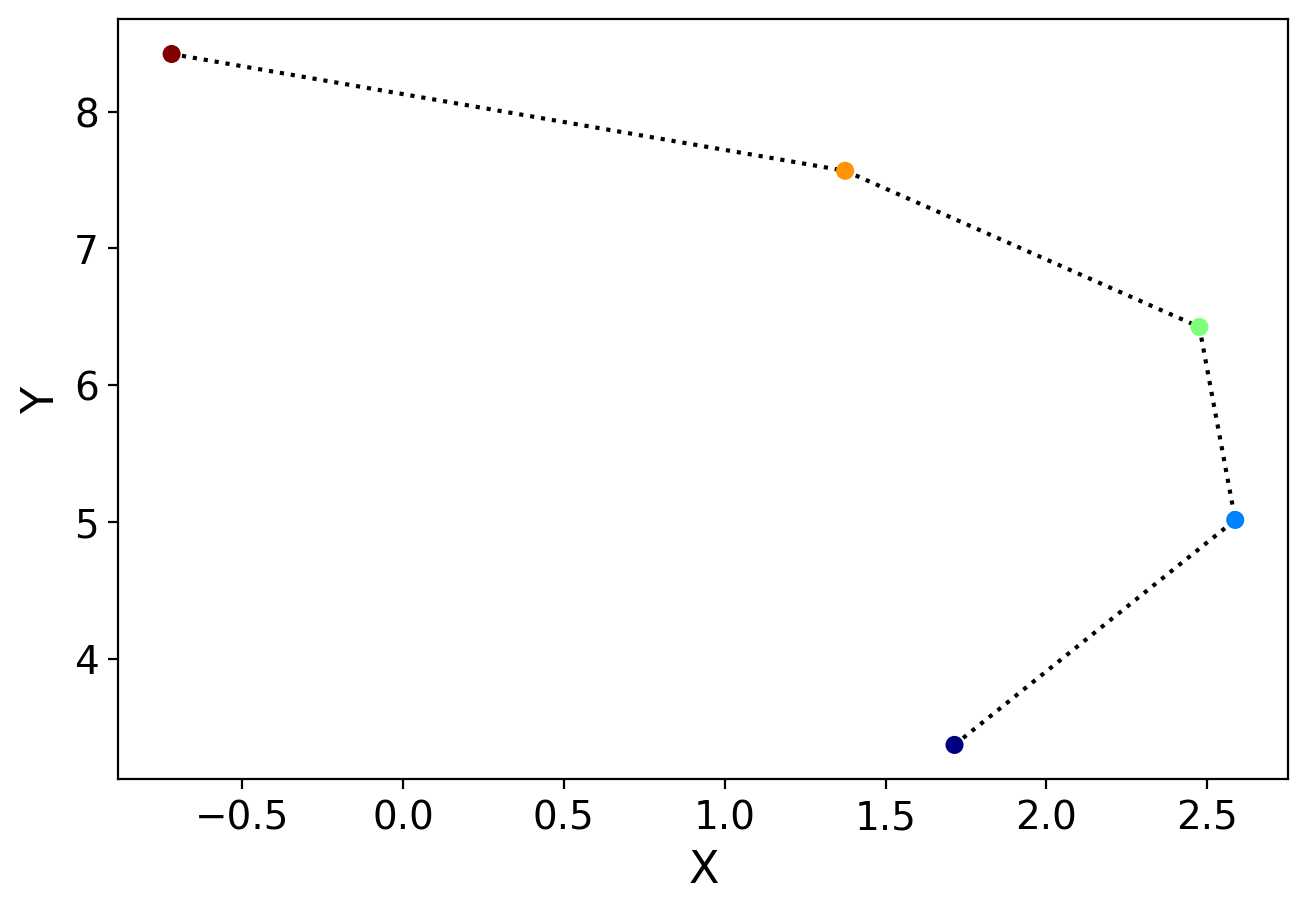

True


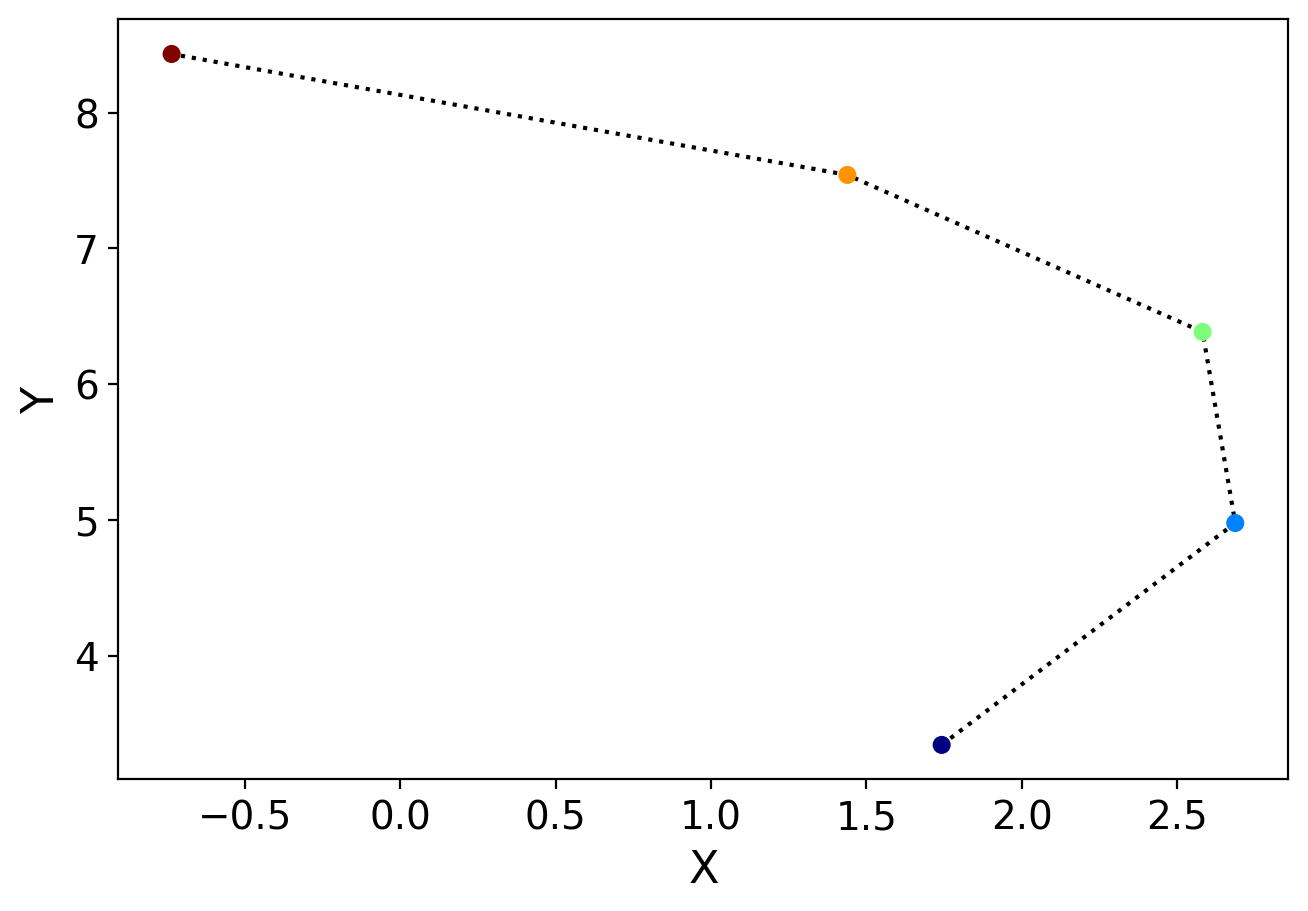

True


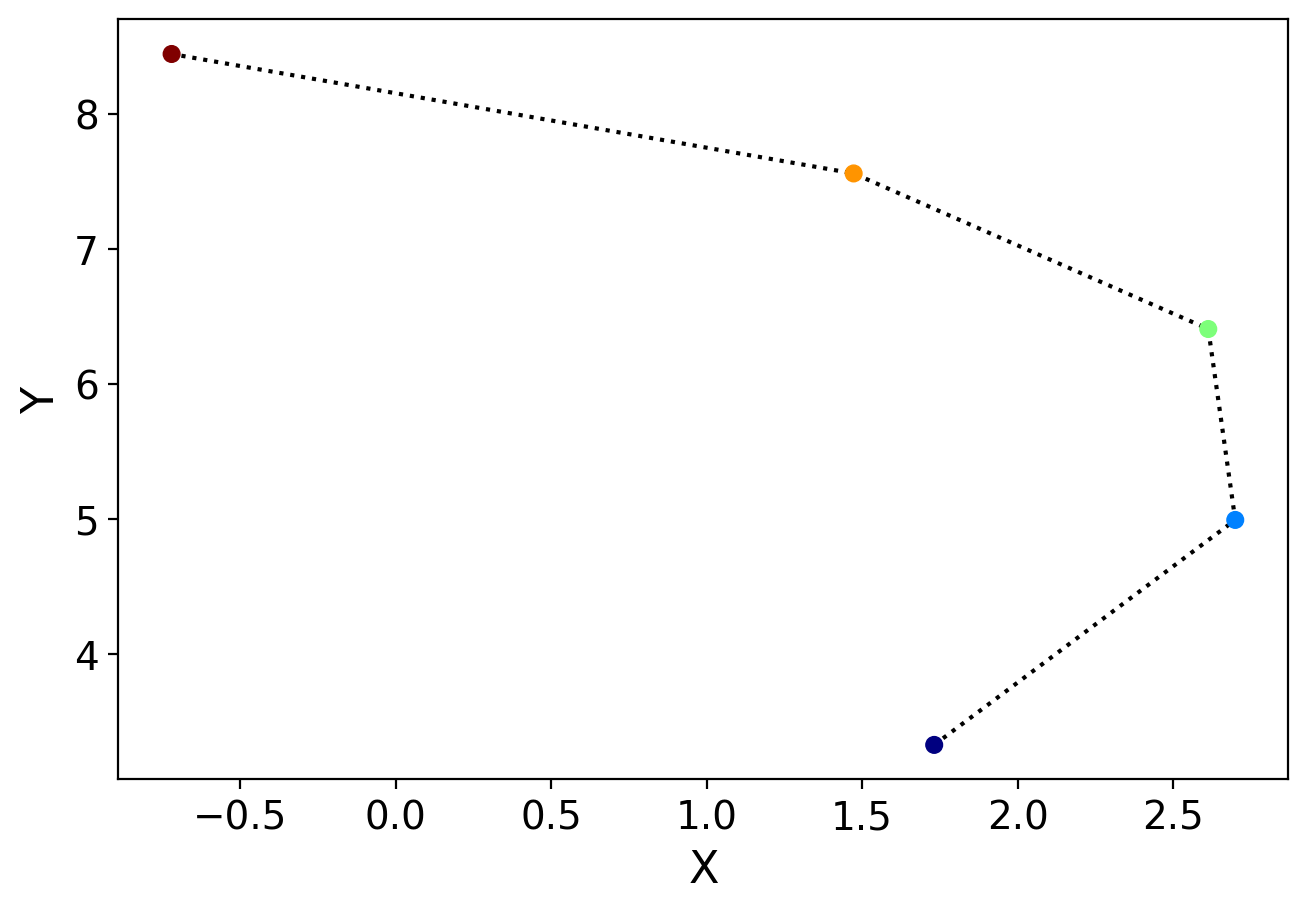

True


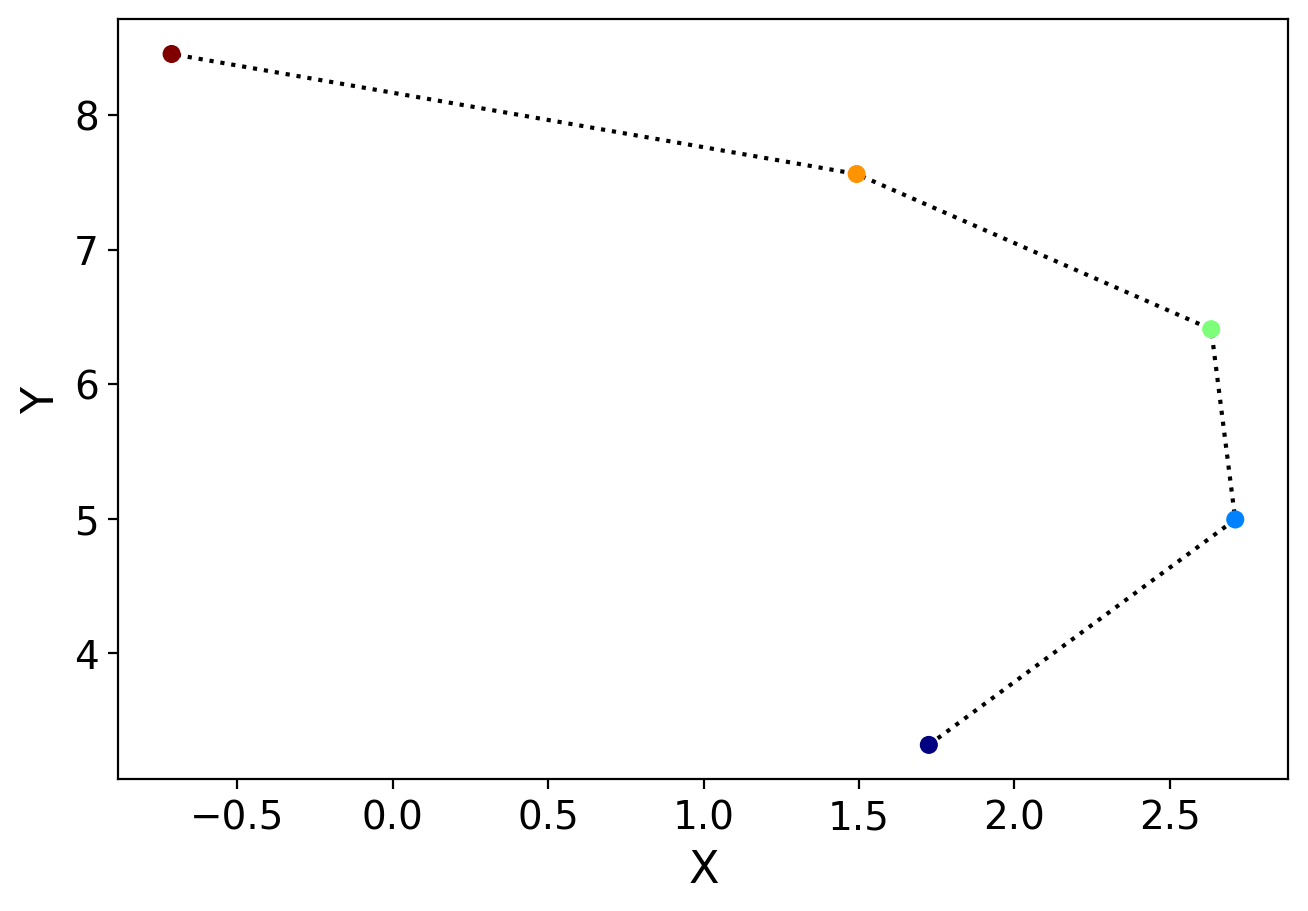

False
X0: 14


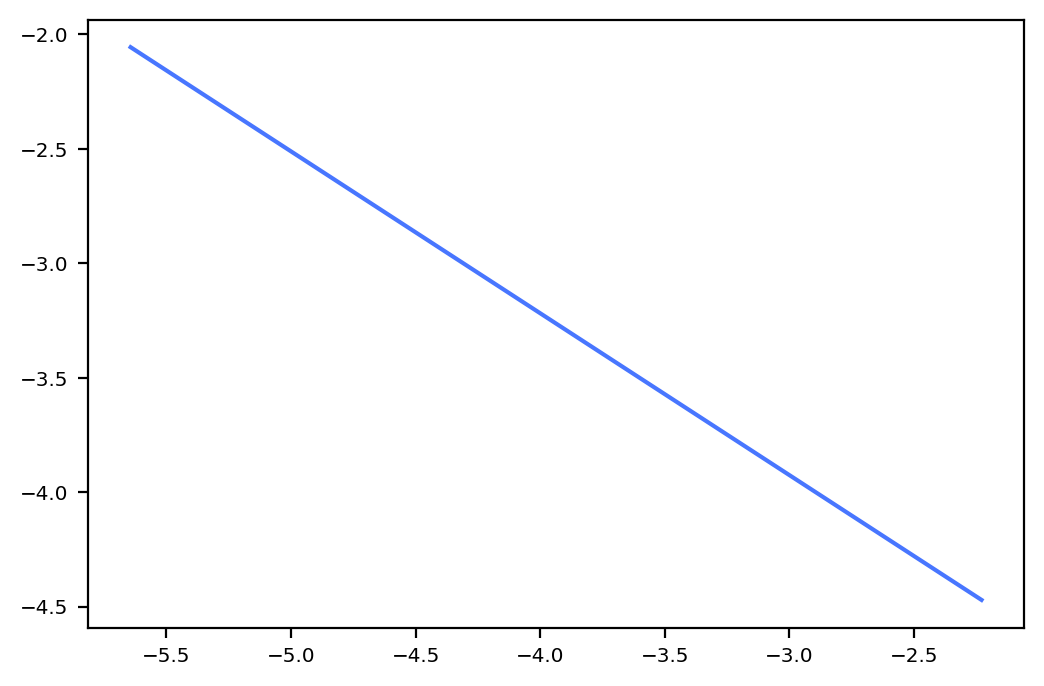

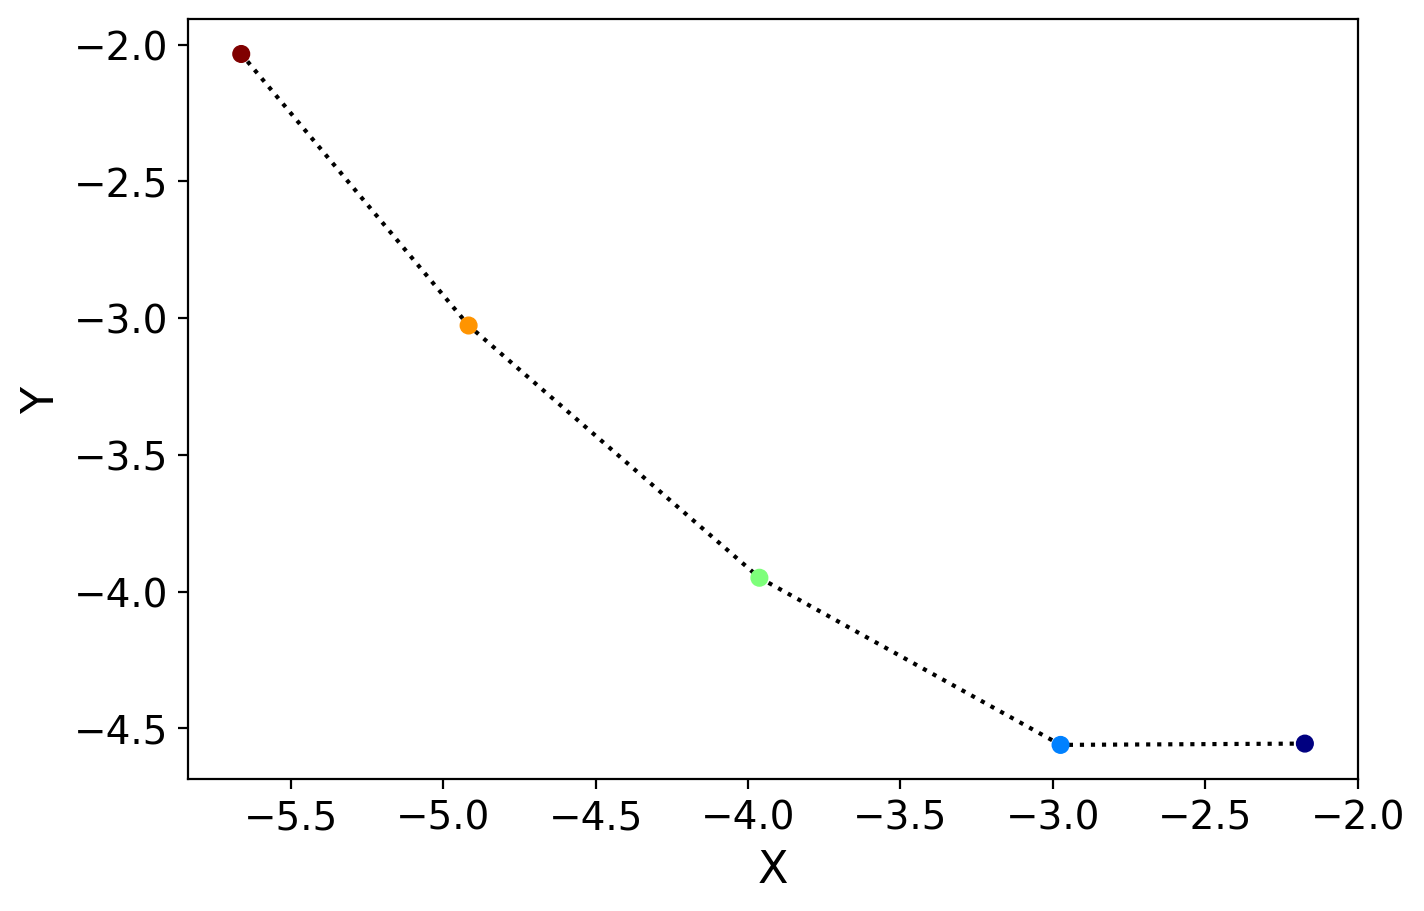

True


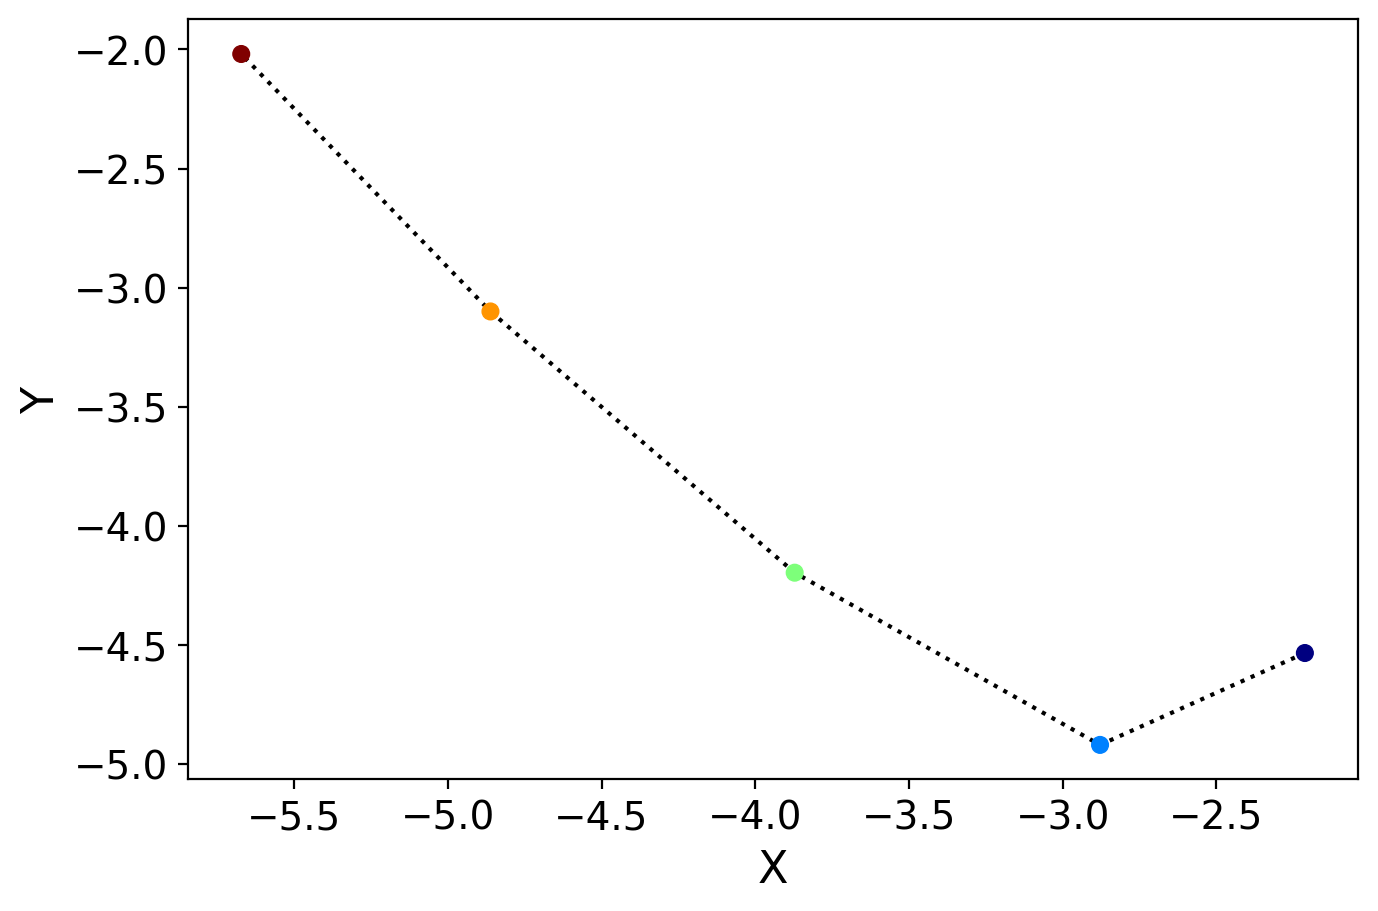

True


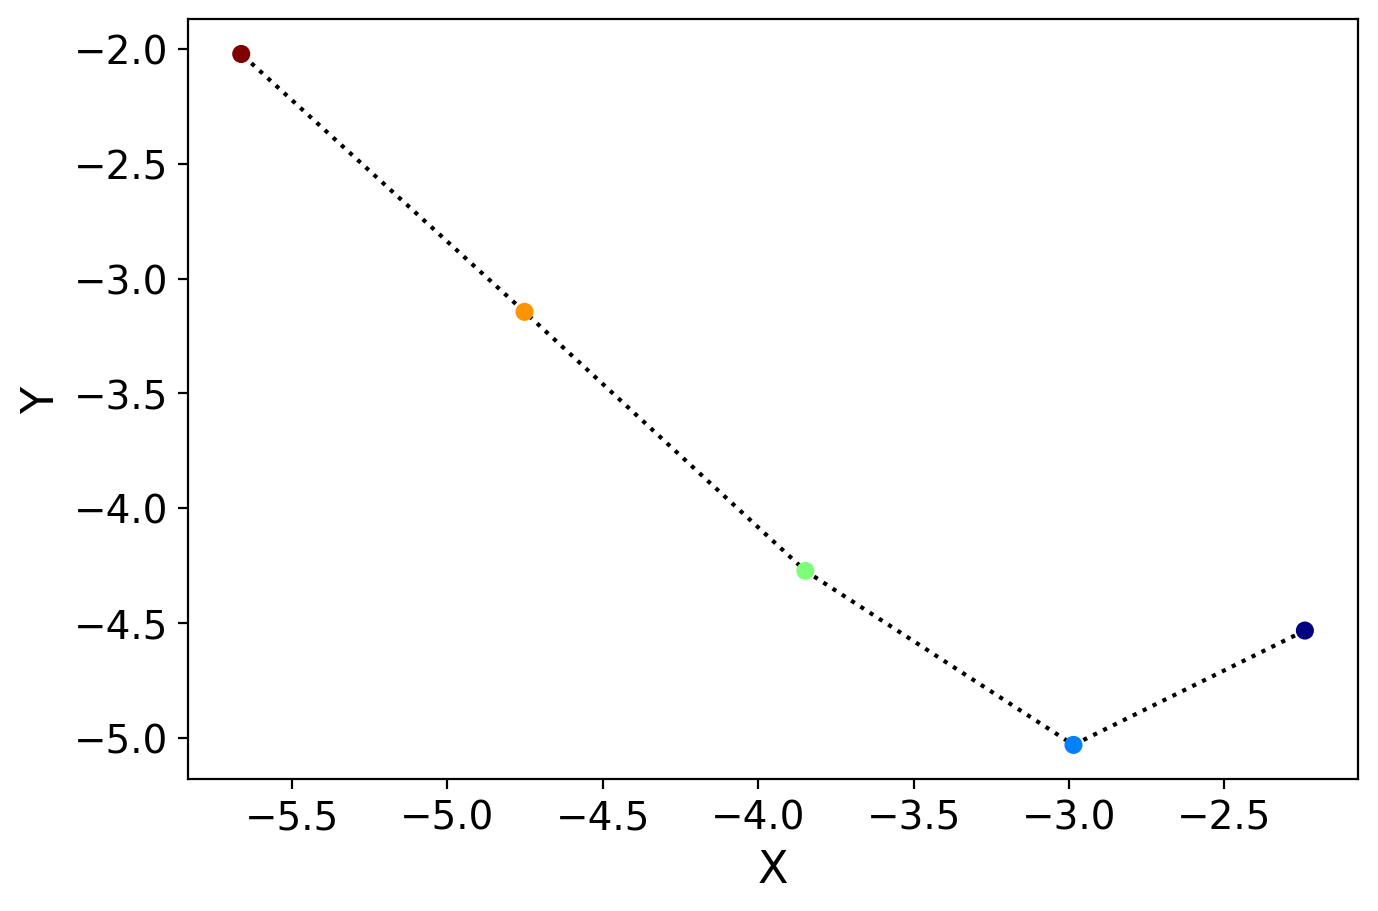

True


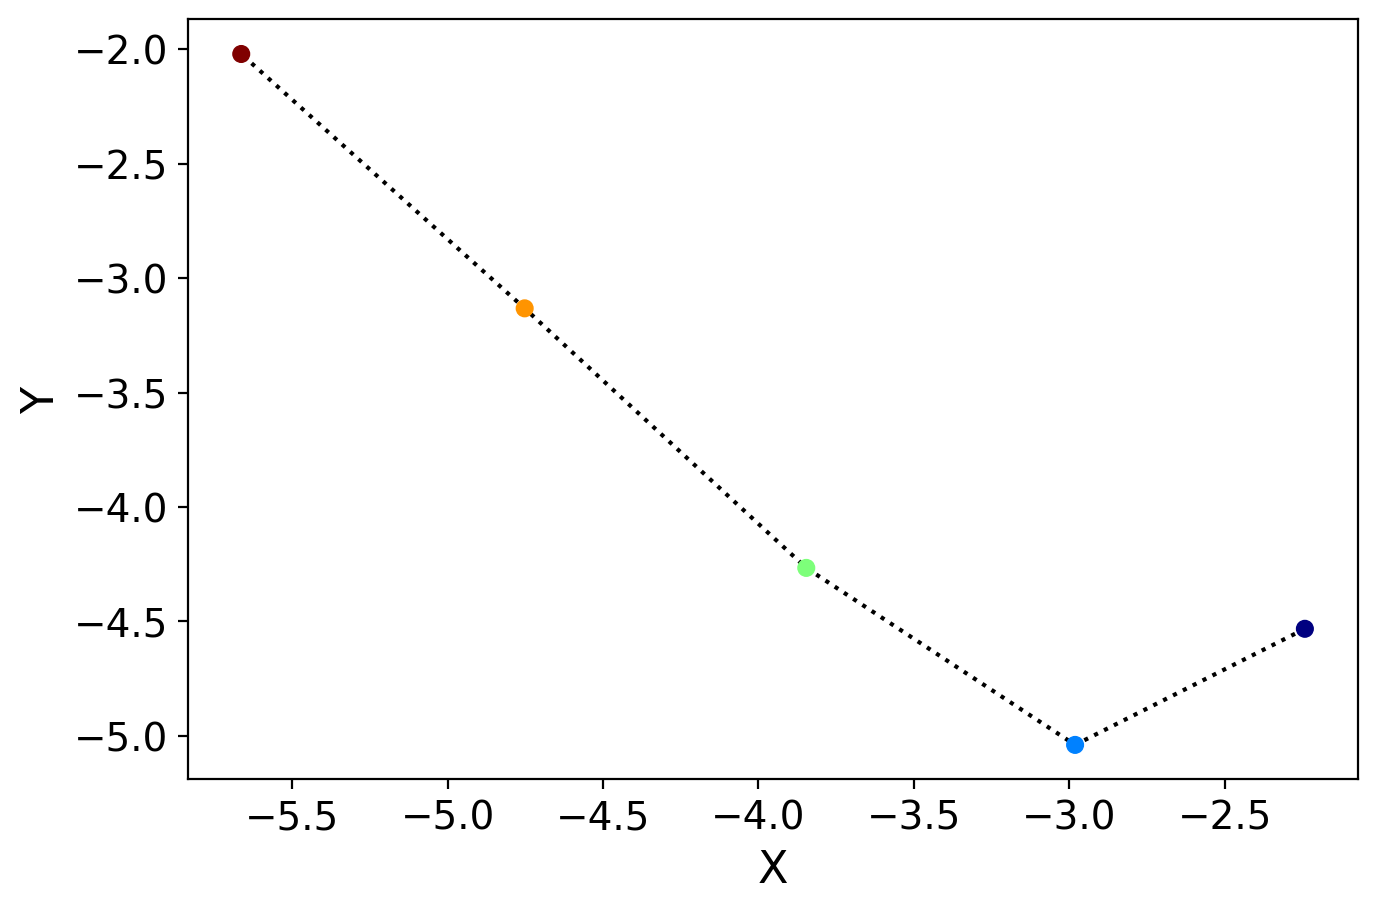

True


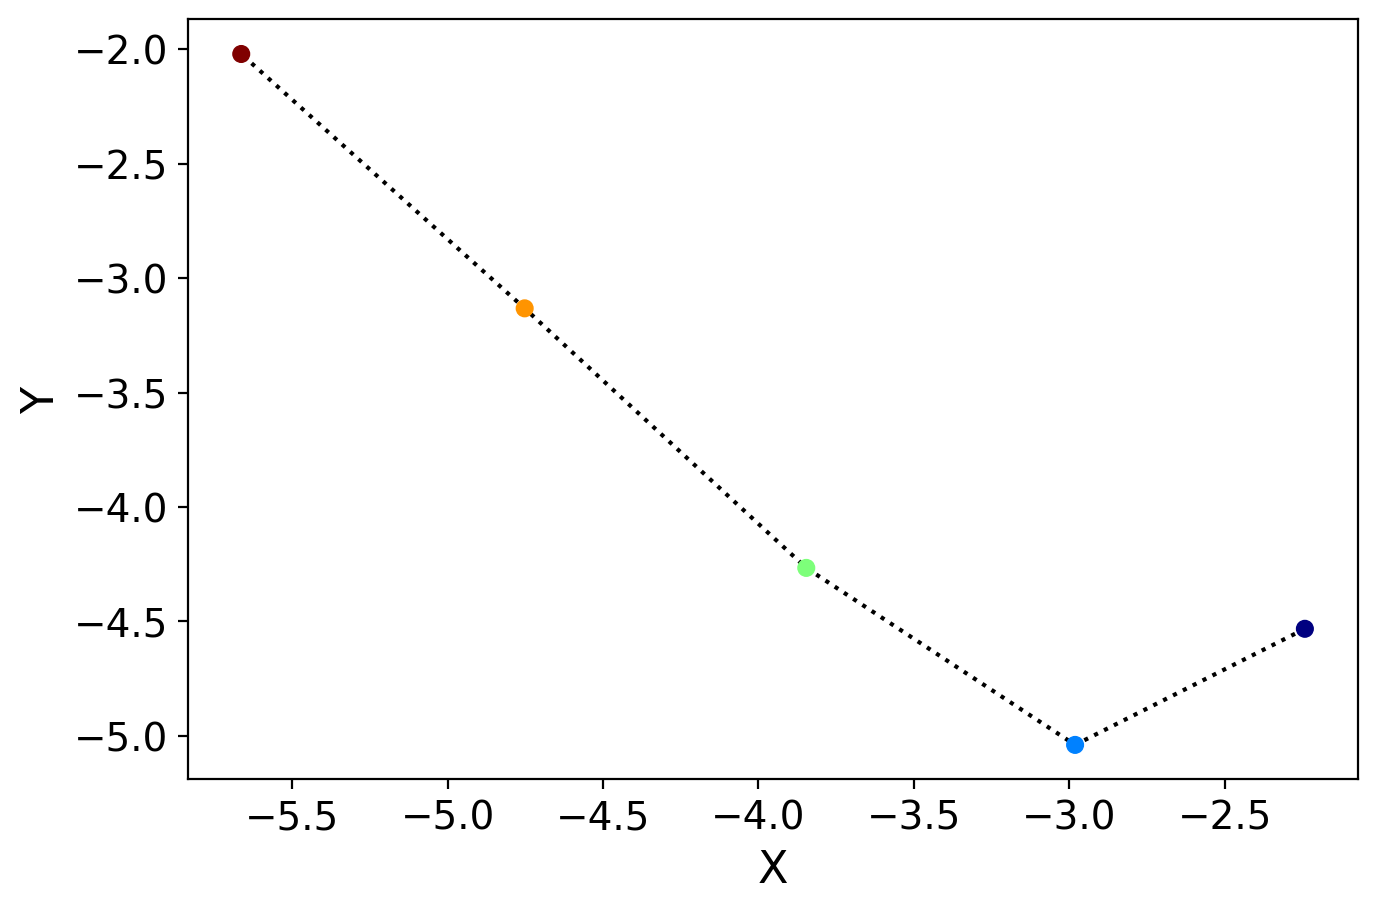

False
X0: 15


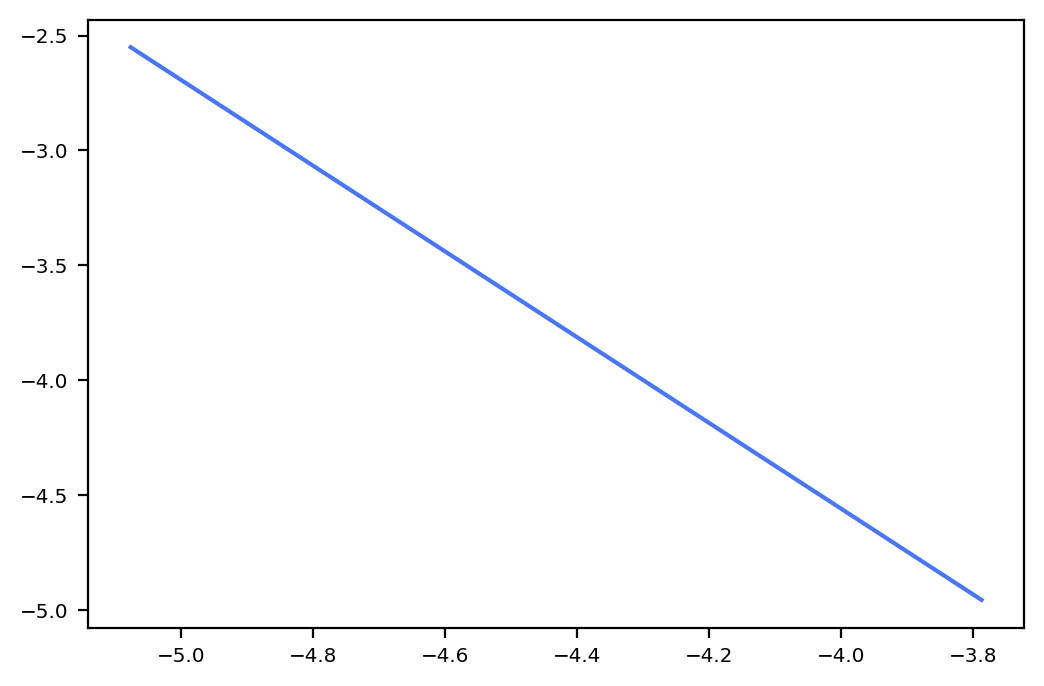

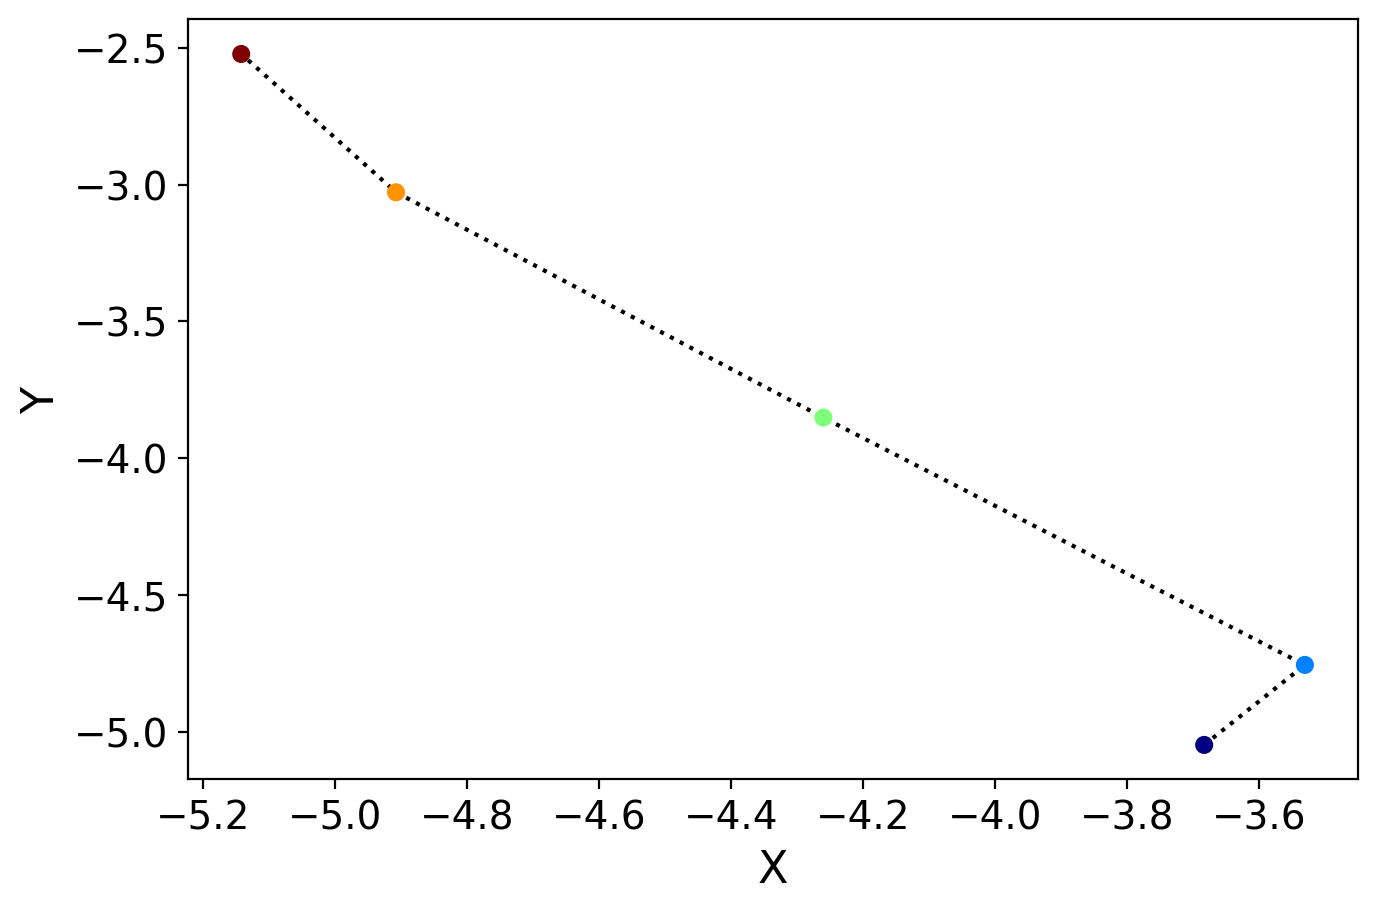

True


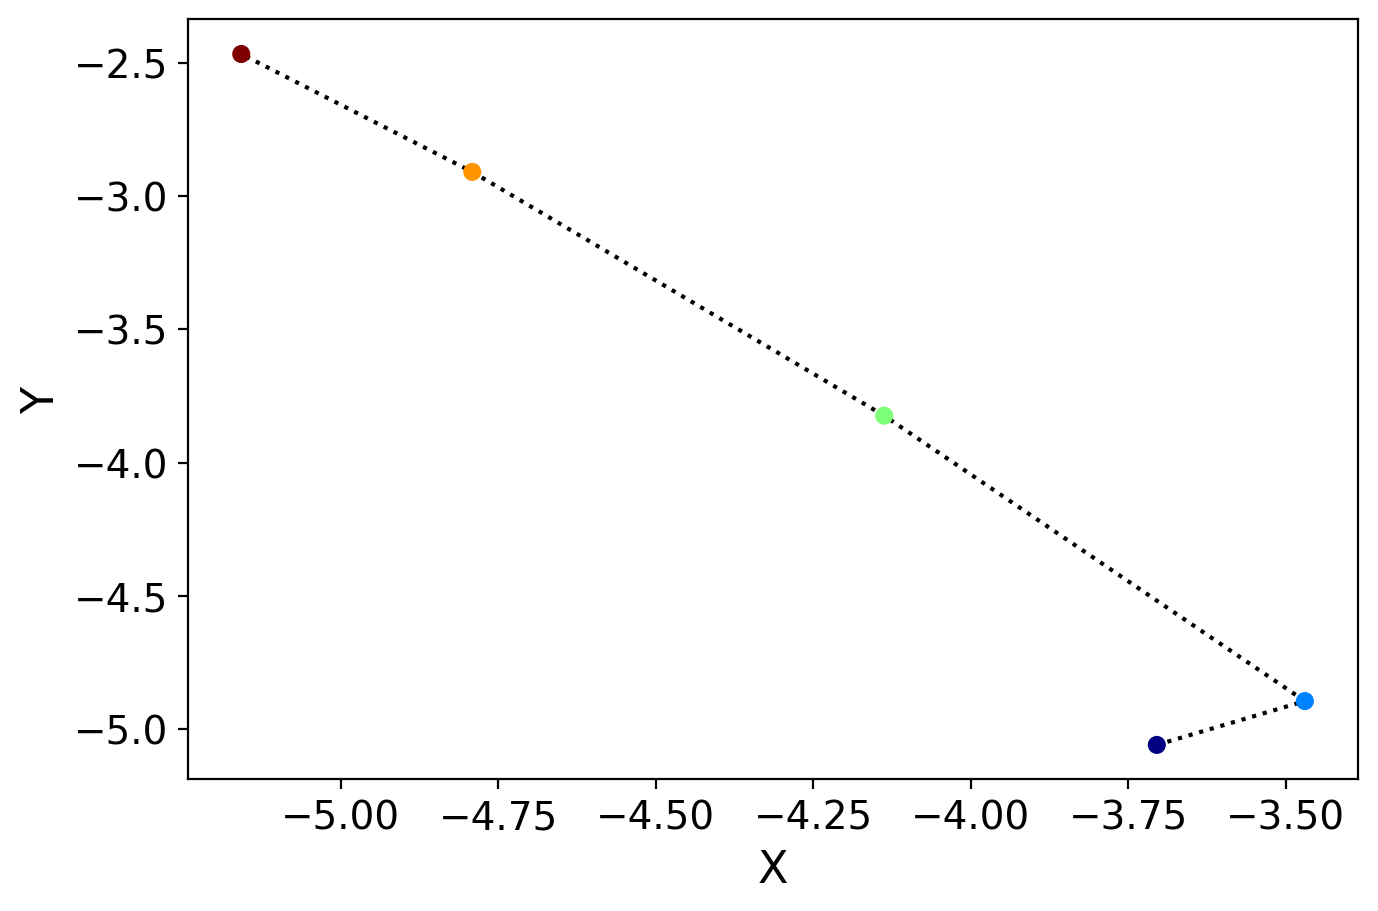

True


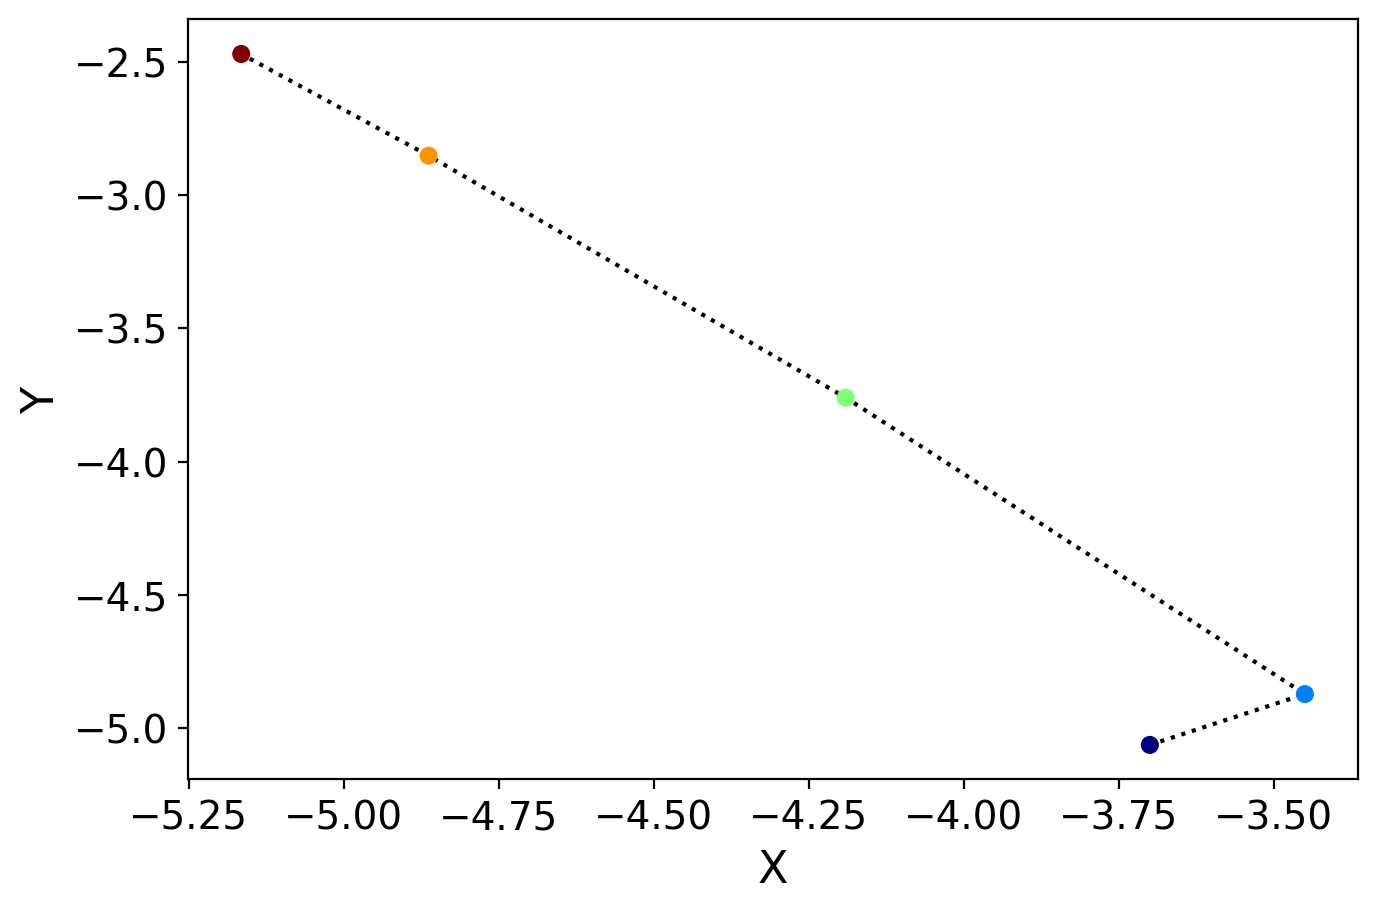

False
X0: 85


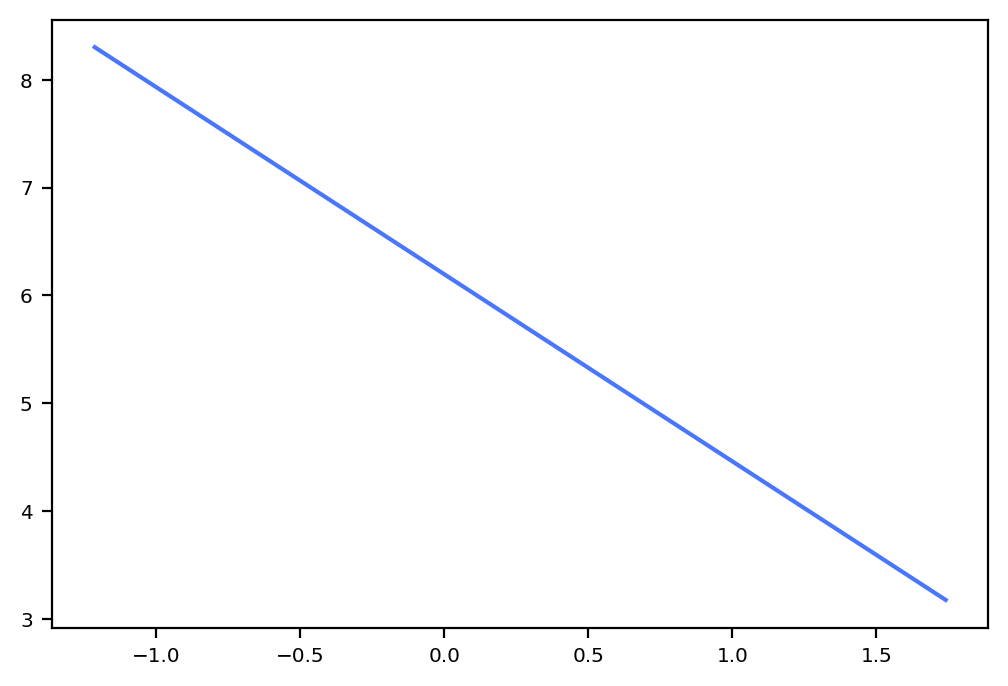

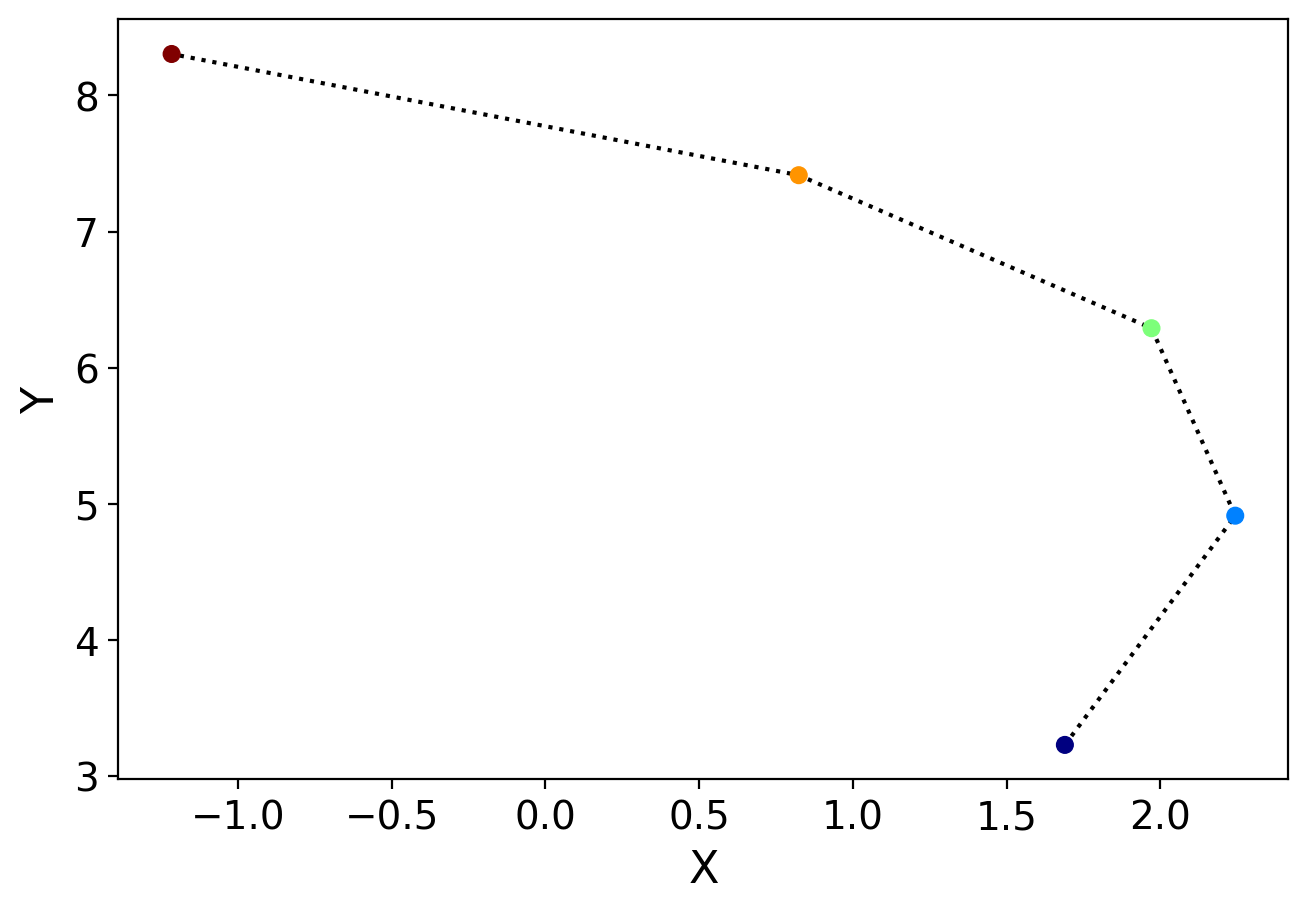

True


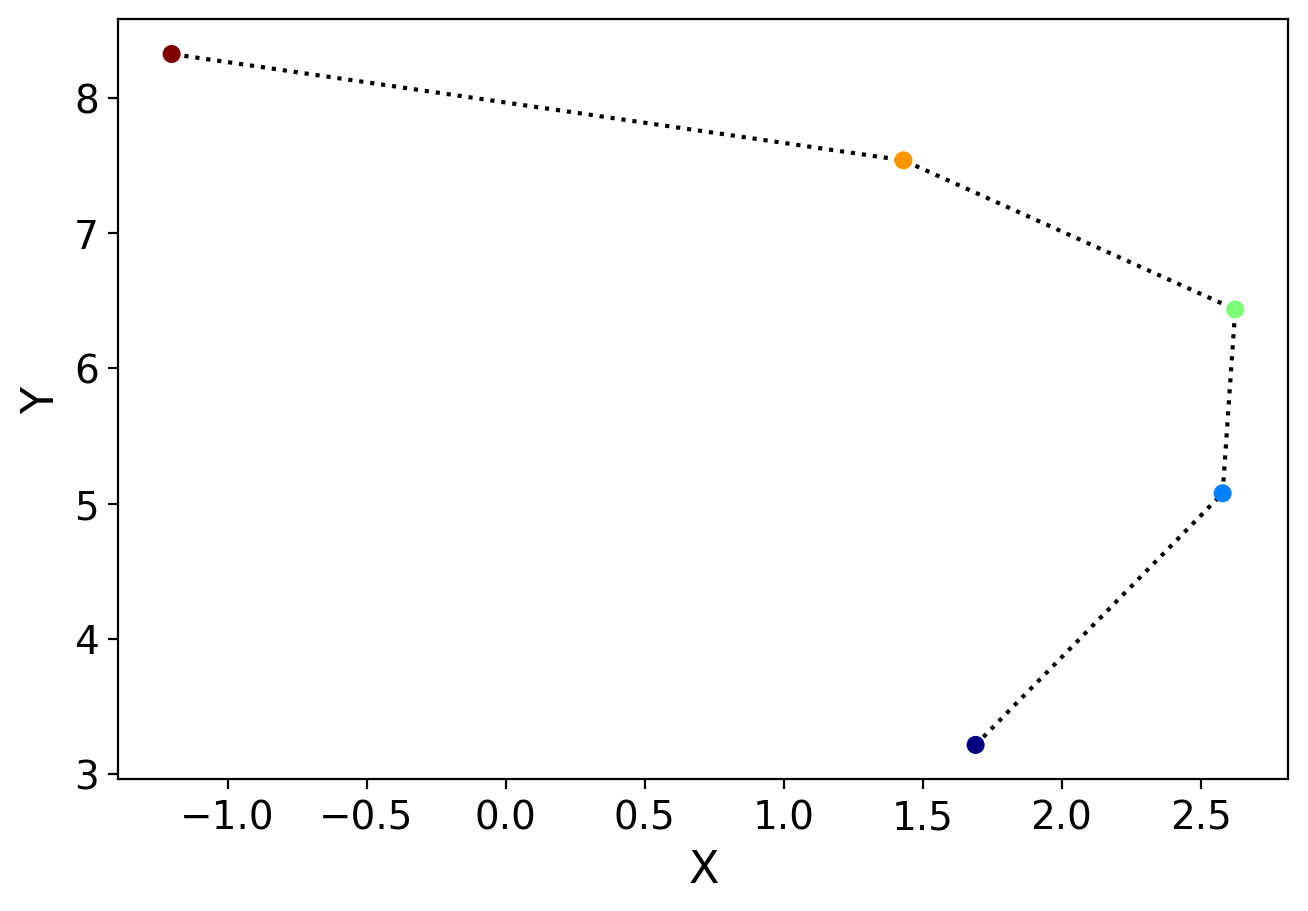

True


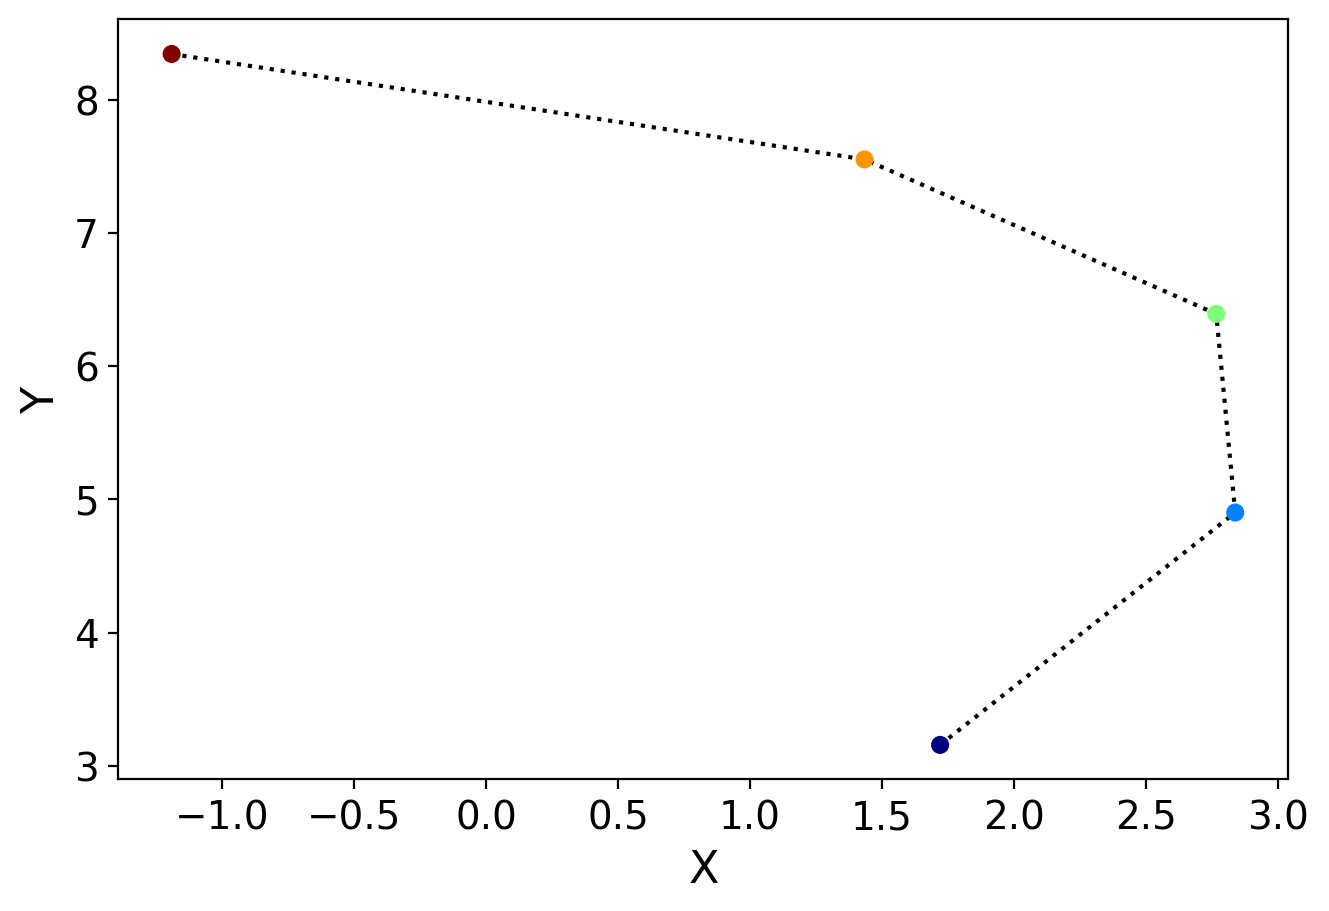

True


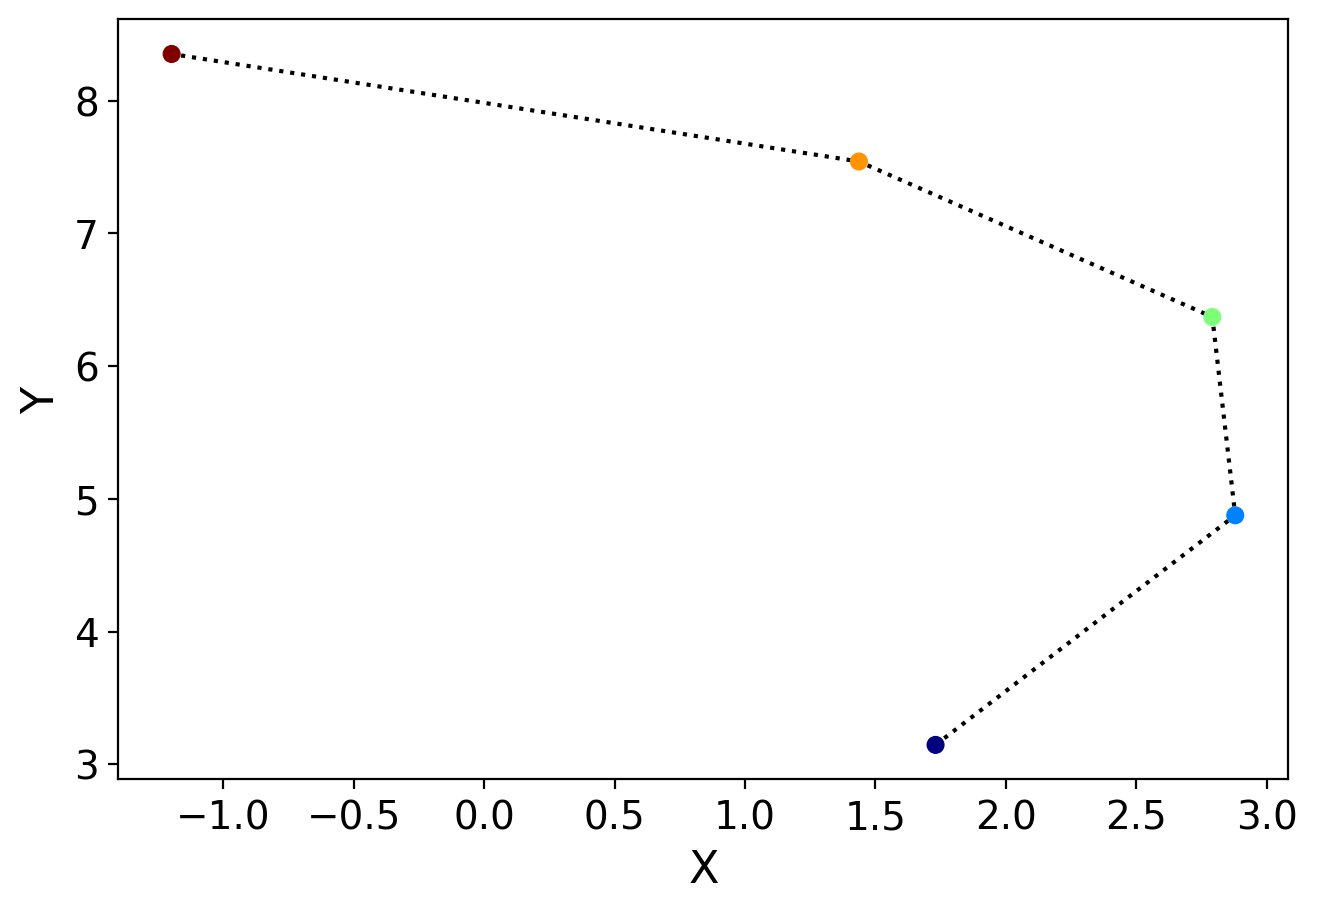

True


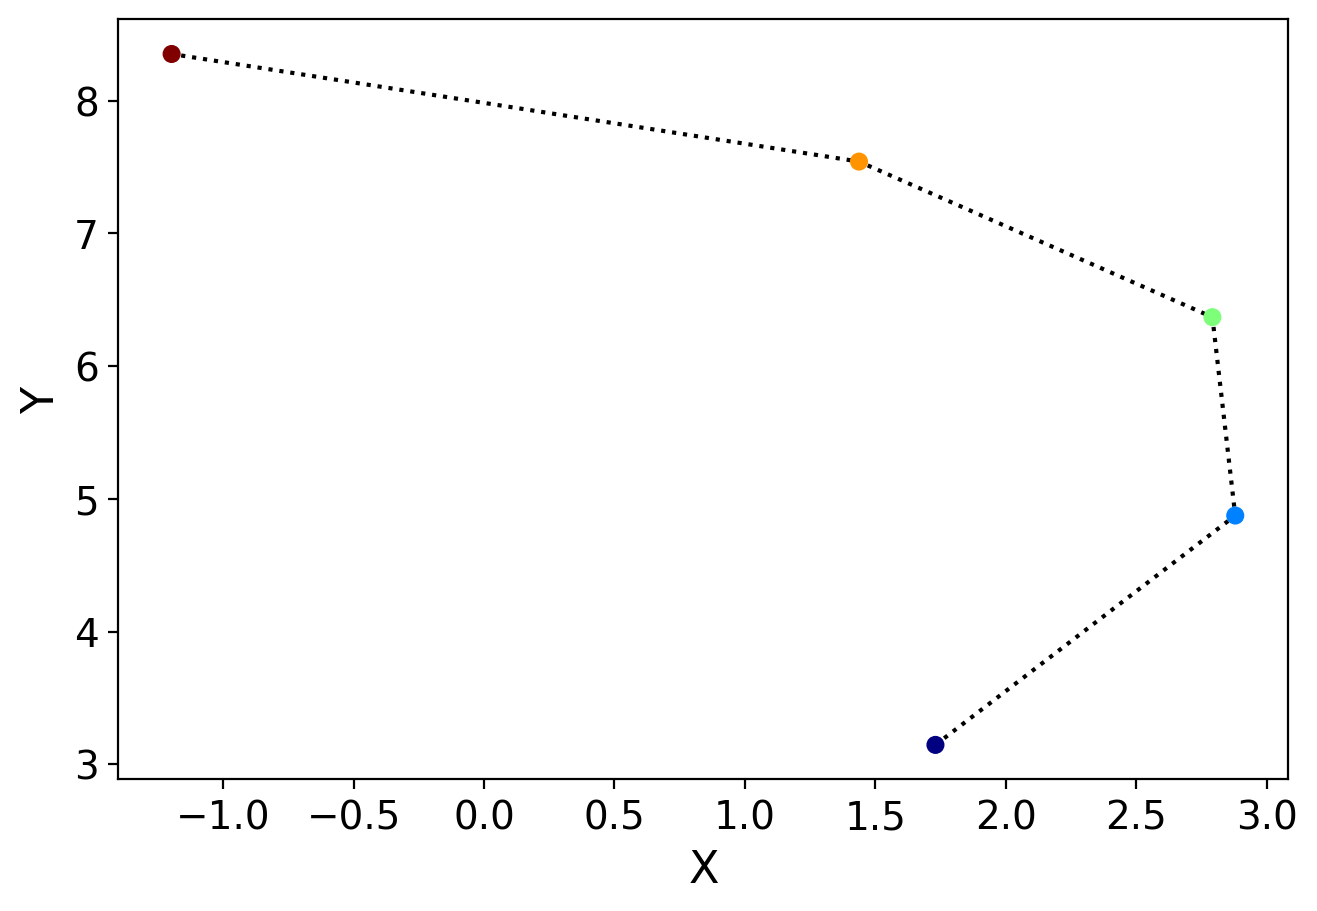

True


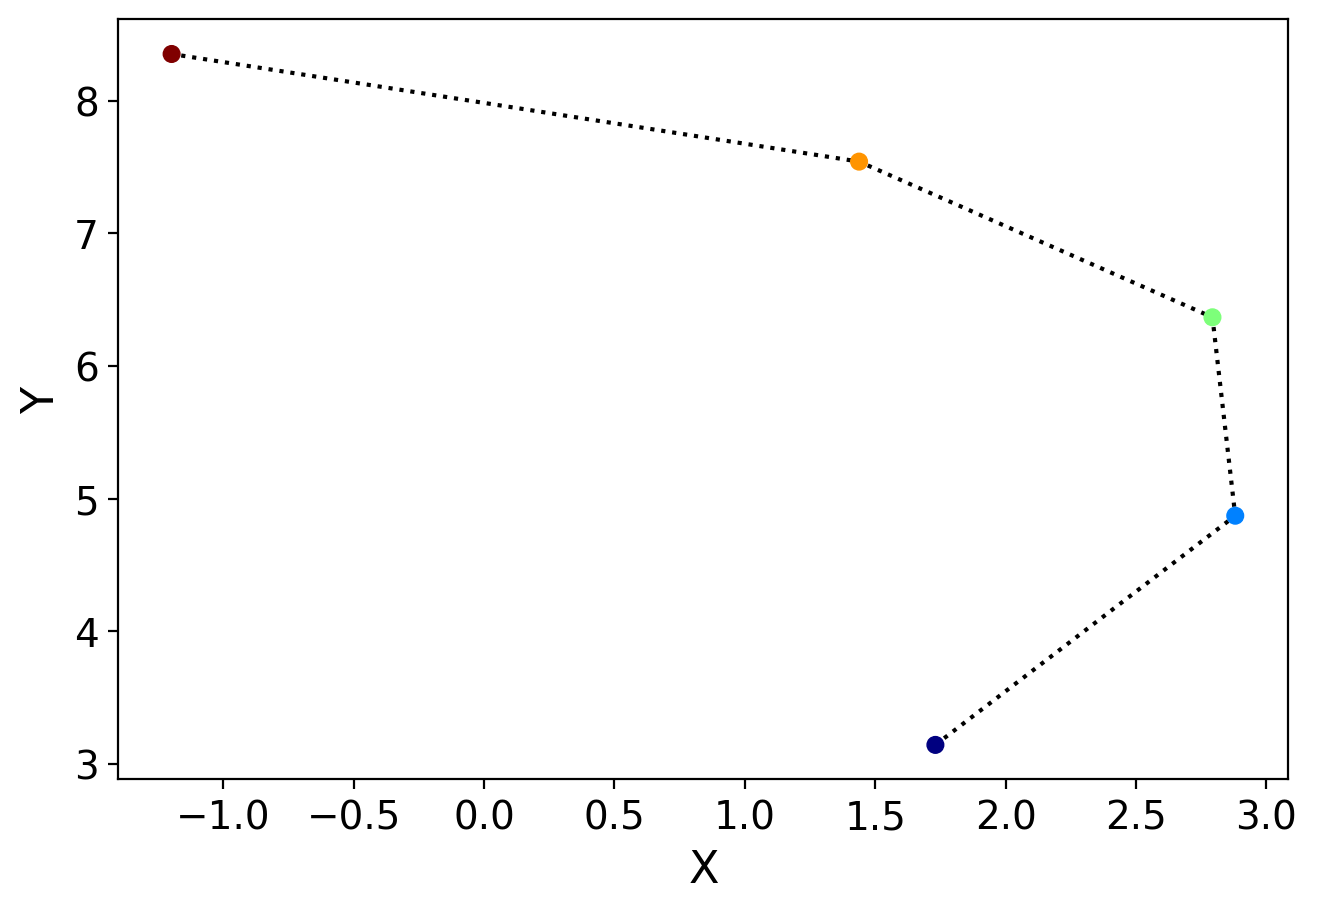

True


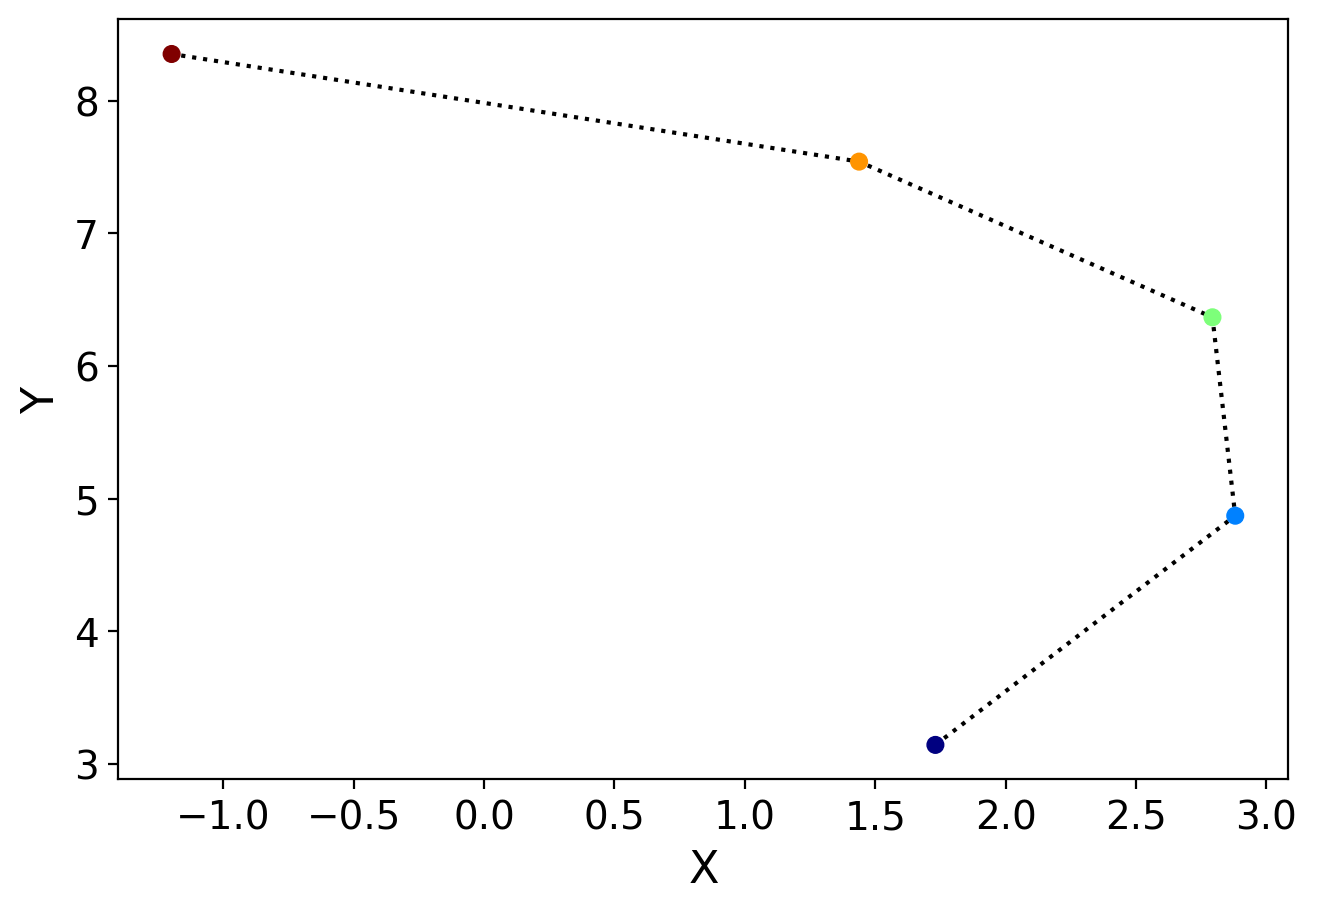

False
X0: 85


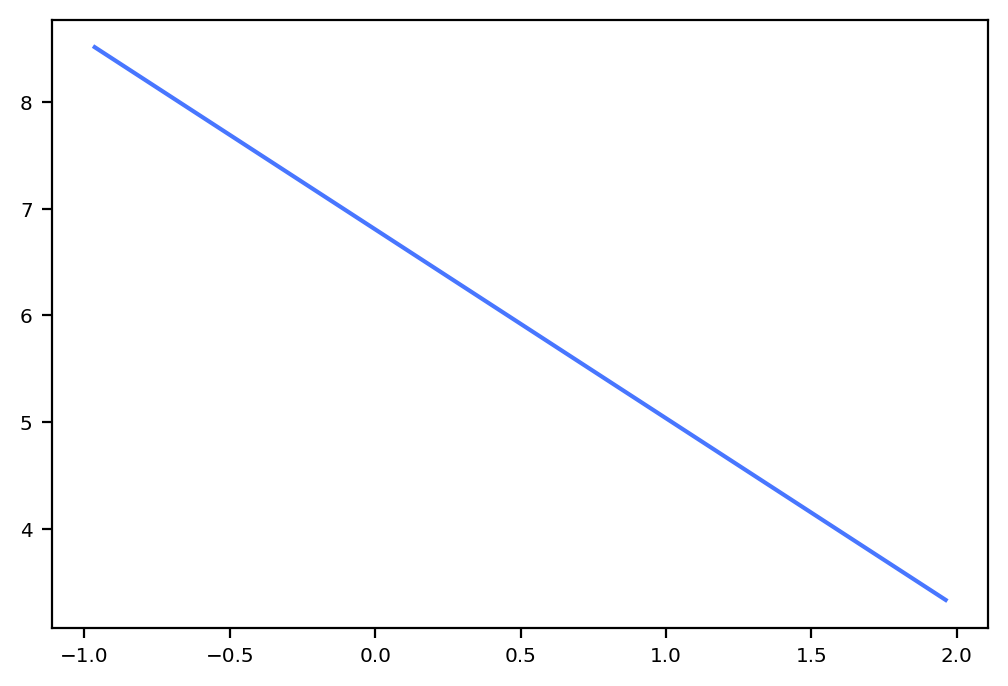

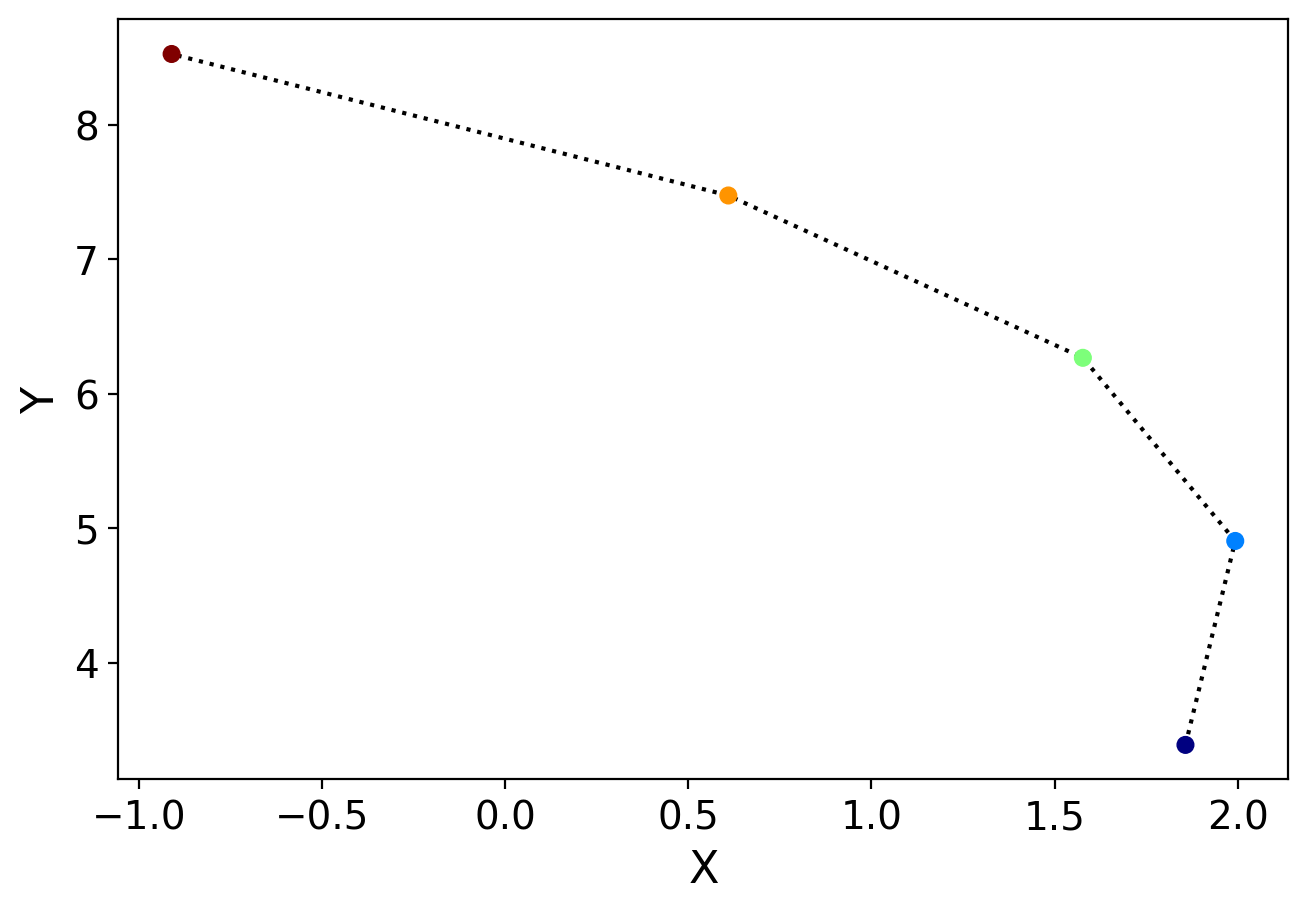

True


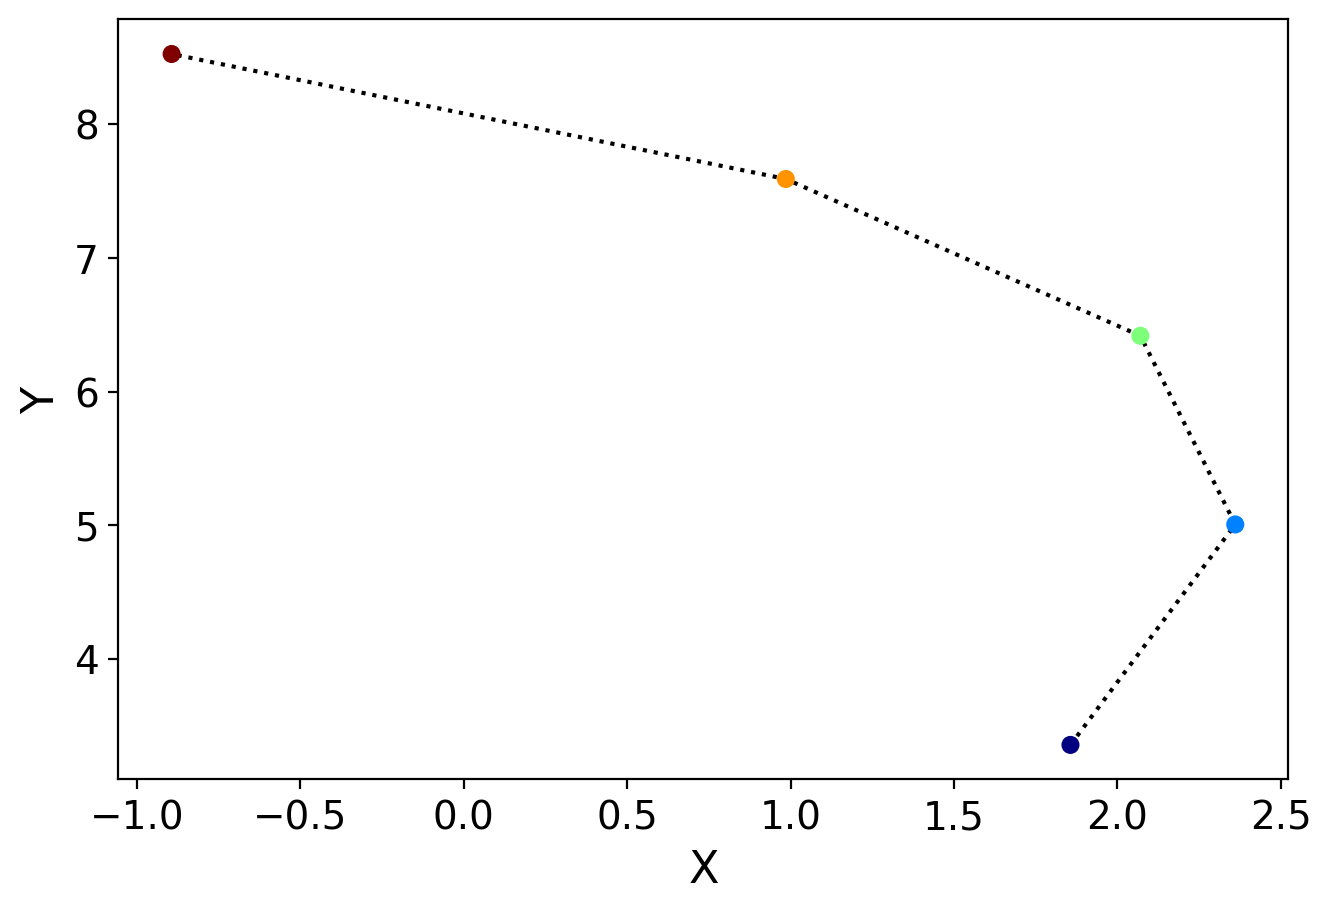

True


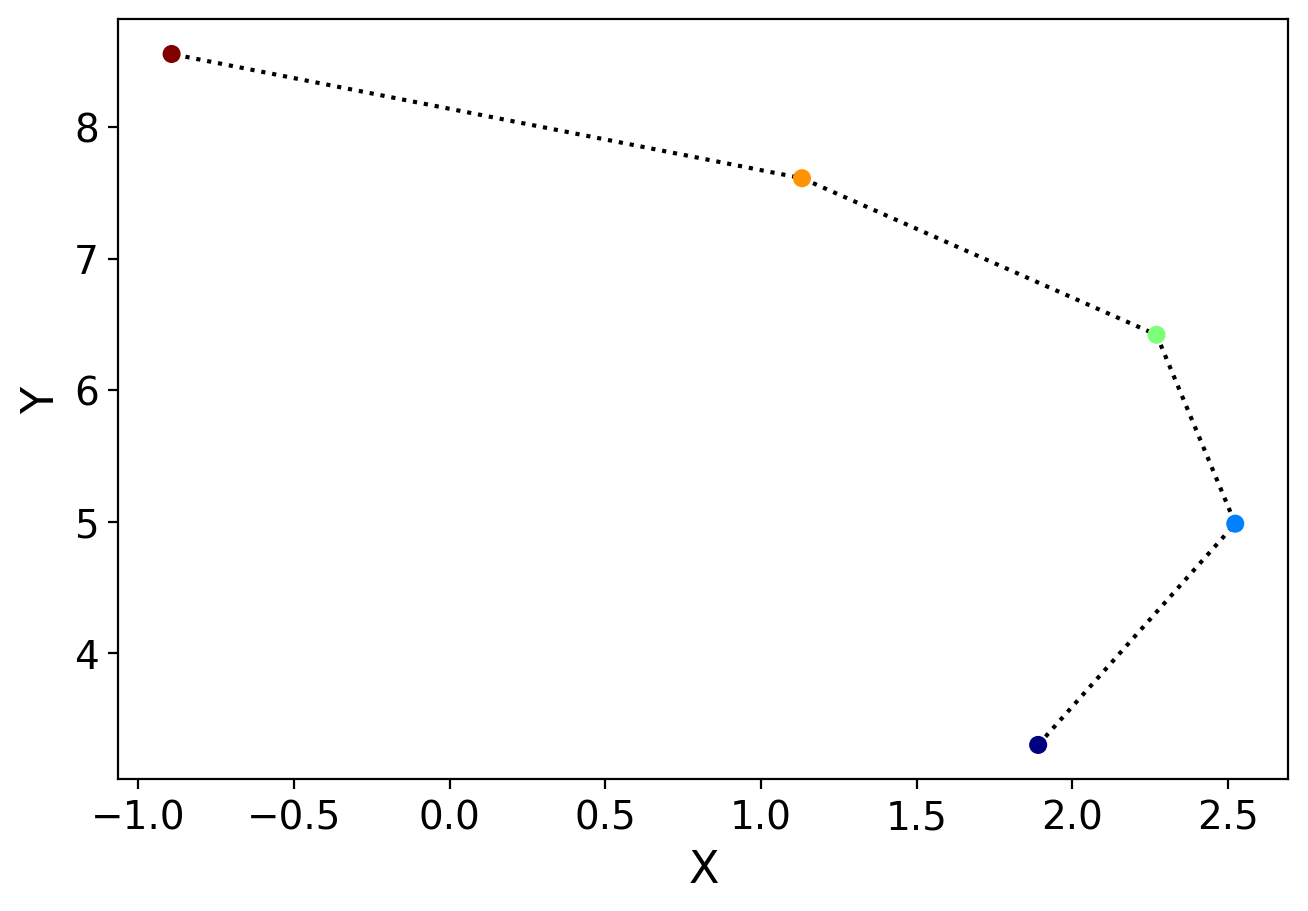

True


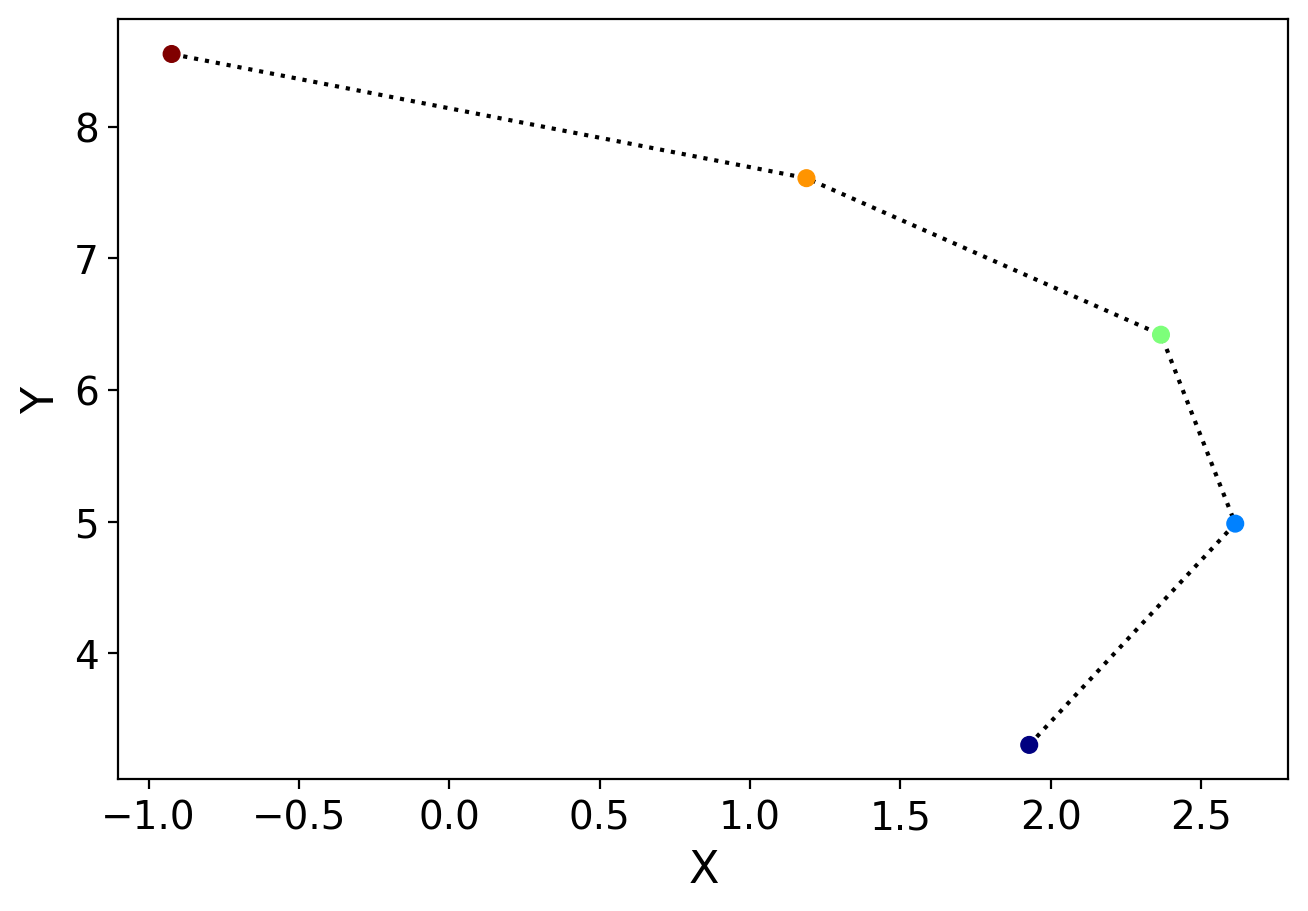

True


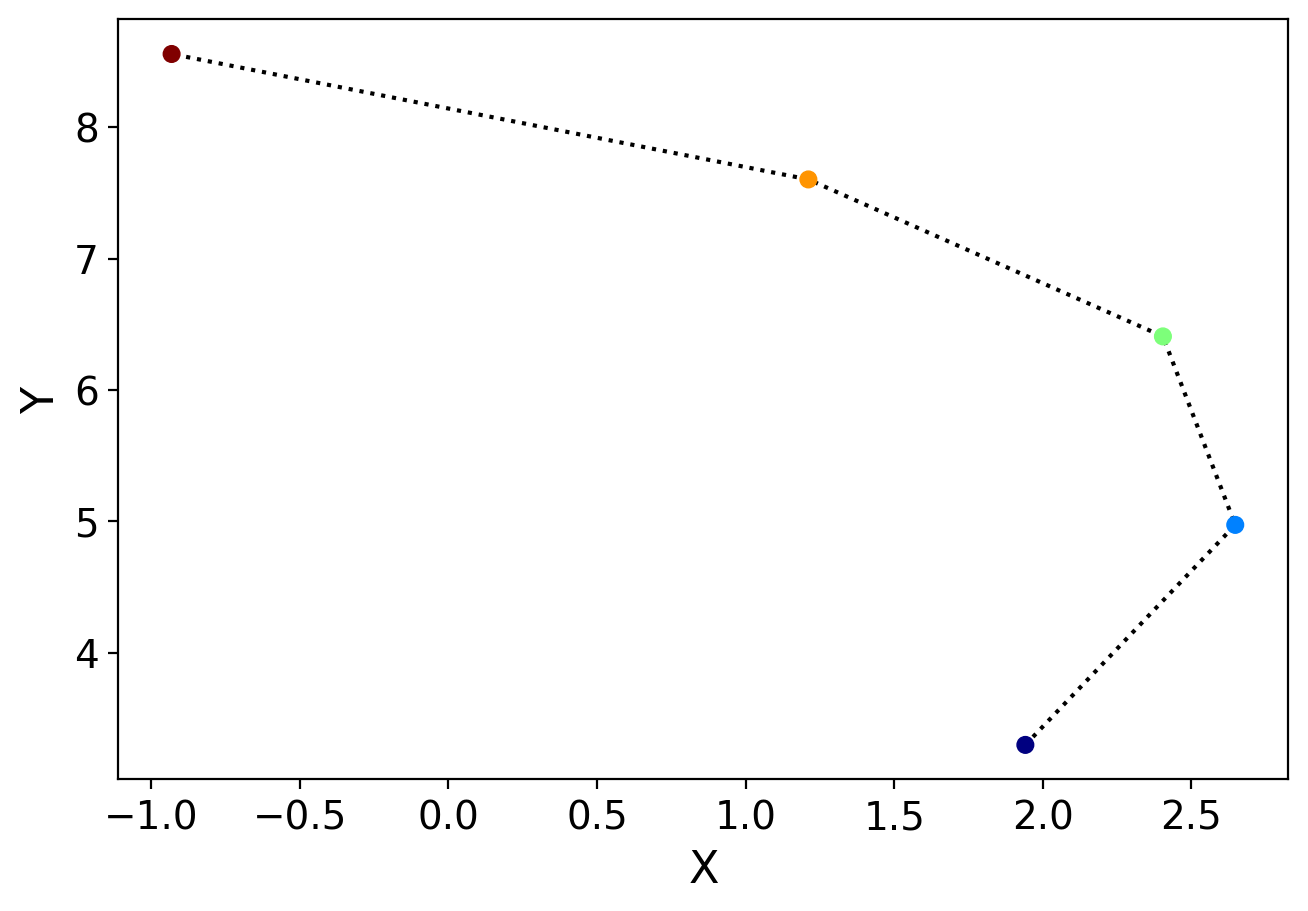

True


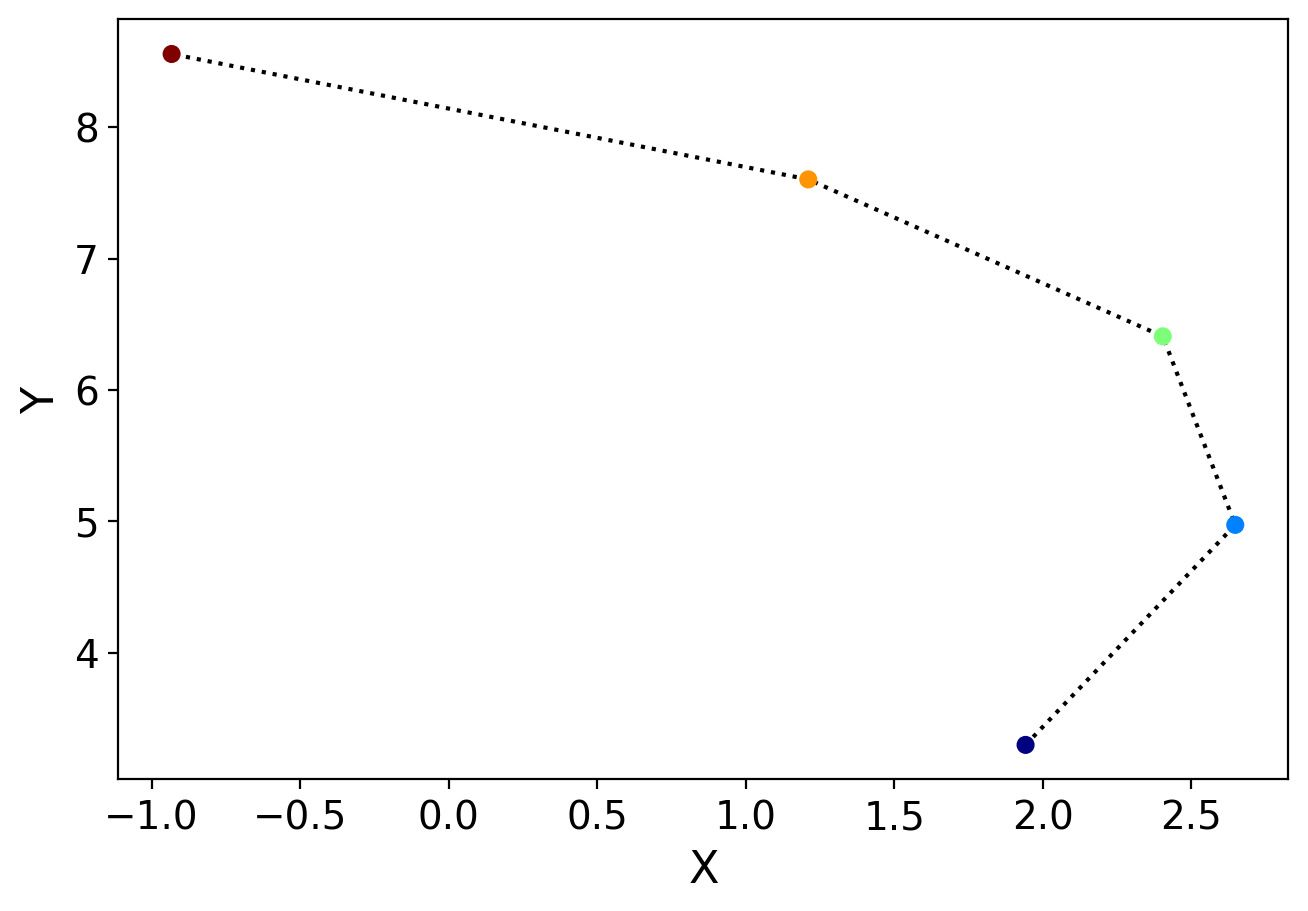

False
X0: 15


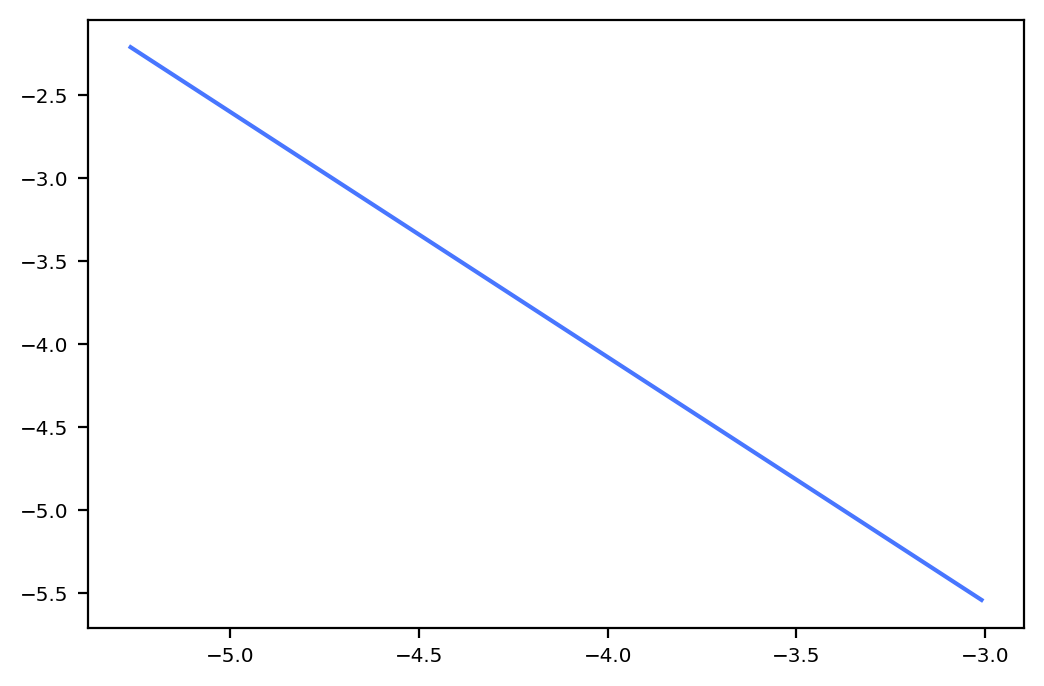

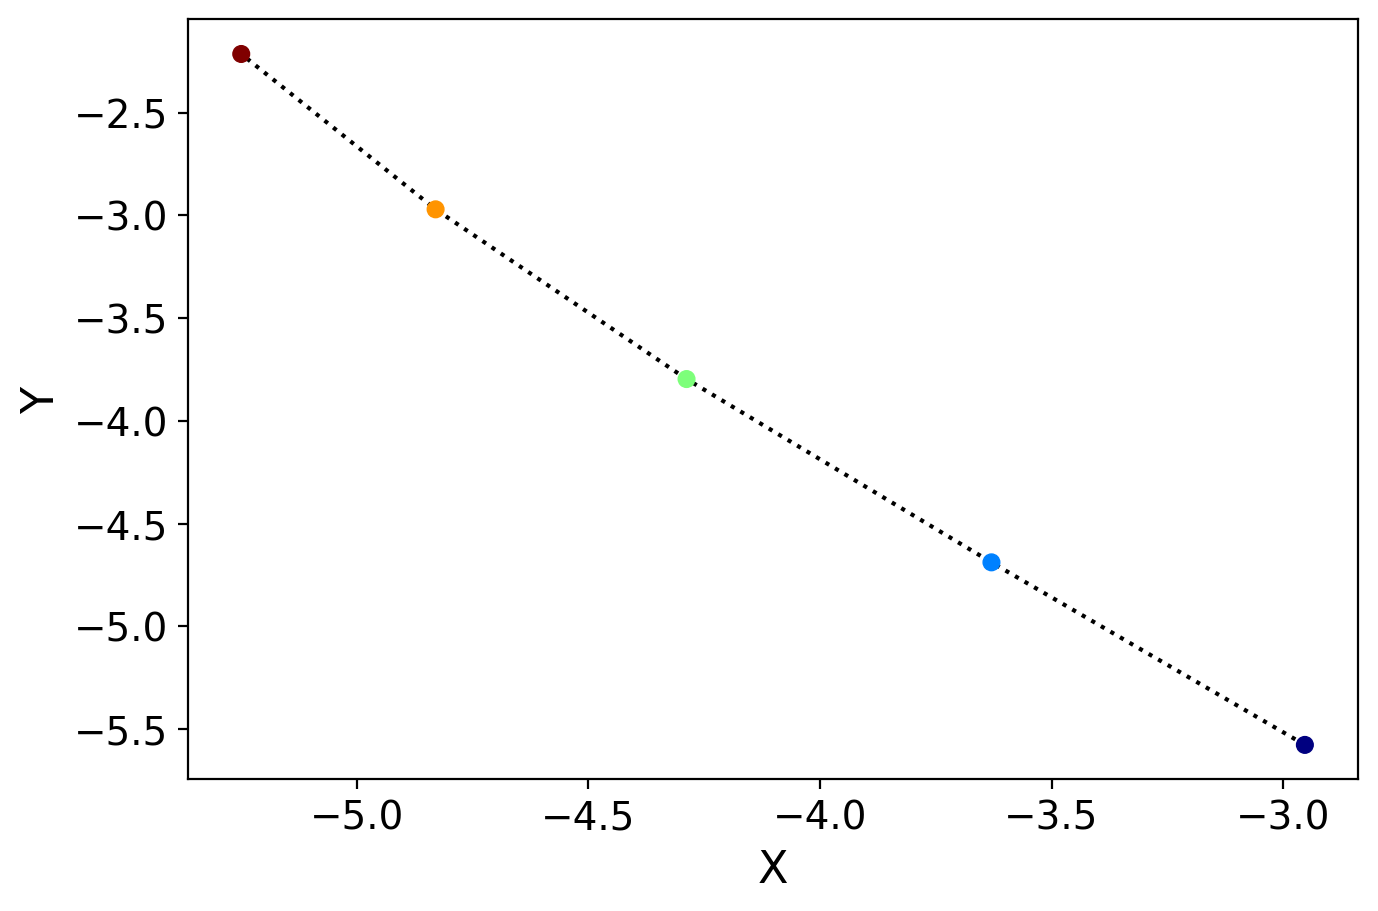

True


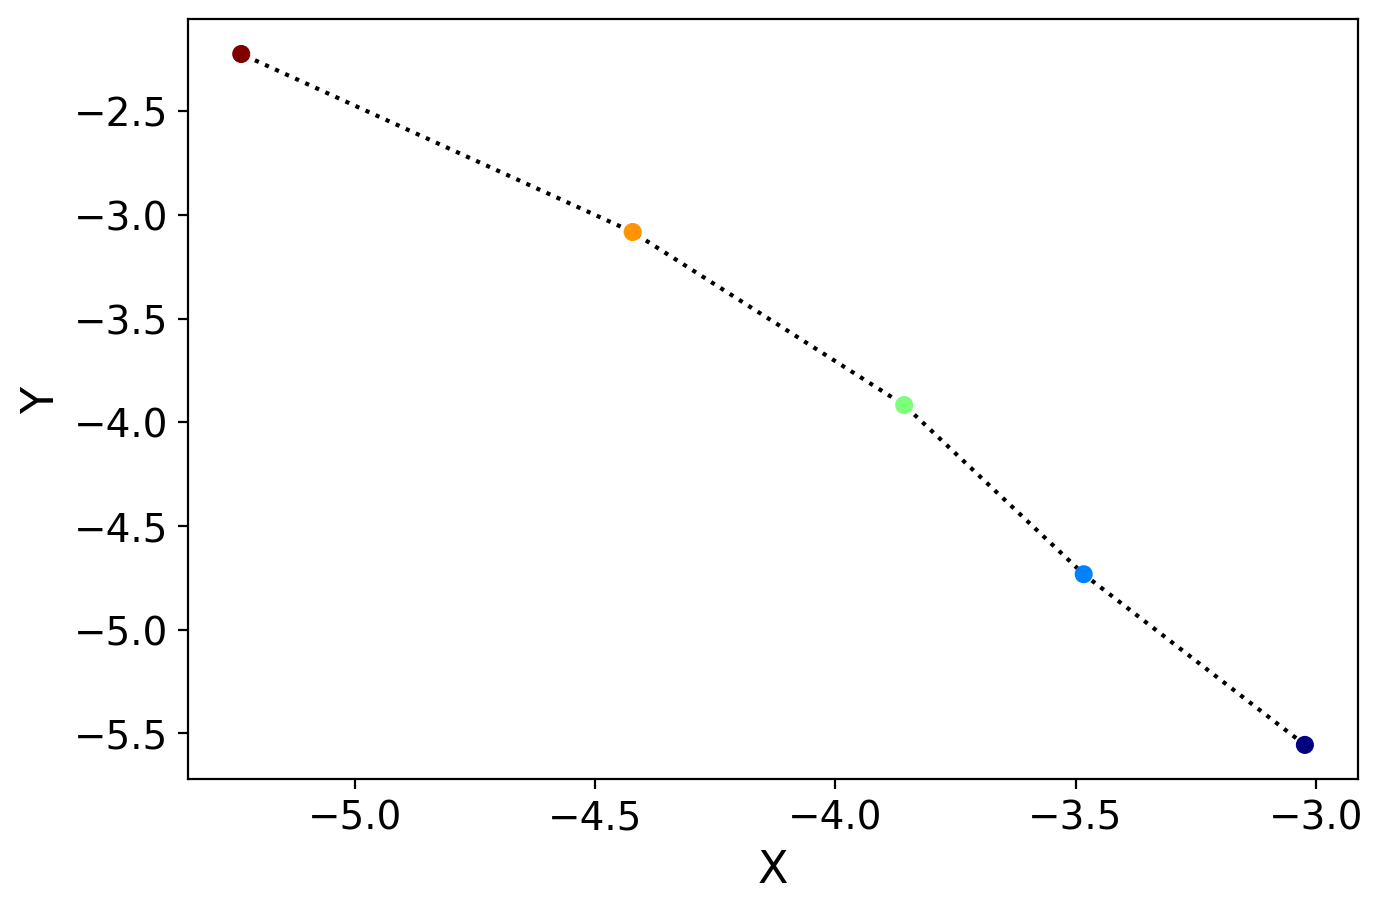

True


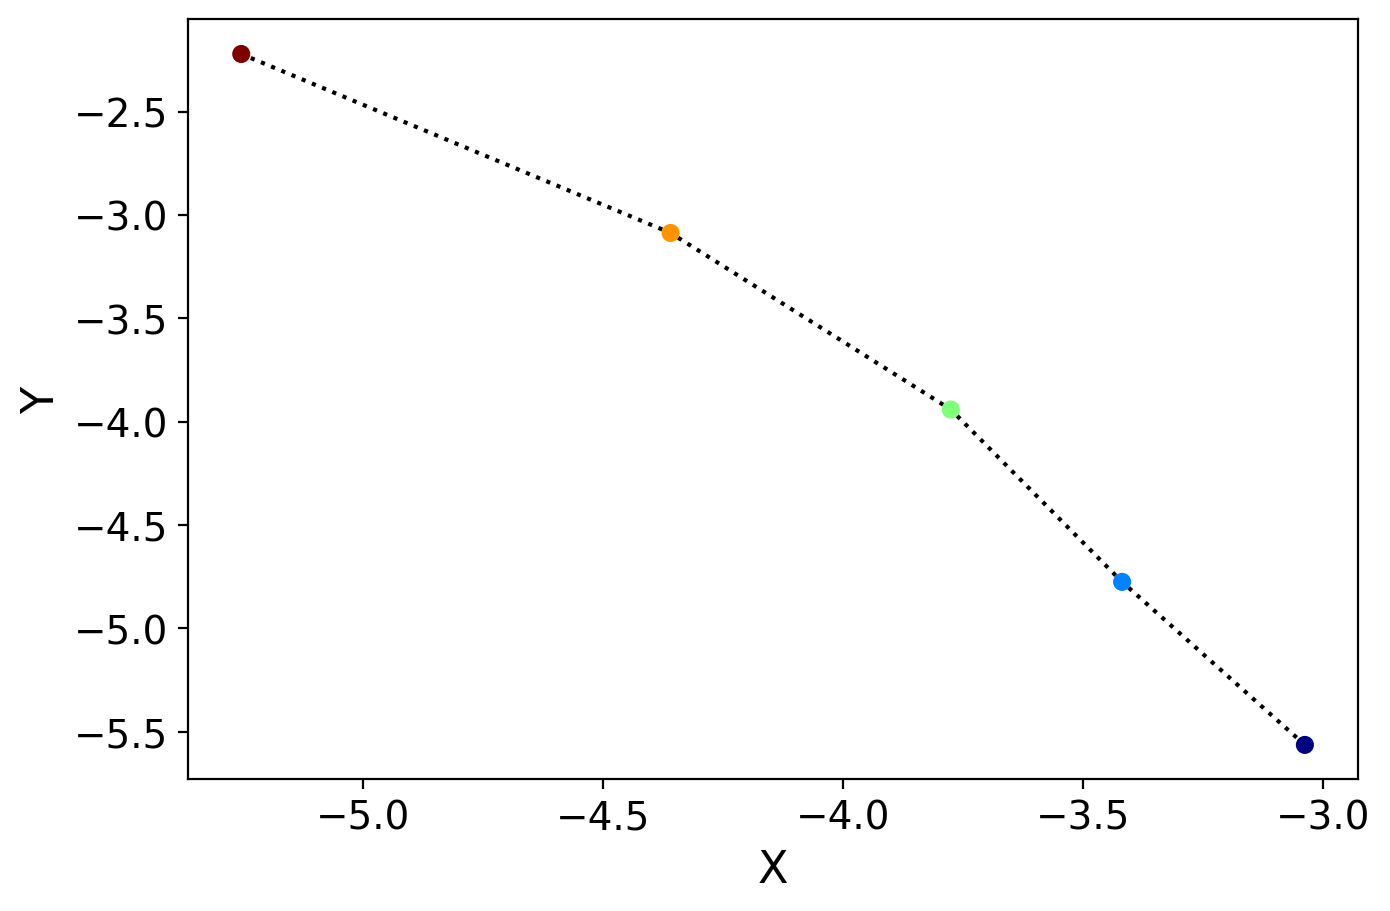

True


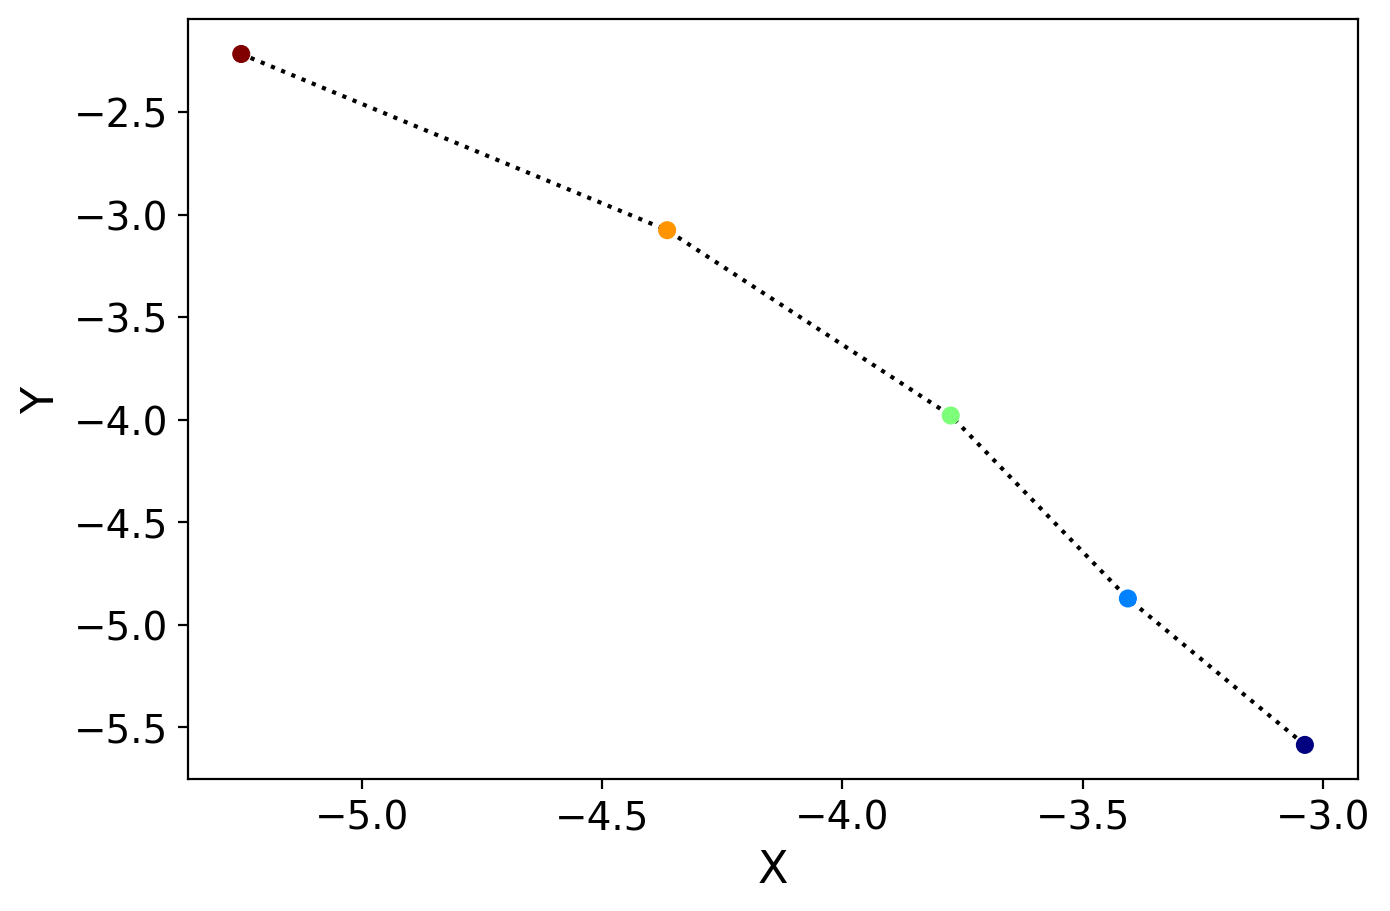

True


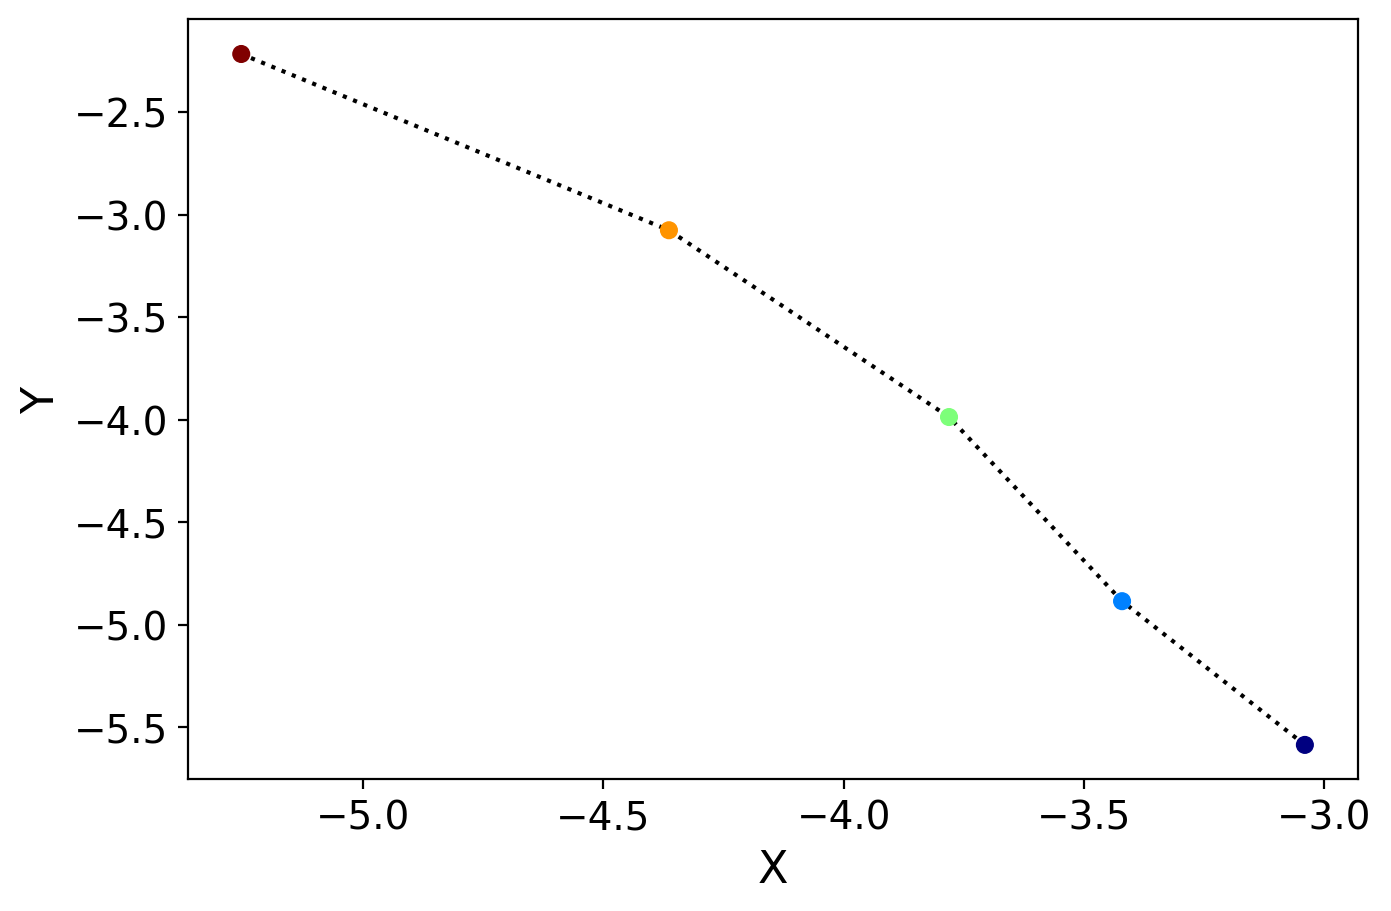

True


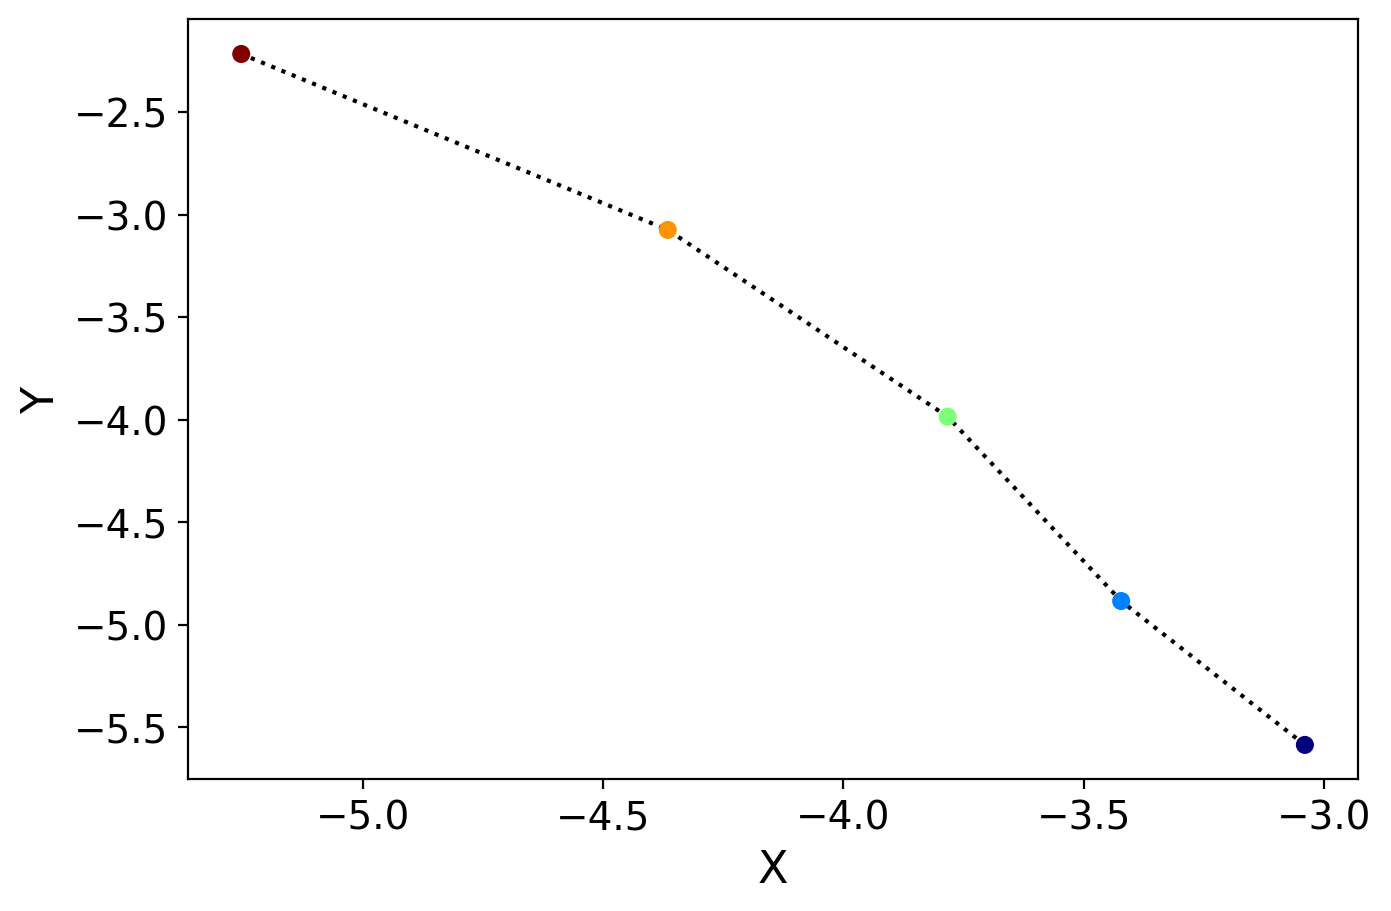

False
X0: 79


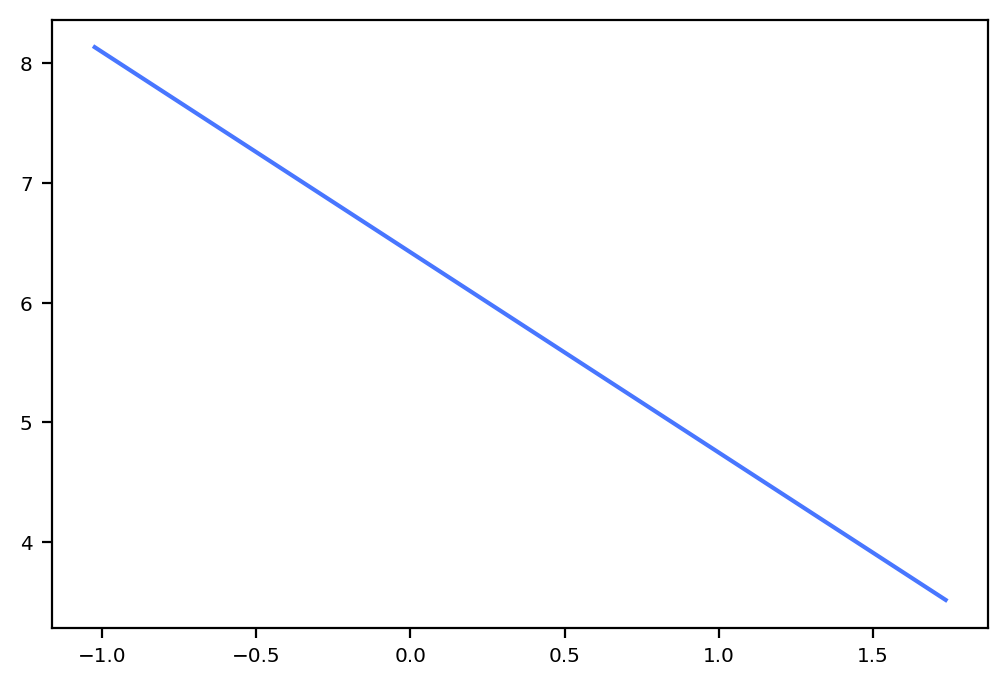

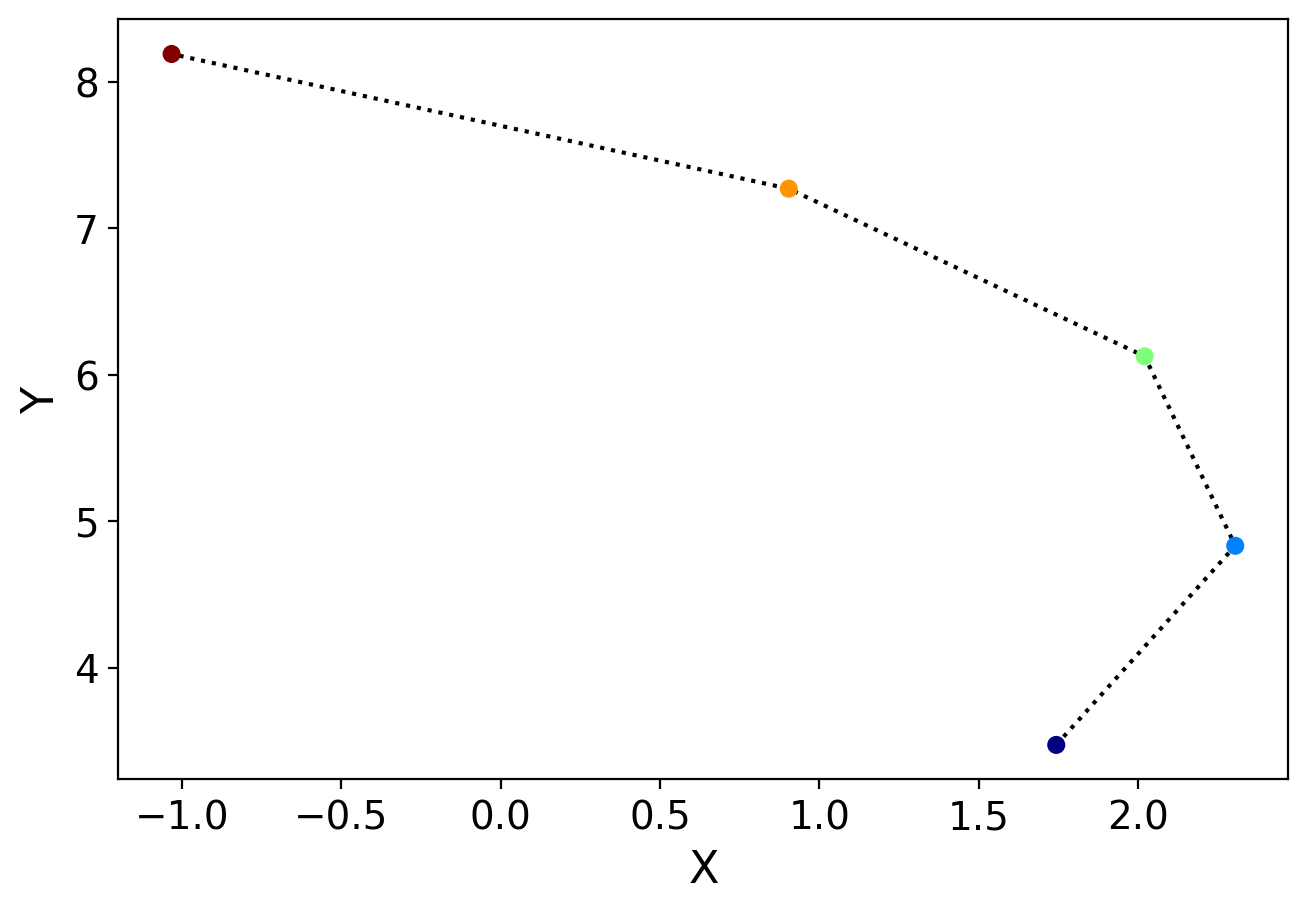

True


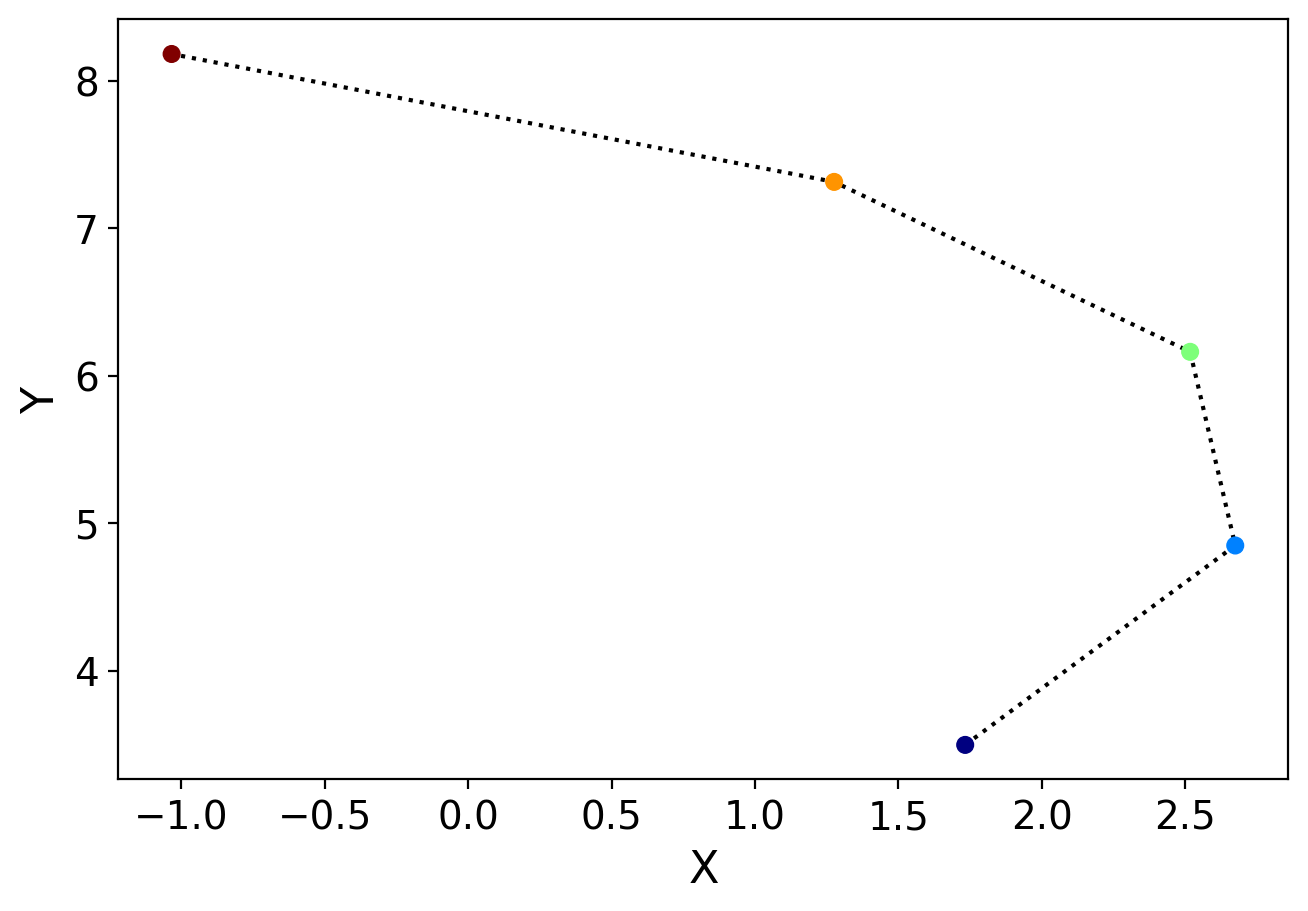

True


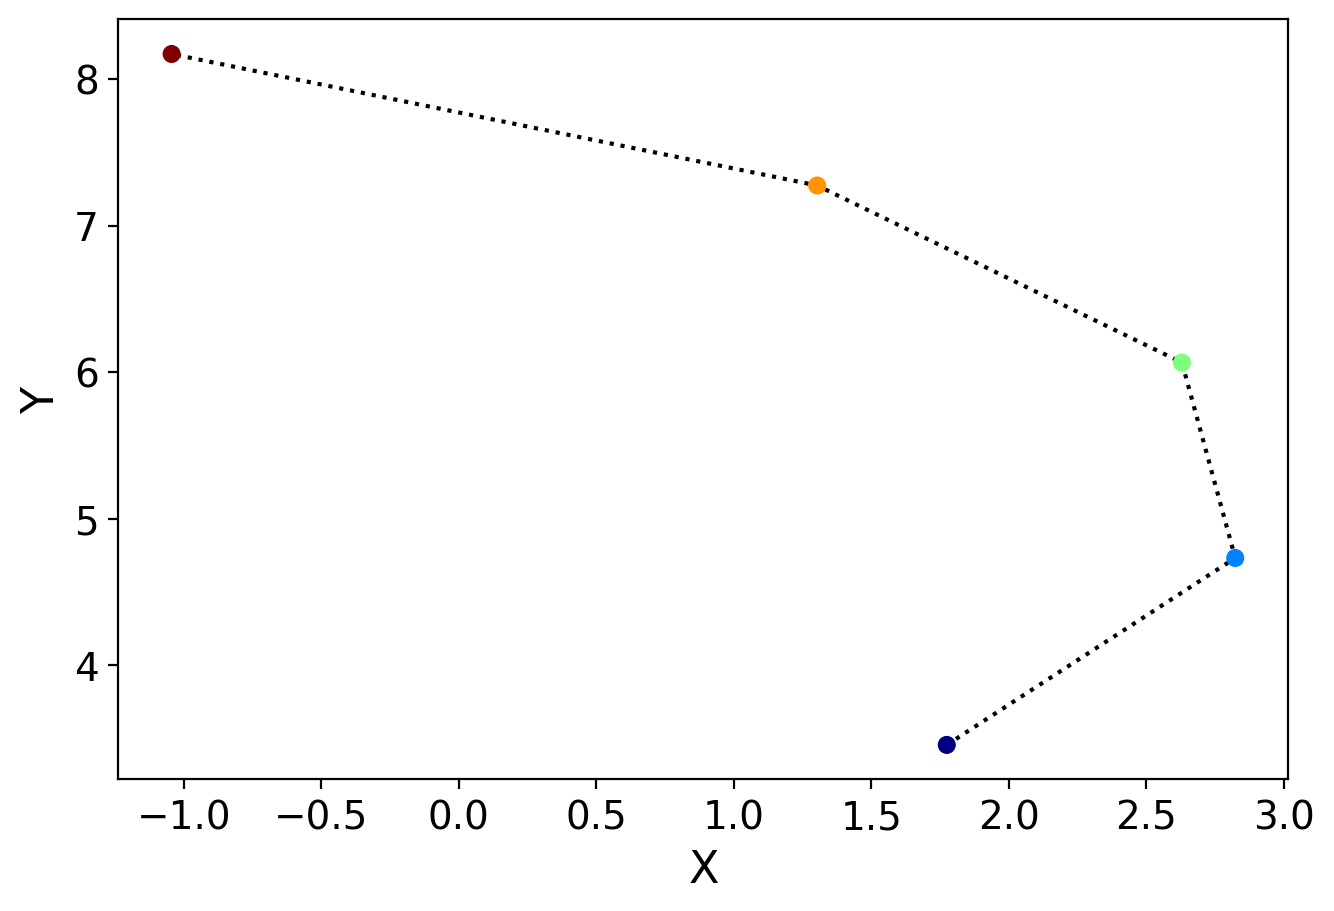

True


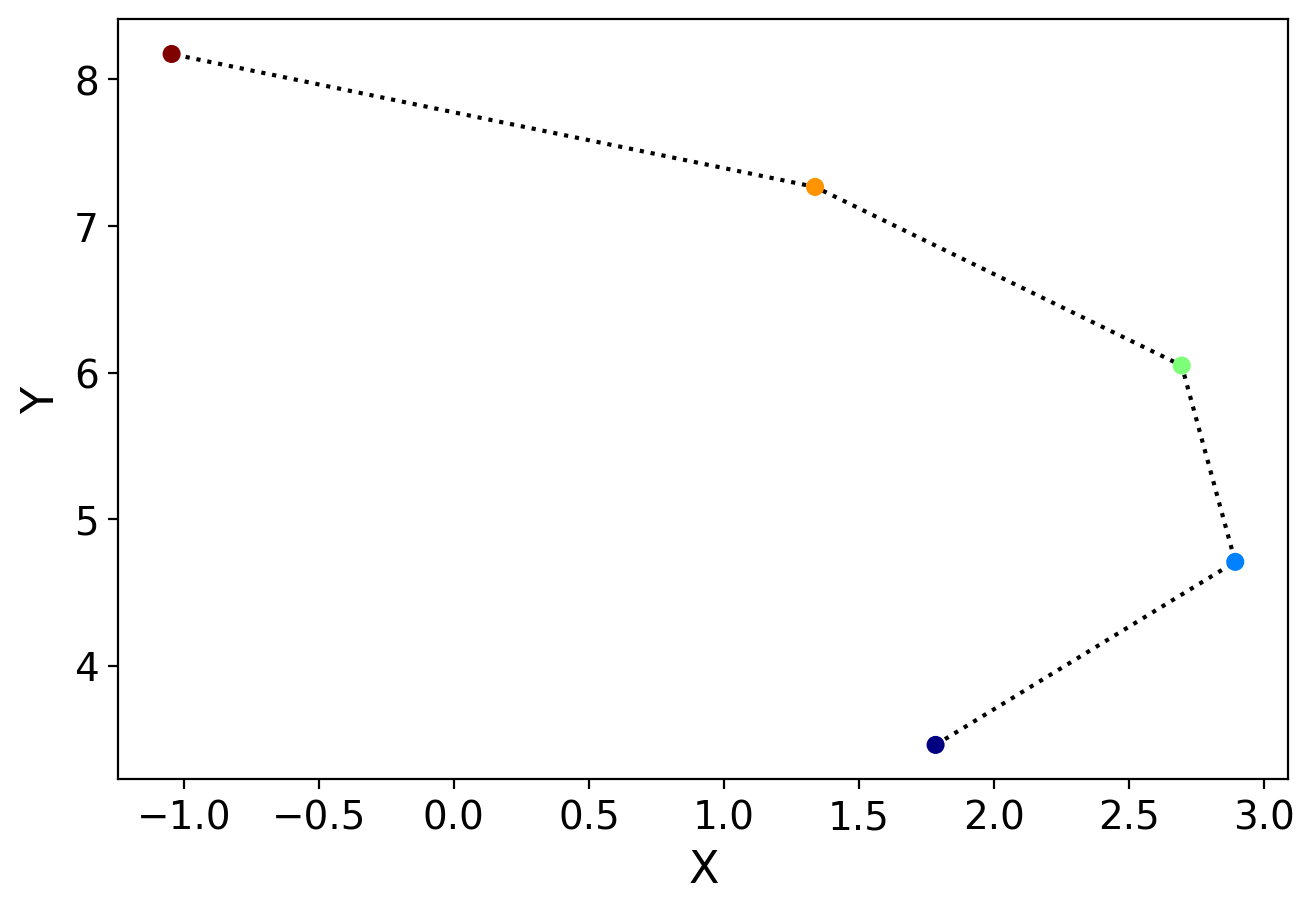

True


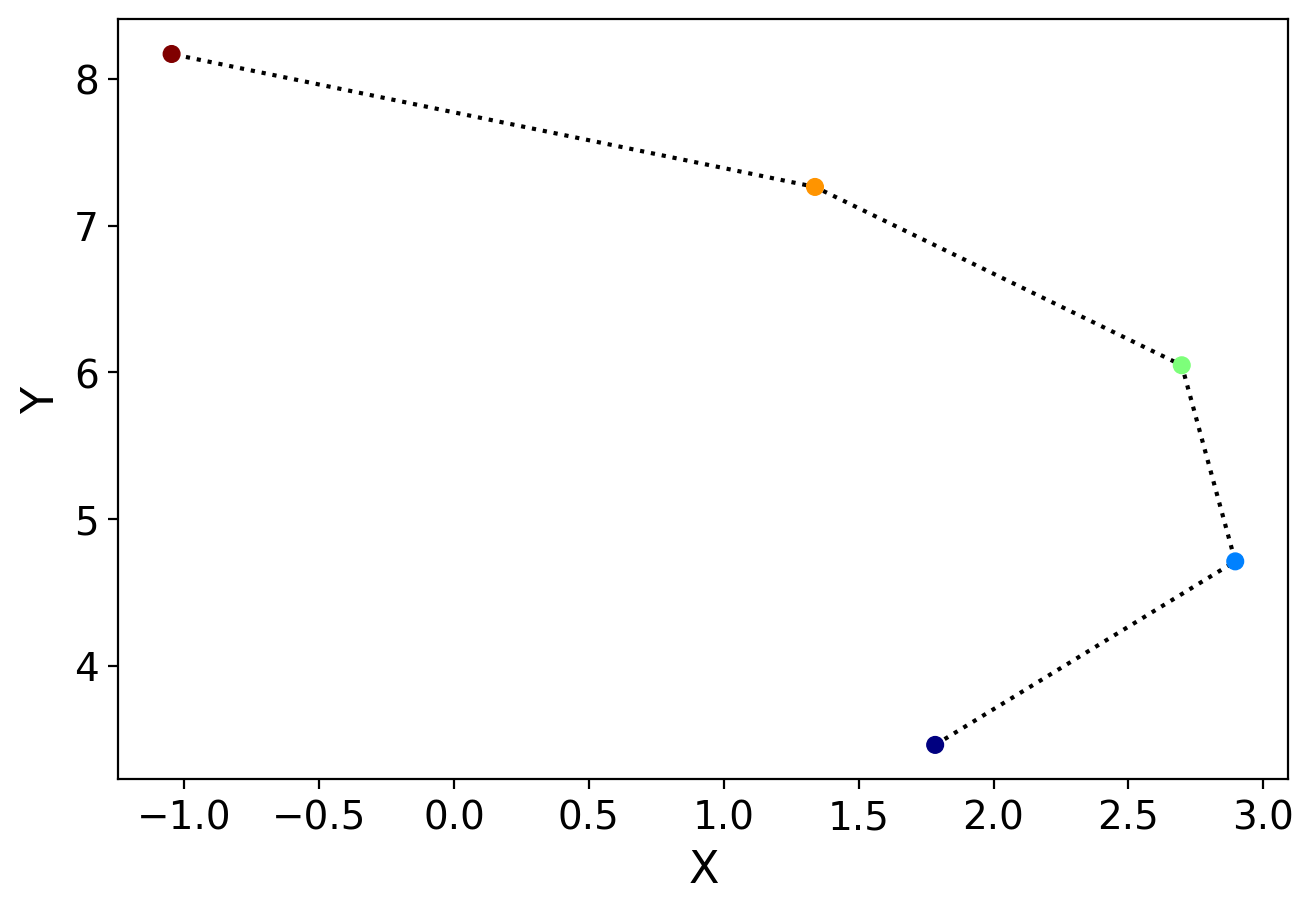

True


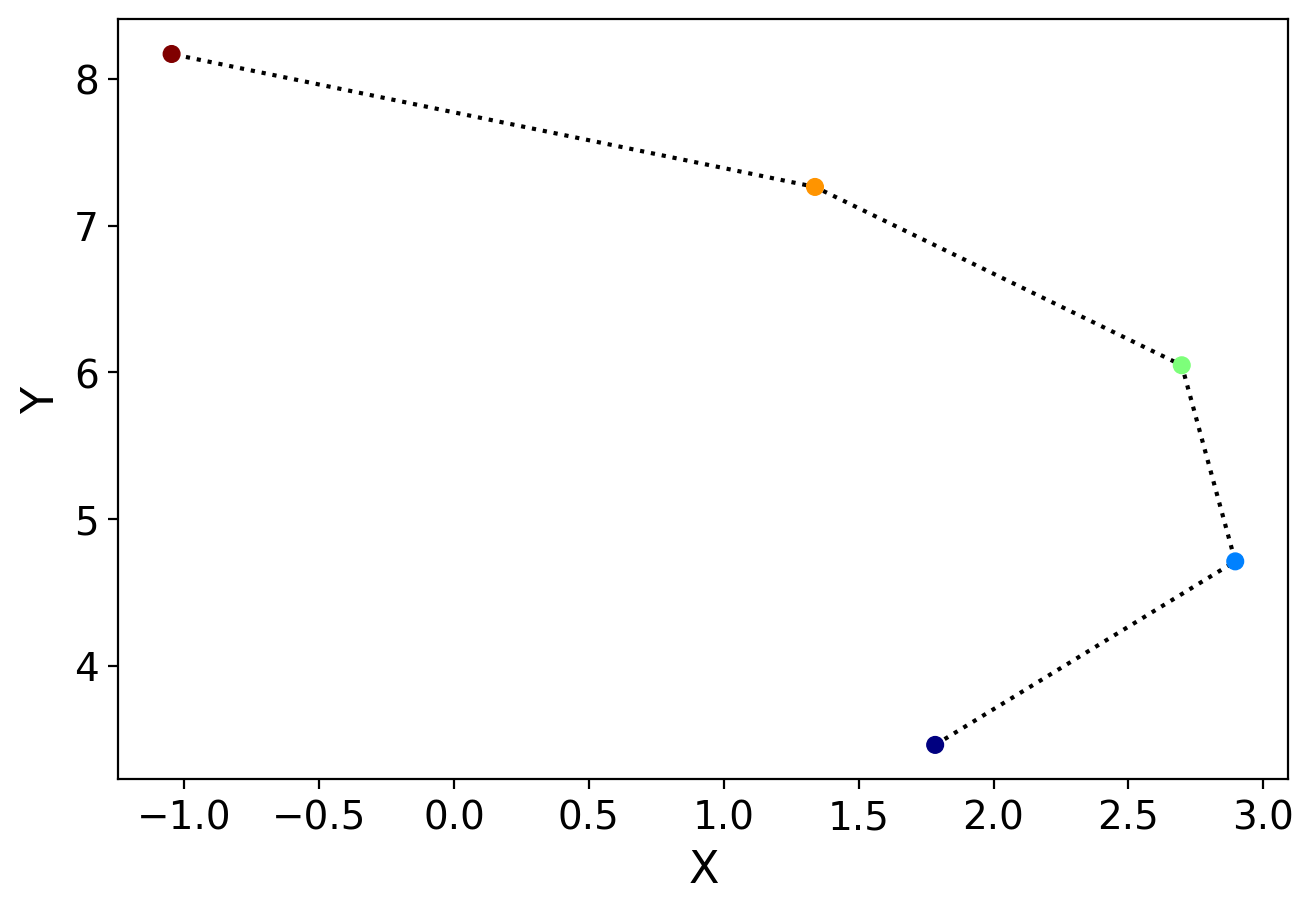

False
X0: 21


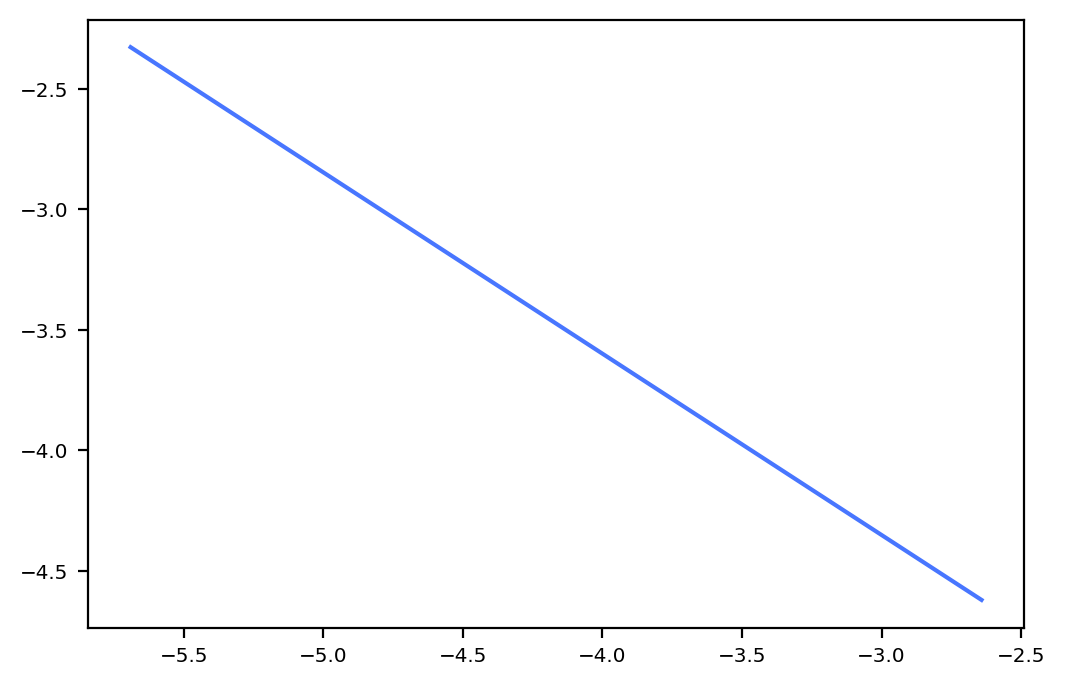

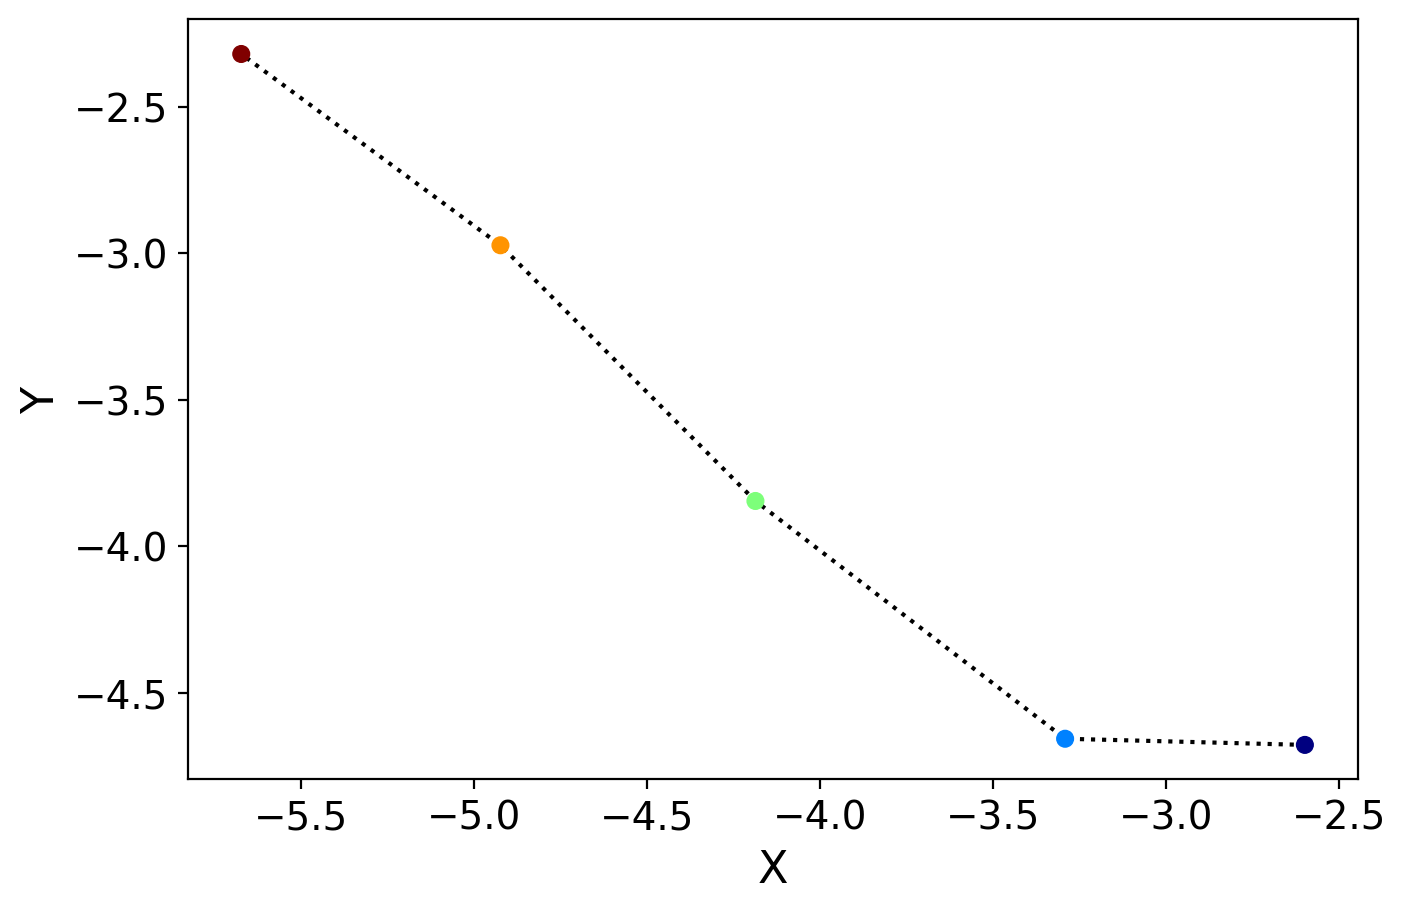

True


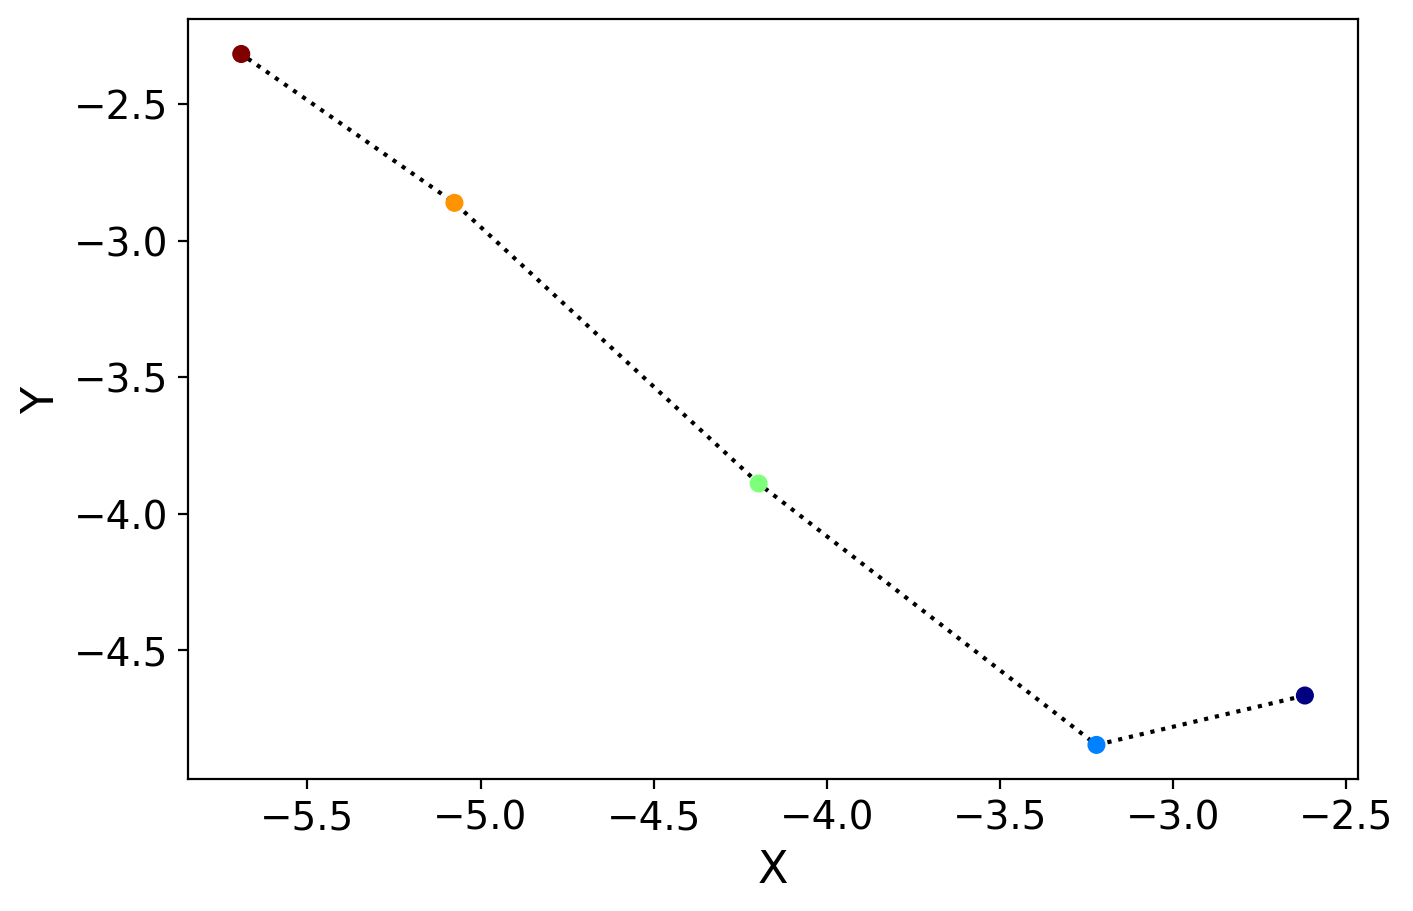

True


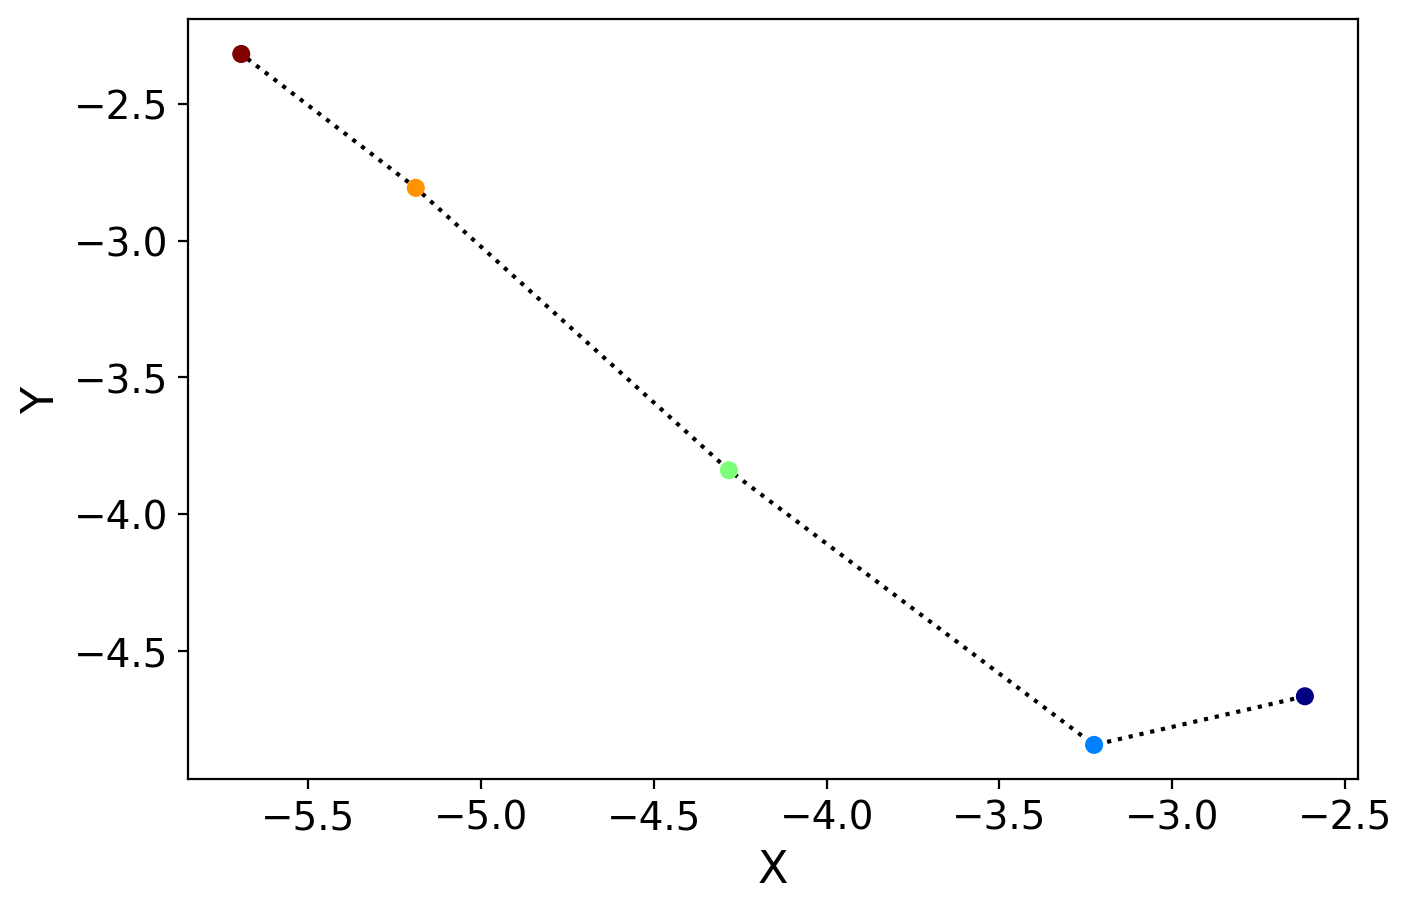

True


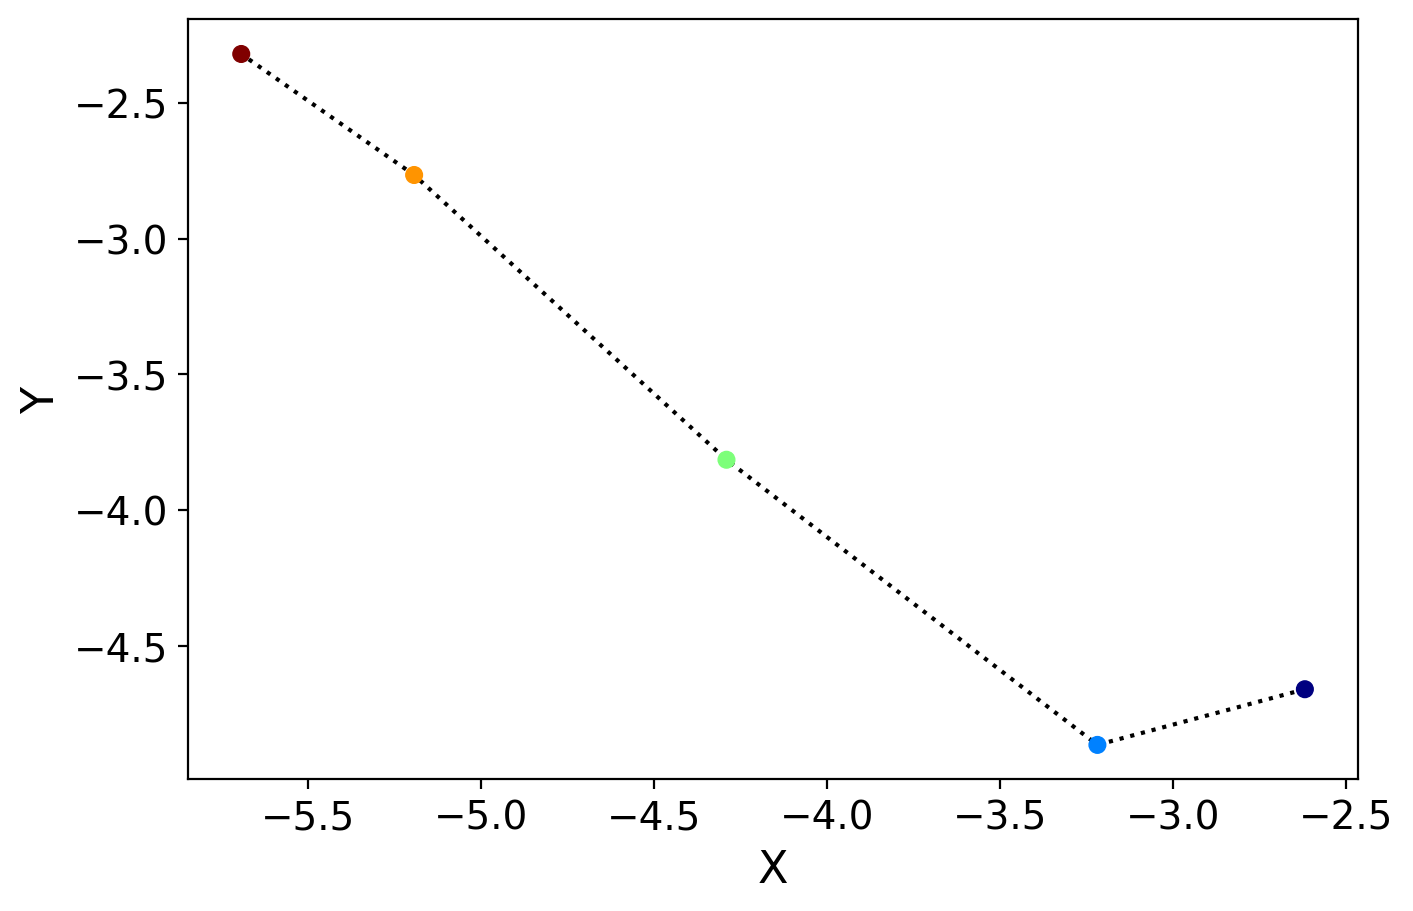

True


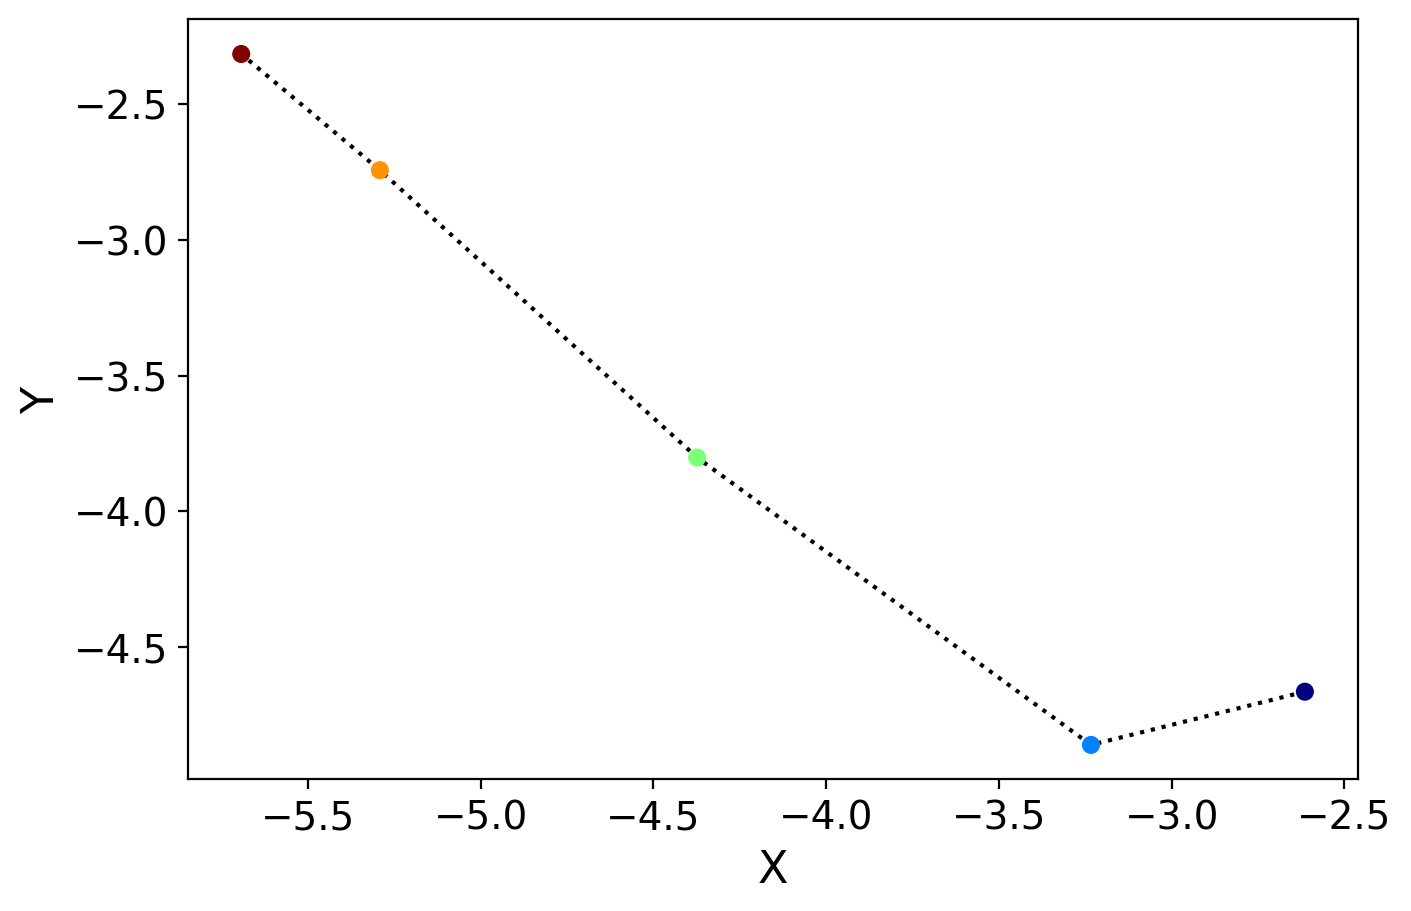

True


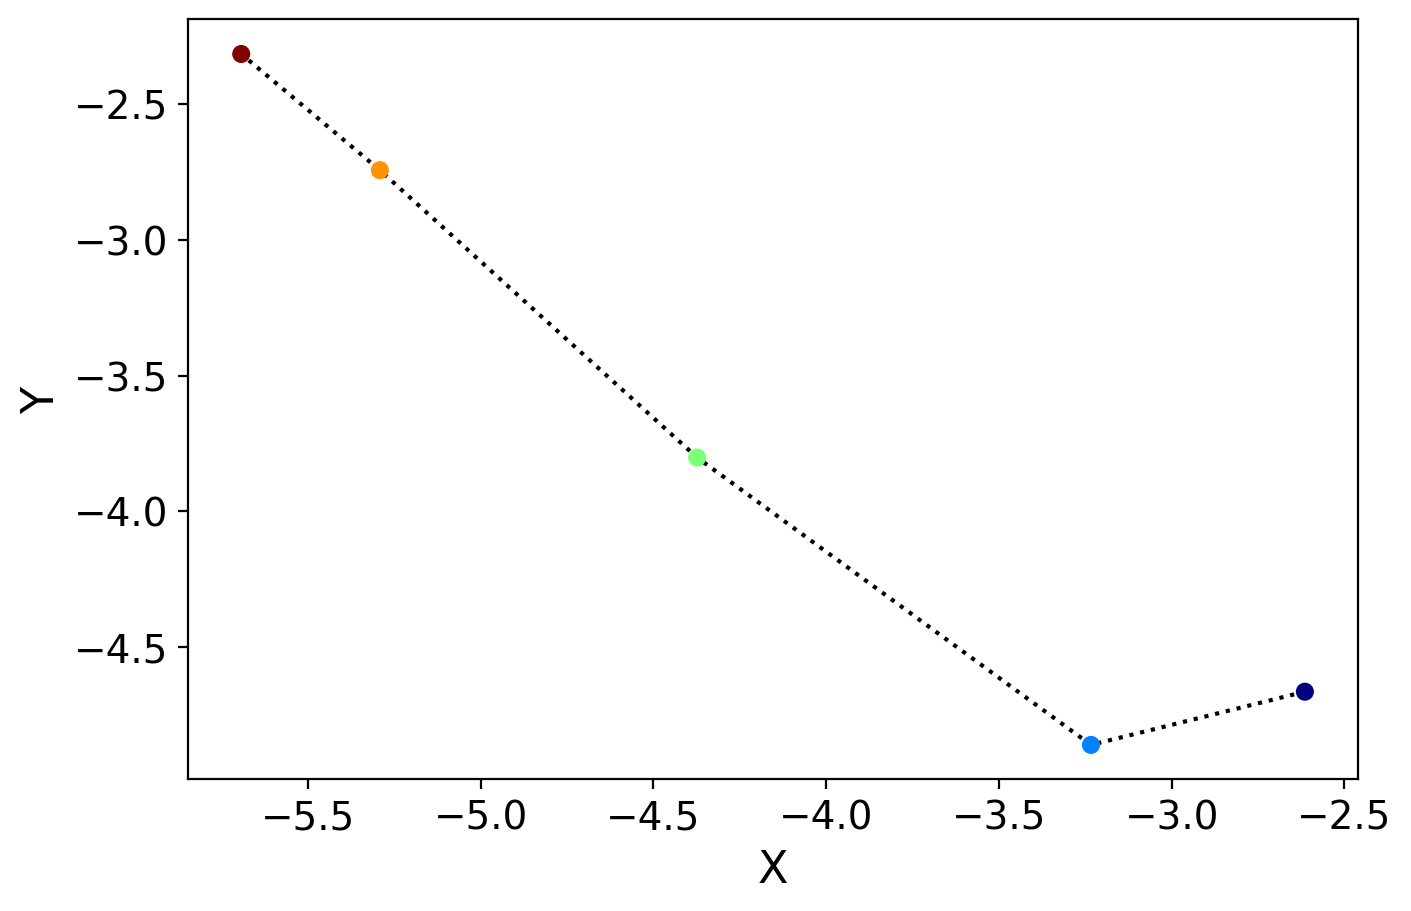

False
X0: 88


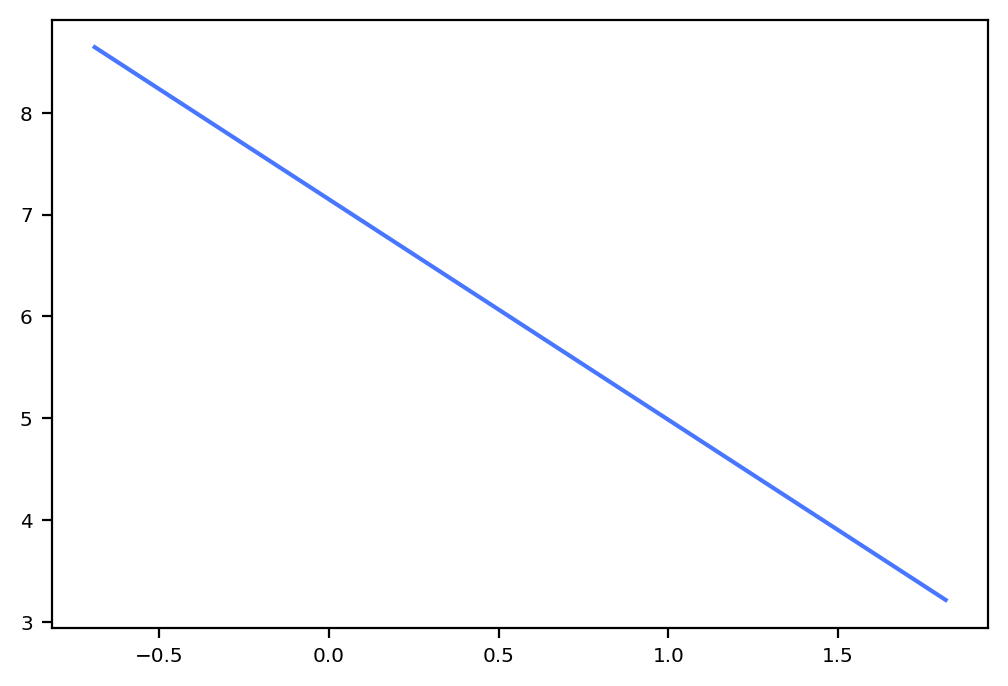

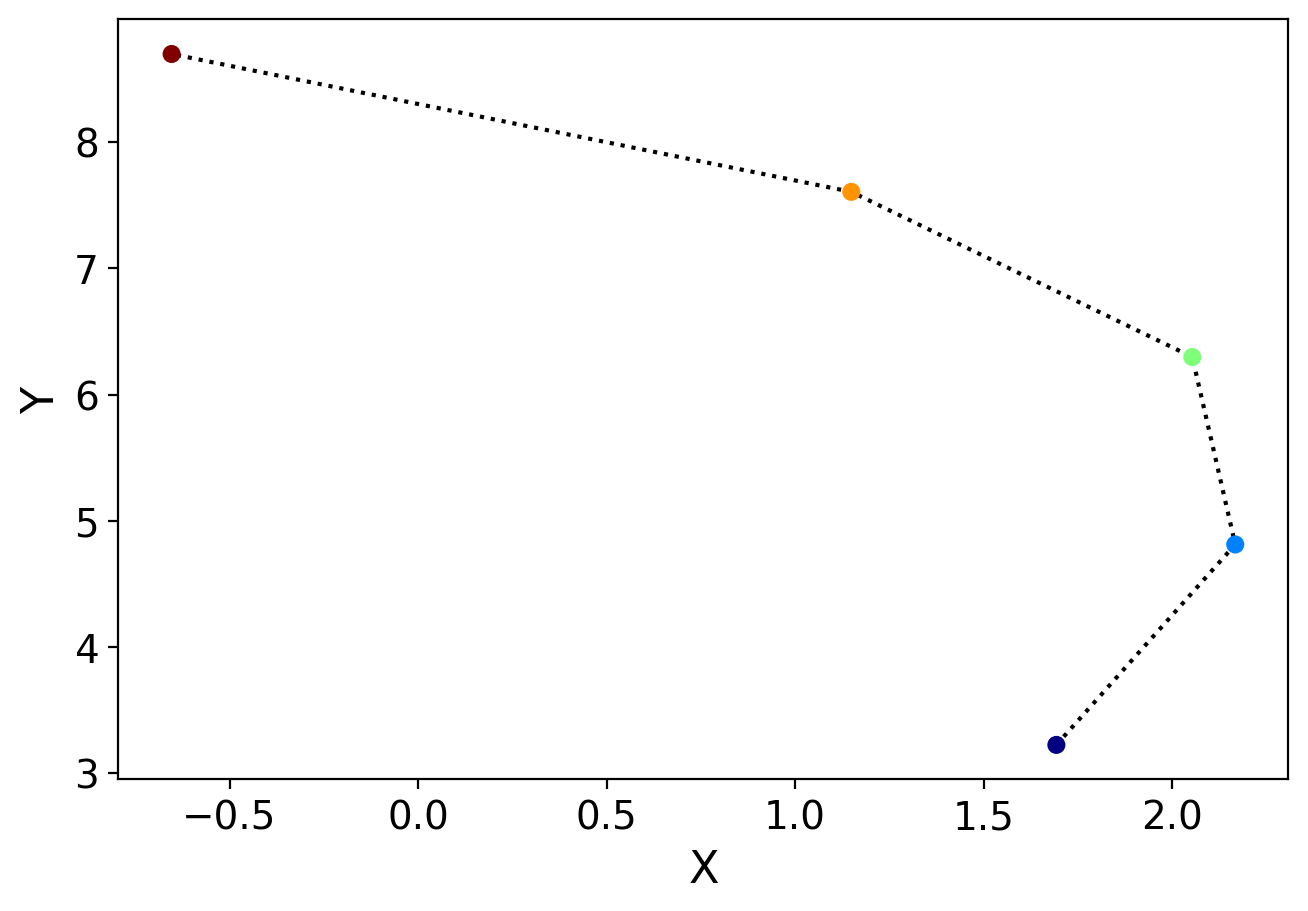

True


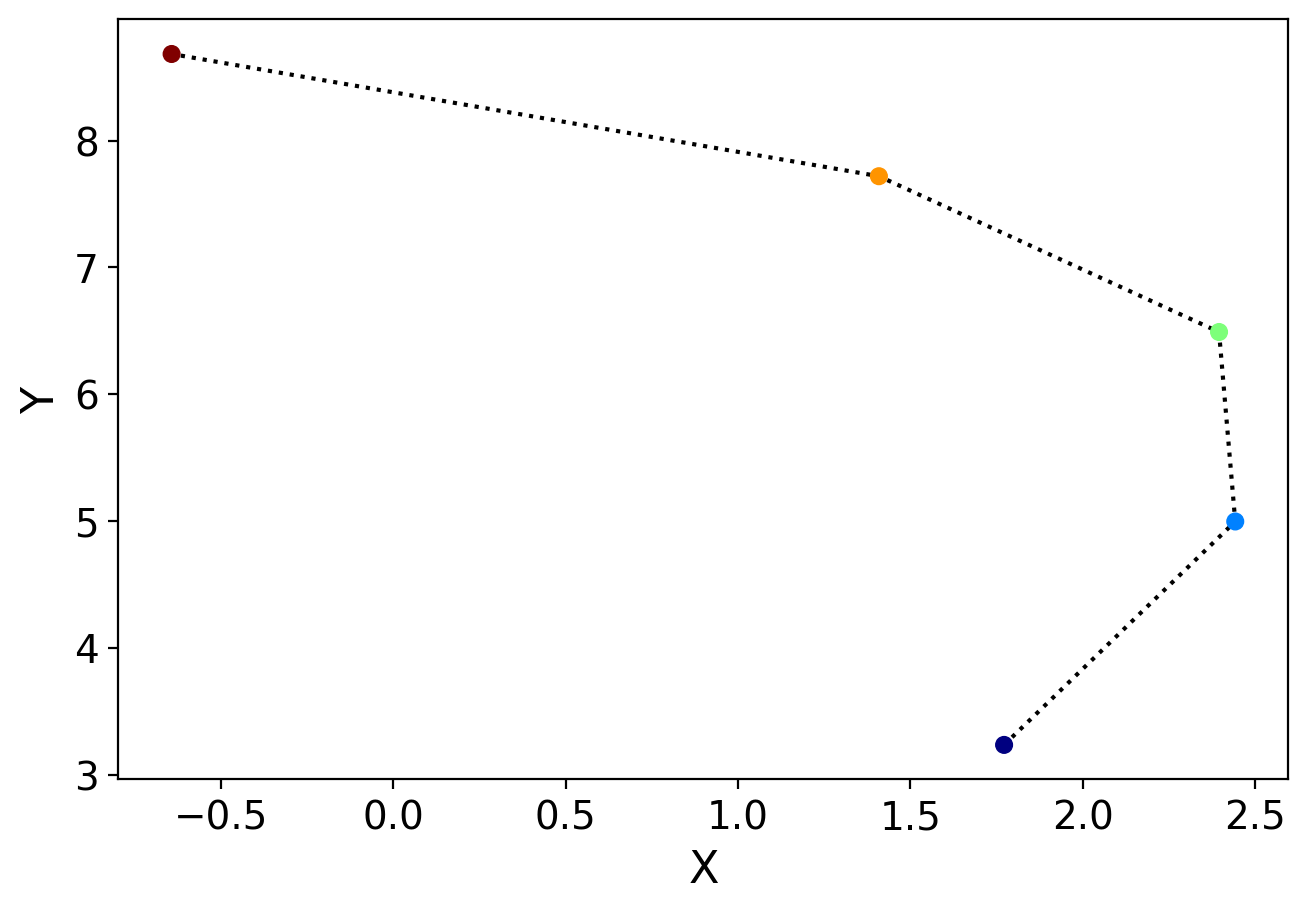

True


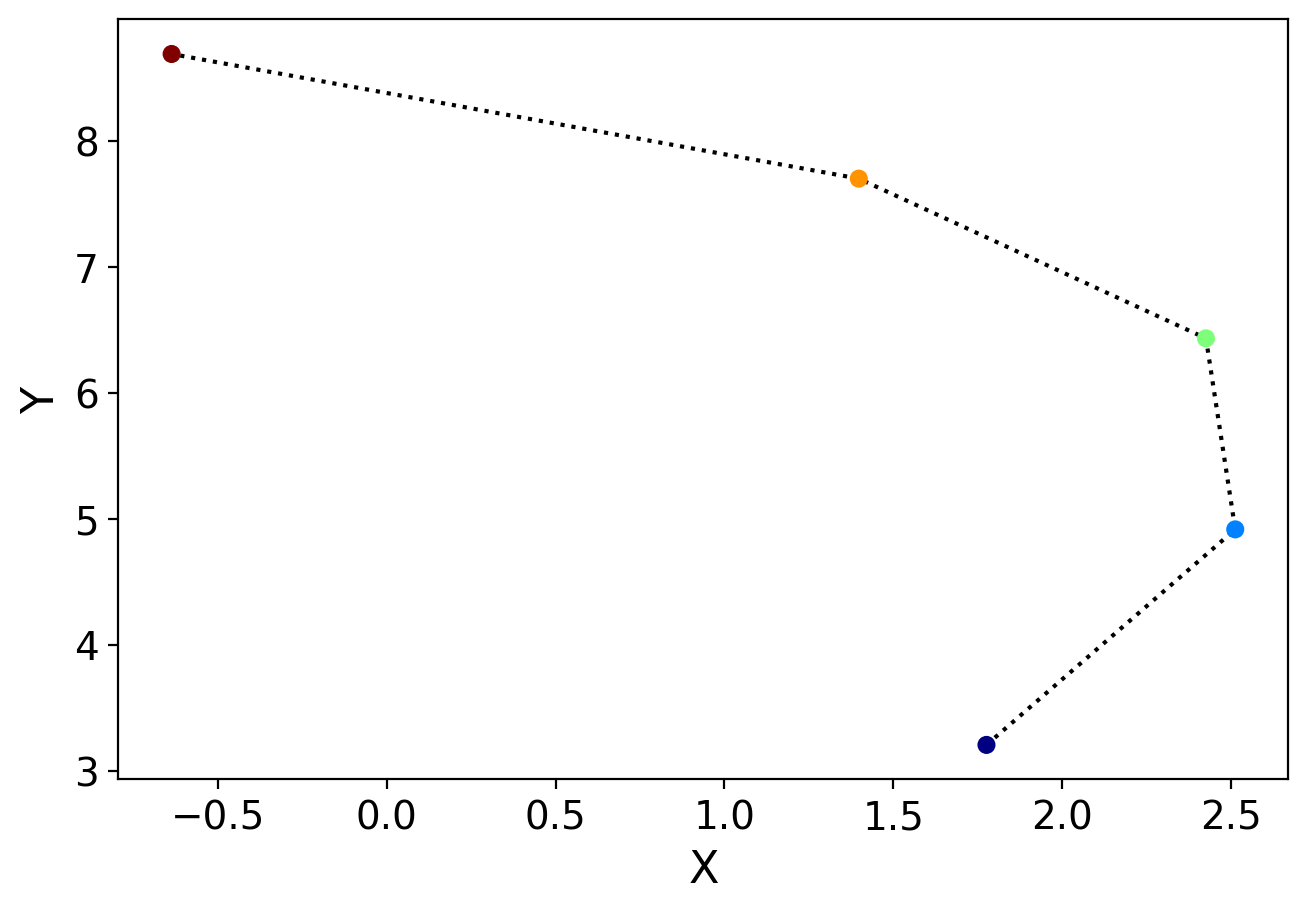

True


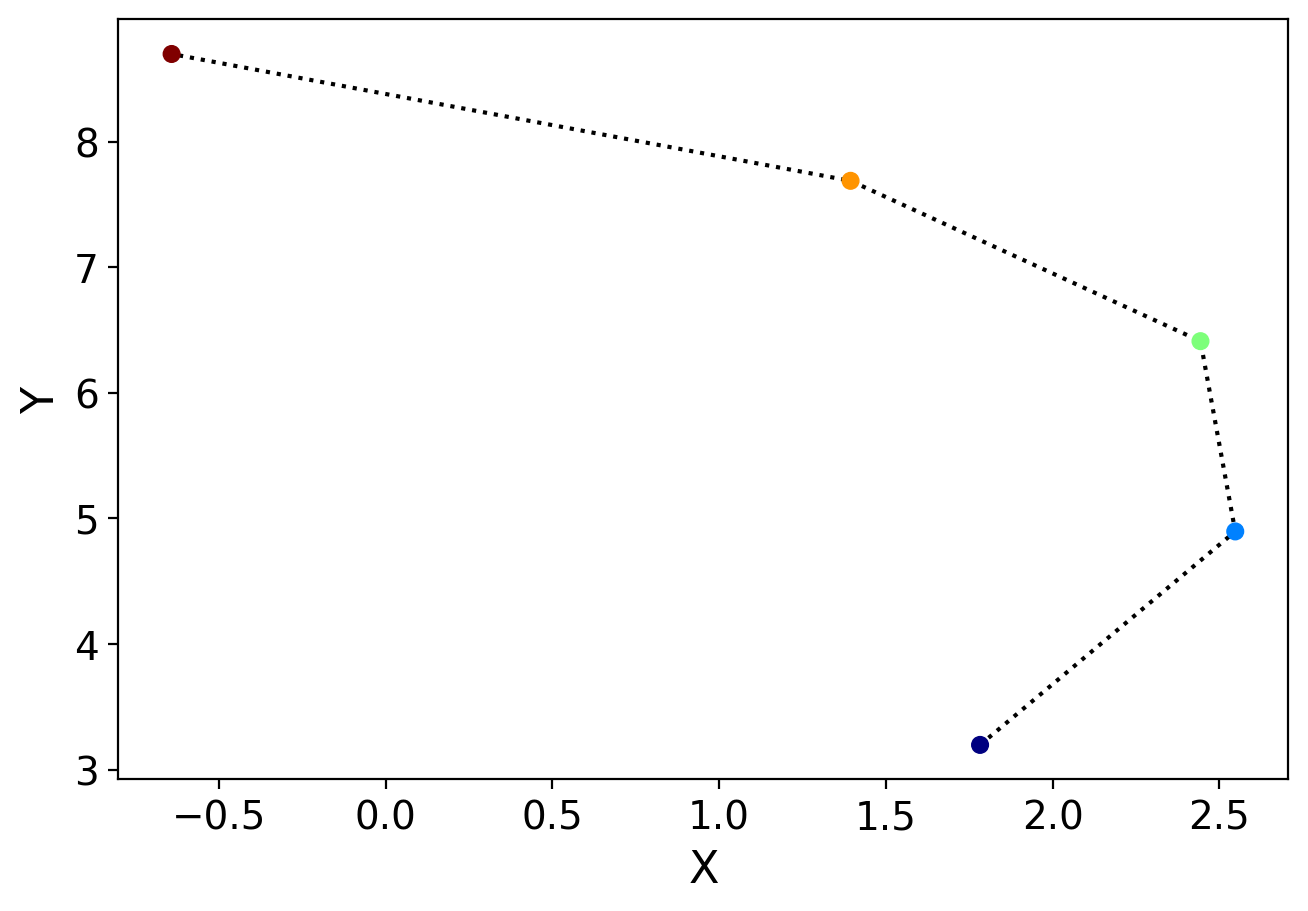

False
X0: 12


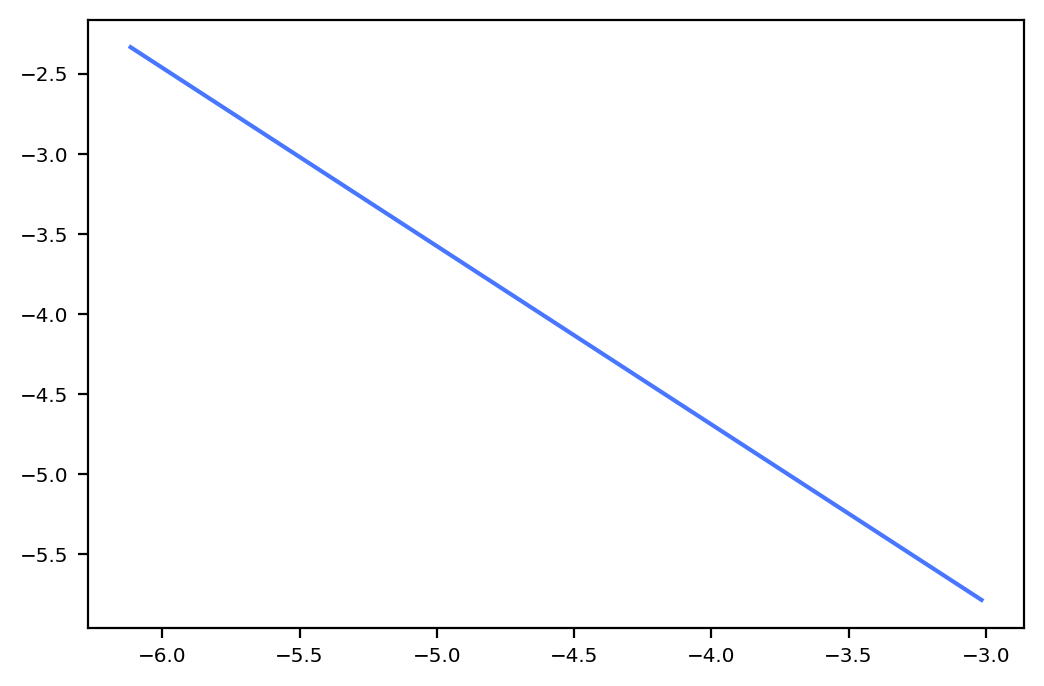

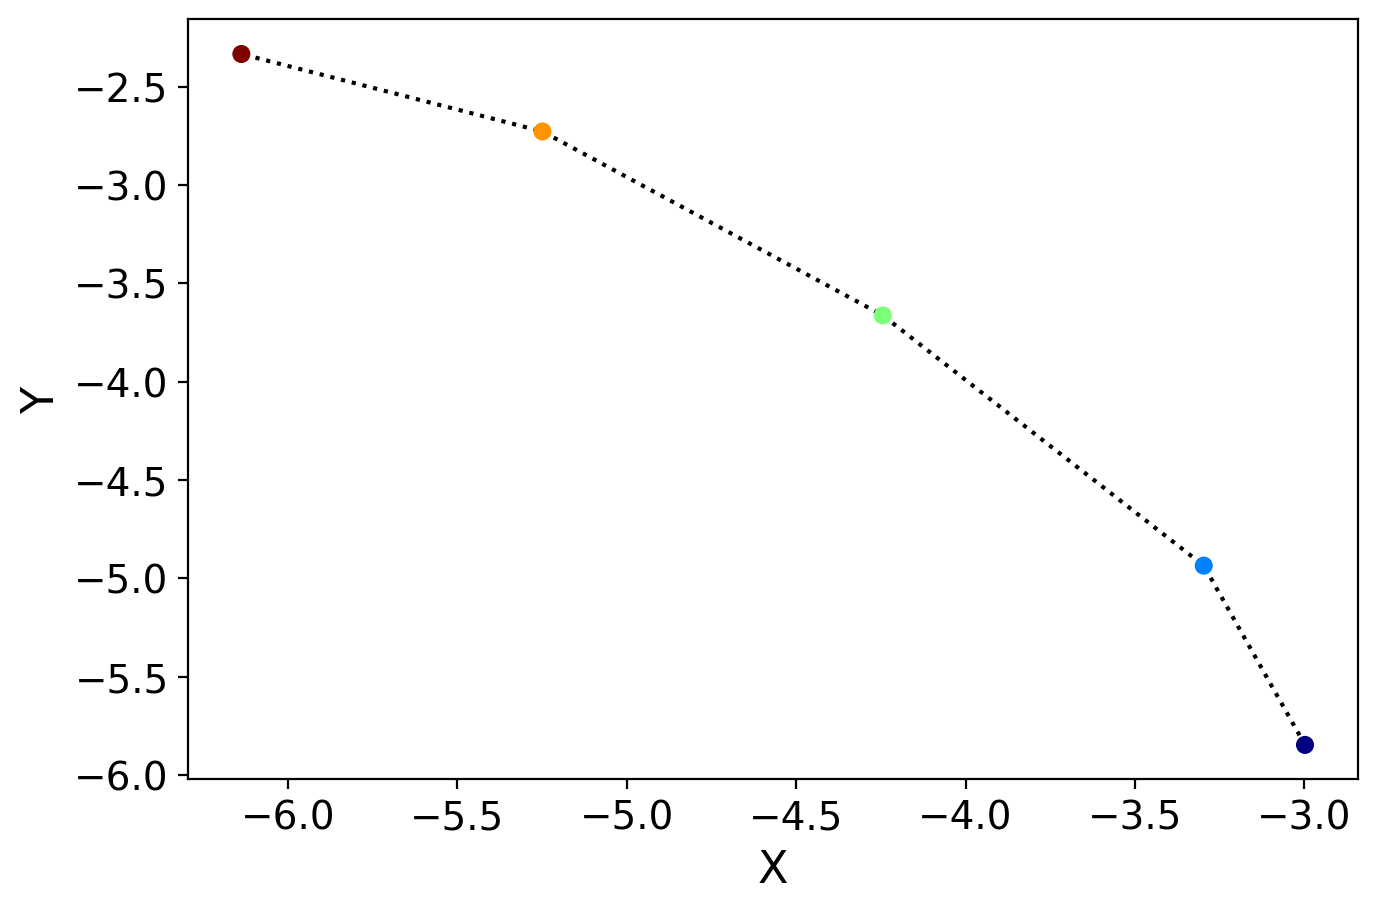

True


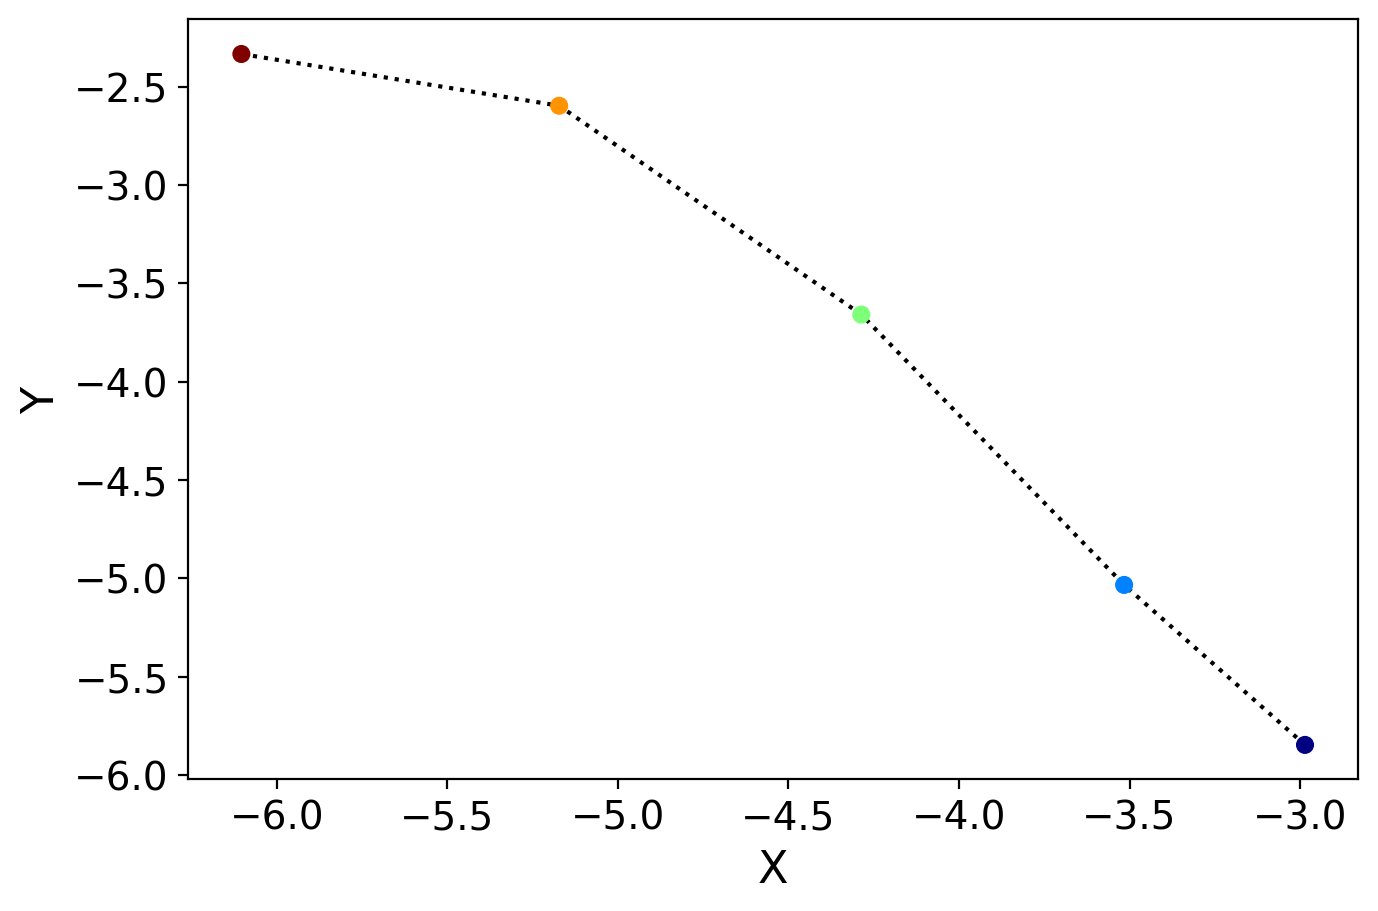

True


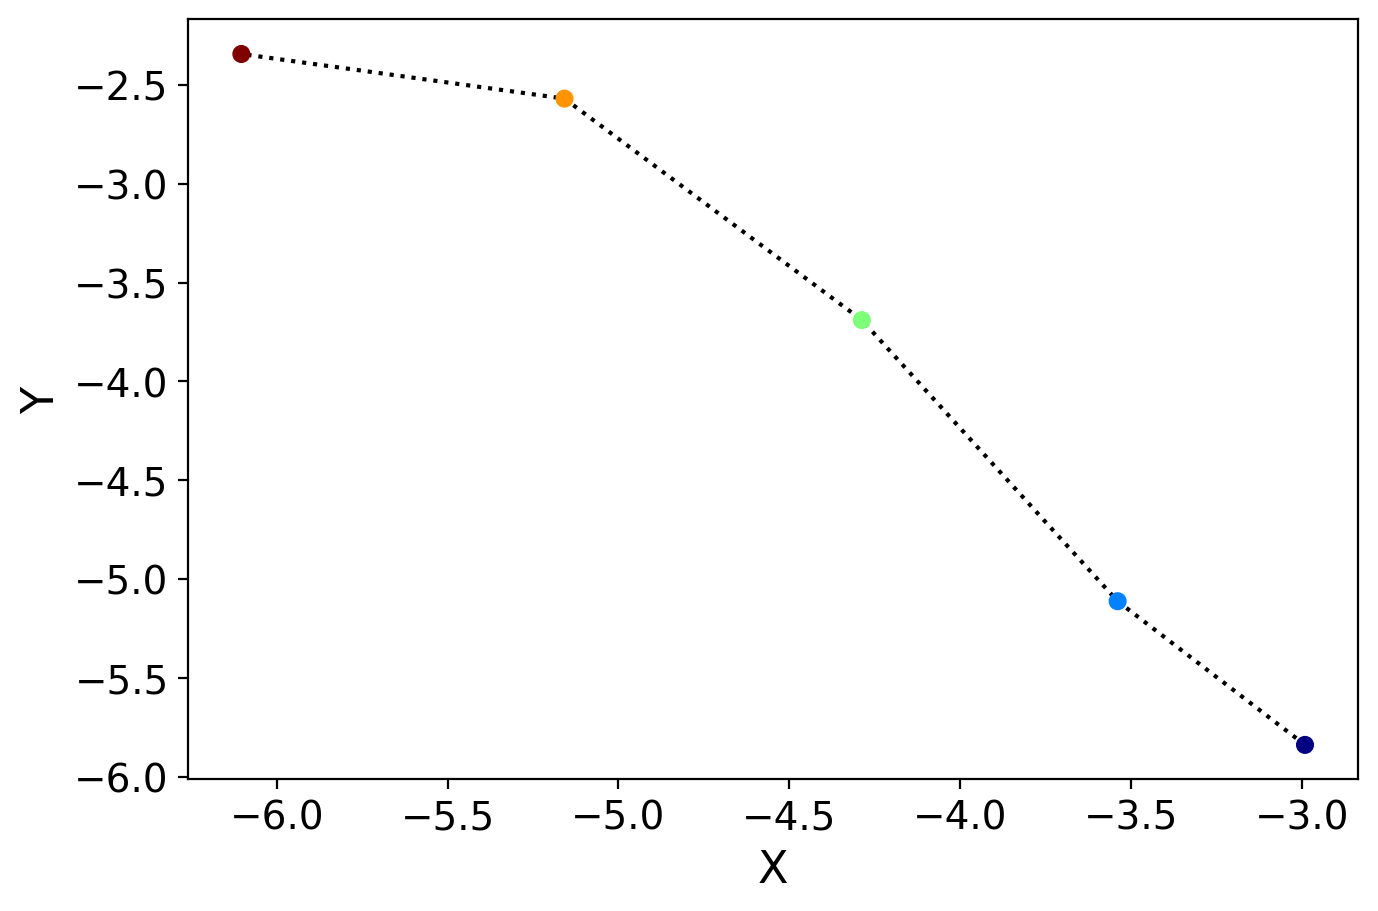

True


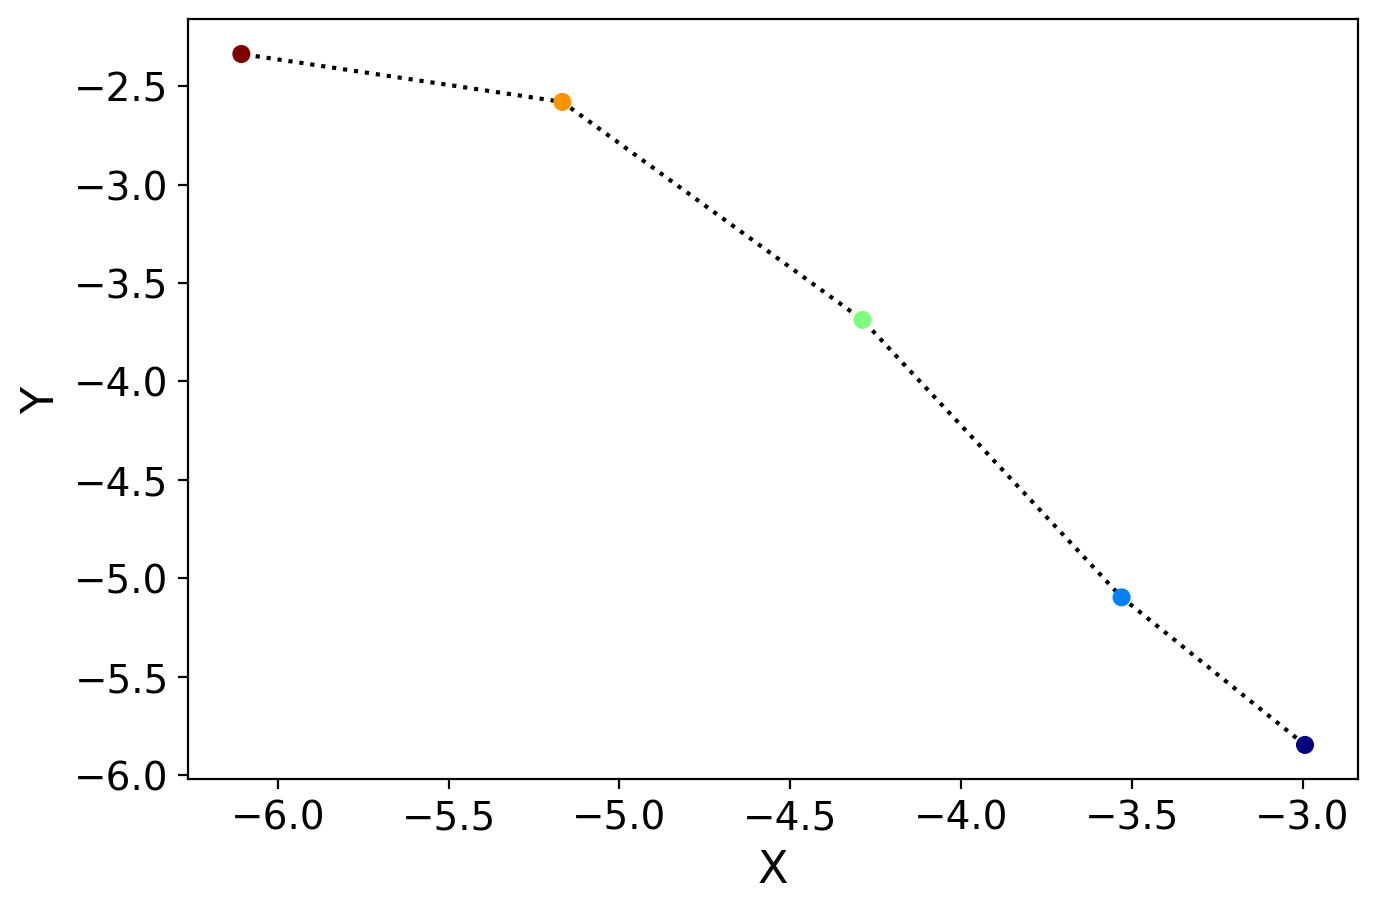

False
X0: 19


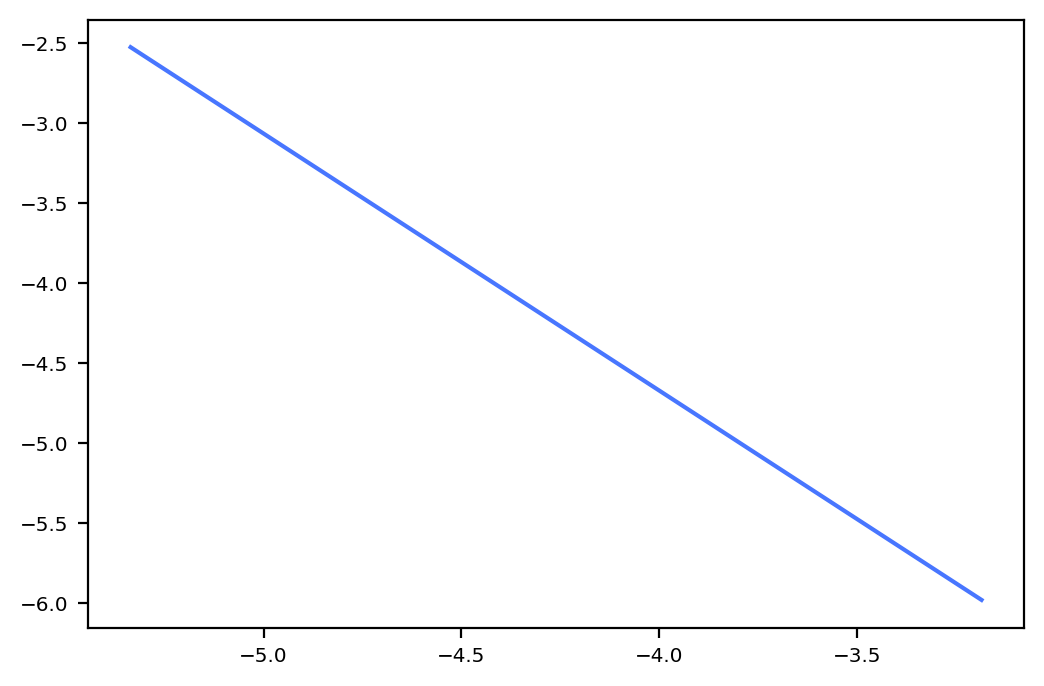

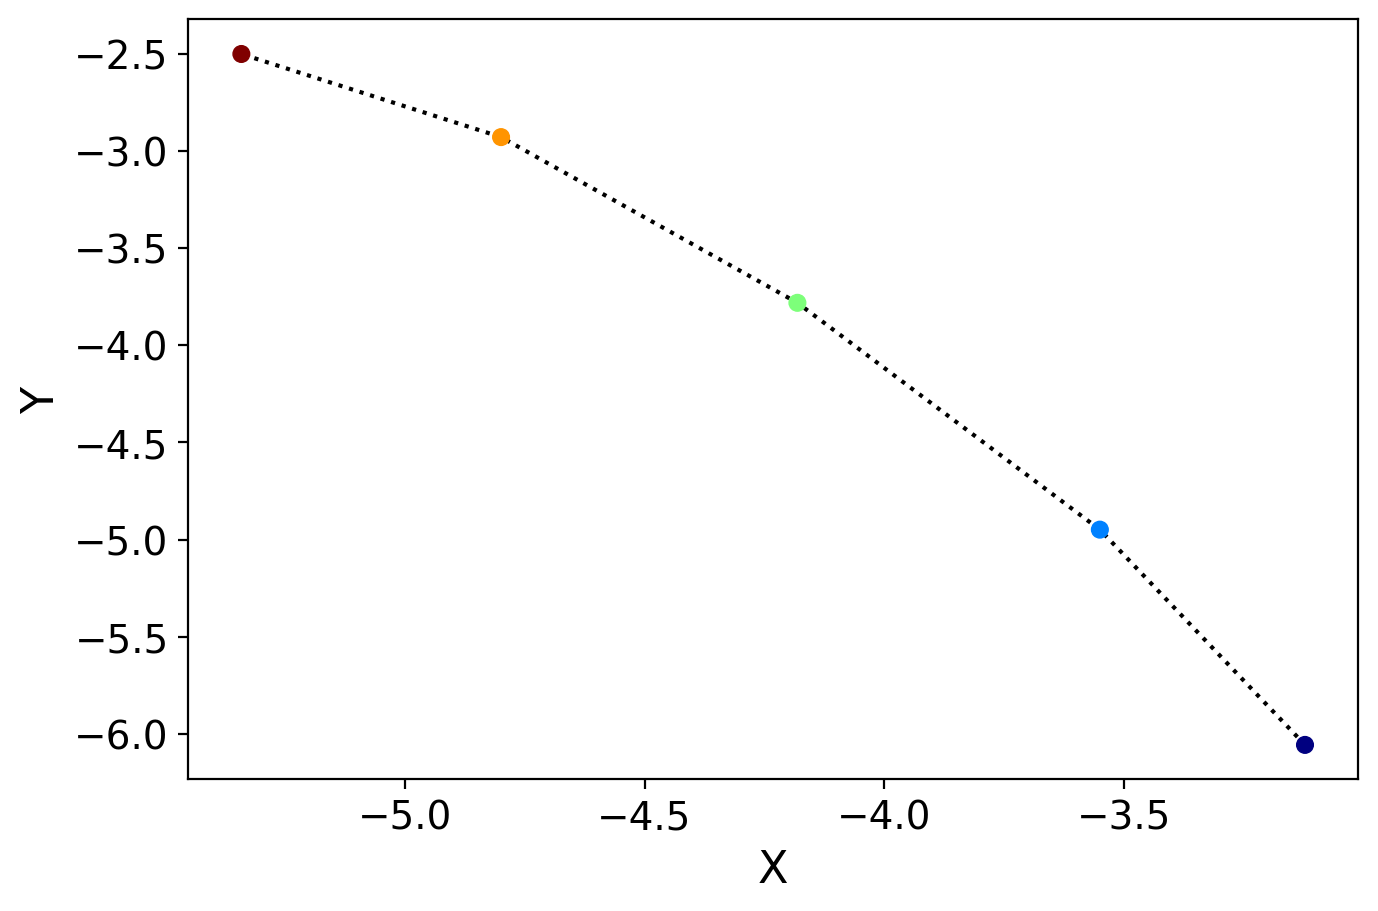

True


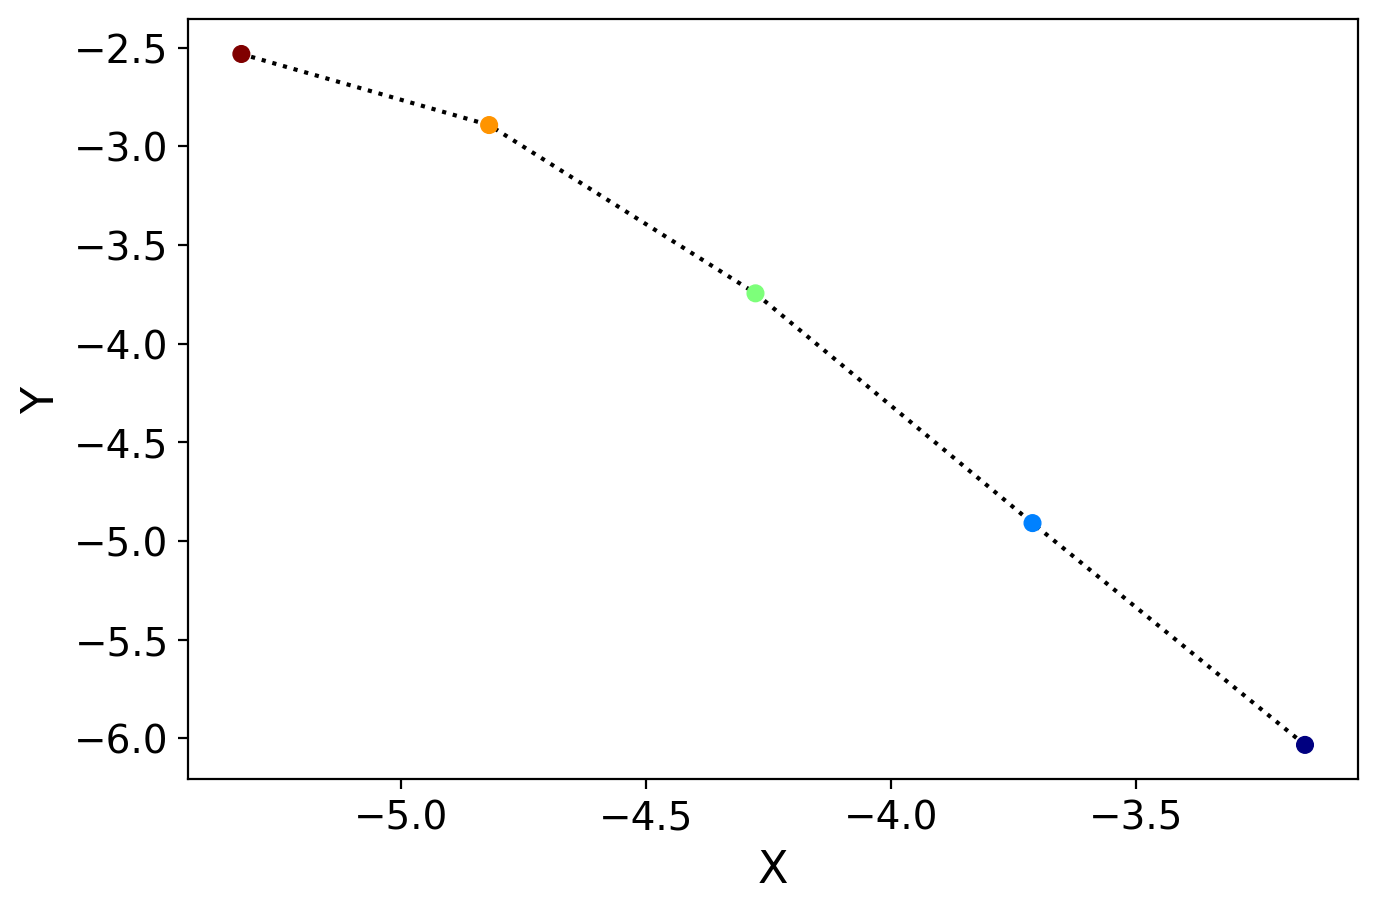

True


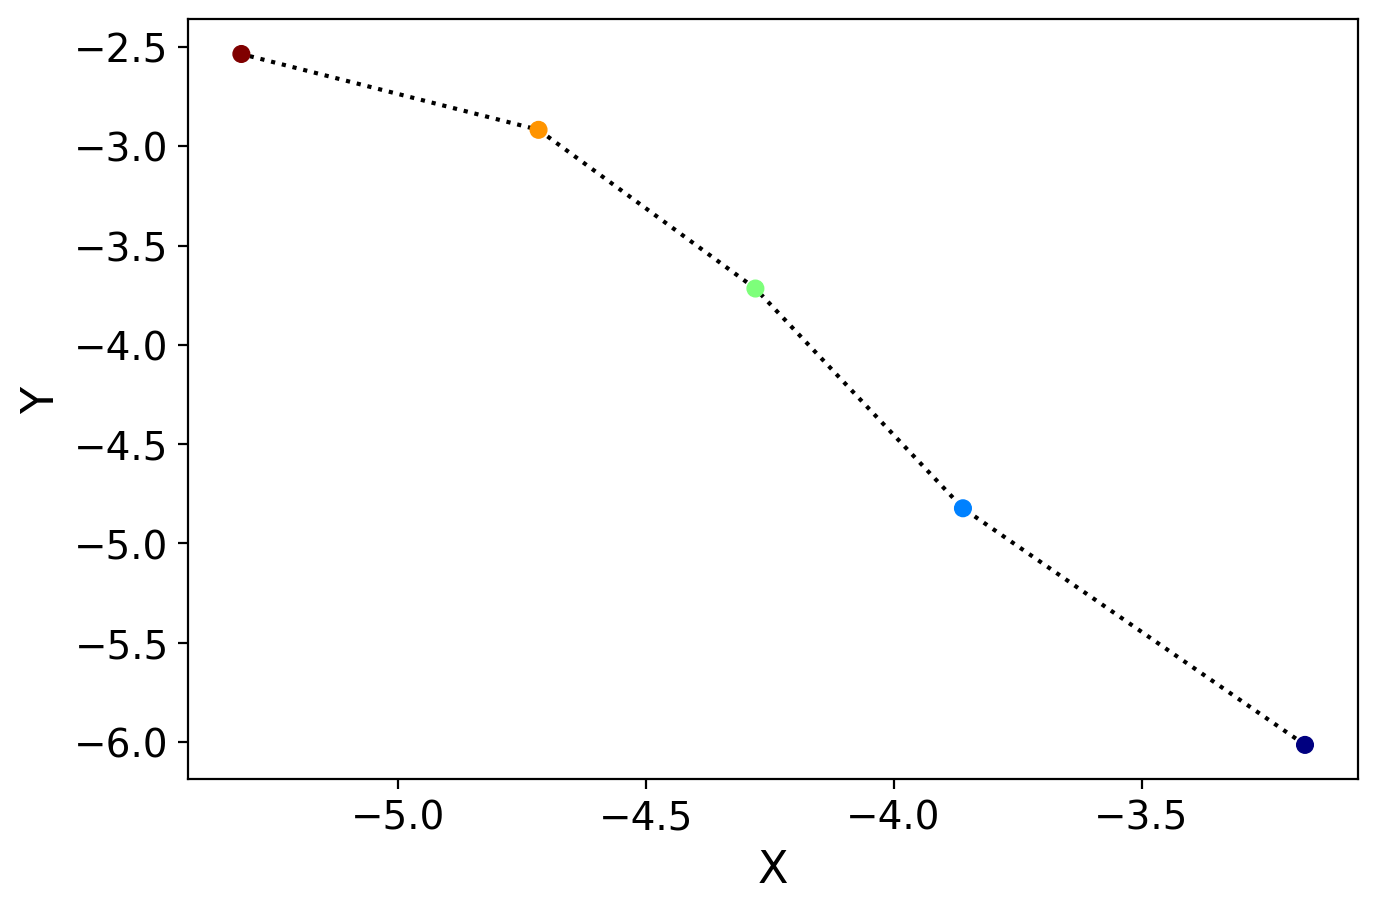

True


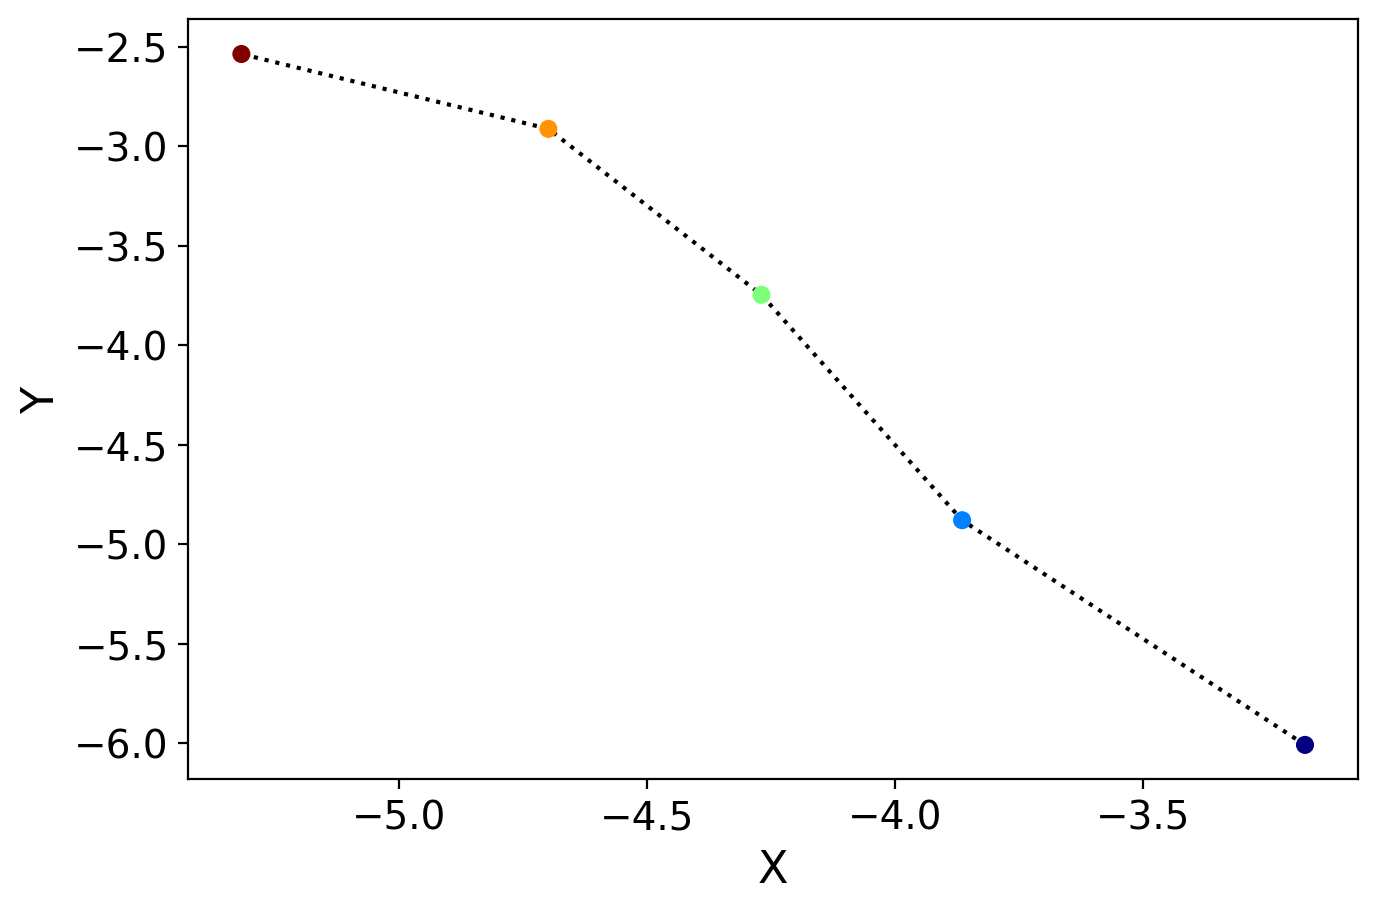

True


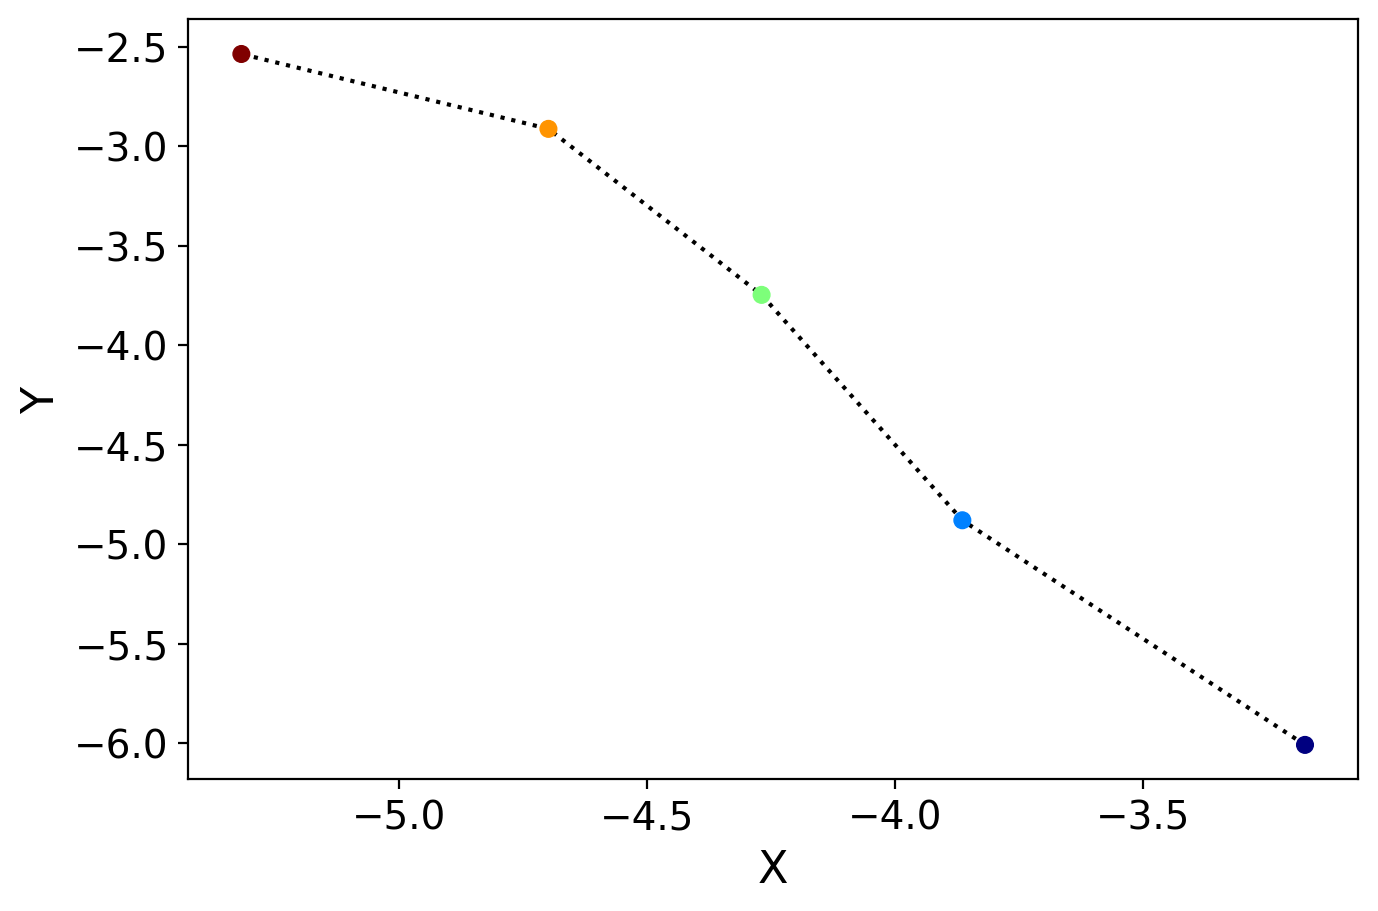

True


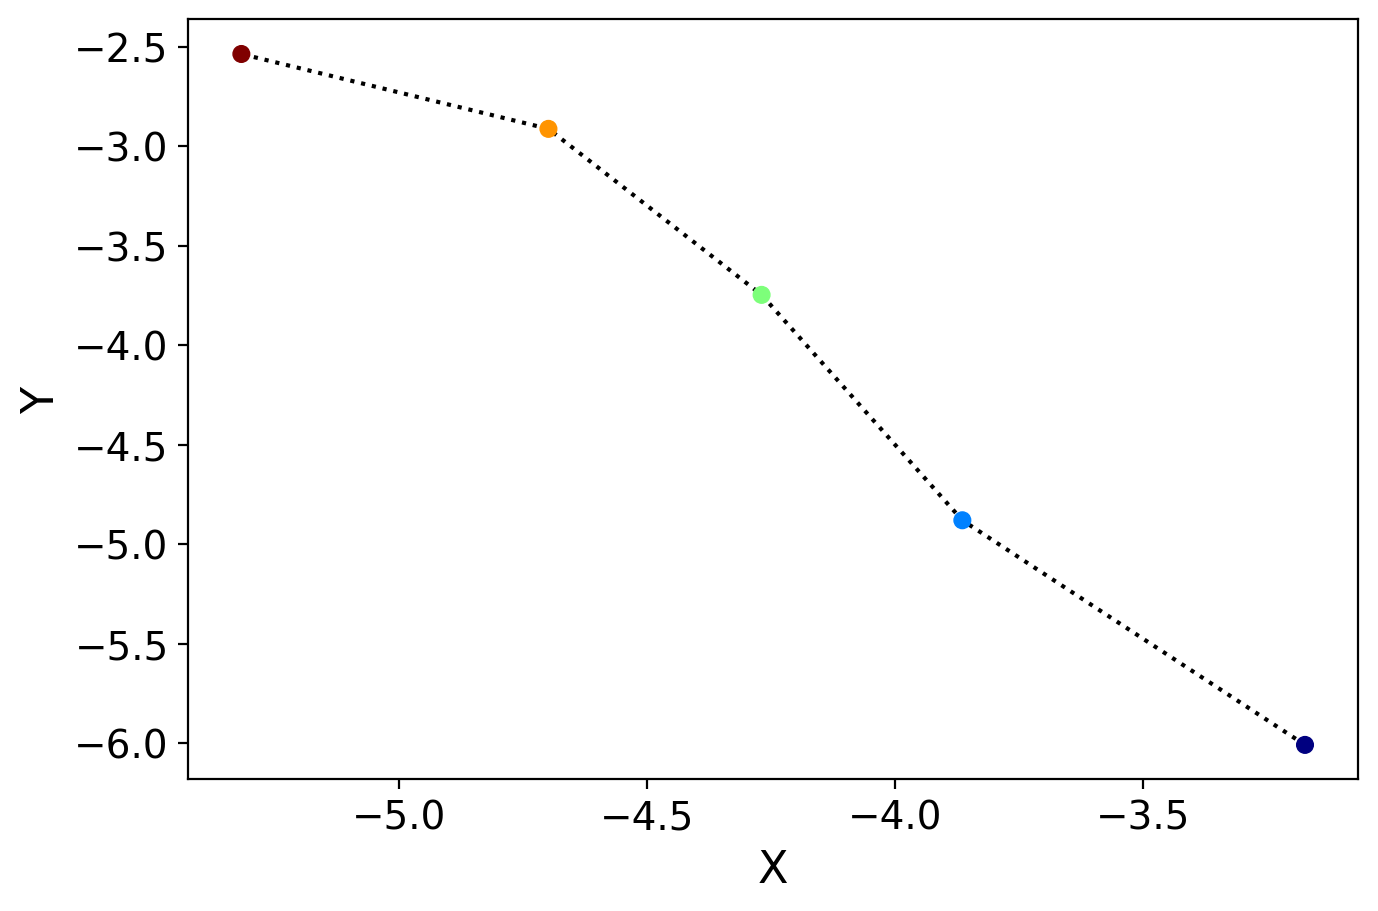

False
X0: 81


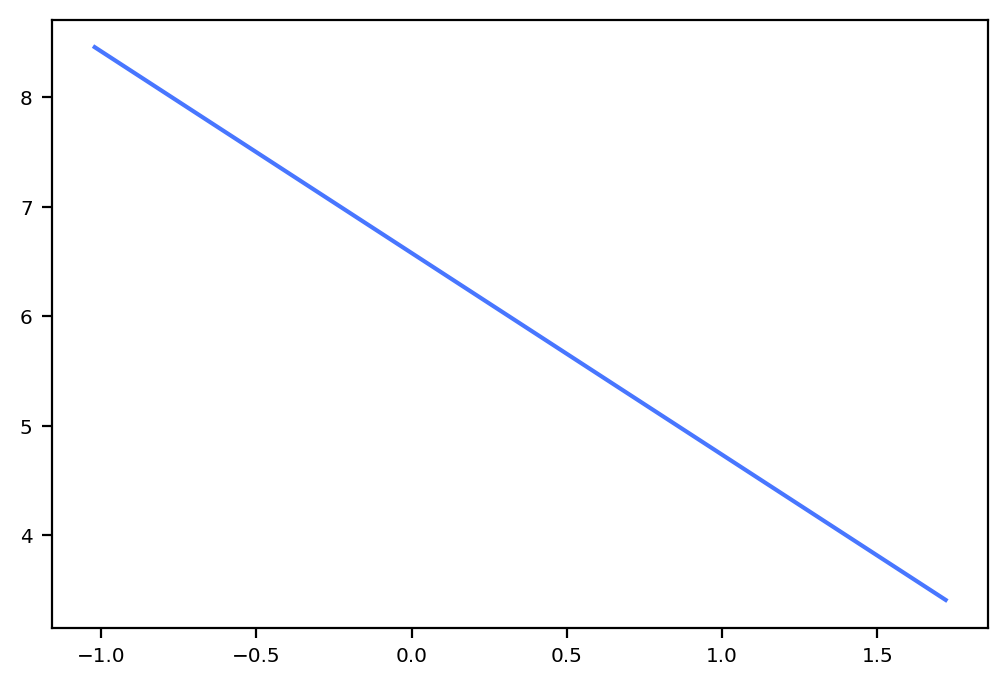

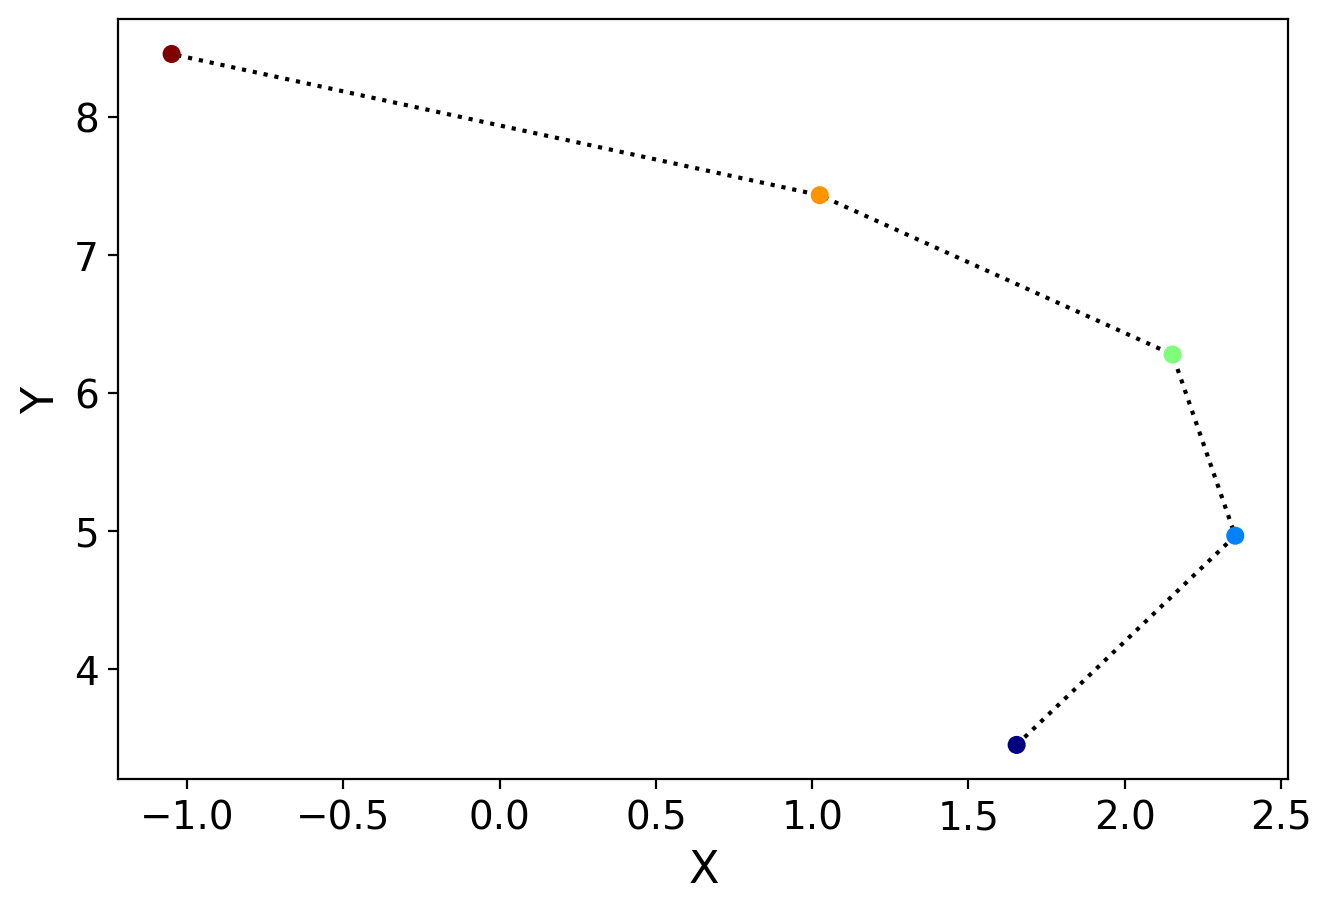

True


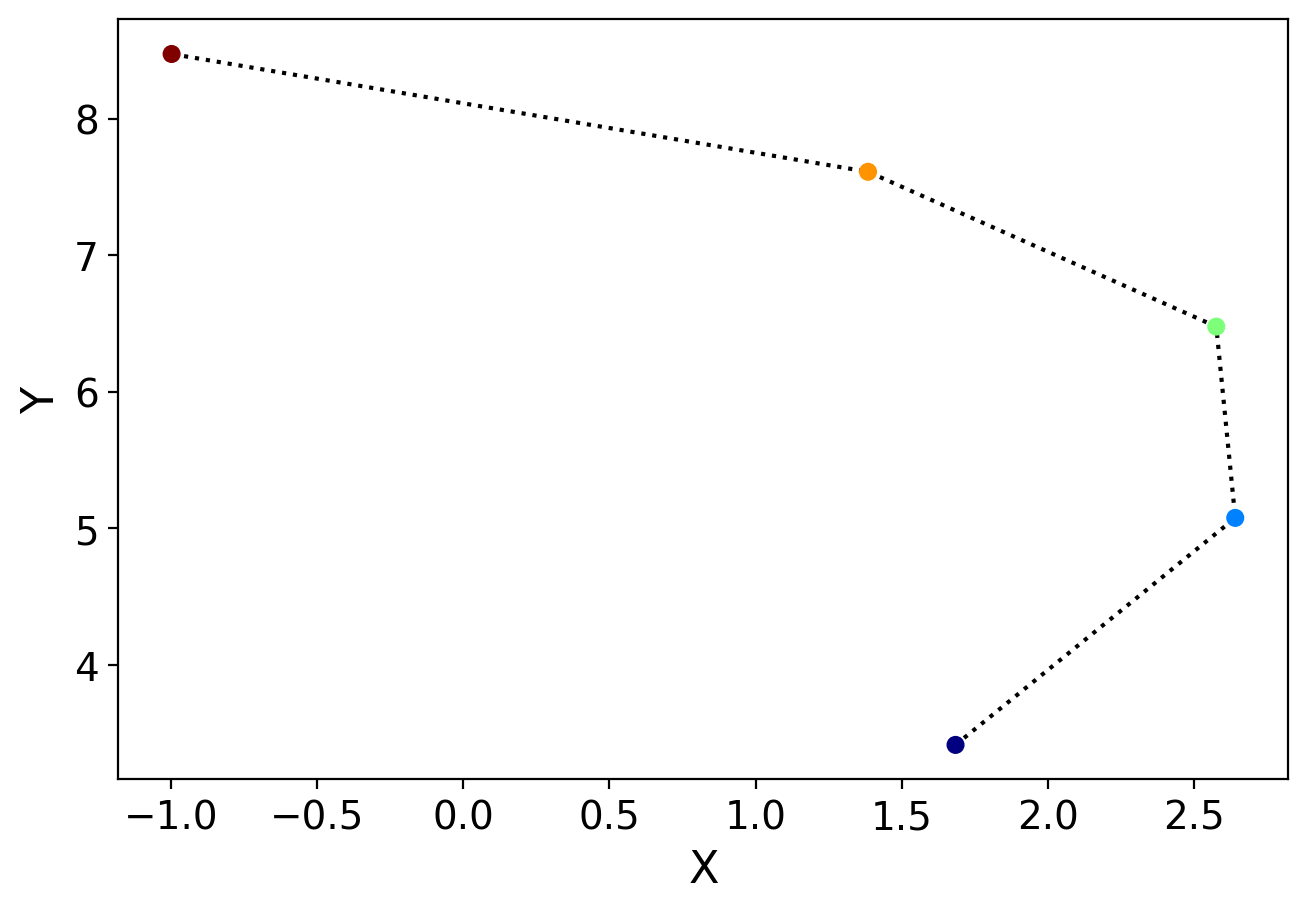

True


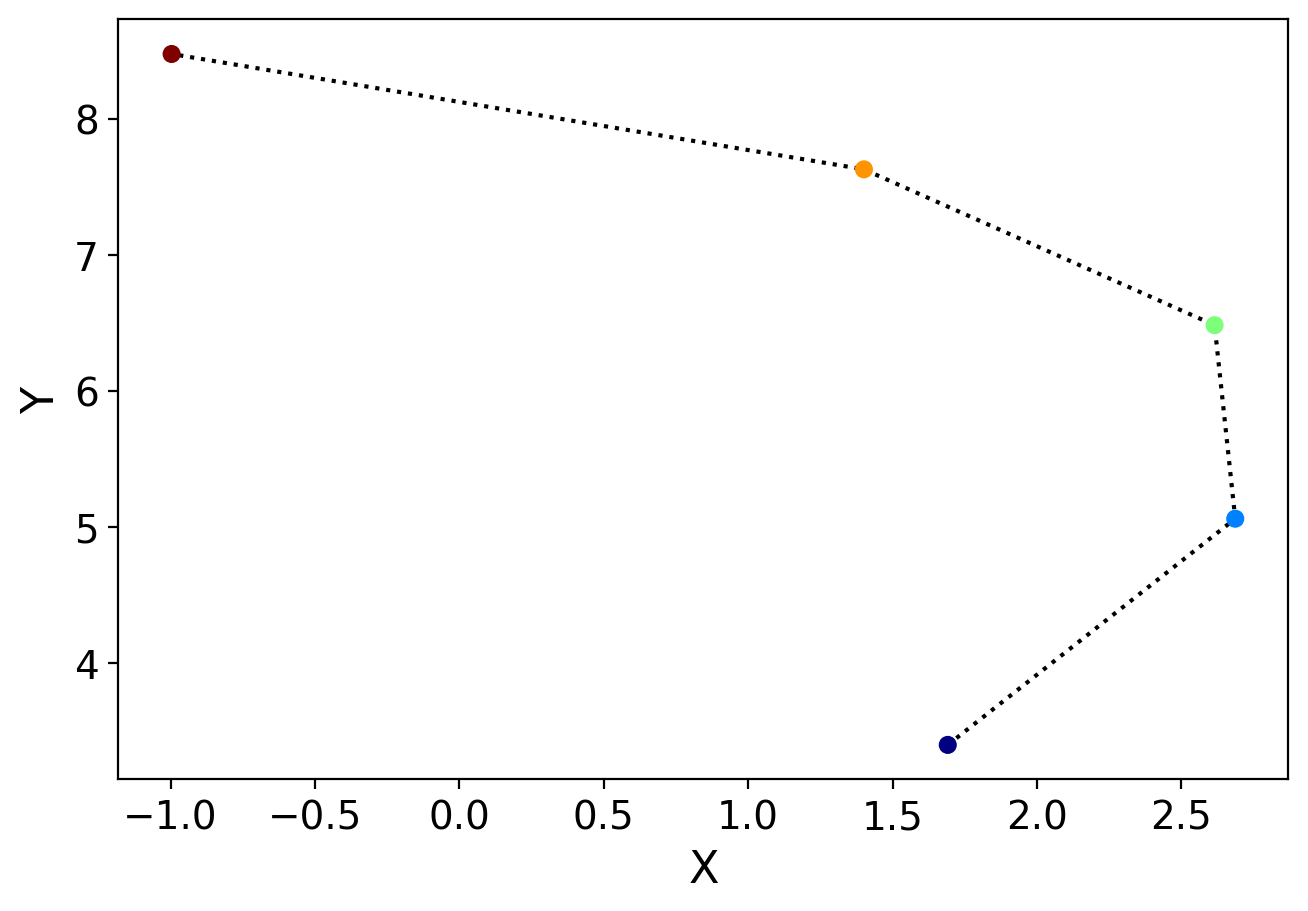

True


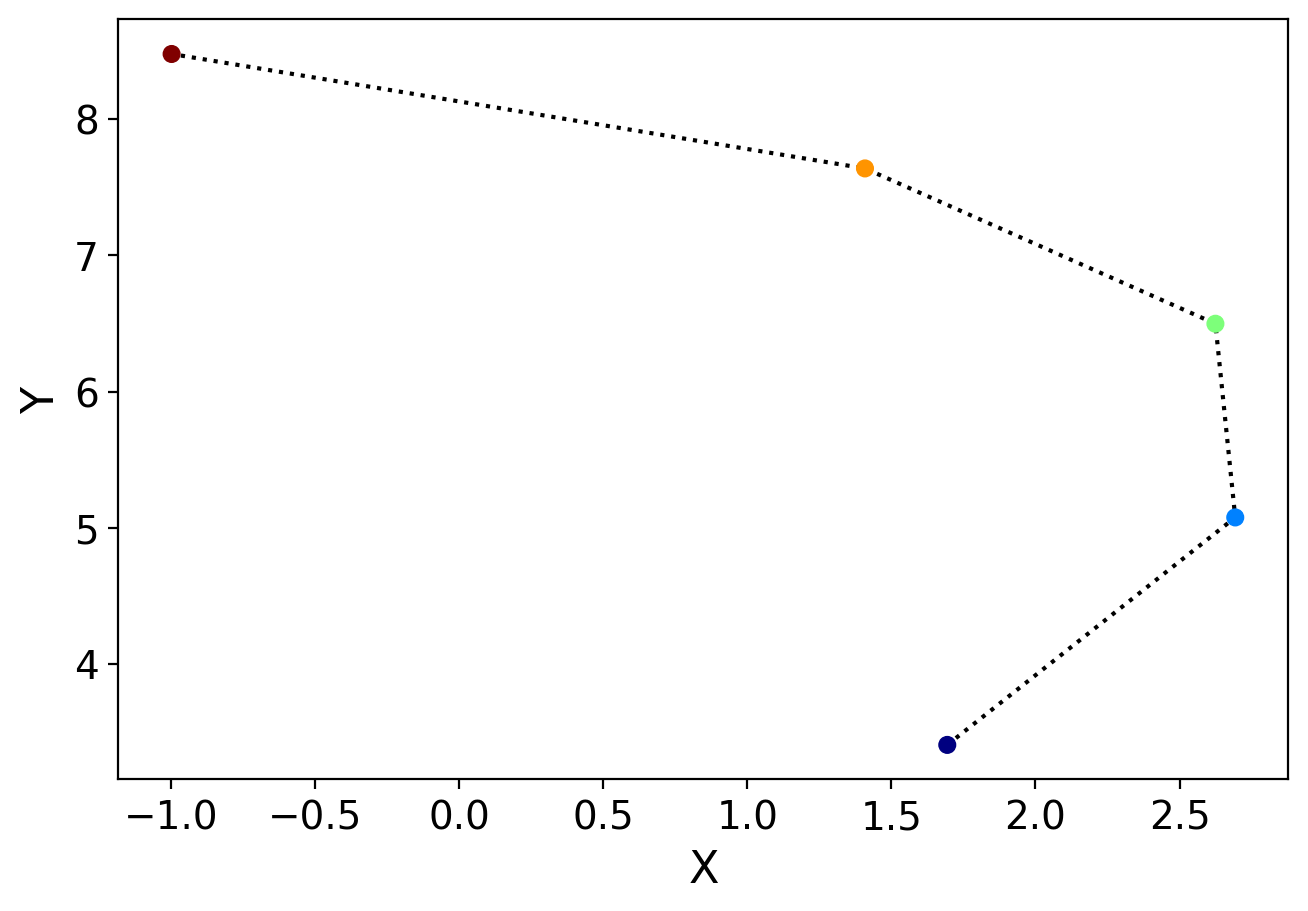

True


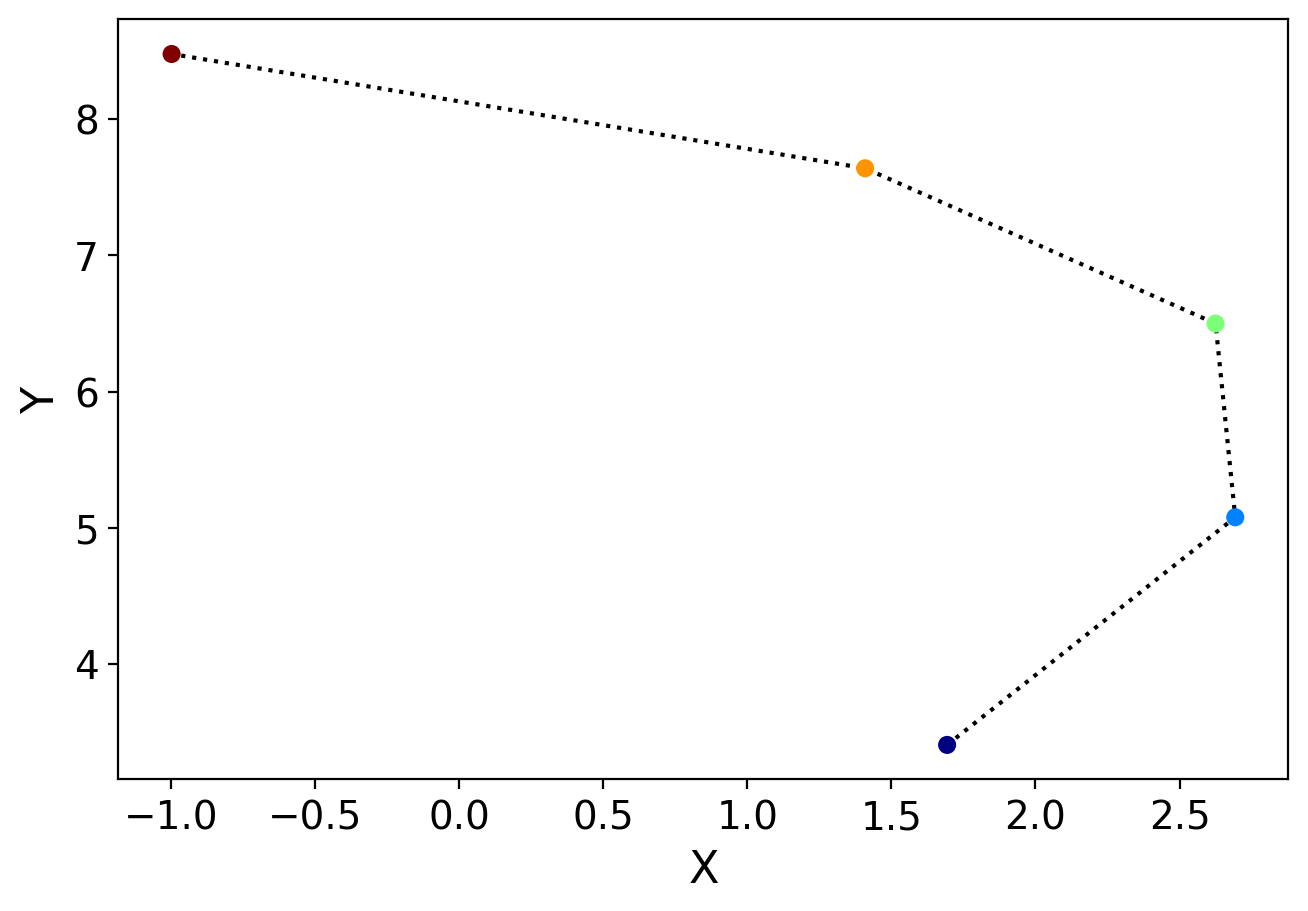

False
X0: 84


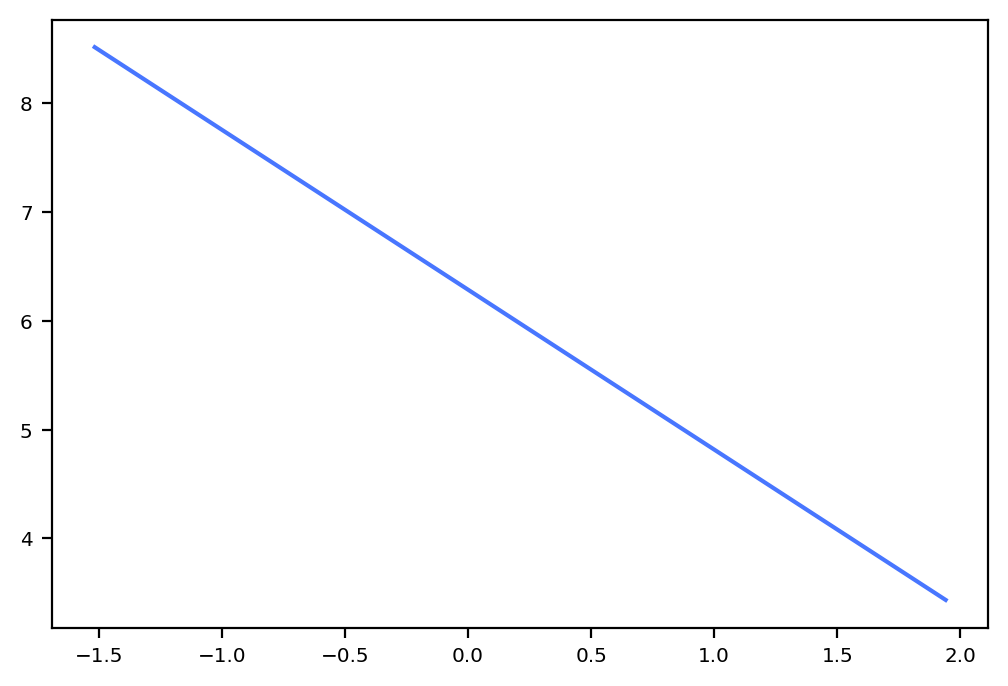

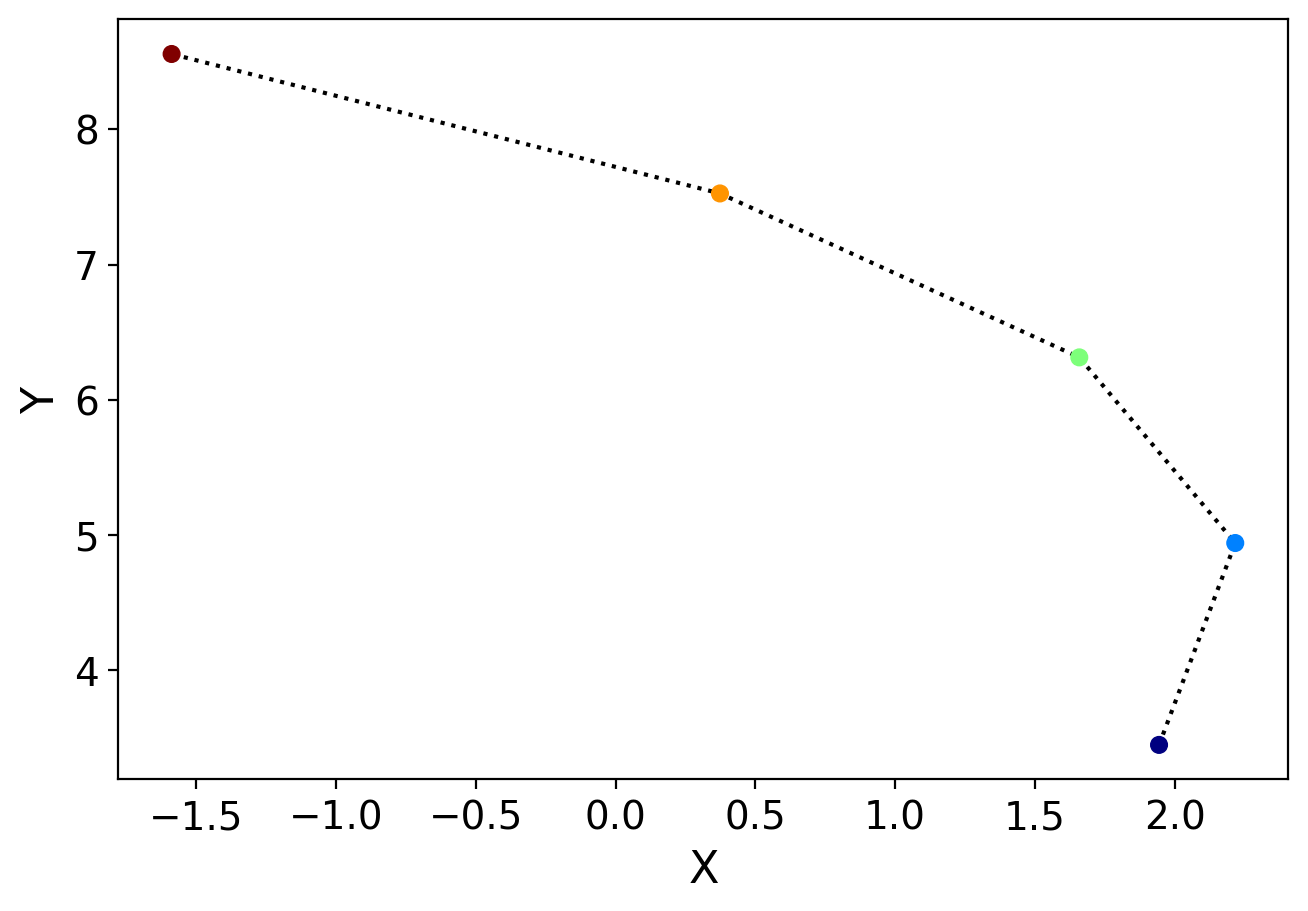

True


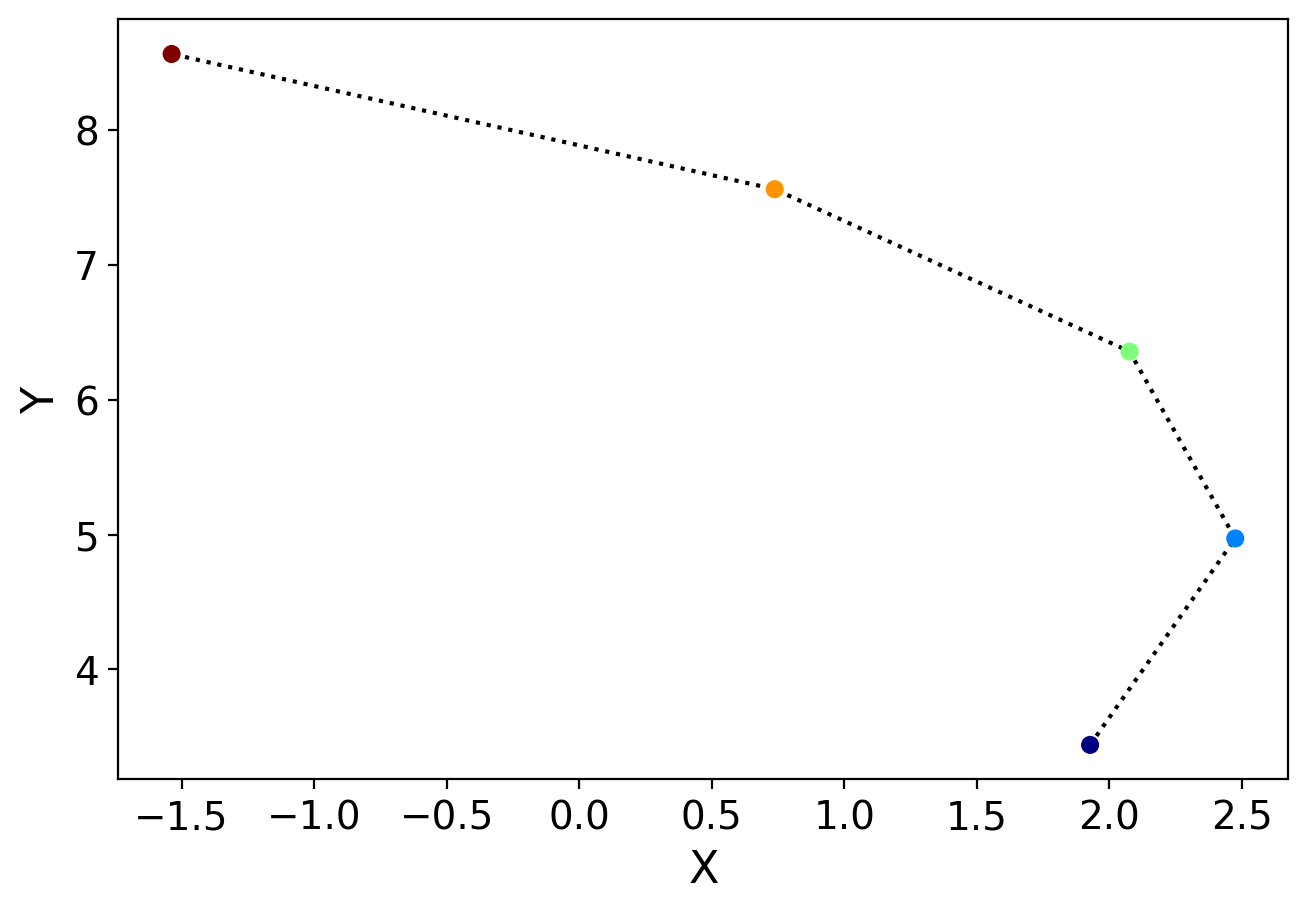

True


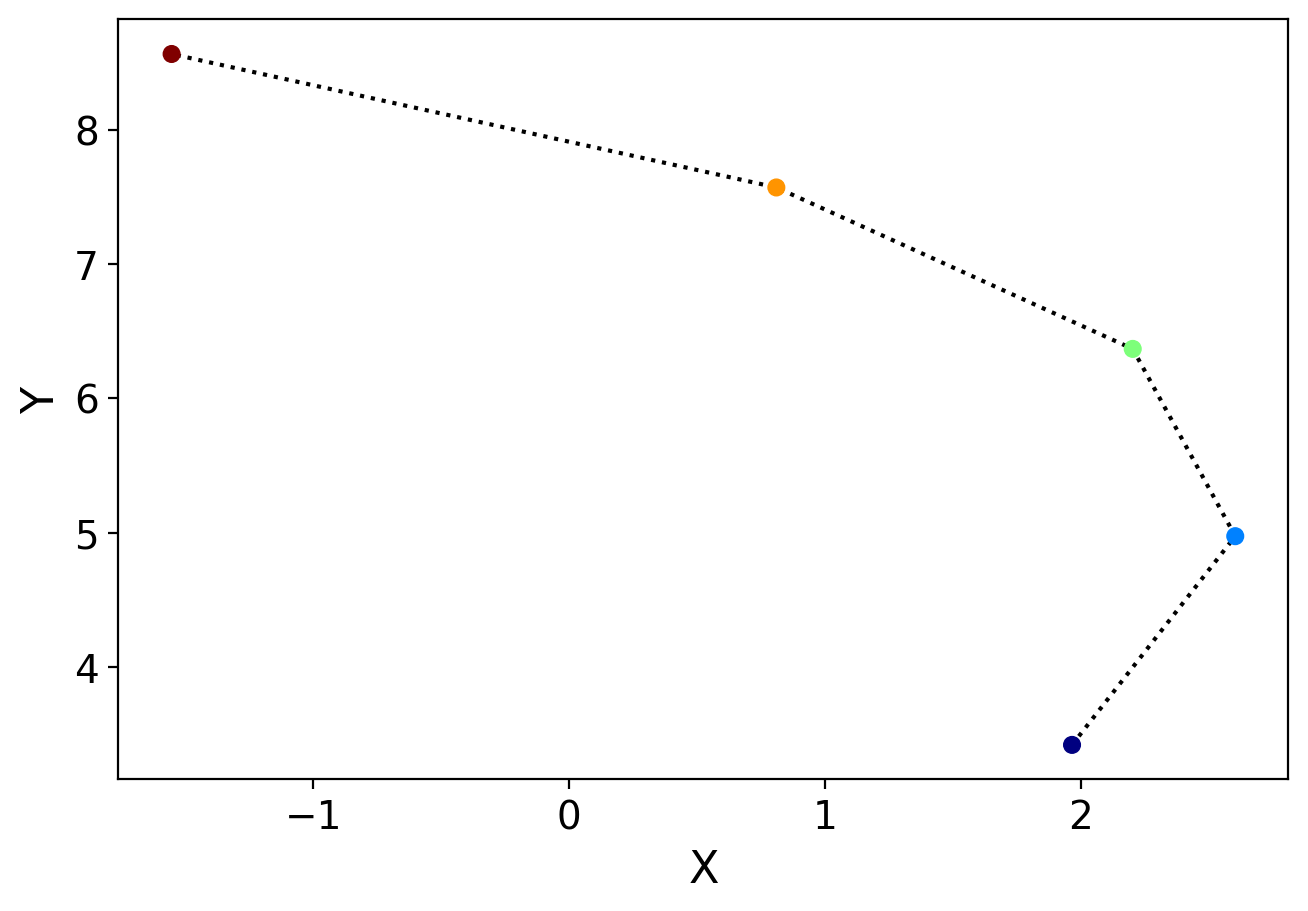

True


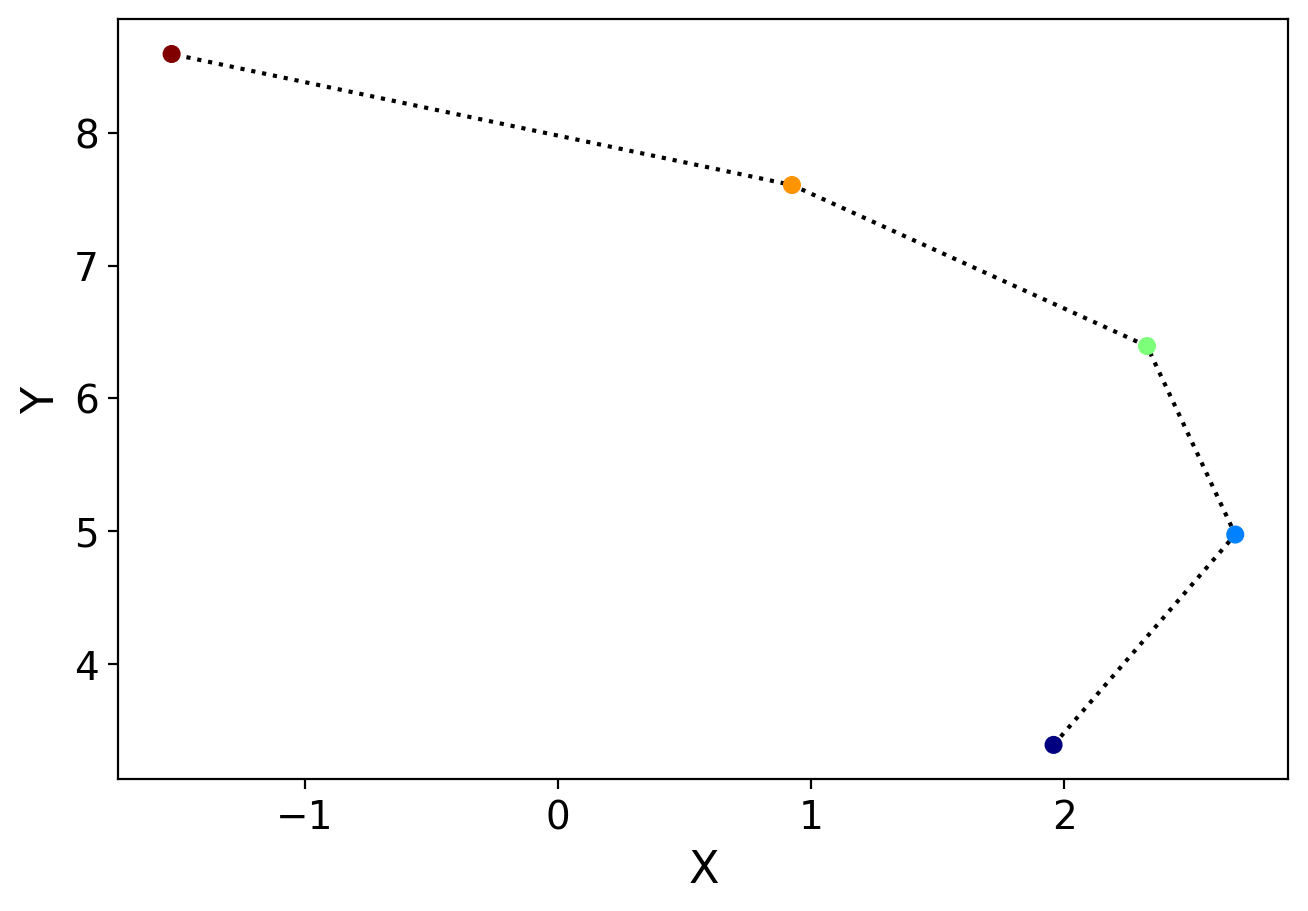

True


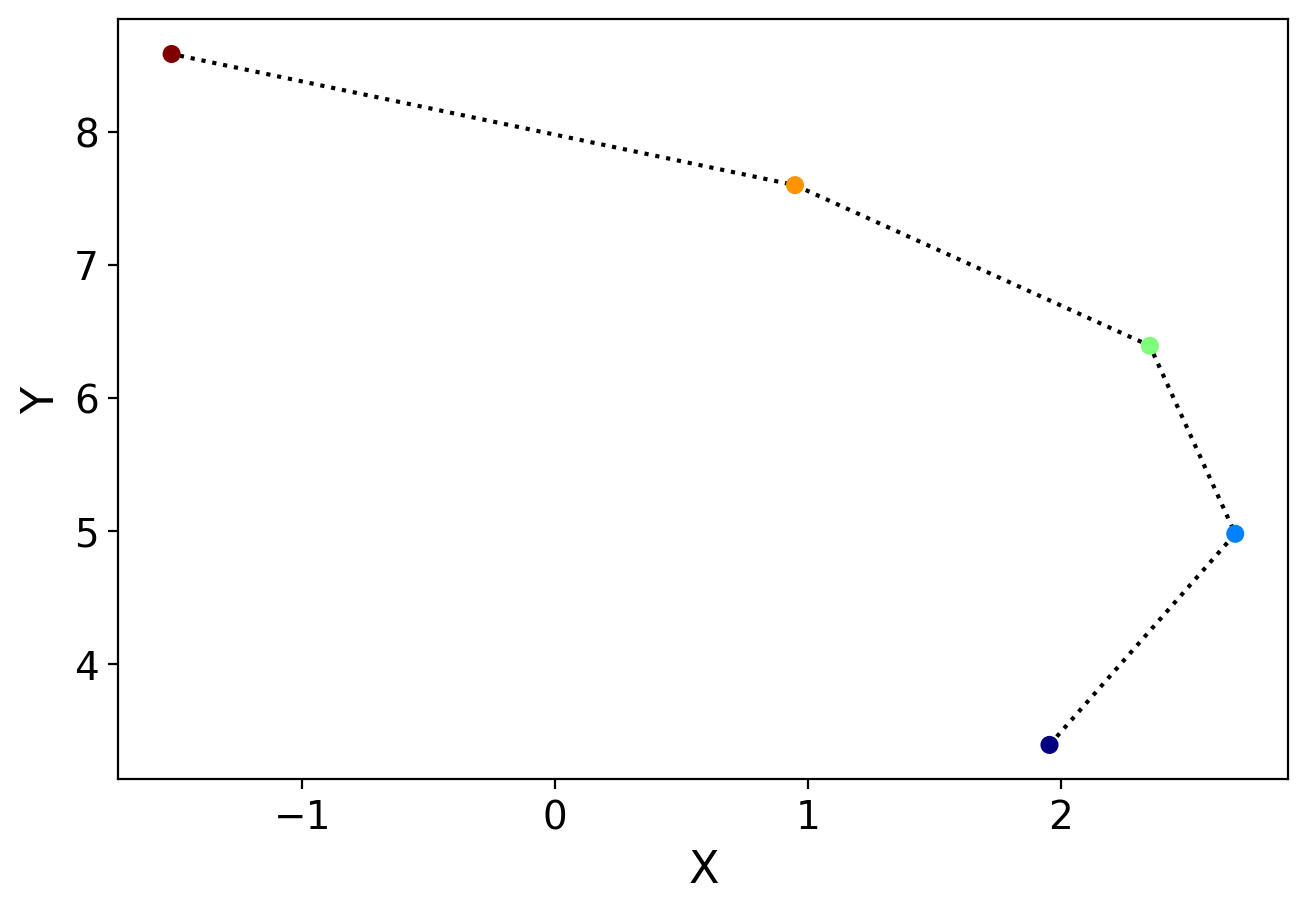

True


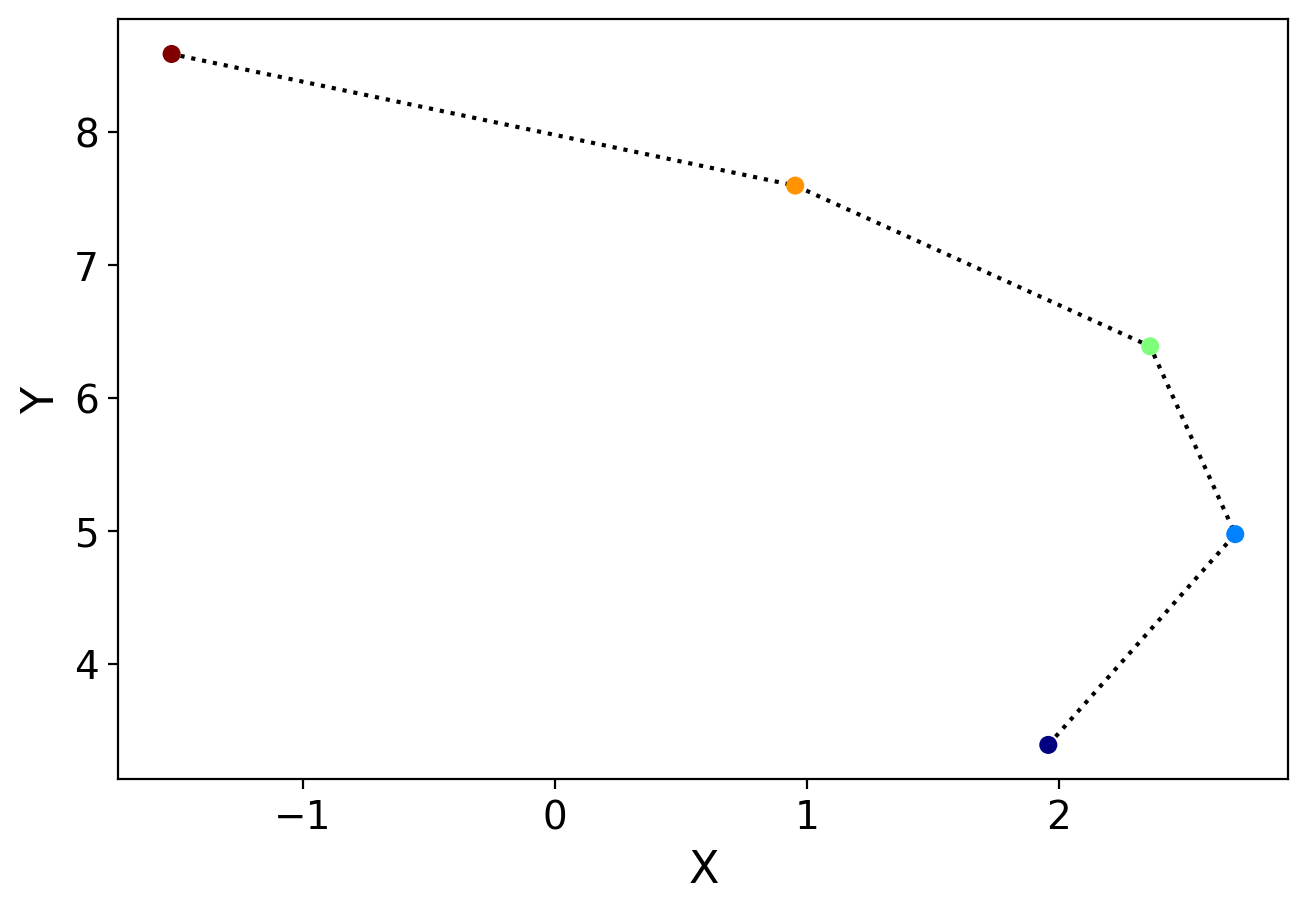

True


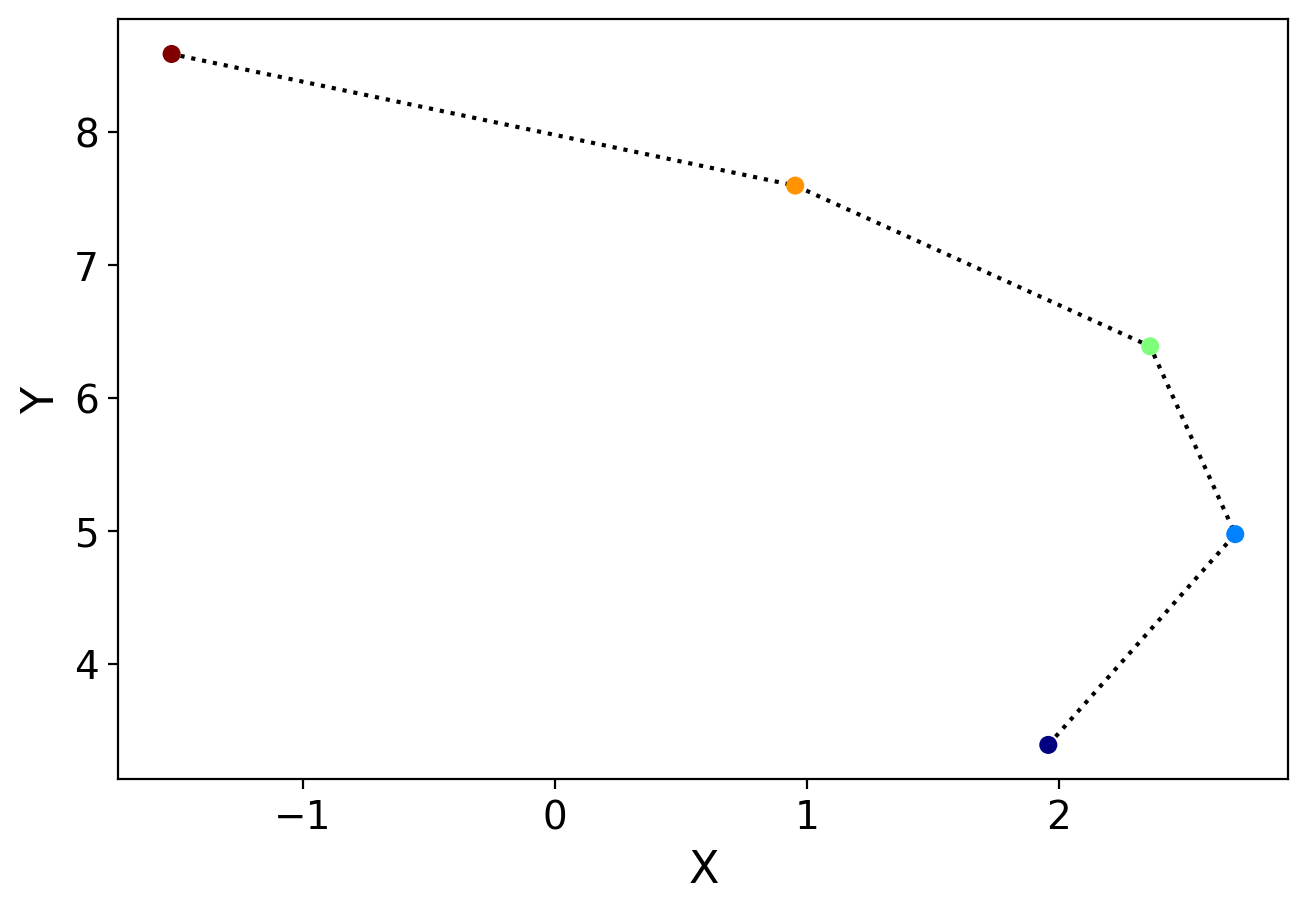

False
X0: 16


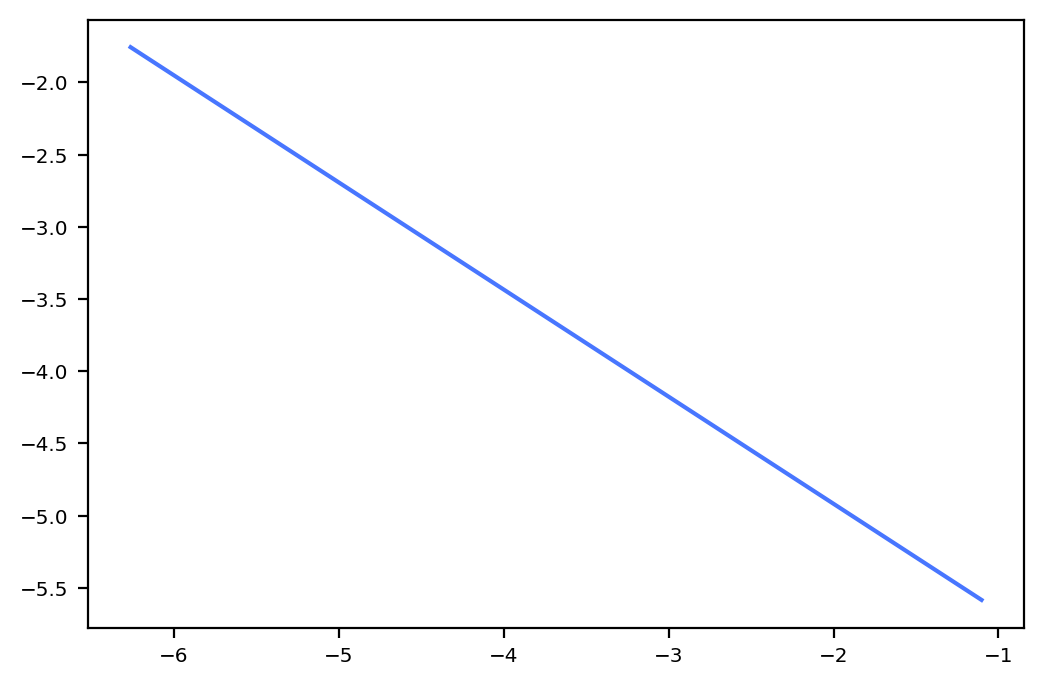

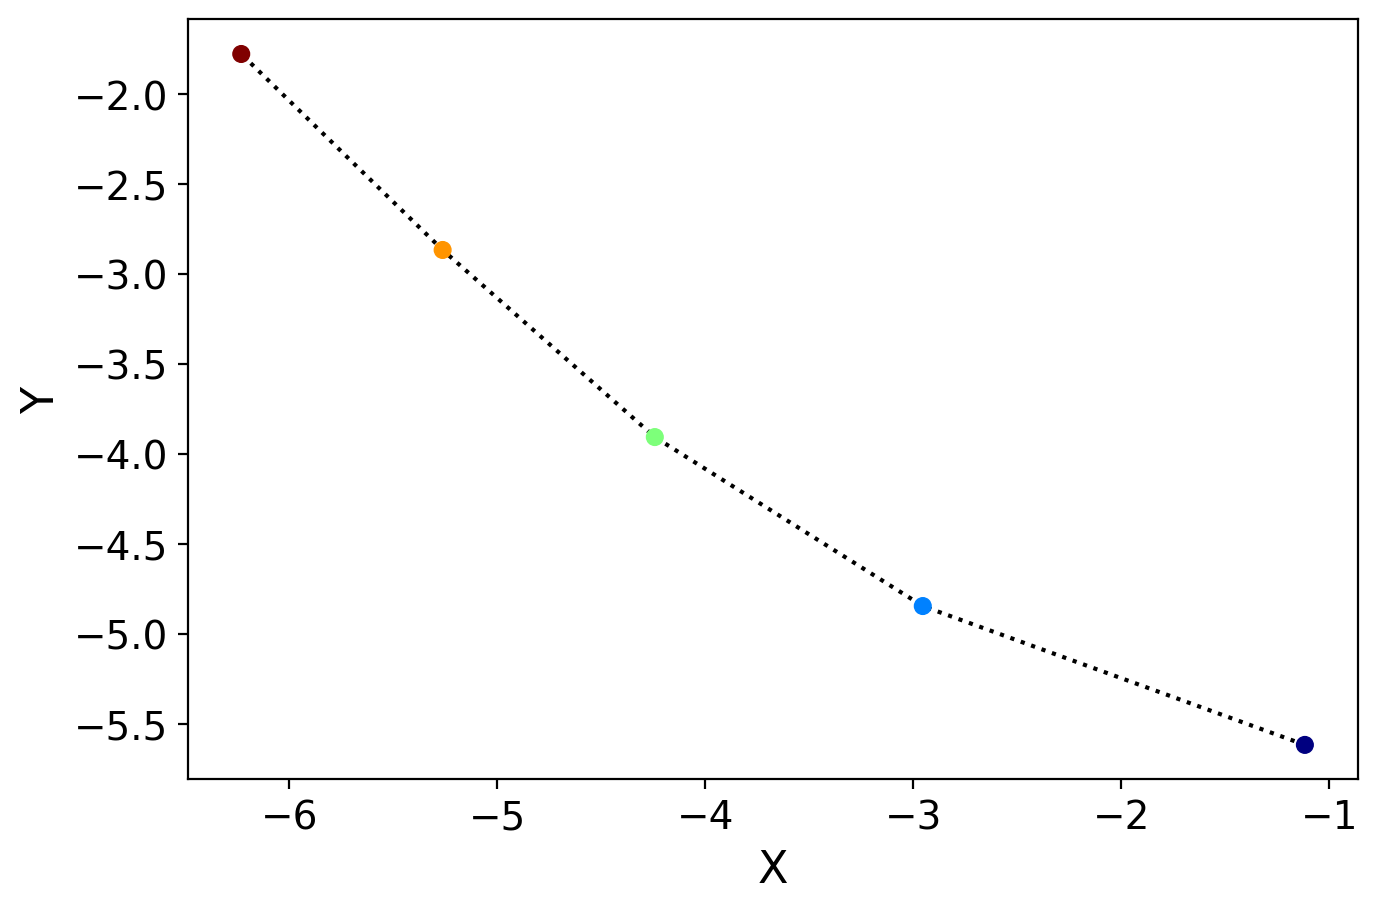

True


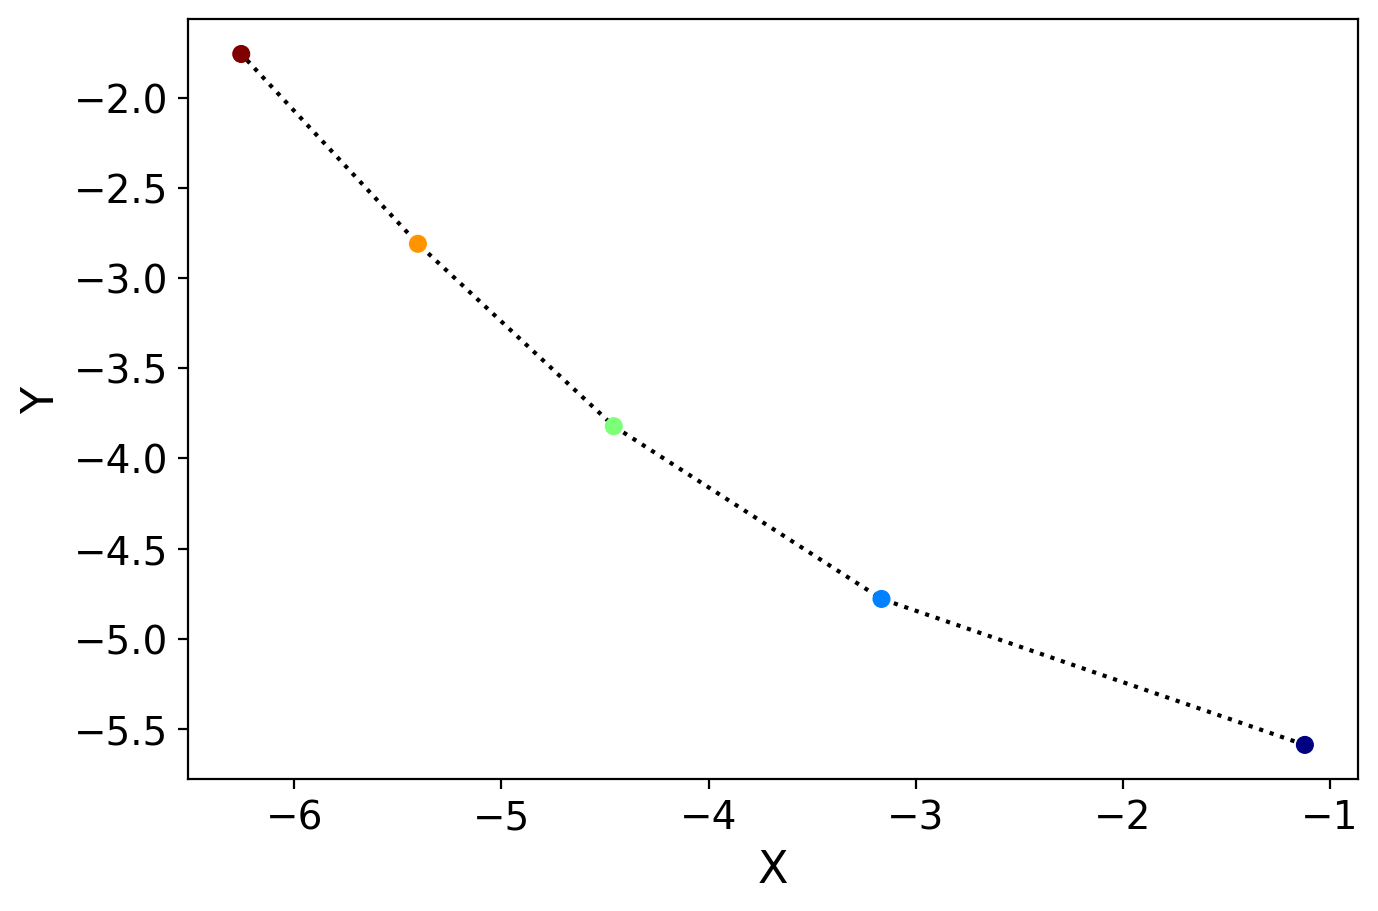

True


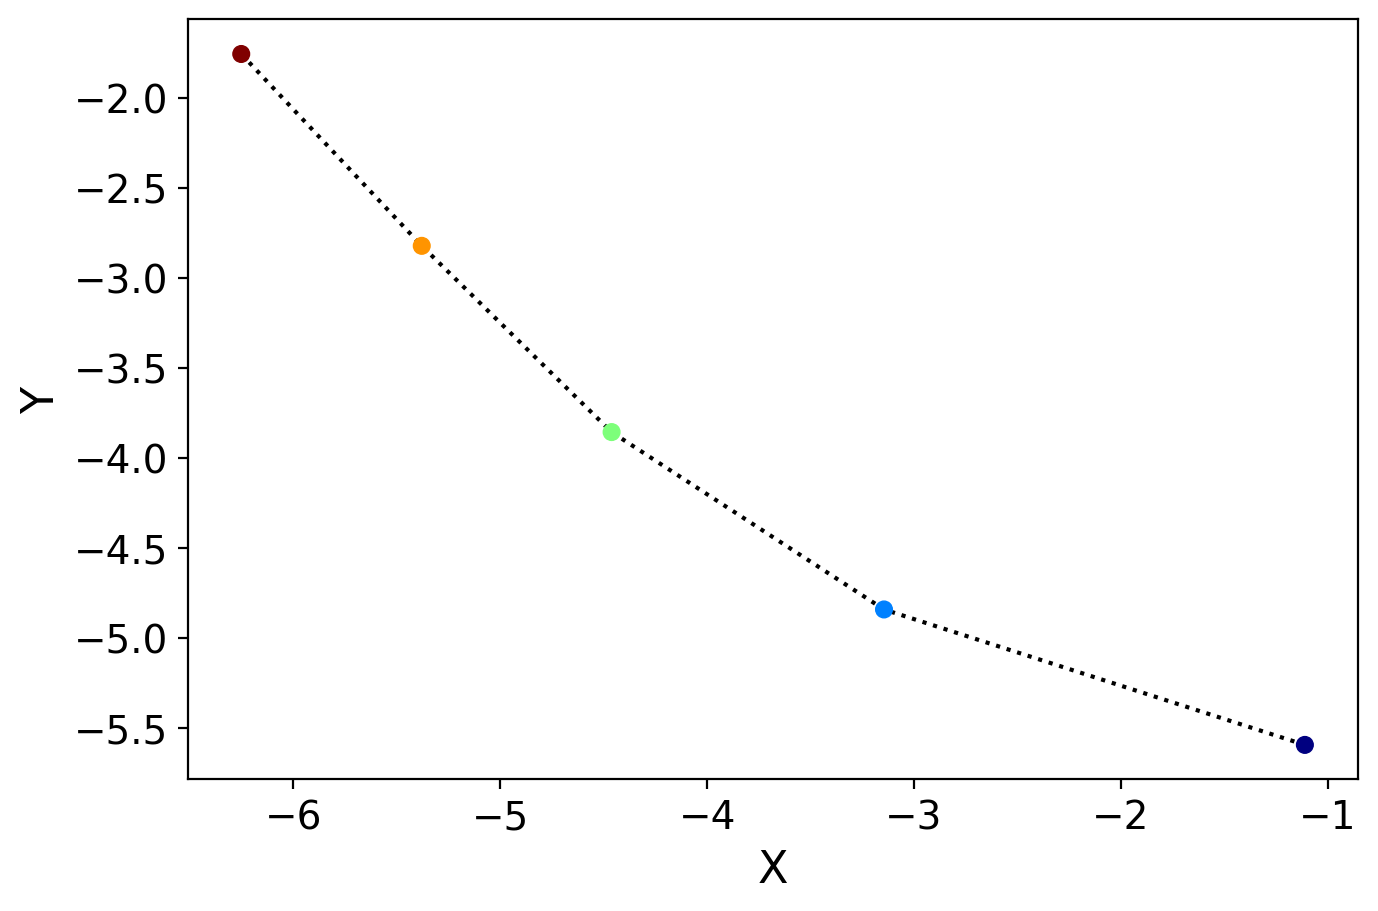

True


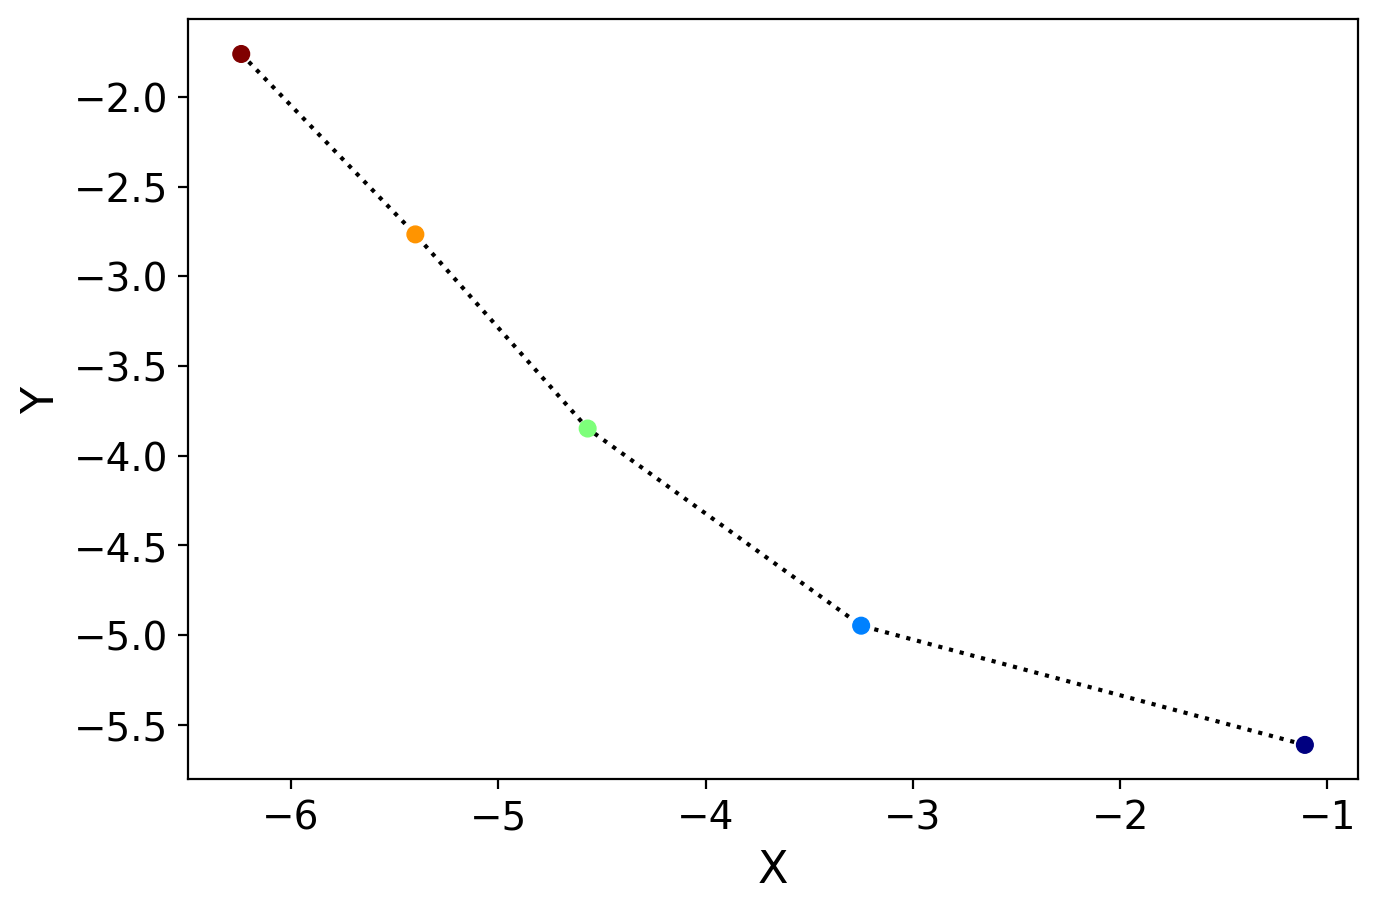

True


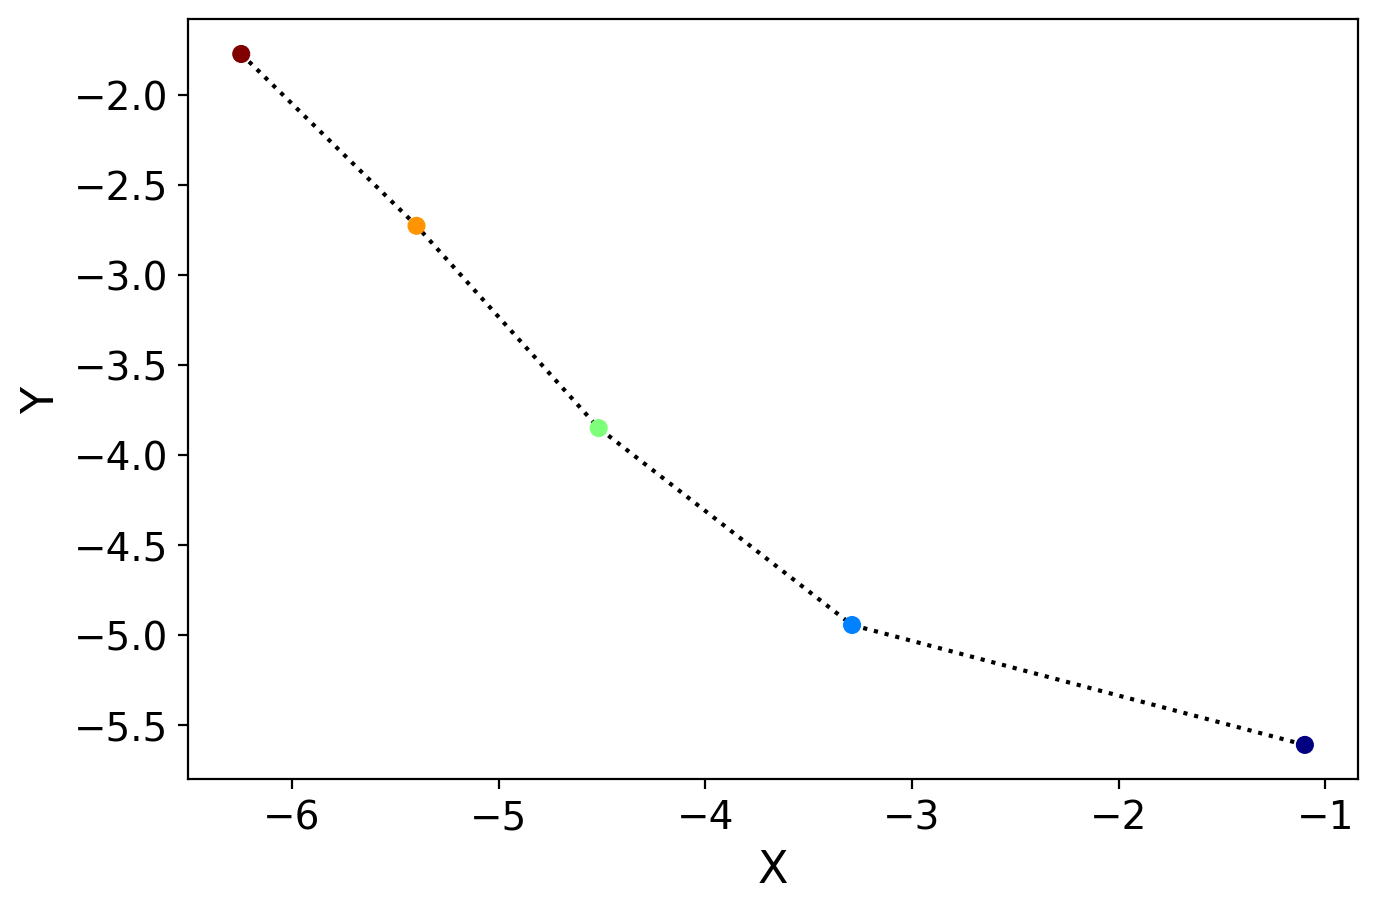

False
X0: 90


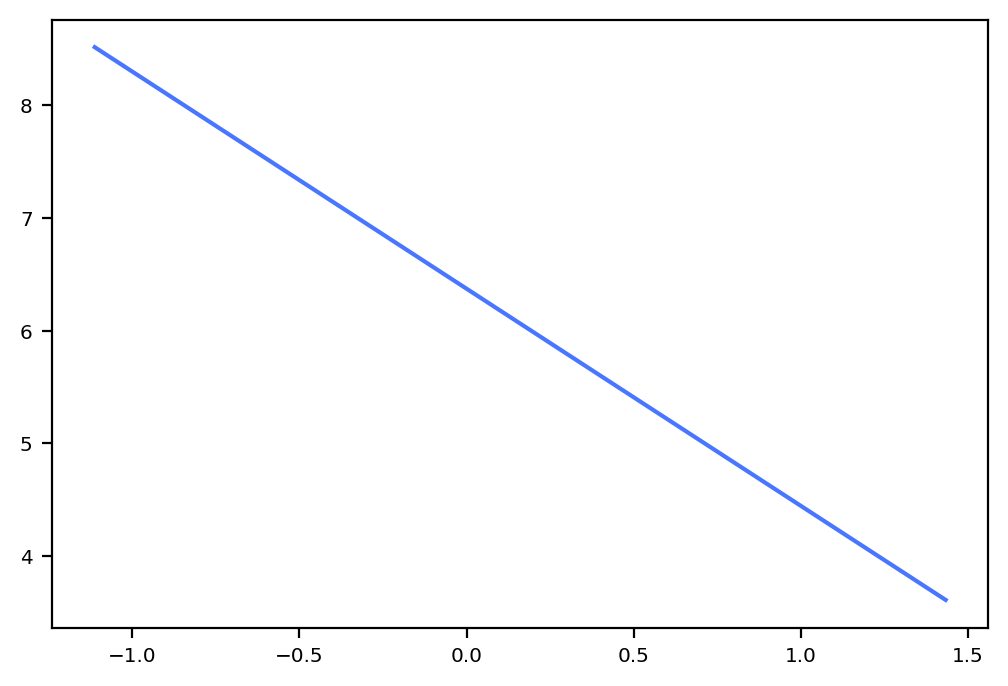

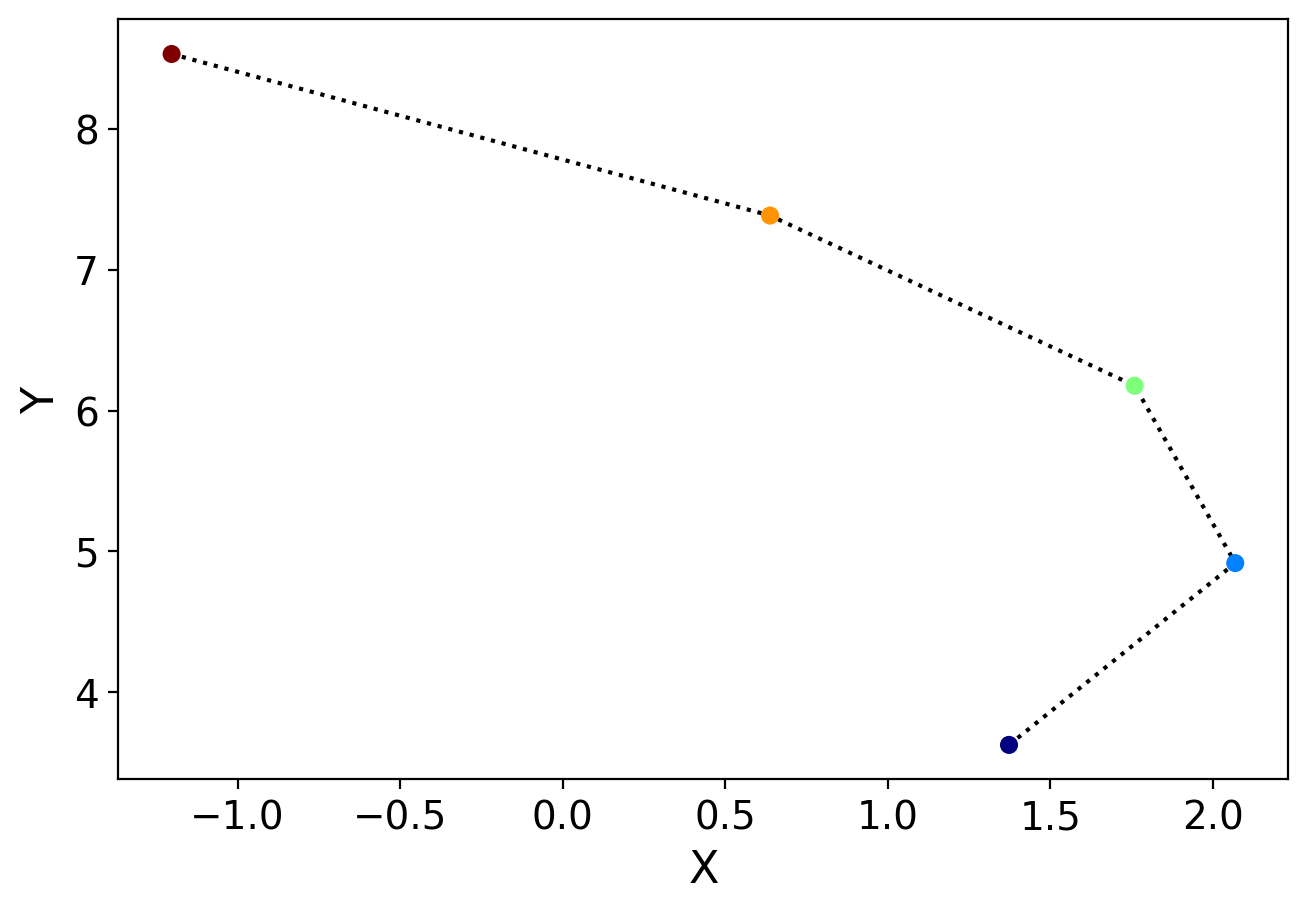

True


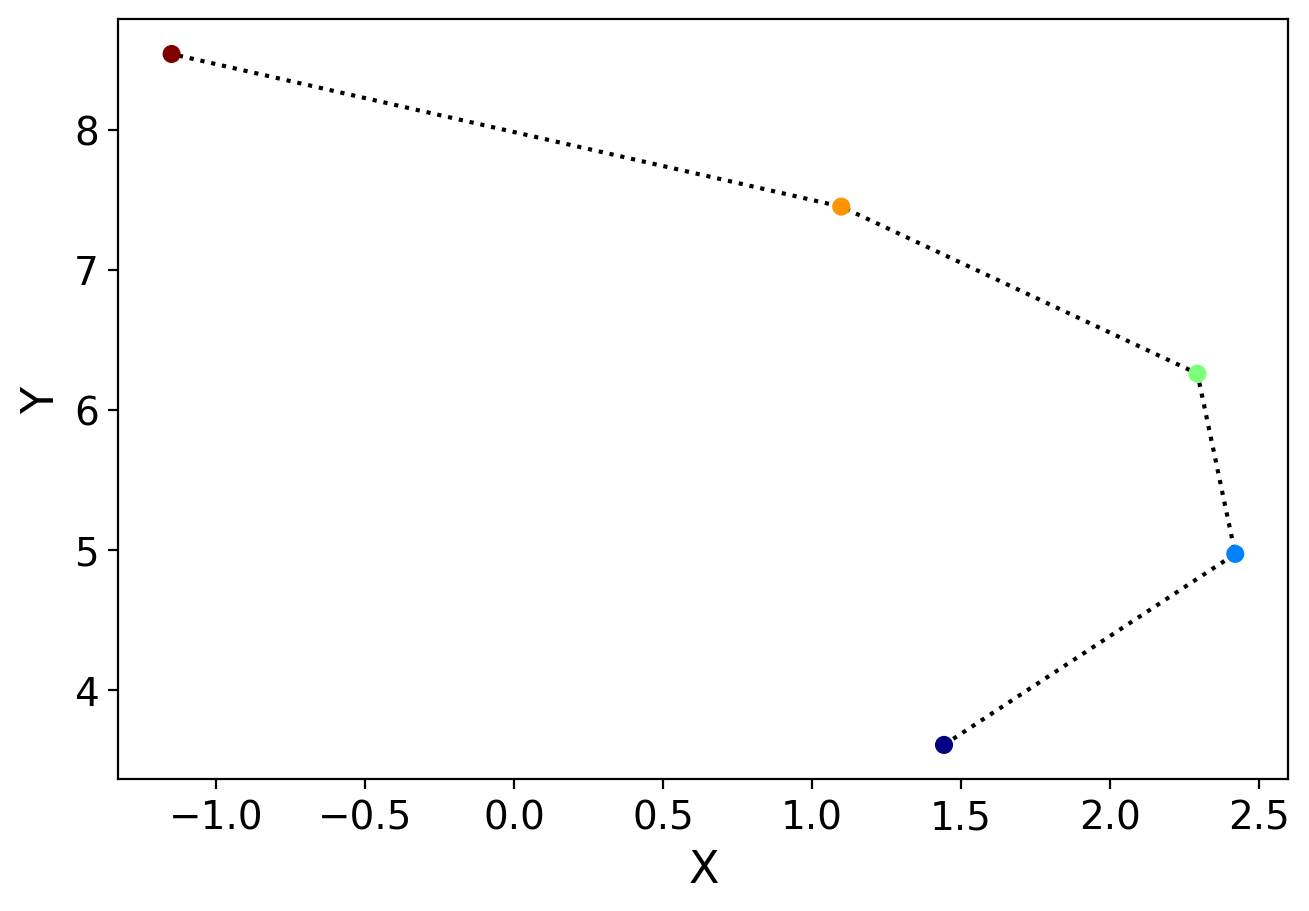

True


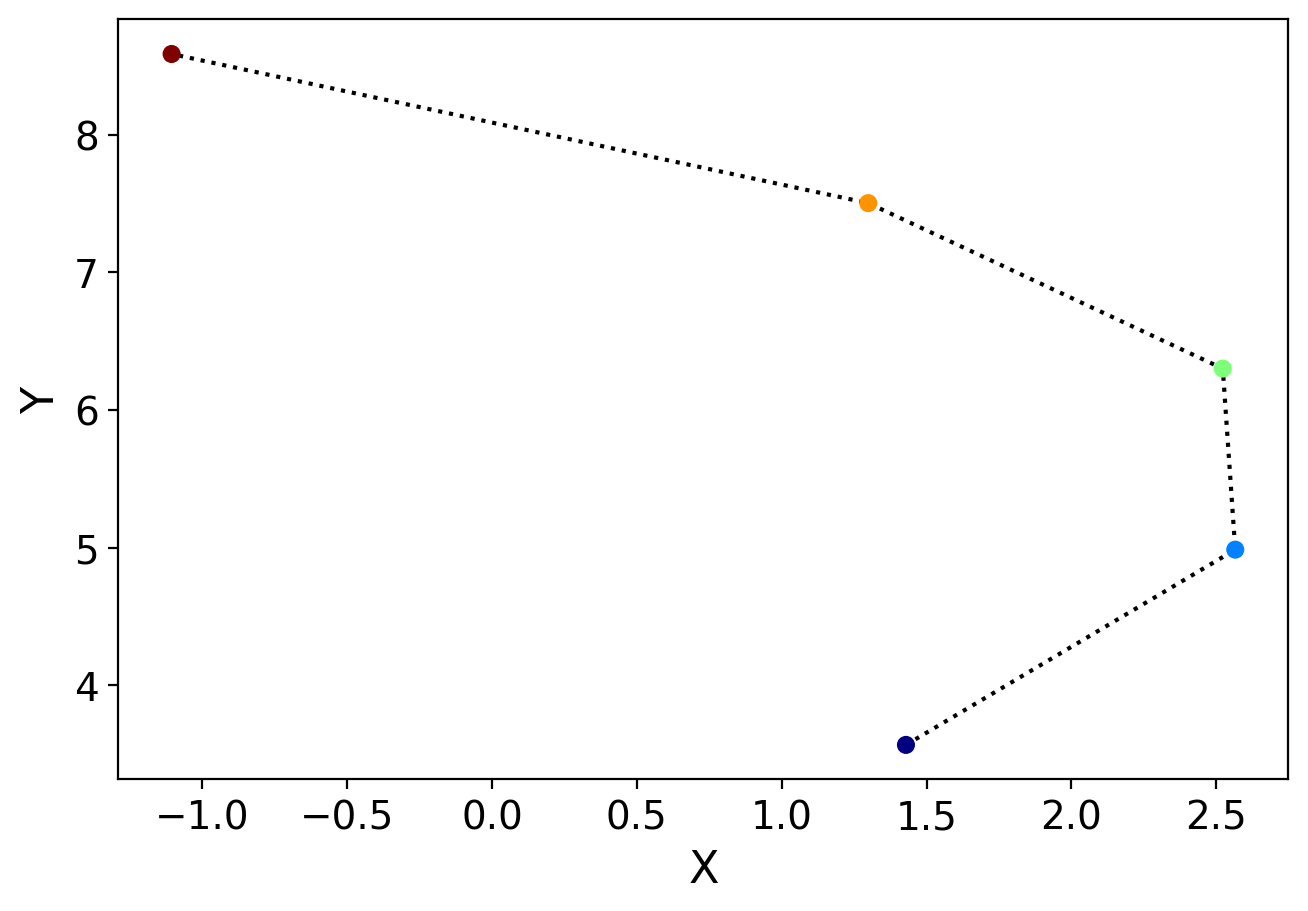

True


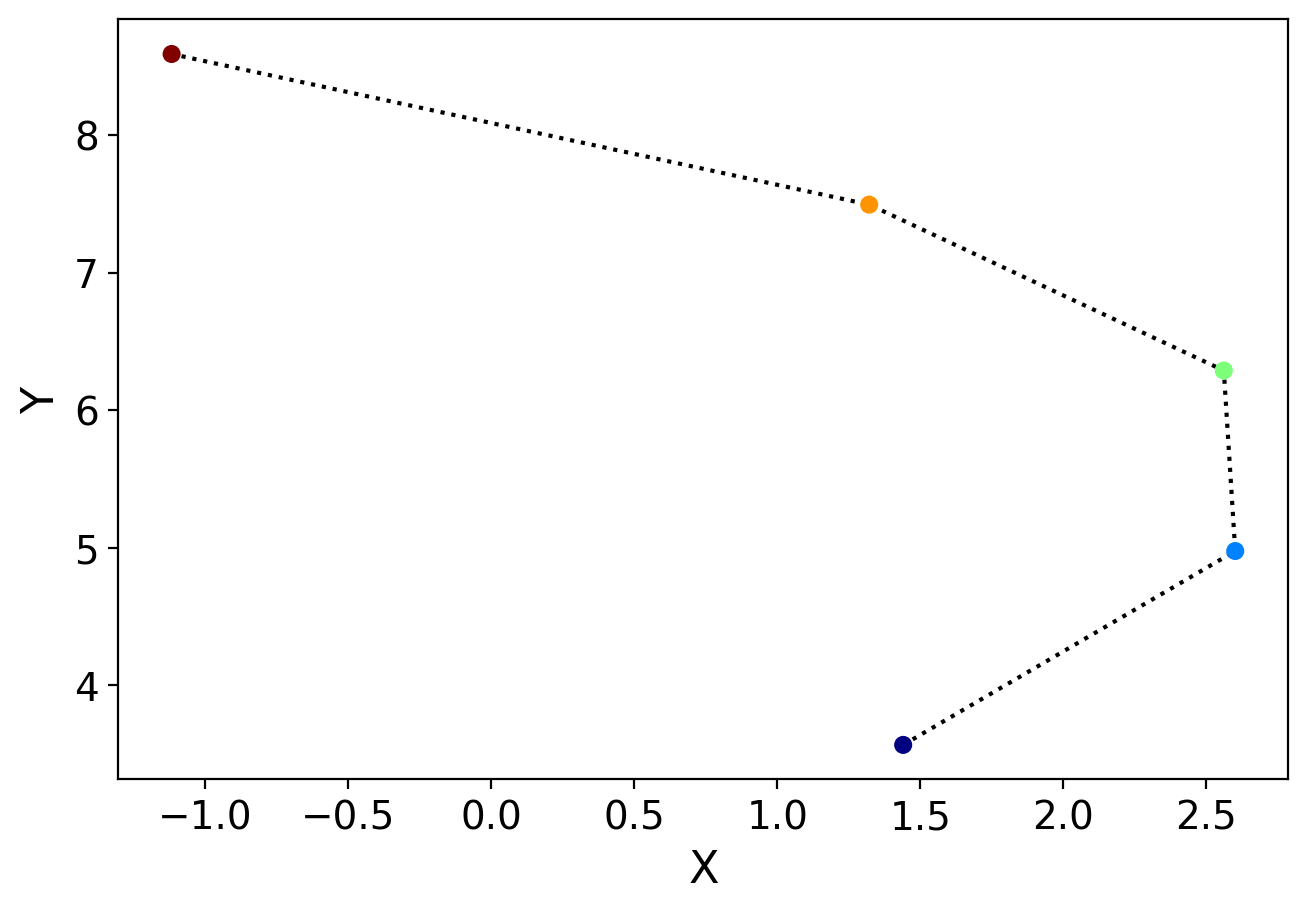

True


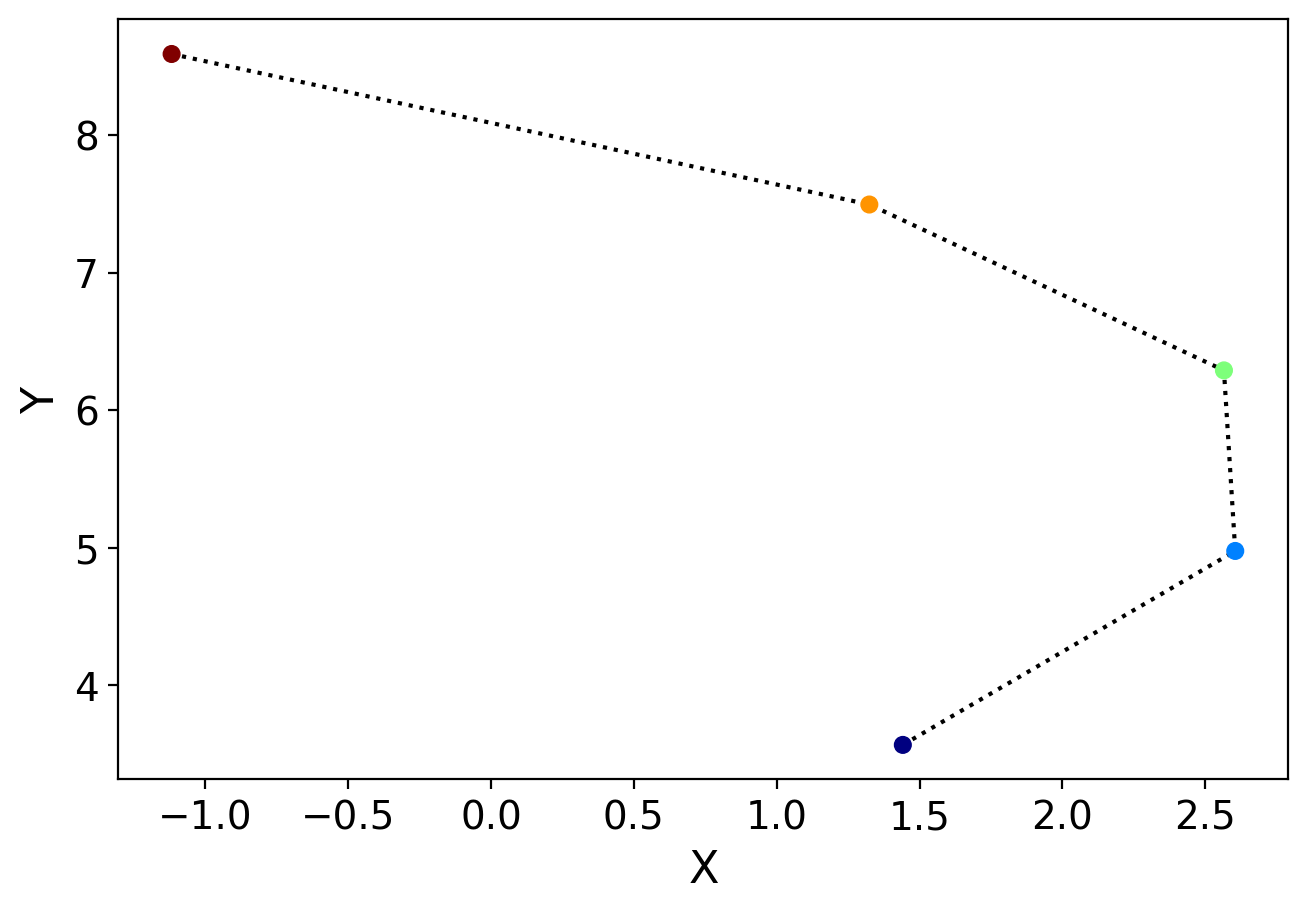

True


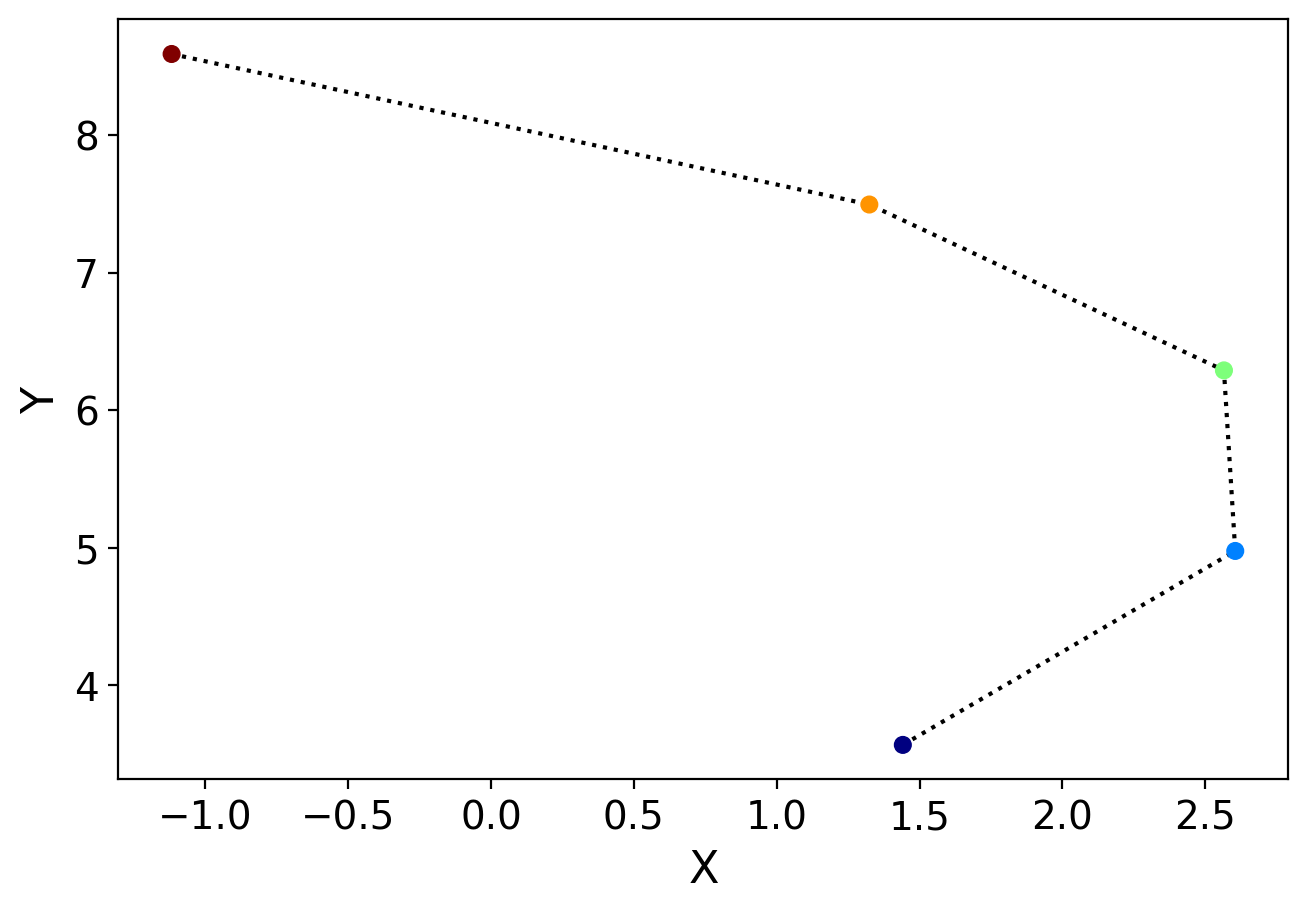

False
X0: 10


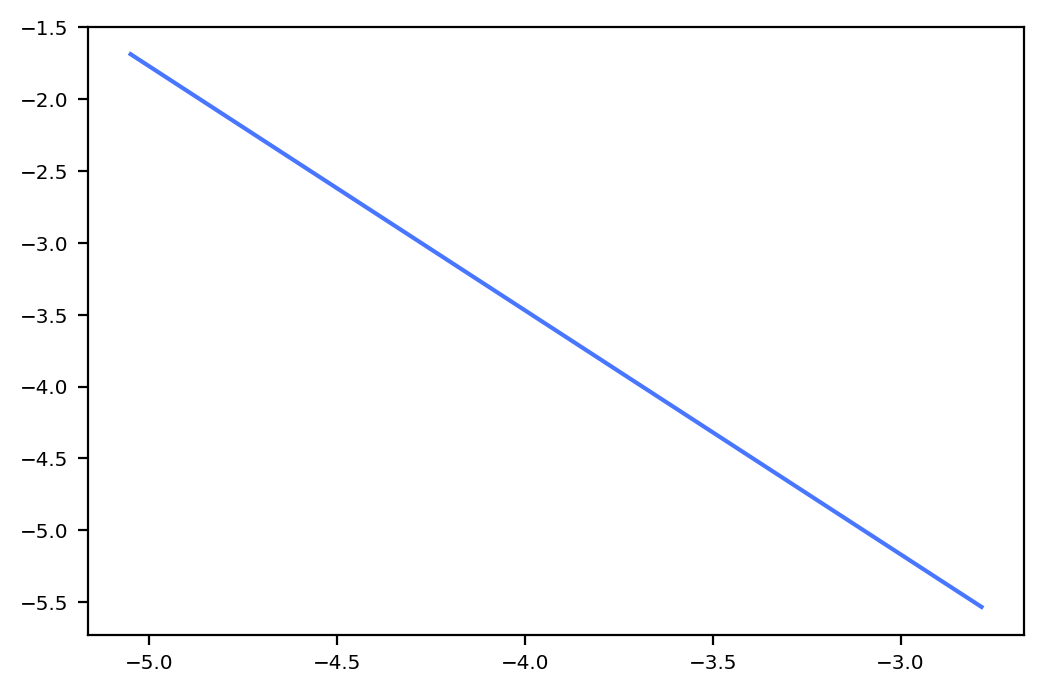

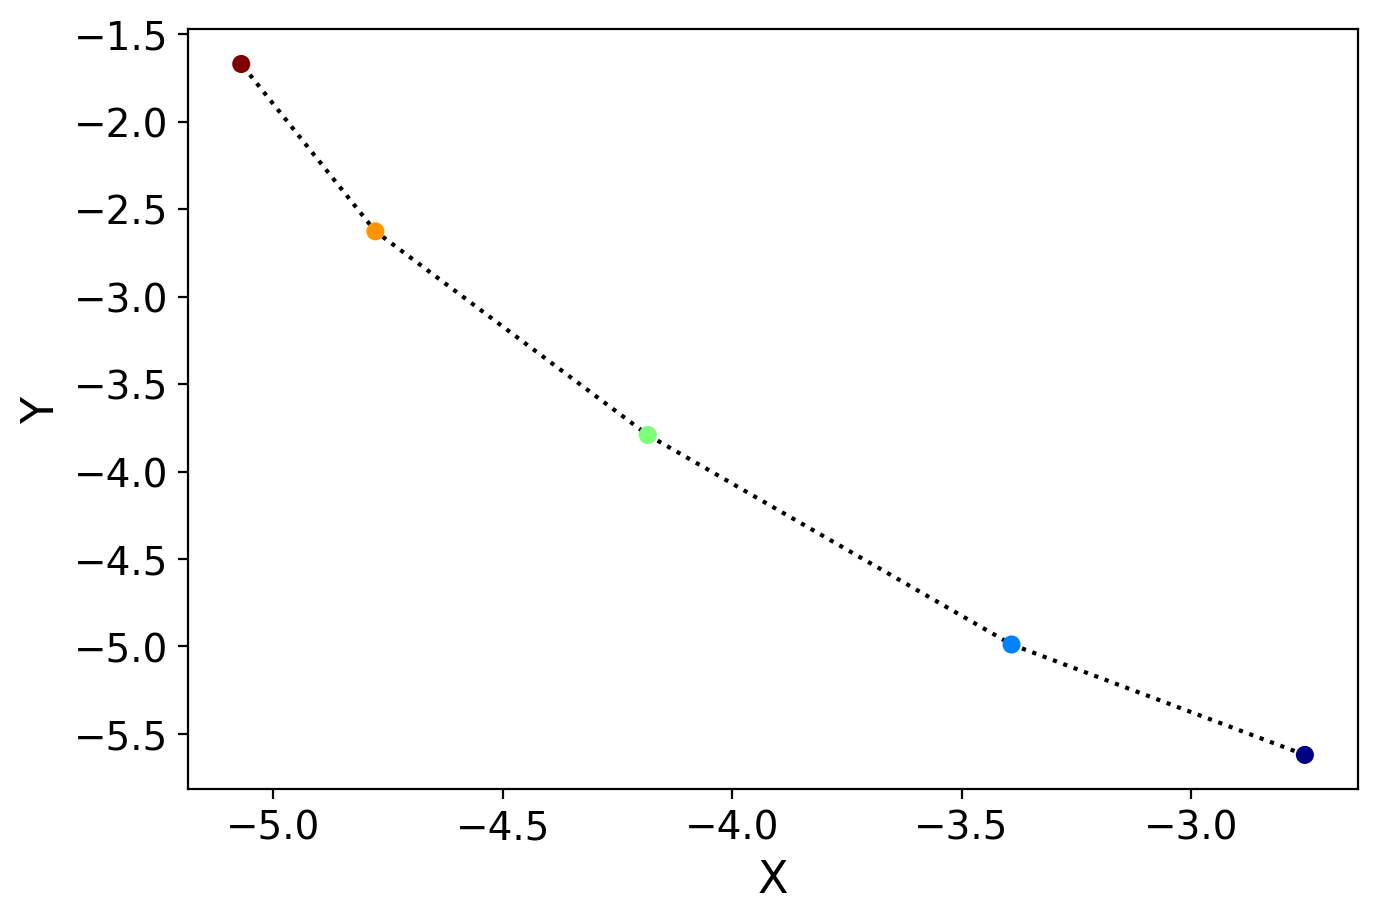

True


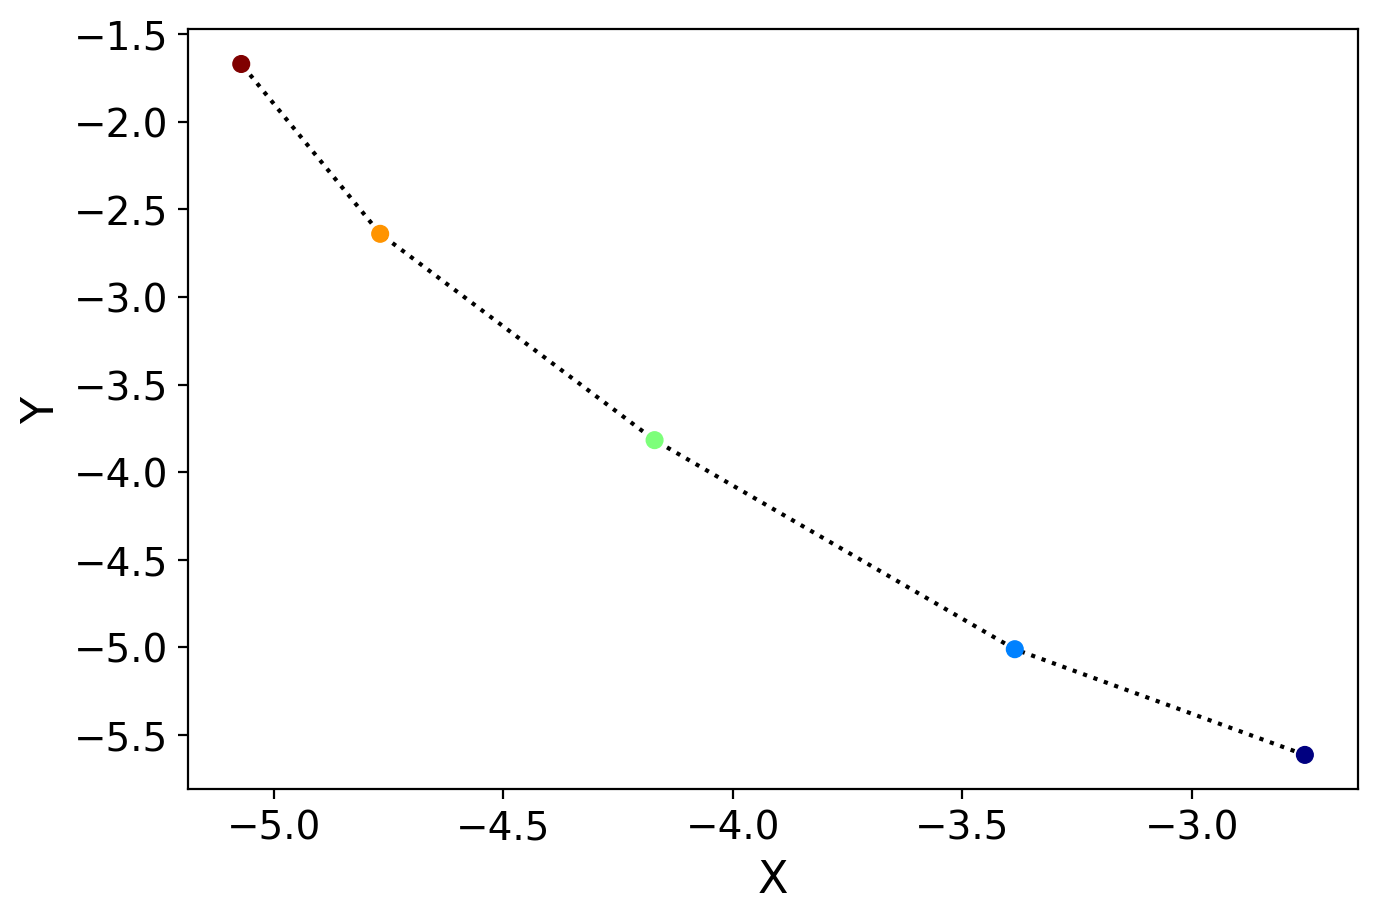

True


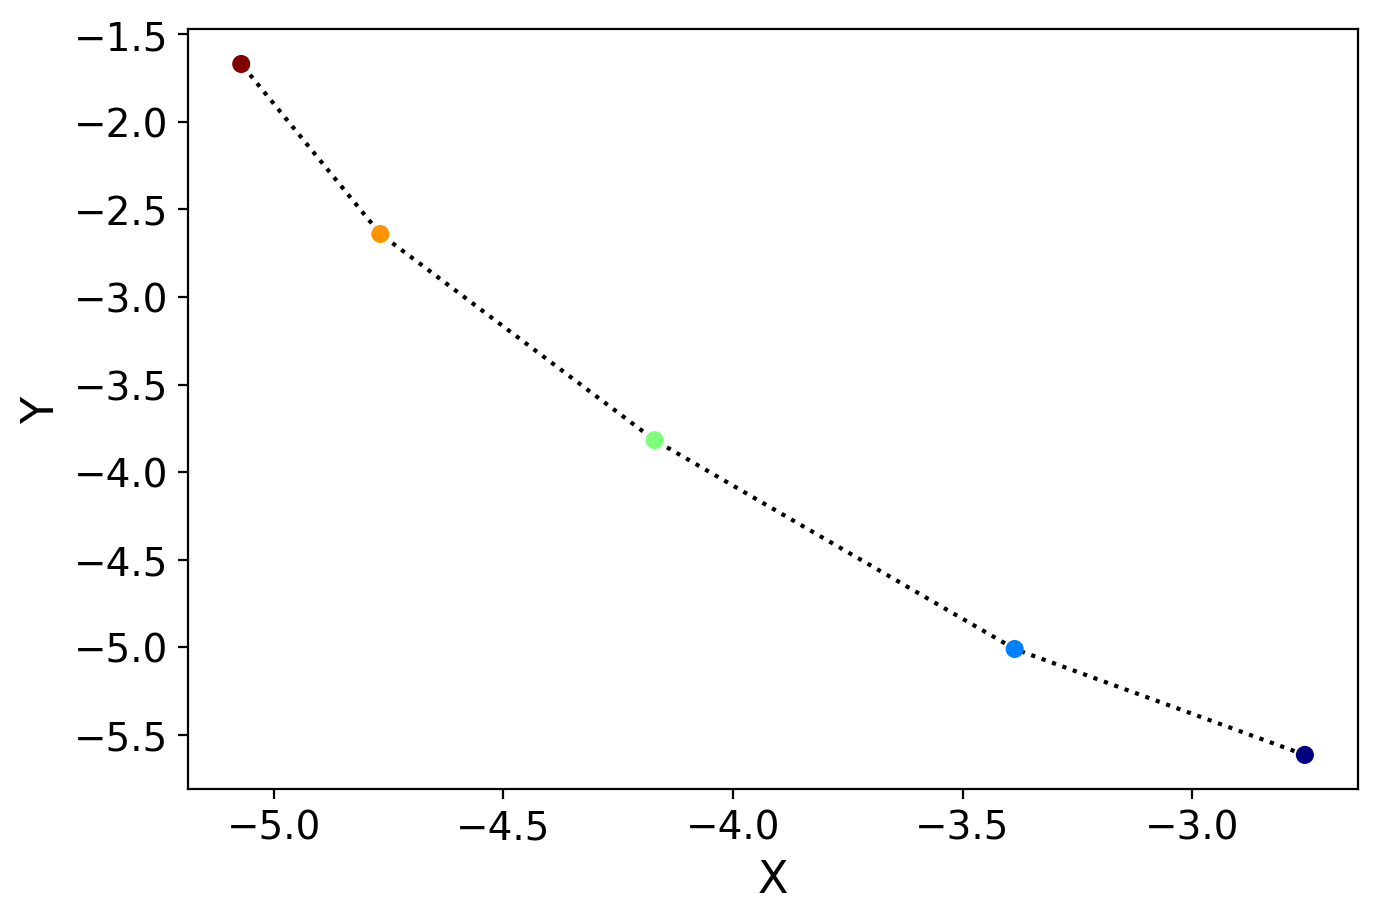

True


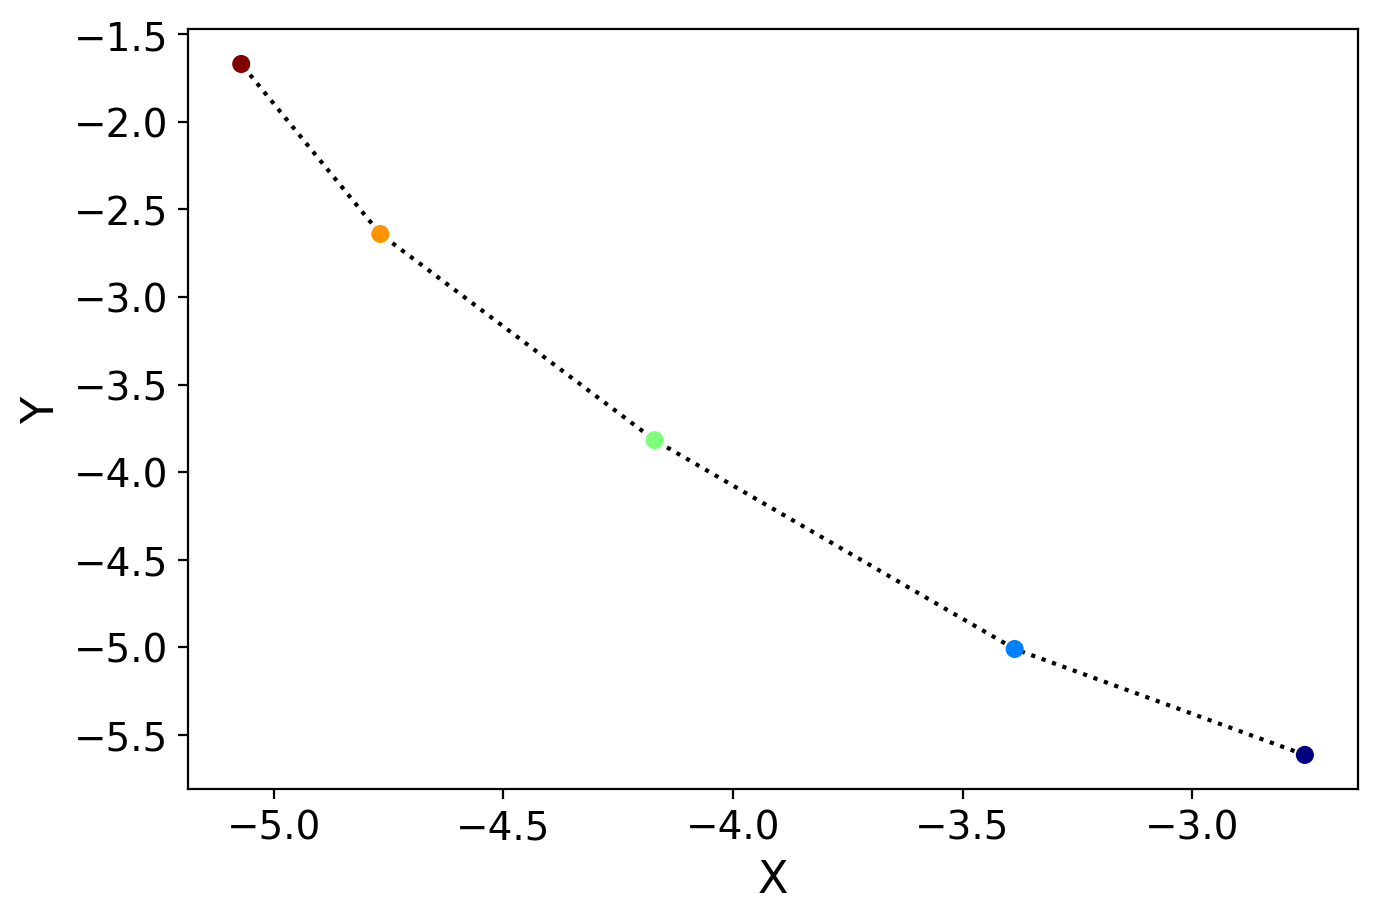

False
X0: 85


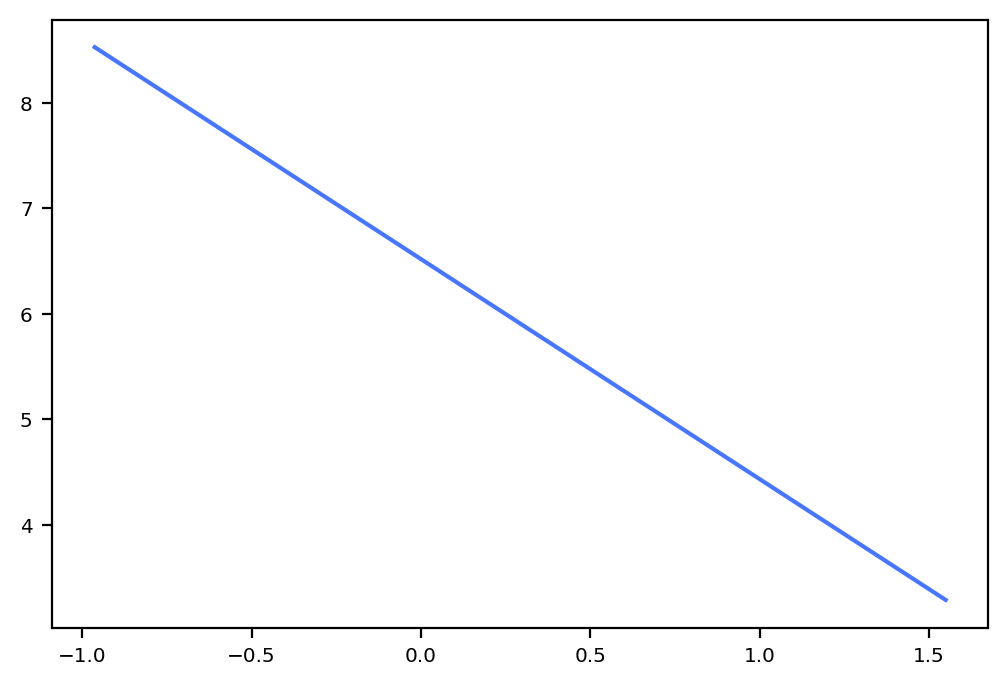

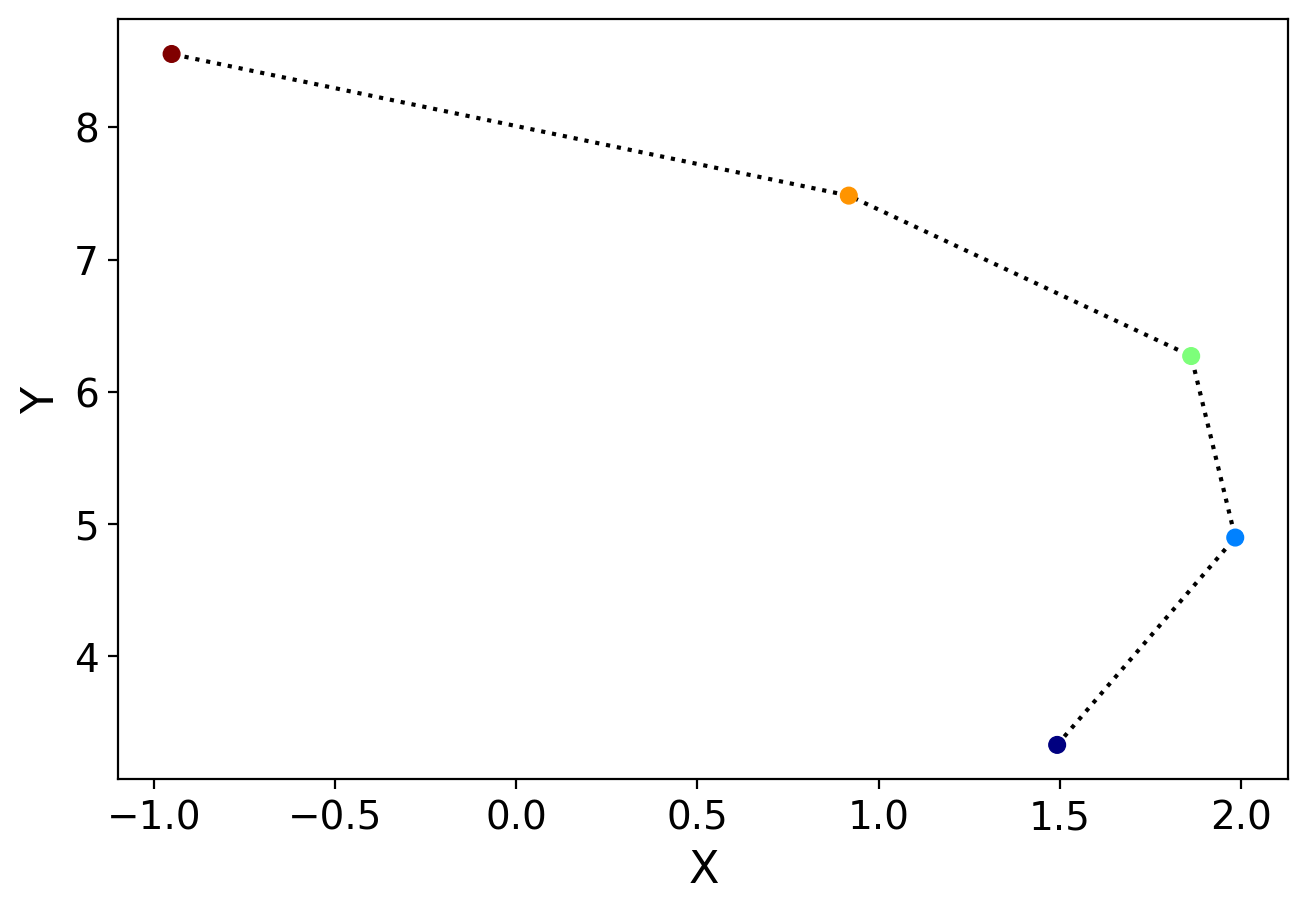

True


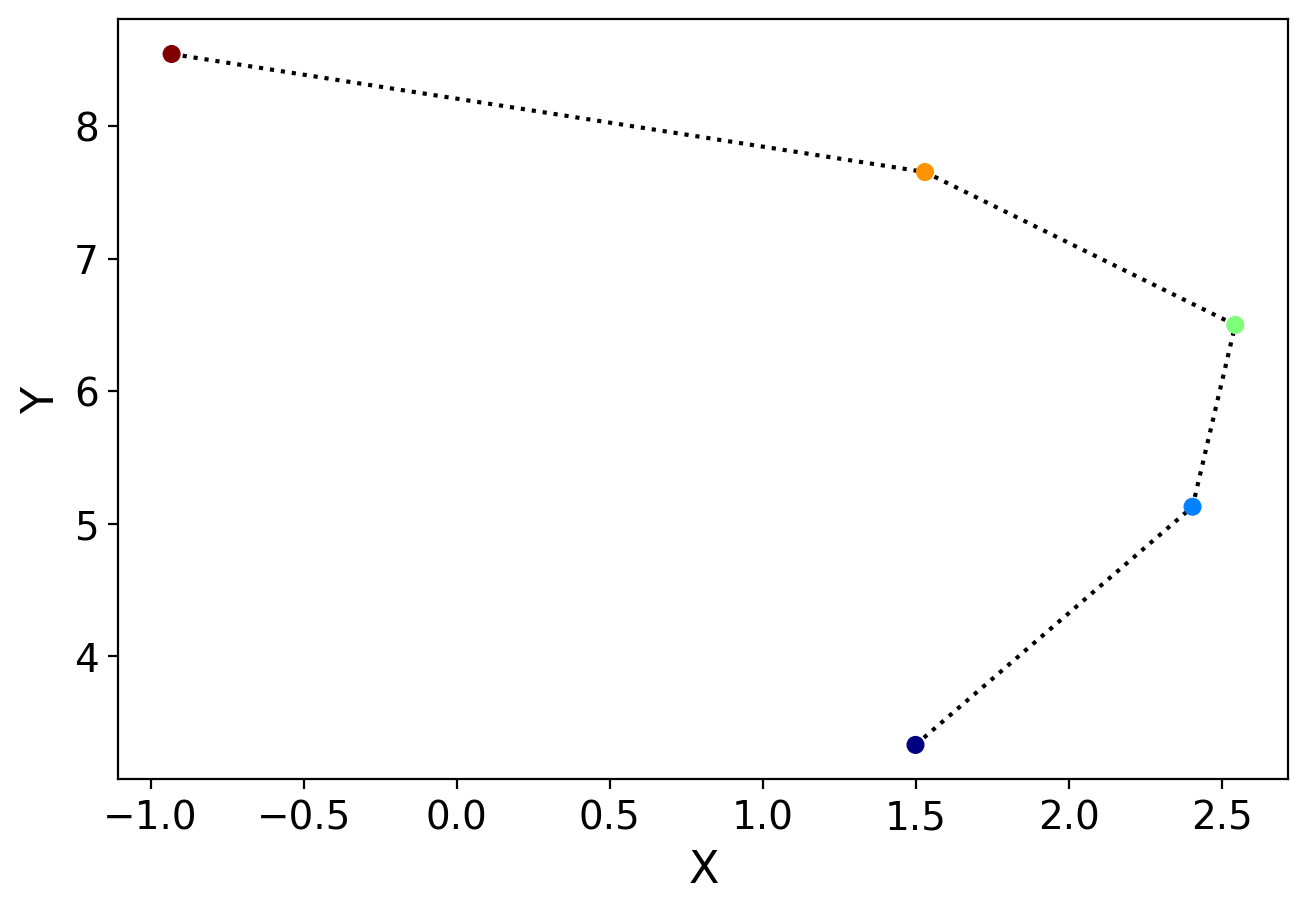

True


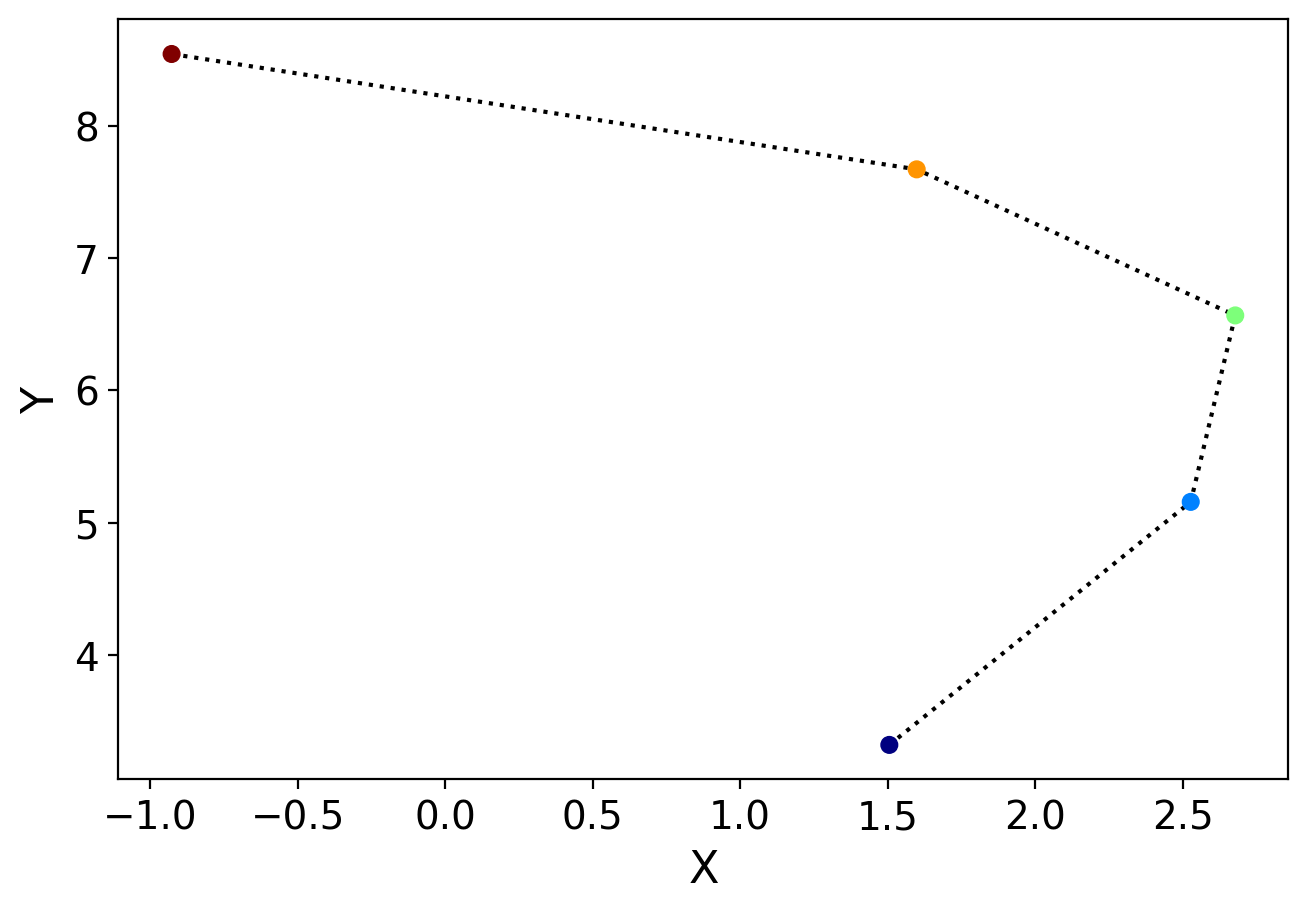

True


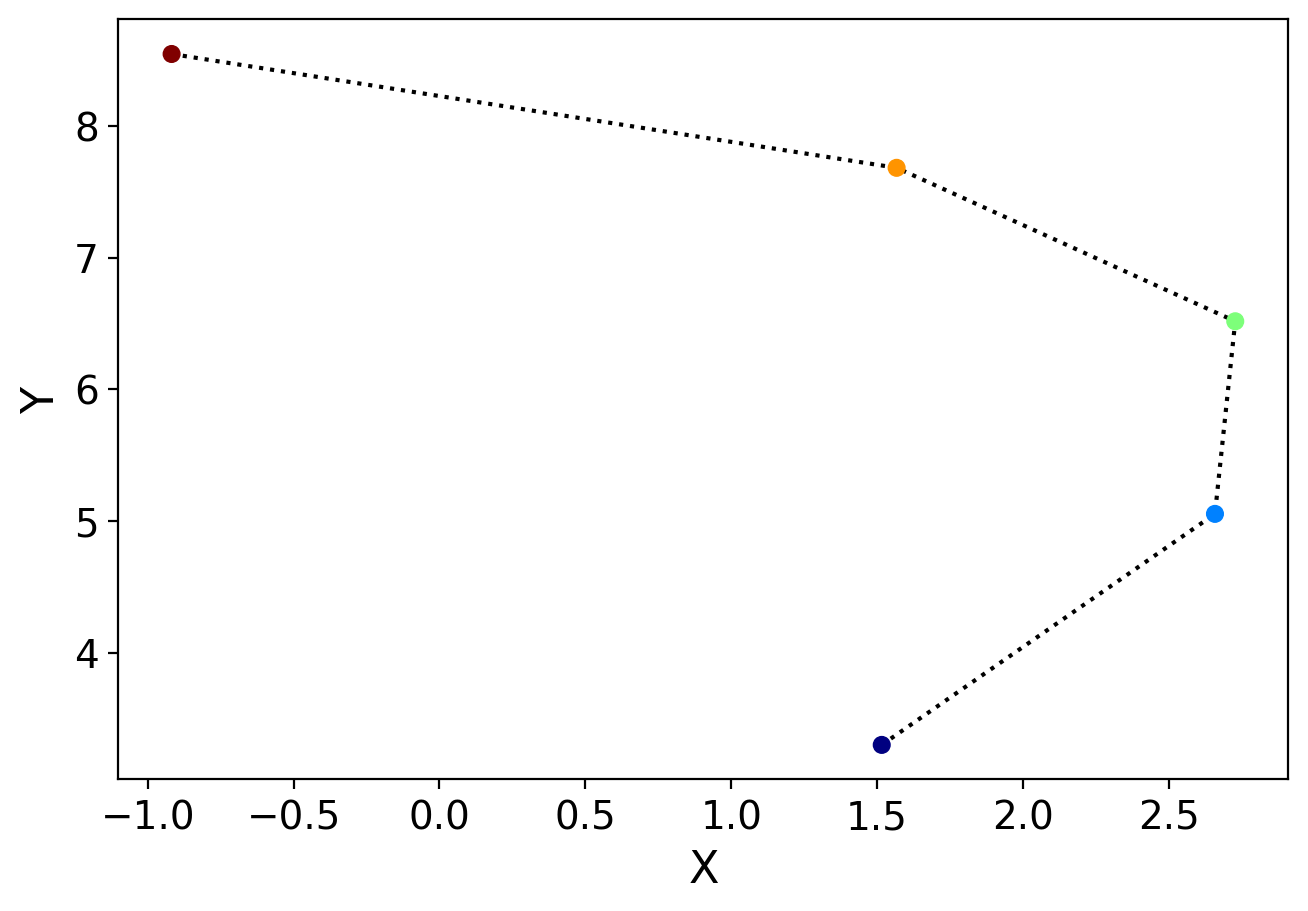

True


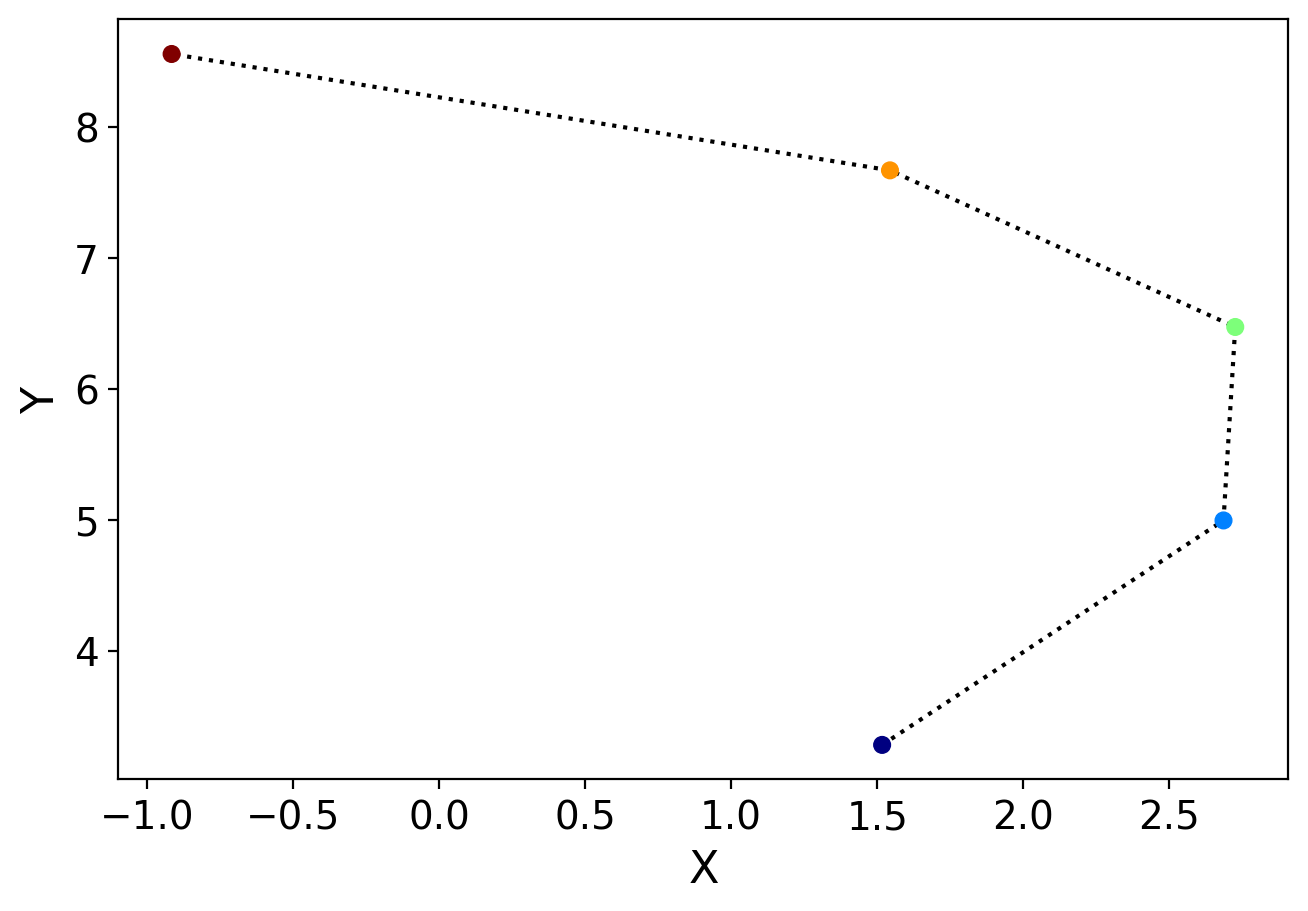

True


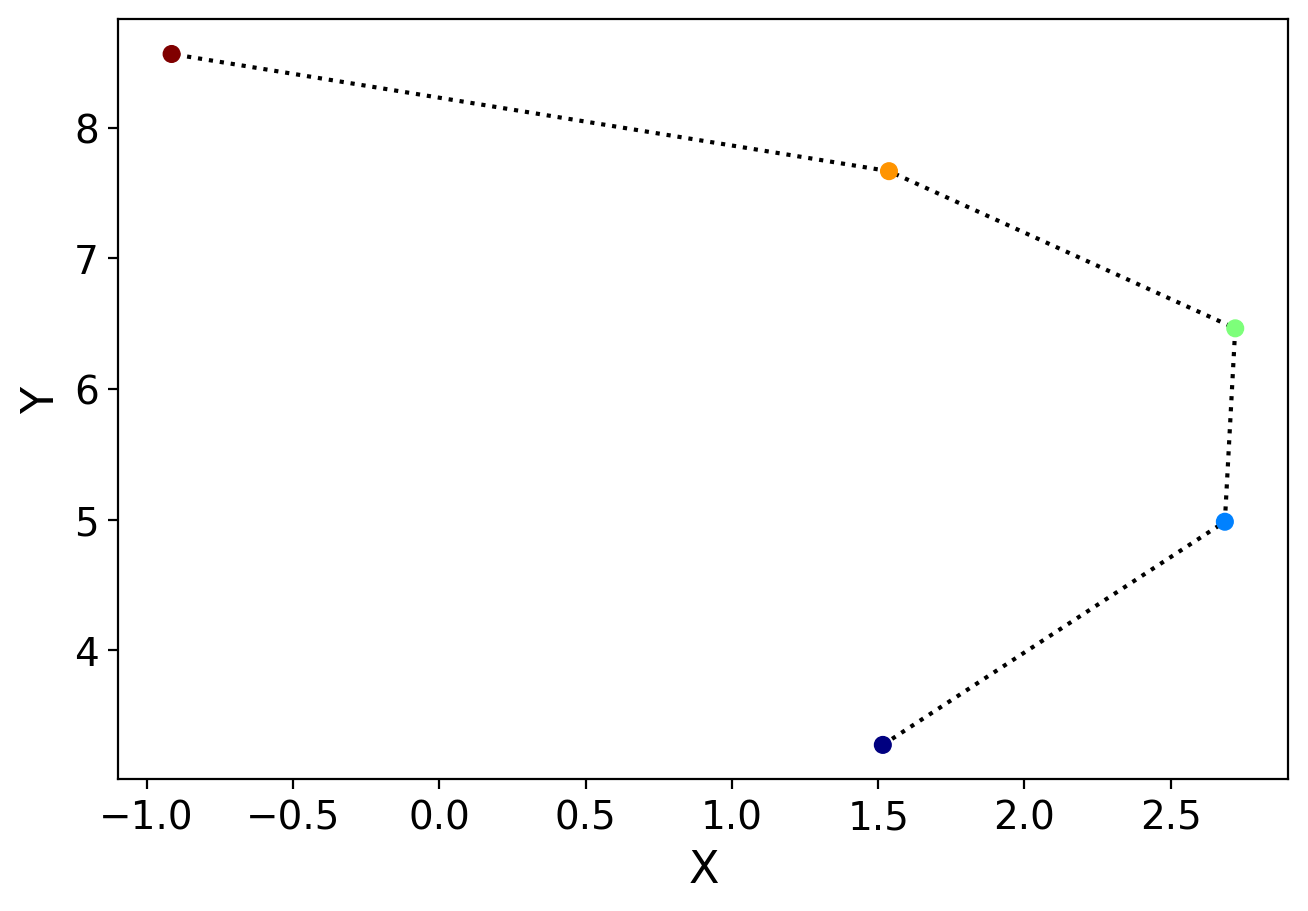

False
X0: 15


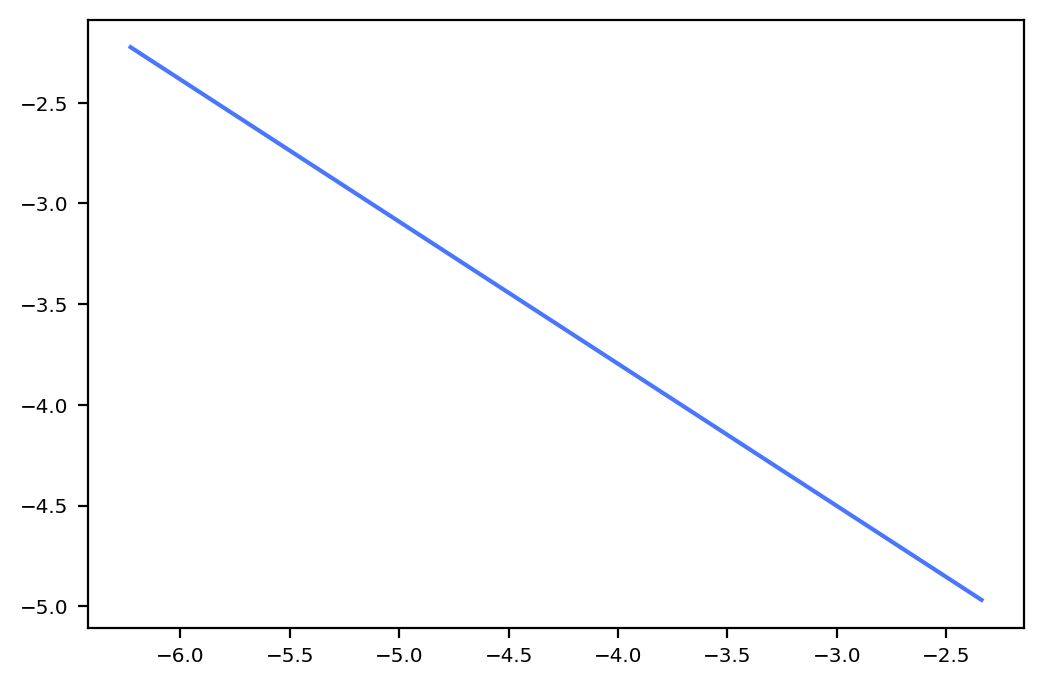

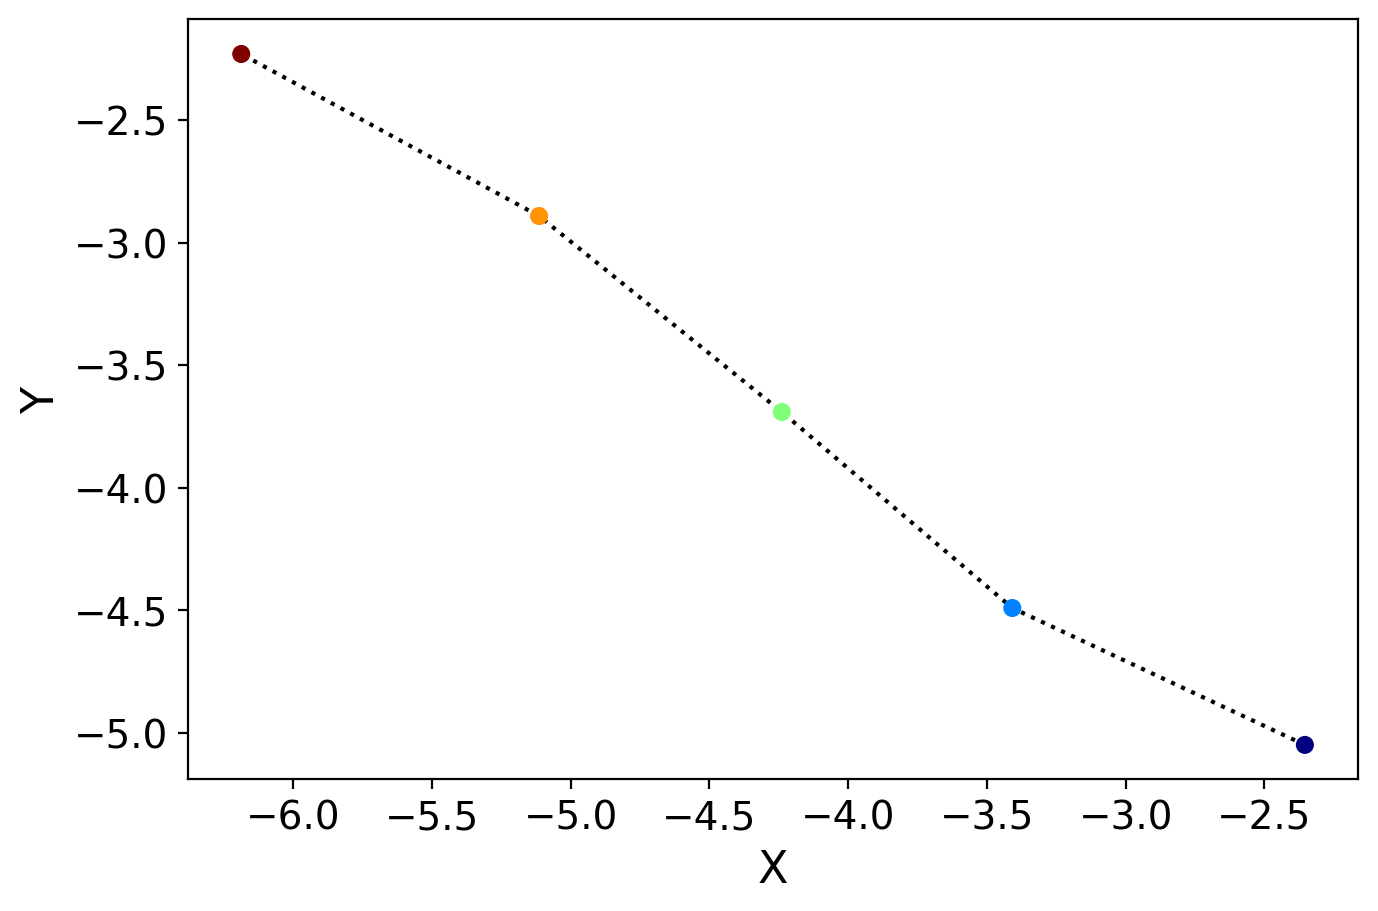

True


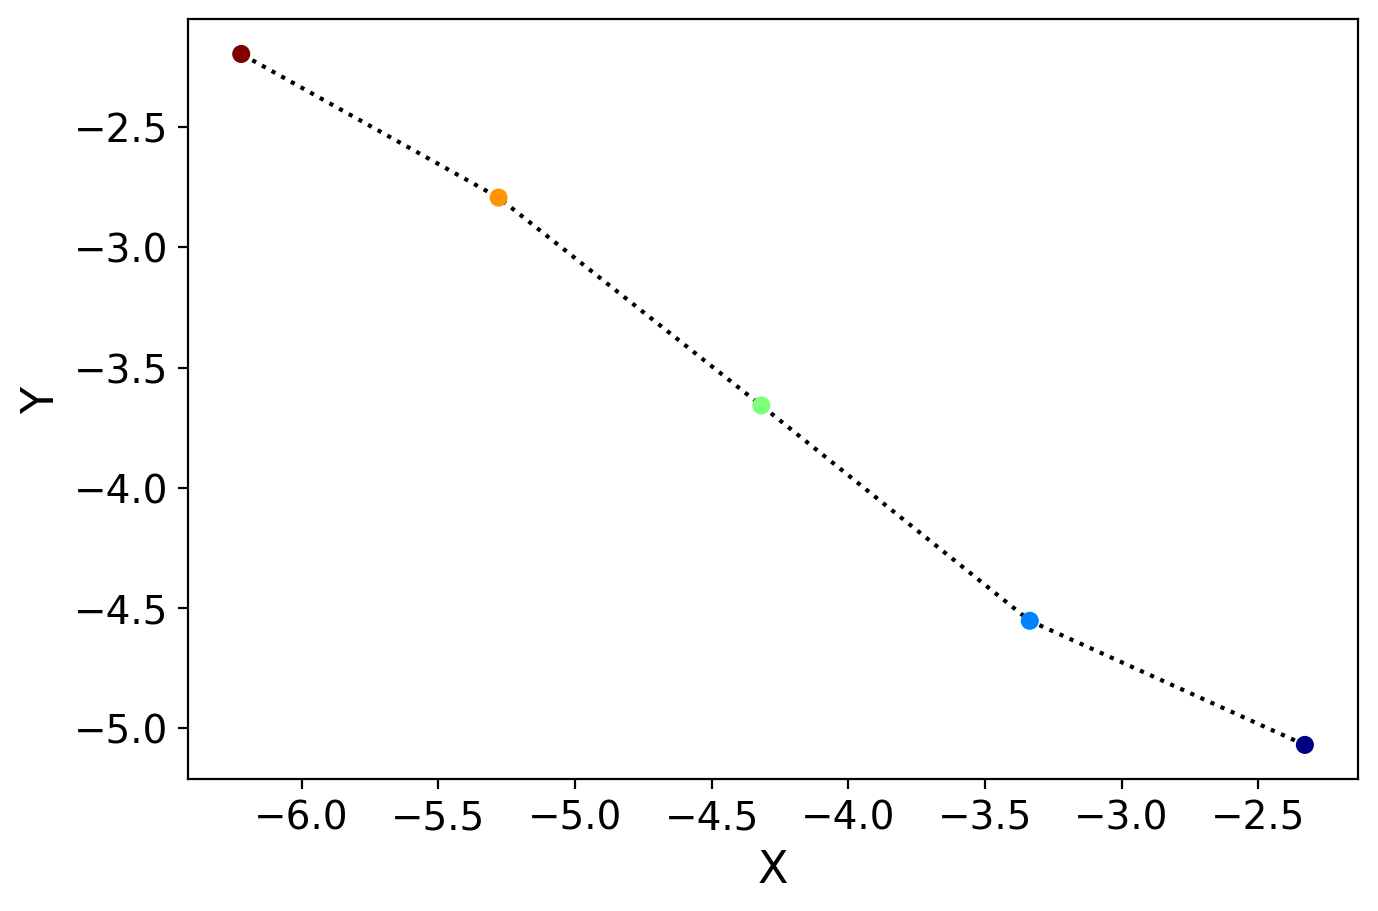

True


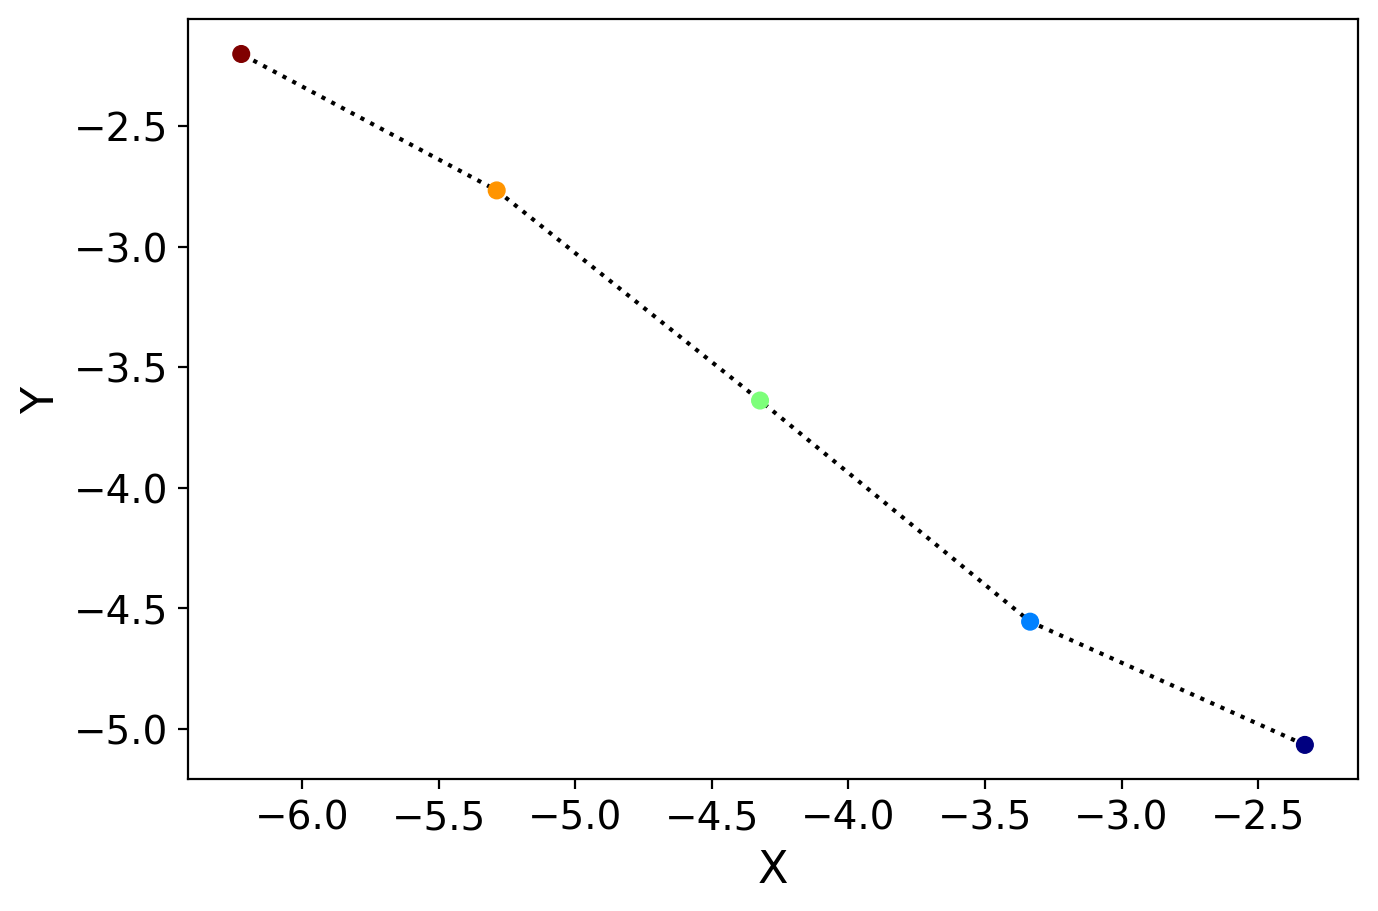

True


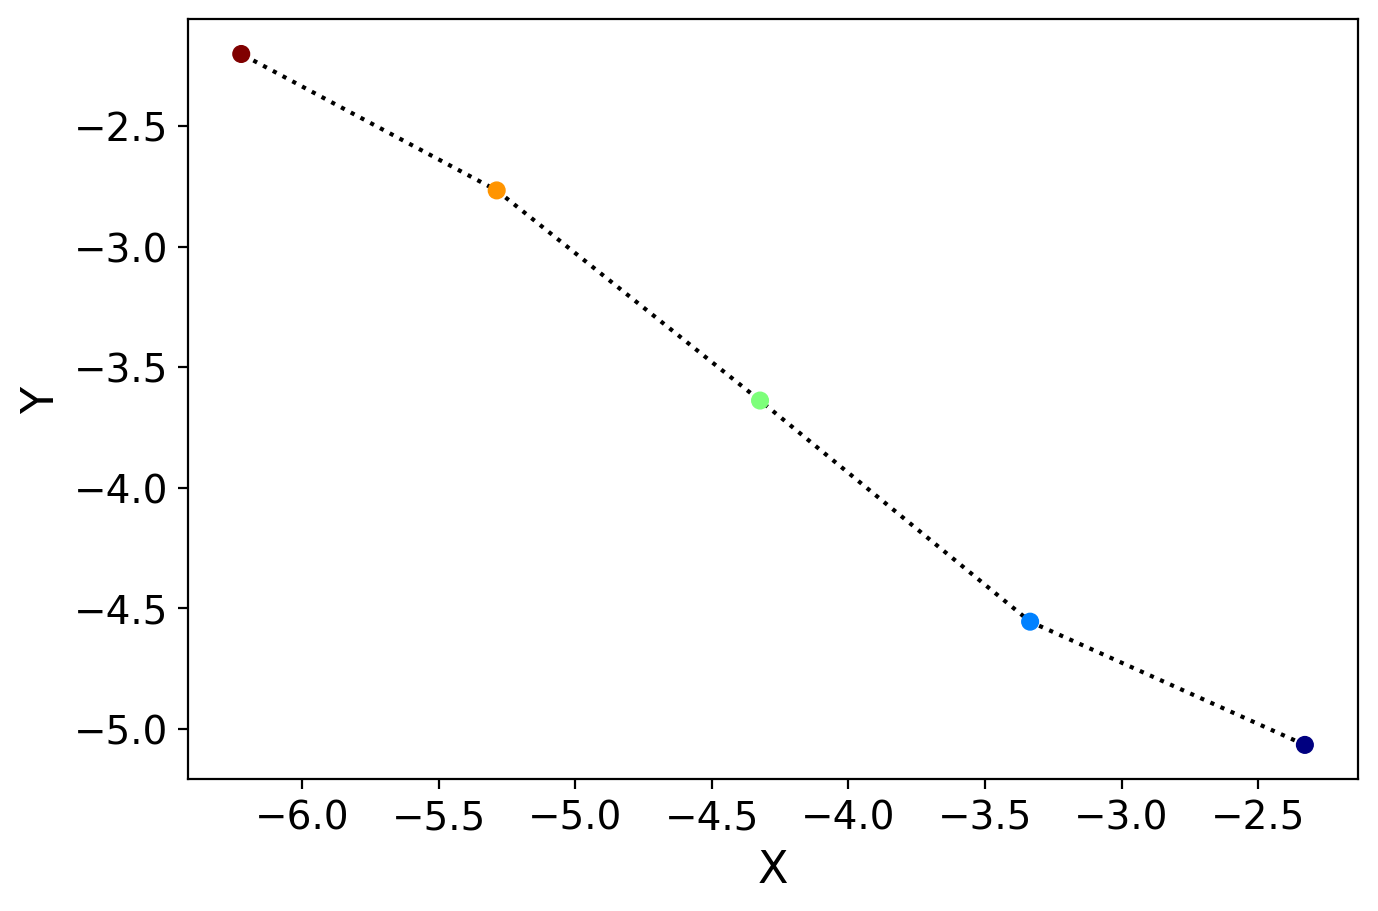

False


In [266]:
DC_trajs_list = []
for i in range(len(model_list)):
    model = model_list[i]
    DC_trajs = []
    
    for j in range(2): 
        path = np.where(model.labels_ == j)[0]

        traj_cl0=[]
        E_state_cl0=[]
        M_state_cl0=[]
        for index in path:
            traj_arr = np.array(coords_DC_list[i][index]).astype(float)
            root_state=traj_arr[0,:]
            end_state=traj_arr[-1,:]

            traj_cl0.append(traj_arr)
            E_state_cl0.append(root_state)
            M_state_cl0.append(end_state)

        E_state_mean0=np.mean(np.array(E_state_cl0),axis=0)
        M_state_mean0=np.mean(np.array(M_state_cl0),axis=0)

        X0=traj_cl0
        x1=E_state_mean0
        x2=M_state_mean0
        
        nrc=5

        FP=FindPath2(nrc, traj_w=10,sf=1)
        path_DC_traj, data_rc0=FP.fit(x1,x2,X0)
        DC_trajs.append(path_DC_traj)
        
    DC_trajs_list.append(DC_trajs)

In [268]:
# MAP DC clusters to RC representation
DC_to_RC_trajs = []
for trial in DC_trajs_list:
    cluster_trajs = []
    for traj in trial:
        traj_keep = []
        for coord in traj:
            temp_coord = getNNeighbors(coord, dose12.obsm['X_DC'][:,:10], k=1)[0][0]
            traj_keep.append(temp_coord)
        cluster_trajs.append(traj_keep)
    DC_to_RC_trajs.append(cluster_trajs)

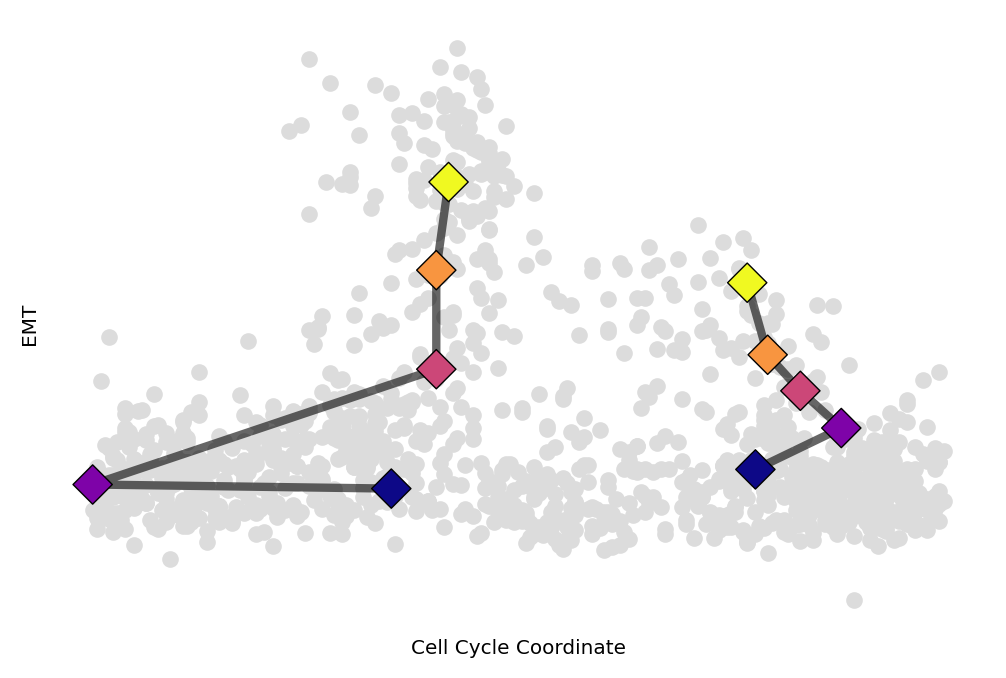

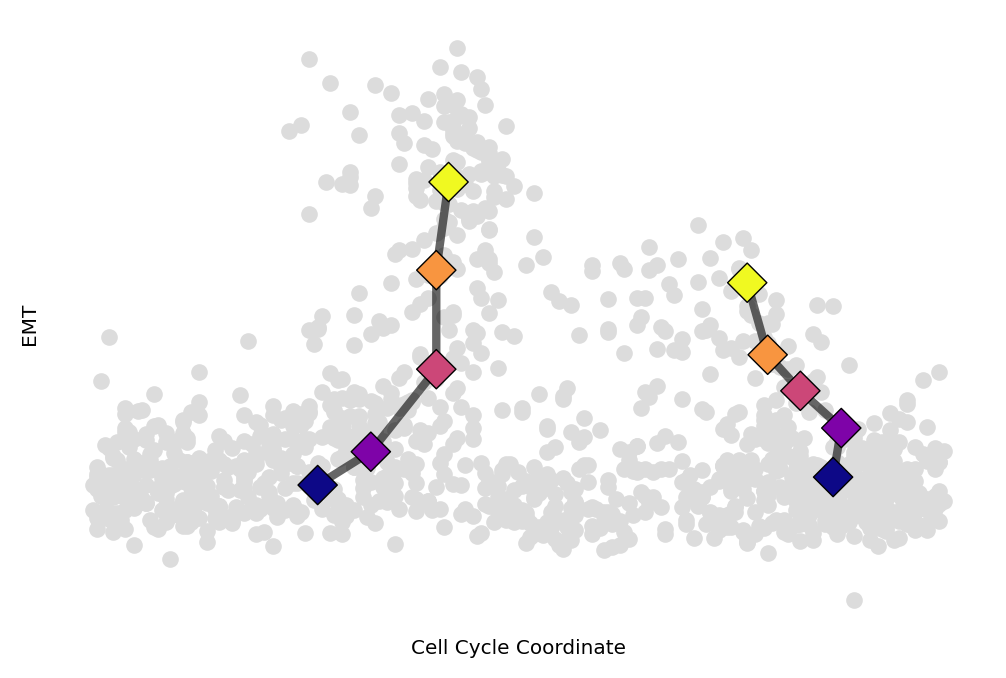

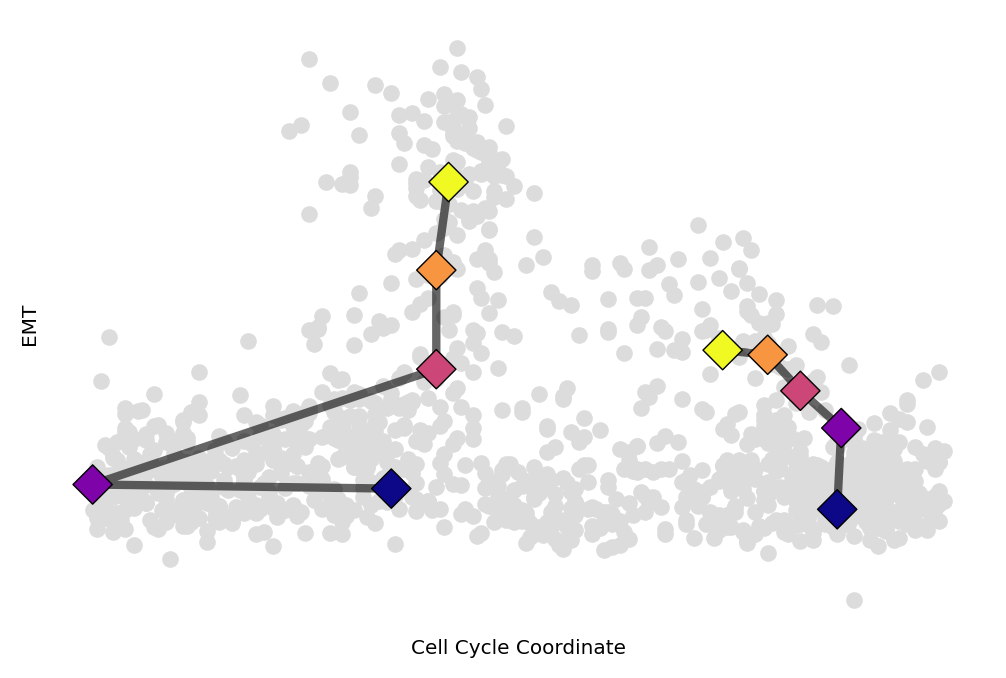

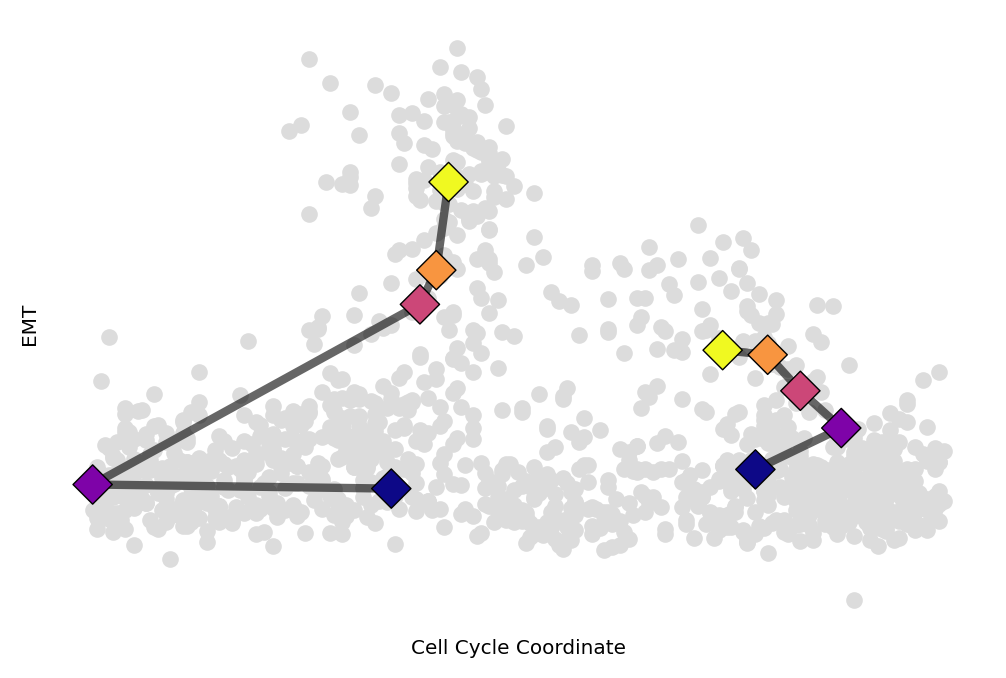

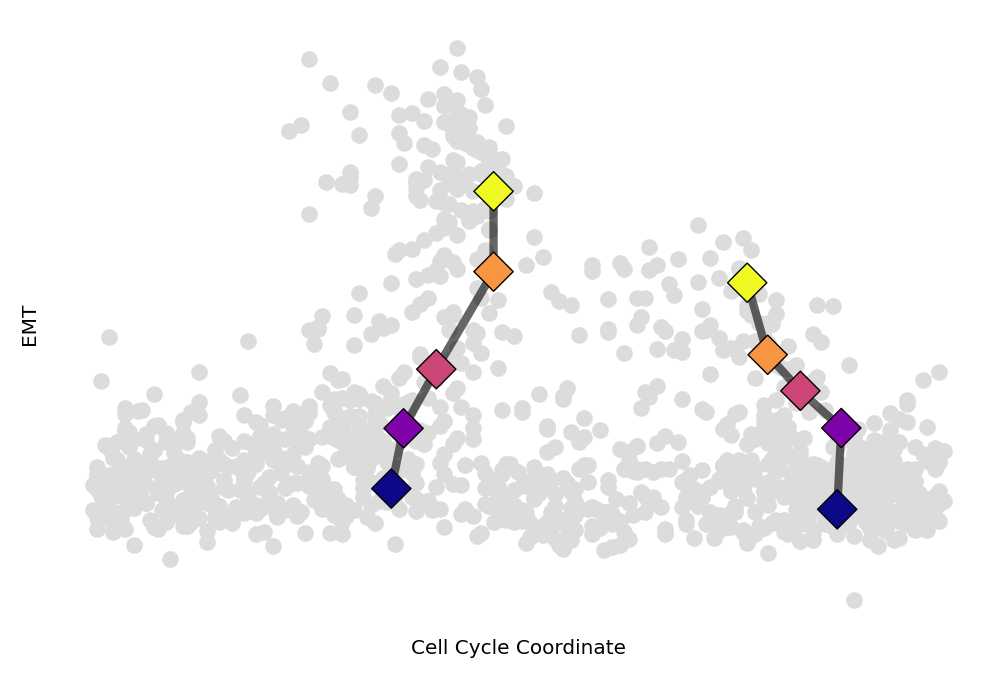

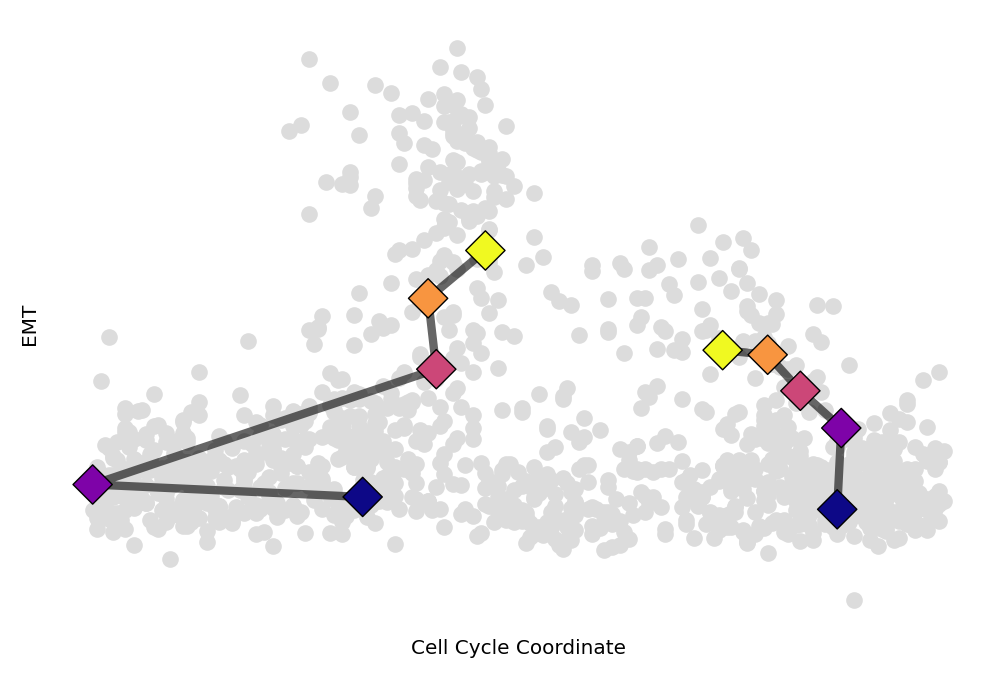

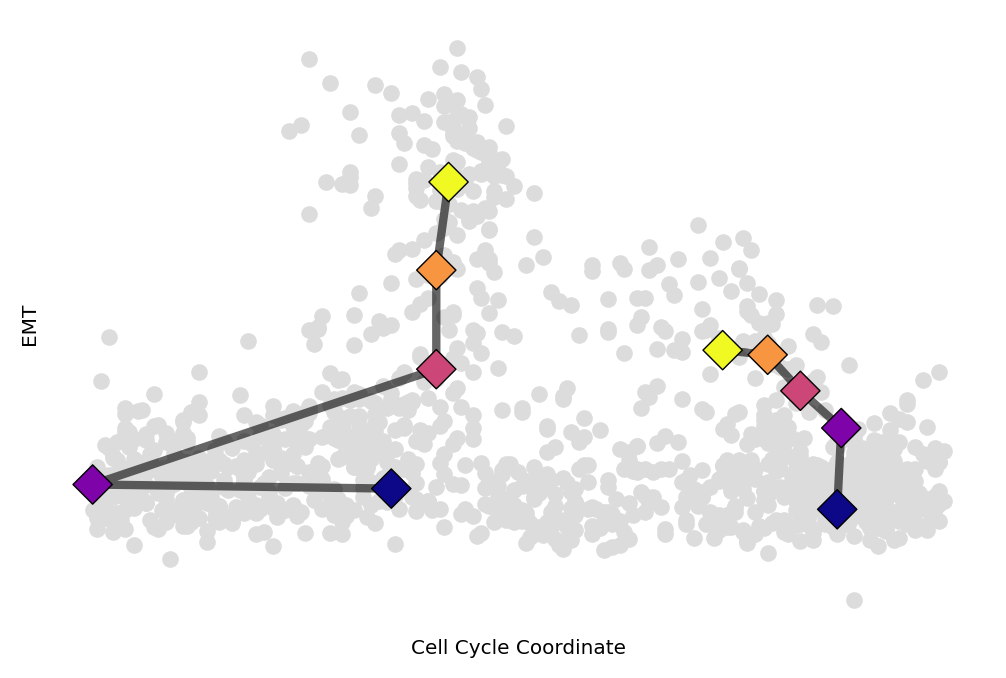

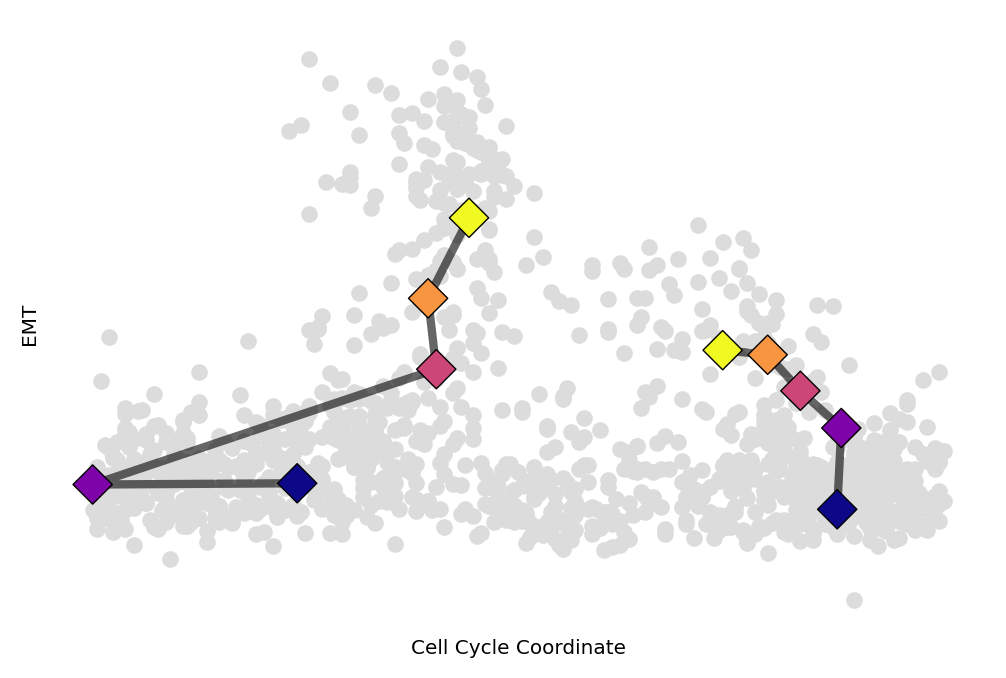

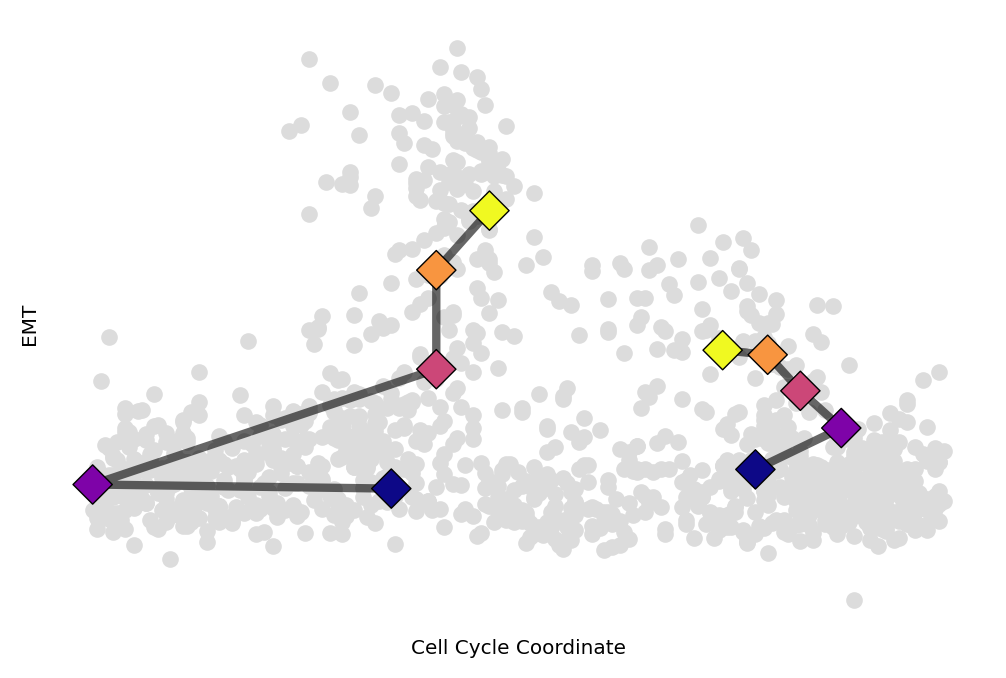

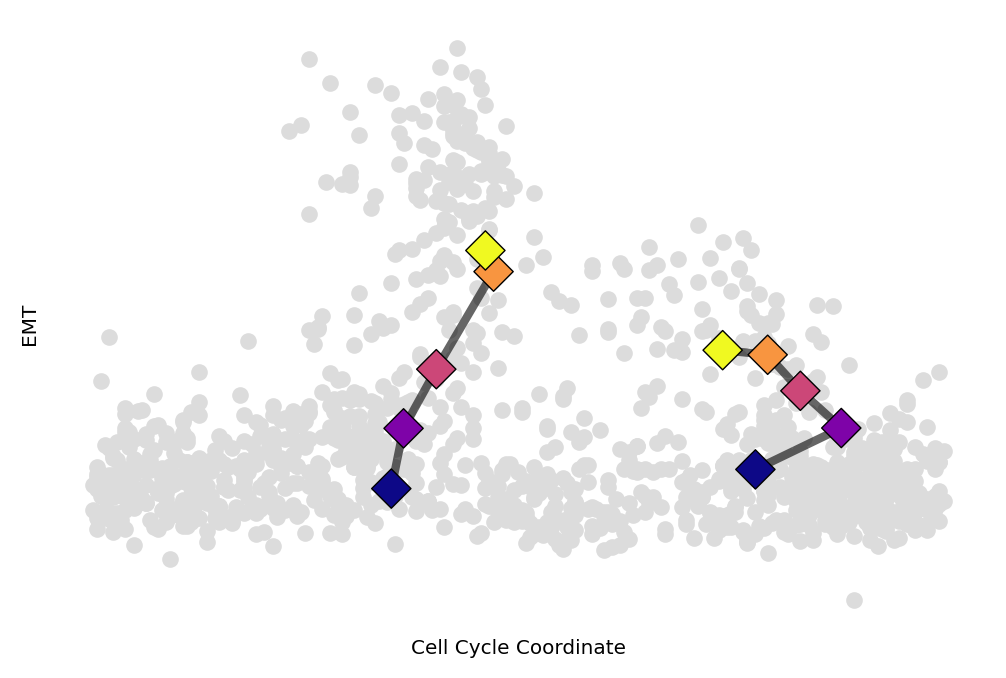

In [269]:
i=0
for trial in DC_to_RC_trajs:
    plt.subplot(1,1,1,frame_on=False)
    plt.scatter(dose12.obsm['X_RC'][:,0],
                dose12.obsm['X_RC'][:,1],
                s=30,
                color='gainsboro', zorder=1)
    for traj in trial:
        if dose12.obsm['X_RC'][traj[0],0] < 50:
            symbol = 'o'
        else:
            symbol = 'D'
        plt.plot(dose12.obsm['X_RC'][traj,0],
                dose12.obsm['X_RC'][traj,1],
                color='black',
                linewidth=3,
                zorder=2,
                alpha=0.6)
        plt.scatter(dose12.obsm['X_RC'][traj,0],
                    dose12.obsm['X_RC'][traj,1],
                    c=range(len(traj)),
                    s=100,
                    edgecolor='black',
                    facecolors='none',
                    cmap='plasma',
                    zorder=2,
                    marker=symbol)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Cell Cycle Coordinate")
    plt.ylabel("EMT")
    #plt.savefig("../plots/new_CCC/dose12/RC_trajs/trial_"+str(i)+"_trajs_colored.png", dpi=300)
    plt.show()
    i+=1

# EMT heatmap of two paths

In [270]:
model = model_list[1]
path1 = np.where(model.labels_ == 0)[0]

Text(0, 0.5, 'EMT')

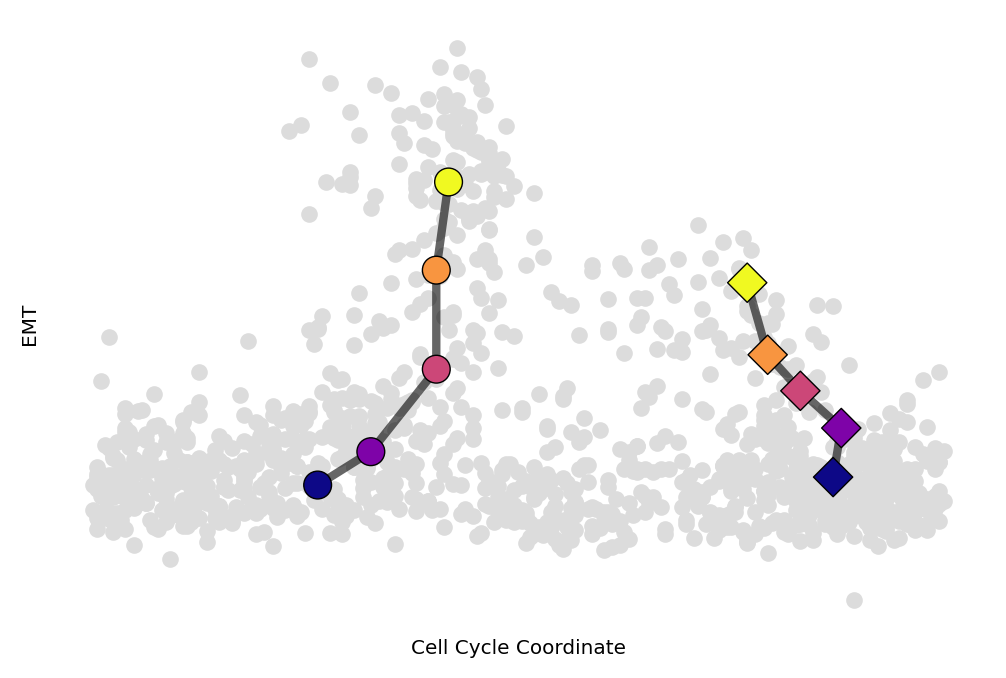

In [272]:
plt.subplot(1,1,1,frame_on=False)
plt.scatter(dose12.obsm['X_RC'][:,0],
            dose12.obsm['X_RC'][:,1],
            s=30,
            color='gainsboro', zorder=1)
trial = DC_to_RC_trajs[1]
for traj in trial:
    if dose12.obsm['X_RC'][traj[0],0] < 100:
        symbol = 'o'
    else:
        symbol = 'D'
    plt.plot(dose12.obsm['X_RC'][traj,0],
            dose12.obsm['X_RC'][traj,1],
            color='black',
            linewidth=3,
            zorder=2,
            alpha=0.6)
    plt.scatter(dose12.obsm['X_RC'][traj,0],
                dose12.obsm['X_RC'][traj,1],
                c=range(len(traj)),
                s=100,
                edgecolor='black',
                facecolors='none',
                cmap='plasma',
                zorder=2,
                marker=symbol)
plt.xticks([])
plt.yticks([])
plt.xlabel("Cell Cycle Coordinate")
plt.ylabel("EMT")

In [273]:
dose12.obsm['X_RC'].shape

(1228, 2)

In [274]:
trial = DC_to_RC_trajs[1]
traj1 = trial[0]
traj1_RC_coords = dose12.obsm['X_RC'][traj1,:2]

traj2 = trial[1]
traj2_RC_coords = dose12.obsm['X_RC'][traj2,:2]

In [279]:
# Fit a smooth spline of x as a function of y
spl_xy = UnivariateSpline(traj1_RC_coords[:,1], traj1_RC_coords[:,0], s=0.5)

# Choose desired y positions
y_new = np.linspace(-2, 9, 50)
x_smooth = spl_xy(y_new)

In [280]:
spl_xy = UnivariateSpline(traj2_RC_coords[:,1], traj2_RC_coords[:,0], s=0.5)

# Choose desired y positions
y_new = np.linspace(-2, 9, 50)
x_smooth2 = spl_xy(y_new)

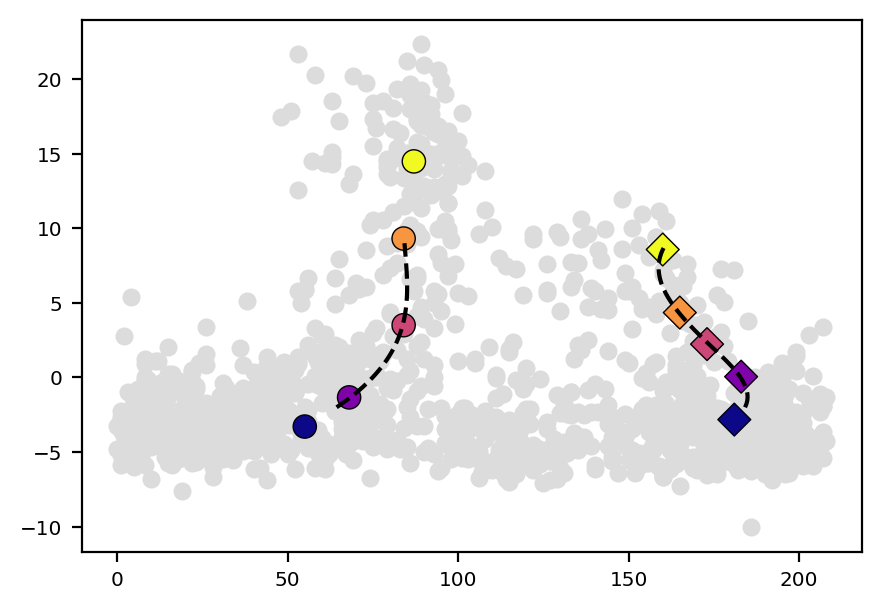

In [281]:
plt.figure(figsize=(5,3.5), dpi=100)
plt.scatter(dose12.obsm['X_RC'][:,0],
            dose12.obsm['X_RC'][:,1],
            c='gainsboro',
            zorder=1)
plt.scatter(traj1_RC_coords[:,0], traj1_RC_coords[:,1], zorder=2, 
            marker = 'D', c=range(len(traj1_RC_coords[:,0])), 
            edgecolor='black',cmap='plasma', s=70)
plt.scatter(traj2_RC_coords[:,0], traj2_RC_coords[:,1], zorder=2, 
            marker = 'o', c=range(len(traj2_RC_coords[:,0])), 
            edgecolor='black',cmap='plasma', s=70)
plt.plot(x_smooth, y_new, 'k-', zorder=3, linestyle='dashed')
plt.plot(x_smooth2, y_new, 'k-', zorder=3, linestyle='dashed')
#plt.savefig("../plots/new_CCC/dose12/RC_trajs/interpolated_paths_matching_y_EMT.png", dpi=300)

In [282]:
interp_path0 = np.concatenate([x_smooth[:,None], y_new[:,None]], axis=1)
interp_path1 = np.concatenate([x_smooth2[:,None], y_new[:,None]], axis=1)

In [285]:
interp_path0_ge = new_pt_to_ge(pd.DataFrame(interp_path0), dose12, pc_dc_rot, pcs, filtered_gene_means)
interp_path1_ge = new_pt_to_ge(pd.DataFrame(interp_path1), dose12, pc_dc_rot, pcs, filtered_gene_means)

(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)
(733, 1)


In [286]:
valid_emt_genes = []
for gene in emt_genes:
    if gene in interp_path0_ge.index:
        valid_emt_genes.append(gene)

In [287]:
both_paths_df = pd.concat([interp_path1_ge, interp_path0_ge], axis=1) # the paths are actually flipped for this case!

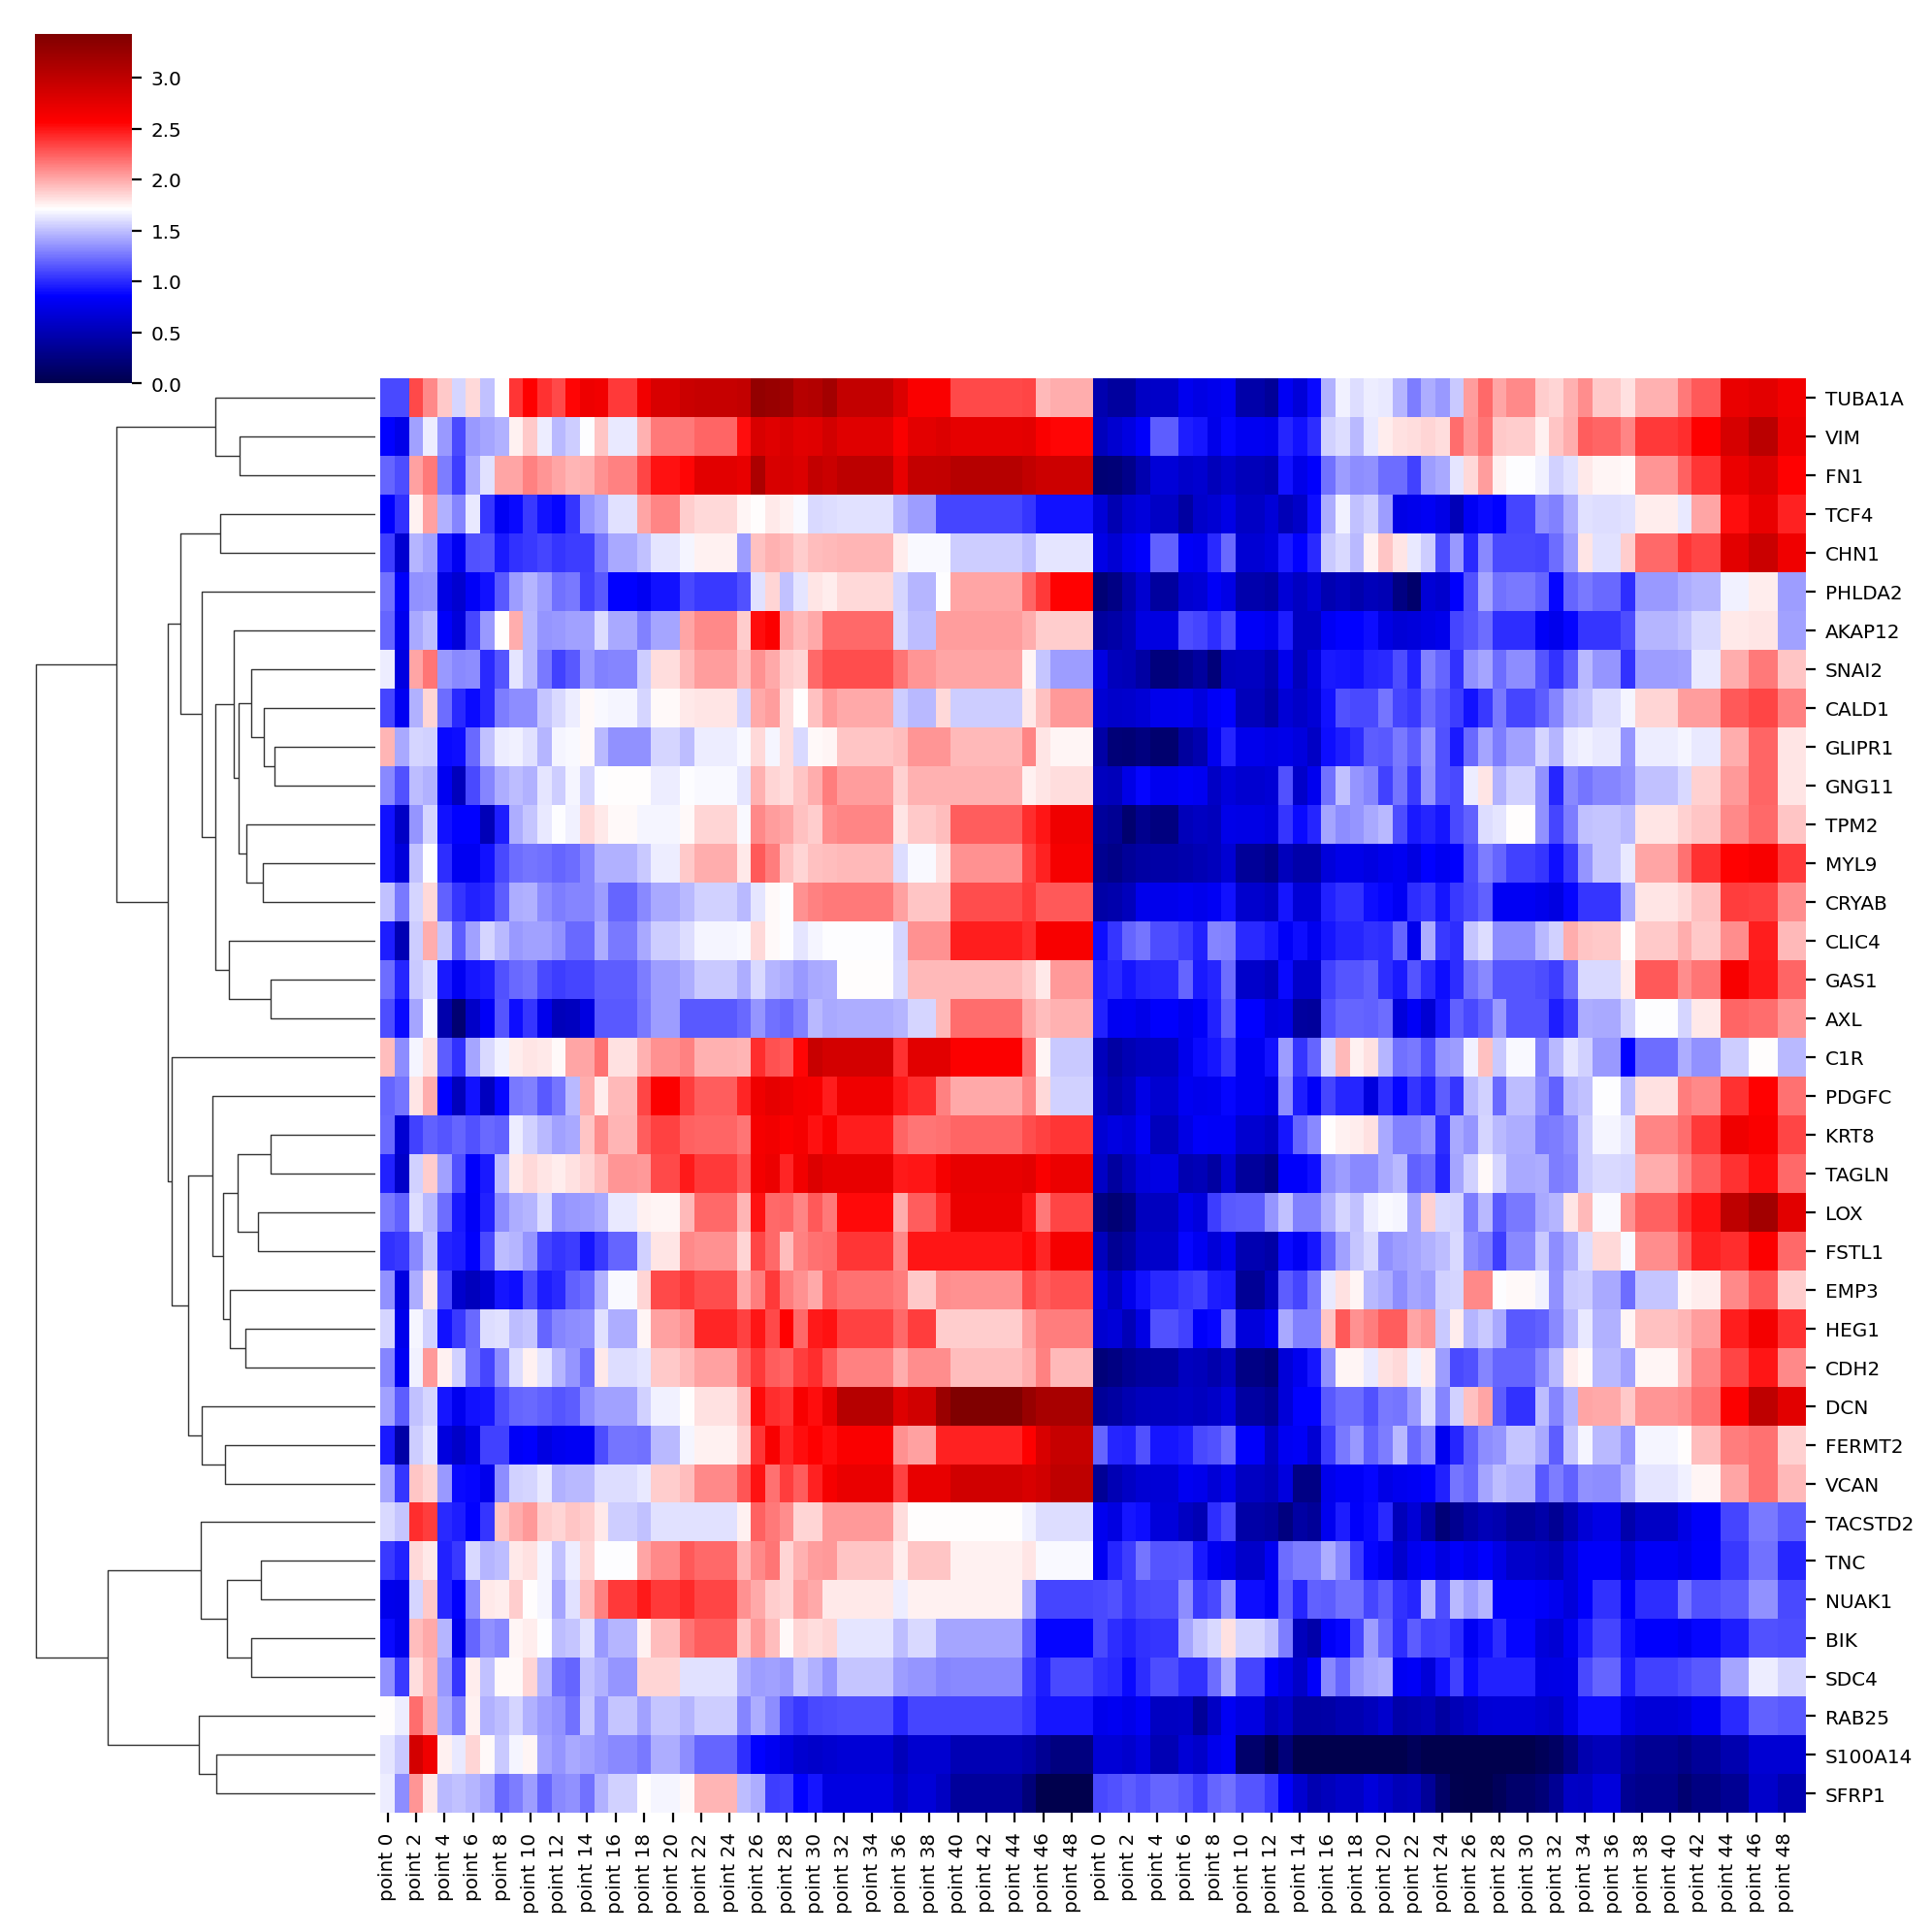

In [289]:
cm = sns.clustermap(both_paths_df.loc[valid_emt_genes], col_cluster=False, 
                    cmap='seismic')
#cm.savefig('../plots/new_CCC/dose12/RC_trajs/interp_gene_exp_both_paths_matching_y_EMT.pdf')